In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from ultralytics import YOLO
from keras.models import load_model
import math



In [2]:
meta = {'c0': "Focussed",
         'c1' : "Text-Phone Right",
           'c2': "Talk-Phone Right", 
           'c3': "Text-Phone Left", 
           'c4': "Talk-Phone Left", 
           'c5': "Radio Adjust", 
           'c6': "Drinking", 
           'c7': "Back Seat Reach", 
           'c8': "Misc Manual", 
           'c9': "Visual"
}

In [3]:
meta_points_disc = {"p1": "nose",
                    "p2": "L_eye",
                    "p3": "R_eye",
                    "p4": "L_ear",
                    "p5": "R_ear",
                    "p6": "L_shoulder",
                    "p7": "R_shoulder",
                    "p8": "L_elbow",
                    "p9": "R_elbow",
                    "p10": "L_wrist",
                    "p11": "R_wrist",
                    "p12": "L_hip",
                    "p13": "R_hip",
                    "p14": "L_Knee",
                    "p15": "R_Knee",
                    "p16": "L_ankle",
                    "p17": "R_ankle",
                    "p18": "Top_left_box",
                    "p19": "Top_right_box",
                    "p20": "Bottom_right_box",
                    "p21": "Bottom_right_box",
                    "p22": "Top_left_box_sw",
                    "p23": "Top_right_box_sw",
                    "p24": "Bottom_right_box_sw",
                    "p25": "Bottom_right_box_sw"
                    }

In [4]:
defualt = {'X_coord': {'p1': 0,
    'p2': 0,
    'p3': 0,
    'p4': 0,
    'p5': 0,
    'p6': 0,
    'p7': 0,
    'p8': 0,
    'p9': 0,
    'p10': 0,
    'p11': 0,
    'p12': 0,
    'p13': 0,
    'p14': 0,
    'p15': 0,
    'p16': 0,
    'p17': 0,
    "p18": 0,
    "p19": 0,
    "p20": 0,
    "p21": 0,
    "p22": 0,
    "p23": 0,
    "p24": 0,
    "p25": 0},
    'Y_coord': {'p1': 0,
    'p2': 0,
    'p3': 0,
    'p4': 0,
    'p5': 0,
    'p6': 0,
    'p7': 0,
    'p8': 0,
    'p9': 0,
    'p10': 0,
    'p11': 0,
    'p12': 0,
    'p13': 0,
    'p14': 0,
    'p15': 0,
    'p16': 0,
    'p17': 0,
    "p18": 0,
    "p19": 0,
    "p20": 0,
    "p21": 0,
    "p22": 0,
    "p23": 0,
    "p24": 0,
    "p25": 0},
    'Z_coord/conf': {'p1': 0,
    'p2': 0,
    'p3': 0,
    'p4': 0,
    'p5': 0,
    'p6': 0,
    'p7': 0,
    'p8': 0,
    'p9': 0,
    'p10': 0,
    'p11': 0,
    'p12': 0,
    'p13': 0,
    'p14': 0,
    'p15': 0,
    'p16': 0,
    'p17': 0,
    "p18": 0,
    "p19": 0,
    "p20": 0,
    "p21": 0,
    "p22": 0,
    "p23": 0,
    "p24": 0,
    "p25": 0},}

In [5]:
pose_model = YOLO(r"C:/Users/james/Desktop/Diss_Code_for_AUC/Pretrained_models/yolov8n-pose.pt")
box_model = YOLO(r"C:/Users/james/Desktop/Diss_Code_for_AUC/Pretrained_models/Steering_wheel.pt")

In [6]:
def get_corners(box):
    box_coords = box.xywhn.numpy()[0]
    TopLeft = [(box_coords[0]-box_coords[2]/2),(box_coords[1]+box_coords[3]/2)]
    TopRight = [(box_coords[0]+box_coords[2]/2),(box_coords[1]+box_coords[3]/2)]
    BottomLeft = [(box_coords[0]-box_coords[2]/2),(box_coords[1]-box_coords[3]/2)]
    BottomRight = [(box_coords[0]+box_coords[2]/2),(box_coords[1]-box_coords[3]/2)]

    box_coords = [TopLeft, TopRight, BottomLeft, BottomRight]
    box_conf = [box.conf.numpy()[0]]*4
    box_coords = np.array(box_coords, dtype=np.float32)
    box_conf = np.array(box_conf, dtype=np.float32)
    return box_coords, box_conf

def create_full_dict(SW_results, results):
    keypoint = results[0]
    points = keypoint.keypoints.xyn.numpy()[0]
    box_coords, box_conf = get_corners(keypoint.boxes)
    points = np.vstack((points, box_coords))
    if len(SW_results[0].boxes.conf) != 0:
        seg_box_coords, seg_box_conf = get_corners(SW_results[0].boxes)
    else:
        seg_box_coords = np.array([[0,0]]*4)
        seg_box_conf = [0]*4
    points = np.vstack((points, seg_box_coords)) 
    column_names = ["X_coord", "Y_coord"]
    points_df = pd.DataFrame(data = points, columns=column_names)
    confidence = keypoint.keypoints.conf.numpy()[0]
    confidence = np.concatenate([confidence, box_conf, seg_box_conf])
    points_df["Z_coord/conf"] = confidence
    points_df.index = list(meta_points_disc.keys())
    points_dict = points_df.to_dict()
    return points_dict

In [7]:
def get_landmarks(pose_model, box_model, image_dir):
    results = pose_model(image_dir, conf=0.6)
    SW_results = box_model(image_dir, conf=0.6)
    if results[0].keypoints.conf != None:
        cls_dict = create_full_dict(SW_results, results)
    else:
        cls_dict = defualt
    return cls_dict
        

In [8]:
def standardize(coord_list):
    mean = np.mean(coord_list)
    std = np.std(coord_list)
    standardize = []
    for i in coord_list:
        standardize.append((i-mean)/std)
    return standardize

In [9]:
def dict_2_input(landmark_dict, std):
    x_values = []

    x_list = list(landmark_dict["X_coord"].values())
    y_list = list(landmark_dict["Y_coord"].values())
    if std == 1:
        x_list_std = standardize(x_list)
        y_list_std = standardize(y_list)
        x_list_std.extend(y_list_std)
        x_points = x_list_std
    else:
        x_list.extend(y_list)
        x_points = x_list
   
    x_values.append(x_points)
    X = np.array(x_values)
    
    return X

In [10]:
def create_inputs(pose_model, box_model, image_dir):
    dict_lm = get_landmarks(pose_model,box_model, image_dir)
    X = dict_2_input(dict_lm, 1) 
    return X


TEST INPUT FUNCTION

In [11]:
X = create_inputs(pose_model, box_model, r"C:/Users/james/Desktop/Diss_Code_for_AUC/state-farm-distracted-driver-detection/imgs/train/c0/img_100026.jpg")



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100026.jpg: 480x640 1 person, 123.9ms
Speed: 3.2ms preprocess, 123.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100026.jpg: 480x640 1 Steering Wheel, 79.7ms
Speed: 0.0ms preprocess, 79.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


LOAD MODEL

In [12]:
#remember to change dict_2_input 2nd argument depending on model 
model = load_model(r"C:/Users/james/Desktop/Diss_Code_for_AUC/Train Landmarks/Auc_MPL_Standardized_Landmarks.h5")#Auc_MPL_Landmarks.h5"
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 50)                2550      
                                                                 
 dense_41 (Dense)            (None, 100)               5100      
                                                                 
 dense_42 (Dense)            (None, 300)               30300     
                                                                 
 dropout_10 (Dropout)        (None, 300)               0         
                                                                 
 dense_43 (Dense)            (None, 600)               180600    
                                                                 
 dense_44 (Dense)            (None, 1200)              721200    
                                                                 
 dropout_11 (Dropout)        (None, 1200)             

TEST PREDICTION

In [13]:
prediction = model.predict(X)

prediction

1/1 [==============================] - 0s 200ms/step


array([[   0.013163,   2.571e-07,  2.1675e-09,     0.98678,  4.1732e-05,  8.9131e-06,  3.9531e-08,  8.2669e-07,  9.0054e-07,  3.6542e-09]], dtype=float32)

In [14]:
print("Predicted probabilities for each class:")
print(np.argmax(prediction))

Predicted probabilities for each class:
3


TEST ON SPECIFIED IMAGES AND VISUALIZE

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\Unlabled\test\img_384.jpg: 480x640 1 person, 94.6ms
Speed: 0.0ms preprocess, 94.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\Unlabled\test\img_384.jpg: 480x640 1 Steering Wheel, 85.2ms
Speed: 0.0ms preprocess, 85.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


[[   -0.85398      -1.021     -1.1066     -1.1176     -1.3545    -0.57788    -0.82641     0.24458    -0.15872     0.67819     0.23383     0.50659     0.38766     0.84244       1.034      1.2252       1.138     -1.9256       1.361     -1.9256       1.361     0.17254     0.75518     0.17254     0.75518    -0.93132
      -1.1666    -0.84738      -1.101    -0.28824    -0.35191     0.52628      0.1624       1.052    -0.06011   -0.081004     0.50143     0.98821     0.36982     0.83519     0.89215     0.85734      1.7211      1.7211     -1.8541     -1.8541     0.52151     0.52151     -1.0671     -1.0671]]
1/1 [==============================] - 0s 26ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\Unlabled\test\img_413.jpg: 480x640 1 person, 101.7ms
Speed: 15.7ms preprocess, 101.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\Unlabled\test\img_413.jpg: 480x640 1 Steering Wheel, 94.2ms
Speed: 6.1ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


[[   -0.91197    -0.93973     -1.1472    -0.96311     -1.4878     -0.8181     -1.0503    -0.13875    -0.29845     0.60958     0.47745     0.31923     0.18277       1.024      1.0689      1.0108      1.1137     -1.7011      1.4211     -1.7011      1.4211     0.32756     0.92696     0.32756     0.92696    -0.73836
     -0.98677    -0.81186     -0.9571    -0.49068    -0.43313     0.56709    -0.47499      1.5457    -0.58152      0.7887      0.5448      1.1473   -0.013189     0.72895     0.55123       1.083       1.653       1.653     -1.5082     -1.5082     0.45074     0.45074     -1.3302     -1.3302]]
1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\Unlabled\test\img_1031.jpg: 480x640 1 person, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\Unlabled\test\img_1031.jpg: 480x640 1 Steering Wheel, 95.5ms
Speed: 0.0ms preprocess, 95.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


[[   -0.59287    -0.62286    -0.73615    -0.76475     -1.1081    -0.71152     -1.1662    0.049352    -0.69525     0.64398    -0.50055   -0.071699    -0.29773      1.1288     0.99234     0.79531      1.1247     -1.8932       1.347     -1.8932       1.347     0.53373       1.279     0.53373       1.279    -0.81856
     -0.93528     -0.9119    -0.88595    -0.78339    -0.51317    0.081635    -0.20411      1.1132    -0.28035   -0.030459     0.75482      1.1257     0.55405     0.83574      1.2523      1.3561      1.5735      1.5735     -1.6181     -1.6181     0.38515     0.38515     -1.1958     -1.1958]]
1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\Unlabled\test\img_1240.jpg: 480x640 1 person, 110.8ms
Speed: 0.0ms preprocess, 110.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\Unlabled\test\img_1240.jpg: 480x640 1 Steering Wheel, 70.4ms
Speed: 0.0ms preprocess, 70.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


[[    -0.8201    -0.84347     -1.0155    -0.93006     -1.4263    -0.87693        -1.1    -0.25994    -0.23449     0.22227      0.7956     0.33839     0.15184     0.88719     0.77473      1.0715      1.0039     -1.7653      1.5394     -1.7653      1.5394      0.3587     0.99777      0.3587     0.99777    -0.78712
     -0.95282    -0.85599    -0.84941    -0.59654    -0.42559     0.26167    -0.18682      1.2094    -0.28484      1.0464     0.65976      1.1562     0.44177      1.1749     0.63568      1.2849      1.3837      1.3837     -1.5011     -1.5011     0.21778     0.21778     -1.5661     -1.5661]]
1/1 [==============================] - 0s 26ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\Unlabled\test\img_1866.jpg: 480x640 1 person, 100.3ms
Speed: 12.5ms preprocess, 100.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\Unlabled\test\img_1866.jpg: 480x640 1 Steering Wheel, 100.2ms
Speed: 0.0ms preprocess, 100.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


[[   -0.59273    -0.61758    -0.72742    -0.80141     -1.1045    -0.91719     -1.1082    -0.56323    -0.46628    -0.21731     0.44038    -0.12839    -0.24686      1.0607      1.0077     0.95719      1.1135     -1.7445      1.6982     -1.7445      1.6982     0.38159      1.1205     0.38159      1.1205    -0.96986
       -1.067     -1.0643    -0.94703    -0.90042    -0.34897   -0.036827     0.22426     0.97999     -0.2125     0.41603     0.81226      1.1107     0.48831     0.85338      1.0826      1.4404      1.4789      1.4789     -1.6321     -1.6321     0.37217     0.37217     -1.1494     -1.1494]]
1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\Unlabled\test\img_2072.jpg: 480x640 1 person, 102.5ms
Speed: 0.0ms preprocess, 102.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\Unlabled\test\img_2072.jpg: 480x640 1 Steering Wheel, 80.8ms
Speed: 0.0ms preprocess, 80.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


[[   -0.68952     -0.7194    -0.82224    -0.86386     -1.1557    -0.91182     -1.0633    -0.48887    -0.29576    -0.10845     0.51203    -0.21919    -0.31385       1.072      1.0735      1.0177      1.1707     -1.7102      1.6199     -1.7102      1.6199     0.39146      1.1018     0.39146      1.1018     -1.0011
       -1.089     -1.0838    -0.96165     -0.9119    -0.29211    -0.18631     0.43255     0.28565     0.42534    -0.56986     0.83916       1.065     0.51761     0.81902      1.2127      1.5068       1.619       1.619     -1.5271     -1.5271     0.44475     0.44475     -1.0407     -1.0407]]
1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\Unlabled\test\img_2154.jpg: 480x640 1 person, 118.7ms
Speed: 0.0ms preprocess, 118.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\Unlabled\test\img_2154.jpg: 480x640 1 Steering Wheel, 97.9ms
Speed: 0.0ms preprocess, 97.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


[[   -0.74727    -0.75919    -0.92602    -0.82418     -1.2978    -0.76783     -1.2386    0.042947    -0.76313     0.67957    -0.14814   0.0022813    -0.25375     0.77663     0.67624     0.95967      1.1563      -1.665       1.437      -1.665       1.437     0.57967      1.3644     0.57967      1.3644    -0.85393
      -1.0443    -0.93191      -1.036    -0.76994    -0.58536      0.1503    -0.35845       1.164    -0.42637      0.3315     0.64662       1.143      0.2978     0.95416     0.71777      1.2405      1.6639      1.6639     -1.6589     -1.6589       0.641       0.641    -0.96573    -0.96573]]
1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\Unlabled\test\img_2857.jpg: 480x640 1 person, 86.9ms
Speed: 9.0ms preprocess, 86.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\Unlabled\test\img_2857.jpg: 480x640 1 Steering Wheel, 78.2ms
Speed: 0.0ms preprocess, 78.2ms inference, 14.5ms postprocess per image at shape (1, 3, 480, 640)


[[   -0.83728    -0.88397      -1.033    -0.96782     -1.3888    -0.75661      -1.164    0.013511    -0.46712     0.64441     0.30484     0.32349    0.089035      1.1705      1.1236     0.86445      1.1232     -1.7585      1.3785     -1.7585      1.3785     0.29679      1.0039     0.29679      1.0039    -0.94121
      -1.0824     -1.0067    -0.98108    -0.75406     -0.4769     0.19648     -0.3439      1.2393    -0.63827     0.49685     0.66038      1.0678     0.40619     0.80034      1.1995      1.3687      1.4999      1.4999     -1.6191     -1.6191     0.49009     0.49009    -0.97641    -0.97641]]
1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\Unlabled\test\img_308.jpg: 480x640 1 person, 111.4ms
Speed: 0.0ms preprocess, 111.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\Unlabled\test\img_308.jpg: 480x640 1 Steering Wheel, 96.0ms
Speed: 0.0ms preprocess, 96.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


[[   -0.83555     -0.8598     -1.0112    -0.94427     -1.3294    -0.77118     -1.0206  -0.0027681    -0.46579     0.42626    -0.64642     0.34064     0.22889      1.1571      1.1499      1.1082      1.2969     -1.6498      1.4282     -1.6498      1.4282     0.32159     0.98958     0.32159     0.98958    -0.93264
      -1.0716     -1.0084    -0.93152    -0.72737    -0.38984      0.3019    -0.26985      1.0769    -0.48652    -0.11078     0.72168      1.1276     0.60568     0.98371      1.0204      1.2373      1.5875      1.5875     -1.6734     -1.6734     0.50909     0.50909    -0.99647    -0.99647]]
1/1 [==============================] - 0s 16ms/step


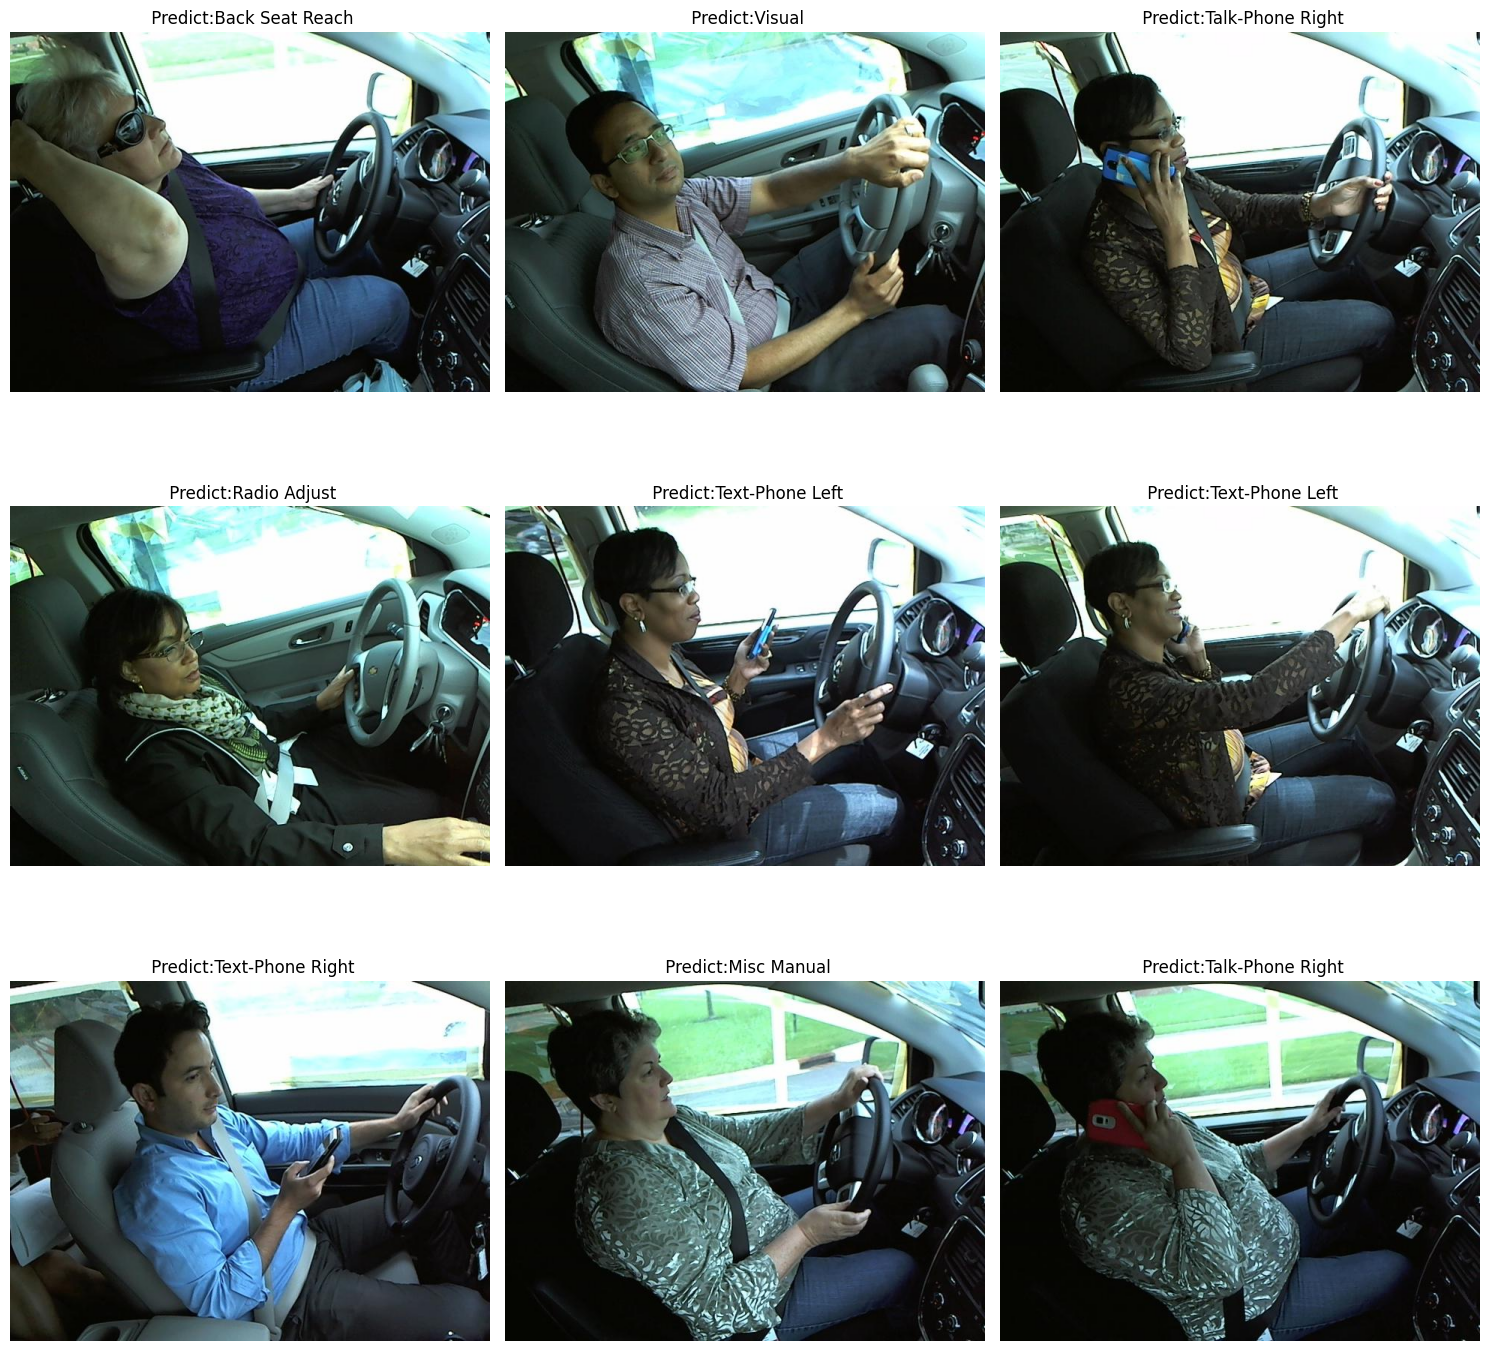

In [15]:
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
img_list = ["img_384.jpg", "img_413.jpg", "img_1031.jpg", "img_1240.jpg", "img_1866.jpg", "img_2072.jpg", "img_2154.jpg", "img_2857.jpg", "img_308.jpg"]
#["img_47022.jpg", "img_44266.jpg", "img_27721.jpg", "img_51500.jpg", "img_91910.jpg", "img_6321.jpg", "img_3528.jpg", "img_96327.jpg", "img_39742.jpg"]
keys = list(meta.keys())
index = [0,1,2,3,4,5,6,7,8,9]
x_ticks = list(meta.values())

grid_x = 3
grid_y = 3
plots = grid_x*grid_y

plt.figure(figsize=(grid_y * 5, grid_x * 5))
for idx, image_filename in enumerate(img_list):
    dir_file = "C:/Users/james/Desktop/Diss_project_code/state-farm-distracted-driver-detection/imgs/Unlabled/test/"
    image_path = dir_file + image_filename
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    X = create_inputs(pose_model, box_model, image_path)
    print(X)
    predictions = model.predict(X)

    cls_pred = np.argmax(predictions)

    ax = plt.subplot(grid_x, grid_y, idx + 1)
    plt.imshow(image)
    if X.any() == 0:
        plt.title(" Predict: Undefined" )
    plt.title(" Predict:" + meta[keys[cls_pred]])
    plt.axis("off")

plt.tight_layout()
plt.show()

EVALUATION

In [16]:
from keras.utils import image_dataset_from_directory
BATCH_SIZE = 64
IMG_SIZE = (108, 192) 
val_split = 0.3

In [17]:
train_dir = r"C:/Users/james/Desktop/Diss_Code_for_AUC/state-farm-distracted-driver-detection/imgs/train/"
SF_test_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE, 
                                             validation_split= val_split, 
                                             subset= "training", 
                                             seed = 1, 
                                             labels="inferred")
def normalize(image, label):
    image = tf.cast(image/255.0, tf.float32)
    return image, label
SF_test_dataset = SF_test_dataset.map(normalize)



Found 20251 files belonging to 10 classes.
Using 14176 files for training.


In [18]:
filename_list = []
class_imgs_dict = {}

import os
directory = r"C:/Users/james/Desktop/Diss_Code_for_AUC/state-farm-distracted-driver-detection/imgs/train/"
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    filename_list.append(filename)
    if os.path.exists(f):
        img_list = []
        for imgs in os.listdir(f):
            img_list.append(imgs)
        class_imgs_dict[filename] = img_list
print(class_imgs_dict)

{'c0': ['img_100026.jpg', 'img_10003.jpg', 'img_100050.jpg', 'img_100074.jpg', 'img_10012.jpg', 'img_100145.jpg', 'img_100191.jpg', 'img_100257.jpg', 'img_100312.jpg', 'img_100337.jpg', 'img_100456.jpg', 'img_10053 - Copy.jpg', 'img_10053.jpg', 'img_100542.jpg', 'img_100598.jpg', 'img_100605.jpg', 'img_100656.jpg', 'img_100665.jpg', 'img_100796.jpg', 'img_100824.jpg', 'img_100828.jpg', 'img_10092.jpg', 'img_100922.jpg', 'img_101015.jpg', 'img_101032.jpg', 'img_101091.jpg', 'img_101113.jpg', 'img_101159.jpg', 'img_101175.jpg', 'img_101196.jpg', 'img_101223.jpg', 'img_101286.jpg', 'img_101383.jpg', 'img_101392.jpg', 'img_10141.jpg', 'img_101414.jpg', 'img_101419.jpg', 'img_101498.jpg', 'img_101555.jpg', 'img_101609.jpg', 'img_101613.jpg', 'img_101668.jpg', 'img_10167.jpg', 'img_101673.jpg', 'img_101702.jpg', 'img_10175.jpg', 'img_101785.jpg', 'img_101859.jpg', 'img_101938.jpg', 'img_102025.jpg', 'img_10206.jpg', 'img_102087.jpg', 'img_10225 - Copy.jpg', 'img_10225.jpg', 'img_10307.jpg', 

In [19]:
meta_cls = {'c0': 0,
           'c1' : 1,
           'c2': 2, 
           'c3': 3, 
           'c4': 4, 
           'c5': 5, 
           'c6': 6, 
           'c7': 7, 
           'c8': 8, 
           'c9': 9
}

In [20]:
import time
import numpy as np
import psutil
latency_list = []
memory_usage_percent_list = []
memory_usage_list = []
cpu_usage_list = []
y_pred = []
y_test = []

for cls in class_imgs_dict.keys():
    count = 1
    
    keypoint_class_dict = {}
    for img in class_imgs_dict[cls]:

        image_dir = directory + cls + "/" + img
        start = time.time()
        X = create_inputs(pose_model, box_model, image_dir)
        predictions = model.predict(X)
        end = time.time()
        prediction = np.argmax(predictions[0])
        y_pred.append(prediction)
        y_test.append(meta_cls[cls])
        latency_list.append(end - start)

        memory_info = psutil.virtual_memory()
        memory_usage_percent_list.append(memory_info.percent)
        memory_usage_list.append((memory_info.used)/1024**2)

        cpu_percent = psutil.cpu_percent()
        cpu_usage_list.append(cpu_percent)

        count += 1
        if count > 202:
            break


image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100026.jpg: 480x640 1 person, 94.6ms
Speed: 0.0ms preprocess, 94.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100026.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10003.jpg: 480x640 1 person, 116.2ms
Speed: 0.0ms preprocess, 116.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10003.jpg: 480x640 1 Steering Wheel, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100050.jpg: 480x640 1 person, 122.2ms
Speed: 0.0ms preprocess, 122.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100050.jpg: 480x640 1 Steering Wheel, 80.0ms
Speed: 15.6ms preprocess, 80.0ms inference, 14.5ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100074.jpg: 480x640 1 person, 102.8ms
Speed: 7.5ms preprocess, 102.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100074.jpg: 480x640 1 Steering Wheel, 109.7ms
Speed: 0.0ms preprocess, 109.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10012.jpg: 480x640 1 person, 98.3ms
Speed: 0.0ms preprocess, 98.3ms inference, 11.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10012.jpg: 480x640 1 Steering Wheel, 94.6ms
Speed: 0.0ms preprocess, 94.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100145.jpg: 480x640 1 person, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100145.jpg: 480x640 1 Steering Wheel, 76.4ms
Speed: 2.5ms preprocess, 76.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100191.jpg: 480x640 1 person, 94.6ms
Speed: 0.0ms preprocess, 94.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100191.jpg: 480x640 1 Steering Wheel, 63.6ms
Speed: 0.0ms preprocess, 63.6ms inference, 15.7ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100257.jpg: 480x640 1 person, 78.5ms
Speed: 15.6ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100257.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100312.jpg: 480x640 1 person, 95.7ms
Speed: 0.0ms preprocess, 95.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100312.jpg: 480x640 1 Steering Wheel, 78.3ms
Speed: 14.5ms preprocess, 78.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100337.jpg: 480x640 1 person, 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100337.jpg: 480x640 1 Steering Wheel, 91.3ms
Speed: 0.0ms preprocess, 91.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 38ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100456.jpg: 480x640 1 person, 109.7ms
Speed: 0.0ms preprocess, 109.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100456.jpg: 480x640 1 Steering Wheel, 94.4ms
Speed: 0.0ms preprocess, 94.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10053 - Copy.jpg: 480x640 1 person, 94.1ms
Speed: 0.0ms preprocess, 94.1ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10053 - Copy.jpg: 480x640 1 Steering Wheel, 79.3ms
Speed: 0.0ms preprocess, 79.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10053.jpg: 480x640 1 person, 125.6ms
Speed: 0.0ms preprocess, 125.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10053.jpg: 480x640 1 Steering Wheel, 78.2ms
Speed: 16.2ms preprocess, 78.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100542.jpg: 480x640 1 person, 126.9ms
Speed: 0.0ms preprocess, 126.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100542.jpg: 480x640 1 Steering Wheel, 62.9ms
Speed: 0.0ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100598.jpg: 480x640 1 person, 94.1ms
Speed: 0.0ms preprocess, 94.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100598.jpg: 480x640 1 Steering Wheel, 78.8ms
Speed: 15.6ms preprocess, 78.8ms inference, 15.7ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100605.jpg: 480x640 1 person, 109.7ms
Speed: 0.0ms preprocess, 109.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100605.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100656.jpg: 480x640 1 person, 94.1ms
Speed: 0.0ms preprocess, 94.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100656.jpg: 480x640 1 Steering Wheel, 78.7ms
Speed: 15.6ms preprocess, 78.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100665.jpg: 480x640 1 person, 77.6ms
Speed: 1.0ms preprocess, 77.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100665.jpg: 480x640 1 Steering Wheel, 71.5ms
Speed: 0.0ms preprocess, 71.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100796.jpg: 480x640 1 person, 94.5ms
Speed: 0.0ms preprocess, 94.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100796.jpg: 480x640 1 Steering Wheel, 94.1ms
Speed: 15.6ms preprocess, 94.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100824.jpg: 480x640 1 person, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100824.jpg: 480x640 1 Steering Wheel, 94.1ms
Speed: 0.0ms preprocess, 94.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100828.jpg: 480x640 1 person, 100.2ms
Speed: 0.0ms preprocess, 100.2ms inference, 8.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100828.jpg: 480x640 1 Steering Wheel, 78.9ms
Speed: 0.0ms preprocess, 78.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10092.jpg: 480x640 1 person, 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10092.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100922.jpg: 480x640 1 person, 110.1ms
Speed: 0.0ms preprocess, 110.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_100922.jpg: 480x640 1 Steering Wheel, 79.5ms
Speed: 15.7ms preprocess, 79.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101015.jpg: 480x640 1 person, 94.7ms
Speed: 15.6ms preprocess, 94.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101015.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101032.jpg: 480x640 1 person, 94.1ms
Speed: 0.0ms preprocess, 94.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101032.jpg: 480x640 1 Steering Wheel, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101091.jpg: 480x640 1 person, 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101091.jpg: 480x640 1 Steering Wheel, 94.9ms
Speed: 0.0ms preprocess, 94.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 38ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101113.jpg: 480x640 1 person, 95.5ms
Speed: 15.6ms preprocess, 95.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101113.jpg: 480x640 1 Steering Wheel, 73.9ms
Speed: 4.7ms preprocess, 73.9ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101159.jpg: 480x640 1 person, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101159.jpg: 480x640 1 Steering Wheel, 74.2ms
Speed: 7.9ms preprocess, 74.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101175.jpg: 480x640 1 person, 109.7ms
Speed: 0.0ms preprocess, 109.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101175.jpg: 480x640 1 Steering Wheel, 86.6ms
Speed: 0.0ms preprocess, 86.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101196.jpg: 480x640 2 persons, 94.1ms
Speed: 0.0ms preprocess, 94.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101196.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101223.jpg: 480x640 1 person, 78.4ms
Speed: 0.0ms preprocess, 78.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101223.jpg: 480x640 1 Steering Wheel, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101286.jpg: 480x640 1 person, 109.8ms
Speed: 15.6ms preprocess, 109.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101286.jpg: 480x640 1 Steering Wheel, 94.4ms
Speed: 0.0ms preprocess, 94.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101383.jpg: 480x640 1 person, 91.5ms
Speed: 4.2ms preprocess, 91.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101383.jpg: 480x640 1 Steering Wheel, 85.9ms
Speed: 0.0ms preprocess, 85.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101392.jpg: 480x640 1 person, 101.9ms
Speed: 0.0ms preprocess, 101.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101392.jpg: 480x640 1 Steering Wheel, 78.2ms
Speed: 0.0ms preprocess, 78.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10141.jpg: 480x640 1 person, 98.2ms
Speed: 0.0ms preprocess, 98.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10141.jpg: 480x640 1 Steering Wheel, 84.2ms
Speed: 16.7ms preprocess, 84.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101414.jpg: 480x640 1 person, 149.7ms
Speed: 11.5ms preprocess, 149.7ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101414.jpg: 480x640 1 Steering Wheel, 94.0ms
Speed: 2.0ms preprocess, 94.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 26ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101419.jpg: 480x640 1 person, 93.9ms
Speed: 2.0ms preprocess, 93.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101419.jpg: 480x640 1 Steering Wheel, 85.7ms
Speed: 2.0ms preprocess, 85.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 29ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101498.jpg: 480x640 1 person, 80.6ms
Speed: 2.0ms preprocess, 80.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101498.jpg: 480x640 1 Steering Wheel, 86.6ms
Speed: 0.0ms preprocess, 86.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101555.jpg: 480x640 1 person, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101555.jpg: 480x640 1 Steering Wheel, 94.8ms
Speed: 0.0ms preprocess, 94.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 41ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101609.jpg: 480x640 1 person, 97.5ms
Speed: 3.5ms preprocess, 97.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101609.jpg: 480x640 1 Steering Wheel, 94.8ms
Speed: 0.0ms preprocess, 94.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101613.jpg: 480x640 1 person, 100.3ms
Speed: 0.0ms preprocess, 100.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101613.jpg: 480x640 1 Steering Wheel, 83.9ms
Speed: 0.0ms preprocess, 83.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101668.jpg: 480x640 1 person, 93.8ms
Speed: 0.0ms preprocess, 93.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101668.jpg: 480x640 1 Steering Wheel, 99.6ms
Speed: 0.0ms preprocess, 99.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10167.jpg: 480x640 1 person, 112.8ms
Speed: 2.0ms preprocess, 112.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10167.jpg: 480x640 1 Steering Wheel, 78.3ms
Speed: 2.0ms preprocess, 78.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 26ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101673.jpg: 480x640 1 person, 115.3ms
Speed: 0.0ms preprocess, 115.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101673.jpg: 480x640 1 Steering Wheel, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101702.jpg: 480x640 1 person, 99.3ms
Speed: 15.6ms preprocess, 99.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101702.jpg: 480x640 1 Steering Wheel, 79.5ms
Speed: 2.0ms preprocess, 79.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 25ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10175.jpg: 480x640 1 person, 104.5ms
Speed: 15.7ms preprocess, 104.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10175.jpg: 480x640 1 Steering Wheel, 76.6ms
Speed: 2.0ms preprocess, 76.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101785.jpg: 480x640 1 person, 95.0ms
Speed: 0.0ms preprocess, 95.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101785.jpg: 480x640 1 Steering Wheel, 82.7ms
Speed: 0.0ms preprocess, 82.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101859.jpg: 480x640 1 person, 102.8ms
Speed: 0.0ms preprocess, 102.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101859.jpg: 480x640 1 Steering Wheel, 82.1ms
Speed: 15.7ms preprocess, 82.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101938.jpg: 480x640 1 person, 102.5ms
Speed: 0.0ms preprocess, 102.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_101938.jpg: 480x640 1 Steering Wheel, 94.0ms
Speed: 0.0ms preprocess, 94.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_102025.jpg: 480x640 1 person, 94.4ms
Speed: 0.0ms preprocess, 94.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_102025.jpg: 480x640 1 Steering Wheel, 94.9ms
Speed: 0.0ms preprocess, 94.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10206.jpg: 480x640 1 person, 102.8ms
Speed: 0.0ms preprocess, 102.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10206.jpg: 480x640 1 Steering Wheel, 84.6ms
Speed: 1.0ms preprocess, 84.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 26ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_102087.jpg: 480x640 1 person, 111.9ms
Speed: 3.1ms preprocess, 111.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_102087.jpg: 480x640 1 Steering Wheel, 81.9ms
Speed: 0.0ms preprocess, 81.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10225 - Copy.jpg: 480x640 1 person, 94.8ms
Speed: 0.0ms preprocess, 94.8ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10225 - Copy.jpg: 480x640 1 Steering Wheel, 78.3ms
Speed: 2.0ms preprocess, 78.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 35ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10225.jpg: 480x640 1 person, 96.9ms
Speed: 0.0ms preprocess, 96.9ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10225.jpg: 480x640 1 Steering Wheel, 80.6ms
Speed: 0.0ms preprocess, 80.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 39ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10307.jpg: 480x640 1 person, 100.4ms
Speed: 0.0ms preprocess, 100.4ms inference, 9.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10307.jpg: 480x640 1 Steering Wheel, 79.0ms
Speed: 0.0ms preprocess, 79.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 30ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10314.jpg: 480x640 1 person, 113.8ms
Speed: 3.0ms preprocess, 113.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10314.jpg: 480x640 1 Steering Wheel, 84.3ms
Speed: 3.5ms preprocess, 84.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10321.jpg: 480x640 1 person, 97.0ms
Speed: 3.2ms preprocess, 97.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10321.jpg: 480x640 1 Steering Wheel, 83.9ms
Speed: 2.0ms preprocess, 83.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10327.jpg: 480x640 1 person, 96.2ms
Speed: 3.0ms preprocess, 96.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10327.jpg: 480x640 1 Steering Wheel, 86.4ms
Speed: 2.0ms preprocess, 86.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 29ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10446.jpg: 480x640 1 person, 87.7ms
Speed: 2.0ms preprocess, 87.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10446.jpg: 480x640 1 Steering Wheel, 67.0ms
Speed: 1.2ms preprocess, 67.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10514 - Copy.jpg: 480x640 1 person, 100.9ms
Speed: 2.0ms preprocess, 100.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10514 - Copy.jpg: 480x640 1 Steering Wheel, 79.3ms
Speed: 3.0ms preprocess, 79.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10514.jpg: 480x640 1 person, 84.4ms
Speed: 3.0ms preprocess, 84.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10514.jpg: 480x640 1 Steering Wheel, 90.1ms
Speed: 0.0ms preprocess, 90.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 30ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10570.jpg: 480x640 1 person, 99.9ms
Speed: 17.2ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10570.jpg: 480x640 1 Steering Wheel, 96.0ms
Speed: 0.0ms preprocess, 96.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10582.jpg: 480x640 1 person, 84.7ms
Speed: 2.0ms preprocess, 84.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10582.jpg: 480x640 1 Steering Wheel, 64.4ms
Speed: 2.0ms preprocess, 64.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10609.jpg: 480x640 1 person, 94.7ms
Speed: 1.1ms preprocess, 94.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10609.jpg: 480x640 1 Steering Wheel, 89.0ms
Speed: 15.7ms preprocess, 89.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10617.jpg: 480x640 1 person, 93.8ms
Speed: 0.0ms preprocess, 93.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10617.jpg: 480x640 1 Steering Wheel, 90.1ms
Speed: 0.0ms preprocess, 90.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 36ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10627.jpg: 480x640 1 person, 94.9ms
Speed: 0.0ms preprocess, 94.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10627.jpg: 480x640 1 Steering Wheel, 79.5ms
Speed: 0.0ms preprocess, 79.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10651 - Copy.jpg: 480x640 1 person, 94.6ms
Speed: 0.0ms preprocess, 94.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10651 - Copy.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 15.7ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10651.jpg: 480x640 1 person, 91.0ms
Speed: 0.0ms preprocess, 91.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10651.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10652.jpg: 480x640 1 person, 95.1ms
Speed: 0.0ms preprocess, 95.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10652.jpg: 480x640 1 Steering Wheel, 78.9ms
Speed: 15.0ms preprocess, 78.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10662.jpg: 480x640 1 person, 77.3ms
Speed: 15.7ms preprocess, 77.3ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10662.jpg: 480x640 1 Steering Wheel, 100.4ms
Speed: 0.0ms preprocess, 100.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10704.jpg: 480x640 1 person, 110.2ms
Speed: 0.0ms preprocess, 110.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10704.jpg: 480x640 1 Steering Wheel, 94.9ms
Speed: 0.0ms preprocess, 94.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10710.jpg: 480x640 1 person, 101.5ms
Speed: 0.0ms preprocess, 101.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10710.jpg: 480x640 1 Steering Wheel, 76.3ms
Speed: 2.0ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10741.jpg: 480x640 1 person, 90.6ms
Speed: 3.0ms preprocess, 90.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10741.jpg: 480x640 1 Steering Wheel, 79.5ms
Speed: 14.0ms preprocess, 79.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10792 - Copy.jpg: 480x640 1 person, 80.7ms
Speed: 5.0ms preprocess, 80.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10792 - Copy.jpg: 480x640 1 Steering Wheel, 91.1ms
Speed: 0.0ms preprocess, 91.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10792.jpg: 480x640 1 person, 92.4ms
Speed: 2.0ms preprocess, 92.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10792.jpg: 480x640 1 Steering Wheel, 93.6ms
Speed: 0.0ms preprocess, 93.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10884.jpg: 480x640 1 person, 95.3ms
Speed: 0.0ms preprocess, 95.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10884.jpg: 480x640 1 Steering Wheel, 79.0ms
Speed: 0.0ms preprocess, 79.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10909.jpg: 480x640 1 person, 98.2ms
Speed: 0.0ms preprocess, 98.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10909.jpg: 480x640 1 Steering Wheel, 91.8ms
Speed: 0.0ms preprocess, 91.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10997.jpg: 480x640 1 person, 103.6ms
Speed: 0.0ms preprocess, 103.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_10997.jpg: 480x640 1 Steering Wheel, 94.6ms
Speed: 0.0ms preprocess, 94.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11035.jpg: 480x640 1 person, 86.3ms
Speed: 0.0ms preprocess, 86.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11035.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11061.jpg: 480x640 1 person, 94.7ms
Speed: 13.5ms preprocess, 94.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11061.jpg: 480x640 1 Steering Wheel, 63.5ms
Speed: 0.0ms preprocess, 63.5ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 29ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11067 - Copy.jpg: 480x640 1 person, 91.2ms
Speed: 0.0ms preprocess, 91.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11067 - Copy.jpg: 480x640 1 Steering Wheel, 78.7ms
Speed: 0.0ms preprocess, 78.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11067.jpg: 480x640 1 person, 103.9ms
Speed: 0.0ms preprocess, 103.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11067.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 15.7ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11259.jpg: 480x640 1 person, 110.0ms
Speed: 0.0ms preprocess, 110.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11259.jpg: 480x640 1 Steering Wheel, 92.7ms
Speed: 0.0ms preprocess, 92.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11273.jpg: 480x640 1 person, 94.0ms
Speed: 0.0ms preprocess, 94.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11273.jpg: 480x640 1 Steering Wheel, 79.0ms
Speed: 15.7ms preprocess, 79.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 37ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11474.jpg: 480x640 1 person, 96.0ms
Speed: 0.0ms preprocess, 96.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11474.jpg: 480x640 1 Steering Wheel, 85.9ms
Speed: 14.0ms preprocess, 85.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11532.jpg: 480x640 1 person, 110.3ms
Speed: 0.0ms preprocess, 110.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11532.jpg: 480x640 1 Steering Wheel, 94.6ms
Speed: 0.0ms preprocess, 94.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11582.jpg: 480x640 1 person, 109.5ms
Speed: 0.0ms preprocess, 109.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11582.jpg: 480x640 1 Steering Wheel, 80.1ms
Speed: 0.0ms preprocess, 80.1ms inference, 14.5ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11658 - Copy.jpg: 480x640 1 person, 94.5ms
Speed: 0.0ms preprocess, 94.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11658 - Copy.jpg: 480x640 1 Steering Wheel, 94.6ms
Speed: 0.0ms preprocess, 94.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 34ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11658.jpg: 480x640 1 person, 93.6ms
Speed: 0.0ms preprocess, 93.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11658.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 15.7ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11683.jpg: 480x640 1 person, 110.3ms
Speed: 15.7ms preprocess, 110.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11683.jpg: 480x640 1 Steering Wheel, 94.3ms
Speed: 0.0ms preprocess, 94.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 37ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11687.jpg: 480x640 1 person, 94.7ms
Speed: 0.0ms preprocess, 94.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11687.jpg: 480x640 1 Steering Wheel, 78.1ms
Speed: 0.0ms preprocess, 78.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11836.jpg: 480x640 1 person, 94.9ms
Speed: 0.0ms preprocess, 94.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11836.jpg: 480x640 1 Steering Wheel, 86.9ms
Speed: 7.5ms preprocess, 86.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11860.jpg: 480x640 1 person, 110.1ms
Speed: 0.0ms preprocess, 110.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11860.jpg: 480x640 1 Steering Wheel, 93.3ms
Speed: 0.0ms preprocess, 93.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11863.jpg: 480x640 1 person, 94.6ms
Speed: 15.6ms preprocess, 94.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11863.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11914 - Copy.jpg: 480x640 1 person, 91.6ms
Speed: 15.7ms preprocess, 91.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11914 - Copy.jpg: 480x640 1 Steering Wheel, 78.4ms
Speed: 0.0ms preprocess, 78.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11914.jpg: 480x640 1 person, 110.1ms
Speed: 0.0ms preprocess, 110.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_11914.jpg: 480x640 1 Steering Wheel, 93.9ms
Speed: 0.0ms preprocess, 93.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12017.jpg: 480x640 1 person, 110.1ms
Speed: 0.0ms preprocess, 110.1ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12017.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12053.jpg: 480x640 1 person, 95.4ms
Speed: 0.0ms preprocess, 95.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12053.jpg: 480x640 1 Steering Wheel, 94.6ms
Speed: 0.0ms preprocess, 94.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12114.jpg: 480x640 1 person, 97.1ms
Speed: 0.0ms preprocess, 97.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12114.jpg: 480x640 1 Steering Wheel, 87.1ms
Speed: 0.0ms preprocess, 87.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12203.jpg: 480x640 1 person, 94.9ms
Speed: 0.0ms preprocess, 94.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12203.jpg: 480x640 1 Steering Wheel, 79.1ms
Speed: 15.7ms preprocess, 79.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12237.jpg: 480x640 1 person, 93.8ms
Speed: 15.6ms preprocess, 93.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12237.jpg: 480x640 1 Steering Wheel, 94.5ms
Speed: 0.0ms preprocess, 94.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12238 - Copy.jpg: 480x640 1 person, 82.0ms
Speed: 0.0ms preprocess, 82.0ms inference, 12.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12238 - Copy.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12238.jpg: 480x640 1 person, 109.7ms
Speed: 0.0ms preprocess, 109.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12238.jpg: 480x640 1 Steering Wheel, 93.6ms
Speed: 0.0ms preprocess, 93.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12247.jpg: 480x640 1 person, 110.2ms
Speed: 0.0ms preprocess, 110.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12247.jpg: 480x640 1 Steering Wheel, 94.5ms
Speed: 0.0ms preprocess, 94.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12279.jpg: 480x640 1 person, 100.2ms
Speed: 0.0ms preprocess, 100.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12279.jpg: 480x640 1 Steering Wheel, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12368.jpg: 480x640 1 person, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12368.jpg: 480x640 1 Steering Wheel, 78.1ms
Speed: 6.0ms preprocess, 78.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12375.jpg: 480x640 1 person, 110.4ms
Speed: 0.0ms preprocess, 110.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12375.jpg: 480x640 1 Steering Wheel, 82.7ms
Speed: 11.5ms preprocess, 82.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12378.jpg: 480x640 1 person, 115.8ms
Speed: 0.0ms preprocess, 115.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12378.jpg: 480x640 1 Steering Wheel, 110.6ms
Speed: 0.0ms preprocess, 110.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12389 - Copy.jpg: 480x640 1 person, 94.5ms
Speed: 0.0ms preprocess, 94.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12389 - Copy.jpg: 480x640 1 Steering Wheel, 78.8ms
Speed: 0.0ms preprocess, 78.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12389.jpg: 480x640 1 person, 94.3ms
Speed: 15.0ms preprocess, 94.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12389.jpg: 480x640 1 Steering Wheel, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12458.jpg: 480x640 1 person, 109.9ms
Speed: 0.0ms preprocess, 109.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12458.jpg: 480x640 1 Steering Wheel, 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 34ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12470.jpg: 480x640 1 person, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12470.jpg: 480x640 1 Steering Wheel, 84.5ms
Speed: 0.0ms preprocess, 84.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12642.jpg: 480x640 1 person, 78.6ms
Speed: 15.6ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12642.jpg: 480x640 1 Steering Wheel, 62.9ms
Speed: 0.0ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12712.jpg: 480x640 1 person, 111.9ms
Speed: 0.0ms preprocess, 111.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12712.jpg: 480x640 1 Steering Wheel, 94.7ms
Speed: 0.0ms preprocess, 94.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12772.jpg: 480x640 1 person, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12772.jpg: 480x640 1 Steering Wheel, 93.9ms
Speed: 0.0ms preprocess, 93.9ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12813 - Copy.jpg: 480x640 1 person, 94.8ms
Speed: 0.0ms preprocess, 94.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12813 - Copy.jpg: 480x640 1 Steering Wheel, 94.8ms
Speed: 0.0ms preprocess, 94.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12813.jpg: 480x640 1 person, 100.1ms
Speed: 0.0ms preprocess, 100.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12813.jpg: 480x640 1 Steering Wheel, 78.1ms
Speed: 0.0ms preprocess, 78.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12851.jpg: 480x640 1 person, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12851.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12868.jpg: 480x640 1 person, 109.7ms
Speed: 0.0ms preprocess, 109.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12868.jpg: 480x640 1 Steering Wheel, 94.6ms
Speed: 0.0ms preprocess, 94.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 37ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12888.jpg: 480x640 1 person, 94.5ms
Speed: 0.0ms preprocess, 94.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12888.jpg: 480x640 1 Steering Wheel, 94.3ms
Speed: 0.0ms preprocess, 94.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12951.jpg: 480x640 1 person, 94.7ms
Speed: 15.6ms preprocess, 94.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_12951.jpg: 480x640 1 Steering Wheel, 78.1ms
Speed: 0.0ms preprocess, 78.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13033.jpg: 480x640 1 person, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13033.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13063 - Copy.jpg: 480x640 1 person, 94.2ms
Speed: 15.7ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13063 - Copy.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13063.jpg: 480x640 1 person, 109.7ms
Speed: 0.0ms preprocess, 109.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13063.jpg: 480x640 1 Steering Wheel, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 26ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13073.jpg: 480x640 1 person, 94.4ms
Speed: 15.7ms preprocess, 94.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13073.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 15.7ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13121.jpg: 480x640 1 person, 94.3ms
Speed: 0.0ms preprocess, 94.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13121.jpg: 480x640 1 Steering Wheel, 82.8ms
Speed: 0.0ms preprocess, 82.8ms inference, 11.5ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13263.jpg: 480x640 1 person, 99.8ms
Speed: 10.6ms preprocess, 99.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13263.jpg: 480x640 1 Steering Wheel, 84.6ms
Speed: 0.0ms preprocess, 84.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13328.jpg: 480x640 1 person, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13328.jpg: 480x640 1 Steering Wheel, 76.0ms
Speed: 2.5ms preprocess, 76.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13338.jpg: 480x640 1 person, 94.3ms
Speed: 0.0ms preprocess, 94.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13338.jpg: 480x640 1 Steering Wheel, 78.8ms
Speed: 0.0ms preprocess, 78.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13357 - Copy.jpg: 480x640 1 person, 107.5ms
Speed: 0.0ms preprocess, 107.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13357 - Copy.jpg: 480x640 1 Steering Wheel, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13357.jpg: 480x640 1 person, 95.0ms
Speed: 14.0ms preprocess, 95.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13357.jpg: 480x640 1 Steering Wheel, 79.3ms
Speed: 0.0ms preprocess, 79.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13380.jpg: 480x640 1 person, 95.1ms
Speed: 5.0ms preprocess, 95.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13380.jpg: 480x640 1 Steering Wheel, 84.7ms
Speed: 0.0ms preprocess, 84.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13482.jpg: 480x640 1 person, 94.8ms
Speed: 0.0ms preprocess, 94.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13482.jpg: 480x640 1 Steering Wheel, 62.5ms
Speed: 15.6ms preprocess, 62.5ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 47ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13584.jpg: 480x640 1 person, 105.8ms
Speed: 0.0ms preprocess, 105.8ms inference, 4.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13584.jpg: 480x640 1 Steering Wheel, 76.1ms
Speed: 0.0ms preprocess, 76.1ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13585.jpg: 480x640 1 person, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13585.jpg: 480x640 1 Steering Wheel, 78.1ms
Speed: 0.0ms preprocess, 78.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13628.jpg: 480x640 1 person, 110.1ms
Speed: 0.0ms preprocess, 110.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13628.jpg: 480x640 1 Steering Wheel, 94.6ms
Speed: 0.0ms preprocess, 94.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13639 - Copy.jpg: 480x640 1 person, 110.3ms
Speed: 0.0ms preprocess, 110.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13639 - Copy.jpg: 480x640 1 Steering Wheel, 78.8ms
Speed: 0.0ms preprocess, 78.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13639.jpg: 480x640 1 person, 110.1ms
Speed: 0.0ms preprocess, 110.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13639.jpg: 480x640 1 Steering Wheel, 79.0ms
Speed: 0.0ms preprocess, 79.0ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13675.jpg: 480x640 1 person, 102.2ms
Speed: 0.0ms preprocess, 102.2ms inference, 8.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13675.jpg: 480x640 1 Steering Wheel, 78.7ms
Speed: 0.0ms preprocess, 78.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13696.jpg: 480x640 1 person, 92.8ms
Speed: 0.0ms preprocess, 92.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13696.jpg: 480x640 1 Steering Wheel, 79.1ms
Speed: 0.0ms preprocess, 79.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13699.jpg: 480x640 1 person, 94.7ms
Speed: 0.0ms preprocess, 94.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13699.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 9ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13820.jpg: 480x640 1 person, 115.4ms
Speed: 0.0ms preprocess, 115.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13820.jpg: 480x640 1 Steering Wheel, 78.7ms
Speed: 10.0ms preprocess, 78.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13852.jpg: 480x640 1 person, 98.9ms
Speed: 0.0ms preprocess, 98.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13852.jpg: 480x640 1 Steering Wheel, 81.1ms
Speed: 0.0ms preprocess, 81.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13907 - Copy.jpg: 480x640 1 person, 78.8ms
Speed: 15.6ms preprocess, 78.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13907 - Copy.jpg: 480x640 1 Steering Wheel, 79.0ms
Speed: 0.0ms preprocess, 79.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13907.jpg: 480x640 1 person, 96.5ms
Speed: 0.0ms preprocess, 96.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13907.jpg: 480x640 1 Steering Wheel, 94.3ms
Speed: 0.0ms preprocess, 94.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13916.jpg: 480x640 1 person, 92.0ms
Speed: 1.9ms preprocess, 92.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13916.jpg: 480x640 1 Steering Wheel, 78.8ms
Speed: 15.7ms preprocess, 78.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13922.jpg: 480x640 1 person, 103.4ms
Speed: 0.0ms preprocess, 103.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13922.jpg: 480x640 1 Steering Wheel, 81.3ms
Speed: 0.0ms preprocess, 81.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13935.jpg: 480x640 1 person, 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13935.jpg: 480x640 1 Steering Wheel, 84.2ms
Speed: 0.0ms preprocess, 84.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13938.jpg: 480x640 1 person, 109.5ms
Speed: 0.0ms preprocess, 109.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13938.jpg: 480x640 1 Steering Wheel, 86.8ms
Speed: 0.0ms preprocess, 86.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13950.jpg: 480x640 1 person, 96.0ms
Speed: 14.5ms preprocess, 96.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13950.jpg: 480x640 1 Steering Wheel, 93.9ms
Speed: 0.0ms preprocess, 93.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13965 - Copy.jpg: 480x640 2 persons, 95.1ms
Speed: 0.0ms preprocess, 95.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13965 - Copy.jpg: 480x640 1 Steering Wheel, 79.1ms
Speed: 0.0ms preprocess, 79.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13965.jpg: 480x640 2 persons, 95.2ms
Speed: 0.0ms preprocess, 95.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_13965.jpg: 480x640 1 Steering Wheel, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14027.jpg: 480x640 1 person, 101.5ms
Speed: 0.0ms preprocess, 101.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14027.jpg: 480x640 1 Steering Wheel, 83.5ms
Speed: 0.0ms preprocess, 83.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14047.jpg: 480x640 1 person, 94.5ms
Speed: 0.0ms preprocess, 94.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14047.jpg: 480x640 1 Steering Wheel, 78.7ms
Speed: 0.0ms preprocess, 78.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14111.jpg: 480x640 1 person, 94.6ms
Speed: 0.0ms preprocess, 94.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14111.jpg: 480x640 1 Steering Wheel, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14223.jpg: 480x640 1 person, 94.8ms
Speed: 0.0ms preprocess, 94.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14223.jpg: 480x640 1 Steering Wheel, 78.8ms
Speed: 0.0ms preprocess, 78.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14313.jpg: 480x640 1 person, 102.9ms
Speed: 0.0ms preprocess, 102.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14313.jpg: 480x640 1 Steering Wheel, 81.4ms
Speed: 0.0ms preprocess, 81.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14341 - Copy.jpg: 480x640 1 person, 94.5ms
Speed: 15.6ms preprocess, 94.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14341 - Copy.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14341.jpg: 480x640 1 person, 110.4ms
Speed: 0.0ms preprocess, 110.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14341.jpg: 480x640 1 Steering Wheel, 94.8ms
Speed: 0.0ms preprocess, 94.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14365.jpg: 480x640 1 person, 95.6ms
Speed: 0.0ms preprocess, 95.6ms inference, 10.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14365.jpg: 480x640 1 Steering Wheel, 79.8ms
Speed: 0.0ms preprocess, 79.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14395.jpg: 480x640 1 person, 95.0ms
Speed: 0.0ms preprocess, 95.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14395.jpg: 480x640 1 Steering Wheel, 94.8ms
Speed: 0.0ms preprocess, 94.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14399.jpg: 480x640 1 person, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14399.jpg: 480x640 1 Steering Wheel, 78.9ms
Speed: 0.0ms preprocess, 78.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14410.jpg: 480x640 1 person, 107.0ms
Speed: 0.0ms preprocess, 107.0ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14410.jpg: 480x640 1 Steering Wheel, 91.7ms
Speed: 0.0ms preprocess, 91.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14492.jpg: 480x640 1 person, 94.5ms
Speed: 0.0ms preprocess, 94.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14492.jpg: 480x640 1 Steering Wheel, 83.0ms
Speed: 0.0ms preprocess, 83.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14552 - Copy.jpg: 480x640 1 person, 110.3ms
Speed: 0.0ms preprocess, 110.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14552 - Copy.jpg: 480x640 1 Steering Wheel, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14552.jpg: 480x640 1 person, 111.0ms
Speed: 0.0ms preprocess, 111.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14552.jpg: 480x640 1 Steering Wheel, 93.7ms
Speed: 0.0ms preprocess, 93.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14621.jpg: 480x640 1 person, 110.1ms
Speed: 0.0ms preprocess, 110.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14621.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14634.jpg: 480x640 1 person, 94.5ms
Speed: 0.0ms preprocess, 94.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14634.jpg: 480x640 1 Steering Wheel, 78.2ms
Speed: 15.6ms preprocess, 78.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14680.jpg: 480x640 1 person, 95.7ms
Speed: 0.0ms preprocess, 95.7ms inference, 5.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14680.jpg: 480x640 1 Steering Wheel, 89.0ms
Speed: 0.0ms preprocess, 89.0ms inference, 5.8ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14705.jpg: 480x640 1 person, 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14705.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14756.jpg: 480x640 1 person, 94.3ms
Speed: 0.0ms preprocess, 94.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14756.jpg: 480x640 1 Steering Wheel, 78.7ms
Speed: 0.0ms preprocess, 78.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14757 - Copy.jpg: 480x640 1 person, 109.4ms
Speed: 0.0ms preprocess, 109.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14757 - Copy.jpg: 480x640 1 Steering Wheel, 94.5ms
Speed: 0.0ms preprocess, 94.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14757.jpg: 480x640 1 person, 110.1ms
Speed: 0.0ms preprocess, 110.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14757.jpg: 480x640 1 Steering Wheel, 94.4ms
Speed: 0.0ms preprocess, 94.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14779.jpg: 480x640 1 person, 109.7ms
Speed: 0.0ms preprocess, 109.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14779.jpg: 480x640 1 Steering Wheel, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14868.jpg: 480x640 1 person, 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14868.jpg: 480x640 1 Steering Wheel, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14870.jpg: 480x640 1 person, 95.2ms
Speed: 0.0ms preprocess, 95.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14870.jpg: 480x640 1 Steering Wheel, 74.2ms
Speed: 5.0ms preprocess, 74.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14903.jpg: 480x640 1 person, 110.7ms
Speed: 15.0ms preprocess, 110.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14903.jpg: 480x640 1 Steering Wheel, 94.1ms
Speed: 0.0ms preprocess, 94.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14949.jpg: 480x640 1 person, 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14949.jpg: 480x640 1 Steering Wheel, 110.0ms
Speed: 0.0ms preprocess, 110.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14970 - Copy.jpg: 480x640 1 person, 110.3ms
Speed: 0.0ms preprocess, 110.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14970 - Copy.jpg: 480x640 1 Steering Wheel, 80.2ms
Speed: 1.0ms preprocess, 80.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 34ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14970.jpg: 480x640 1 person, 109.5ms
Speed: 0.0ms preprocess, 109.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14970.jpg: 480x640 1 Steering Wheel, 84.3ms
Speed: 0.0ms preprocess, 84.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14979.jpg: 480x640 1 person, 95.4ms
Speed: 16.1ms preprocess, 95.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14979.jpg: 480x640 1 Steering Wheel, 80.6ms
Speed: 0.0ms preprocess, 80.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14999.jpg: 480x640 1 person, 93.3ms
Speed: 0.0ms preprocess, 93.3ms inference, 7.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_14999.jpg: 480x640 1 Steering Wheel, 80.2ms
Speed: 0.0ms preprocess, 80.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15073.jpg: 480x640 1 person, 94.2ms
Speed: 11.3ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15073.jpg: 480x640 1 Steering Wheel, 79.0ms
Speed: 0.0ms preprocess, 79.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15117.jpg: 480x640 1 person, 92.9ms
Speed: 2.5ms preprocess, 92.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15117.jpg: 480x640 1 Steering Wheel, 82.4ms
Speed: 0.0ms preprocess, 82.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15197.jpg: 480x640 1 person, 95.1ms
Speed: 15.5ms preprocess, 95.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15197.jpg: 480x640 1 Steering Wheel, 79.3ms
Speed: 6.6ms preprocess, 79.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15198 - Copy.jpg: 480x640 1 person, 94.5ms
Speed: 0.0ms preprocess, 94.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15198 - Copy.jpg: 480x640 1 Steering Wheel, 94.5ms
Speed: 0.0ms preprocess, 94.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15198.jpg: 480x640 1 person, 95.3ms
Speed: 0.0ms preprocess, 95.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15198.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15221.jpg: 480x640 1 person, 104.7ms
Speed: 0.0ms preprocess, 104.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15221.jpg: 480x640 1 Steering Wheel, 78.1ms
Speed: 0.0ms preprocess, 78.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15310.jpg: 480x640 1 person, 100.8ms
Speed: 0.0ms preprocess, 100.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15310.jpg: 480x640 1 Steering Wheel, 94.9ms
Speed: 0.0ms preprocess, 94.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15321.jpg: 480x640 1 person, 108.2ms
Speed: 0.0ms preprocess, 108.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15321.jpg: 480x640 1 Steering Wheel, 80.6ms
Speed: 0.0ms preprocess, 80.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15330.jpg: 480x640 1 person, 110.2ms
Speed: 0.0ms preprocess, 110.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15330.jpg: 480x640 1 Steering Wheel, 78.8ms
Speed: 0.0ms preprocess, 78.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15367.jpg: 480x640 1 person, 94.3ms
Speed: 0.0ms preprocess, 94.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15367.jpg: 480x640 1 Steering Wheel, 94.1ms
Speed: 0.0ms preprocess, 94.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15463 - Copy.jpg: 480x640 1 person, 110.1ms
Speed: 0.0ms preprocess, 110.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15463 - Copy.jpg: 480x640 1 Steering Wheel, 94.1ms
Speed: 15.6ms preprocess, 94.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15463.jpg: 480x640 1 person, 94.3ms
Speed: 0.0ms preprocess, 94.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15463.jpg: 480x640 1 Steering Wheel, 94.3ms
Speed: 0.0ms preprocess, 94.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15470.jpg: 480x640 1 person, 103.7ms
Speed: 0.0ms preprocess, 103.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15470.jpg: 480x640 1 Steering Wheel, 80.9ms
Speed: 15.6ms preprocess, 80.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15565.jpg: 480x640 1 person, 102.8ms
Speed: 0.0ms preprocess, 102.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15565.jpg: 480x640 1 Steering Wheel, 80.2ms
Speed: 0.0ms preprocess, 80.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15571.jpg: 480x640 1 person, 84.5ms
Speed: 17.5ms preprocess, 84.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15571.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 13.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15596.jpg: 480x640 1 person, 93.6ms
Speed: 16.3ms preprocess, 93.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15596.jpg: 480x640 1 Steering Wheel, 94.5ms
Speed: 0.0ms preprocess, 94.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15696.jpg: 480x640 1 person, 85.7ms
Speed: 14.6ms preprocess, 85.7ms inference, 9.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15696.jpg: 480x640 1 Steering Wheel, 78.1ms
Speed: 0.0ms preprocess, 78.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15753 - Copy.jpg: 480x640 1 person, 78.3ms
Speed: 0.7ms preprocess, 78.3ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15753 - Copy.jpg: 480x640 1 Steering Wheel, 79.0ms
Speed: 0.0ms preprocess, 79.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15753.jpg: 480x640 1 person, 112.6ms
Speed: 0.0ms preprocess, 112.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15753.jpg: 480x640 1 Steering Wheel, 82.7ms
Speed: 0.0ms preprocess, 82.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15759.jpg: 480x640 1 person, 109.0ms
Speed: 0.0ms preprocess, 109.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c0\img_15759.jpg: 480x640 1 Steering Wheel, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100021.jpg: 480x640 1 person, 94.6ms
Speed: 15.6ms preprocess, 94.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100021.jpg: 480x640 1 Steering Wheel, 78.8ms
Speed: 0.0ms preprocess, 78.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100045.jpg: 480x640 2 persons, 108.4ms
Speed: 0.0ms preprocess, 108.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100045.jpg: 480x640 1 Steering Wheel, 110.0ms
Speed: 0.0ms preprocess, 110.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100046.jpg: 480x640 1 person, 111.7ms
Speed: 0.0ms preprocess, 111.7ms inference, 8.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100046.jpg: 480x640 1 Steering Wheel, 78.3ms
Speed: 0.0ms preprocess, 78.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10011.jpg: 480x640 1 person, 112.8ms
Speed: 0.0ms preprocess, 112.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10011.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 3.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100126.jpg: 480x640 1 person, 94.7ms
Speed: 15.0ms preprocess, 94.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100126.jpg: 480x640 1 Steering Wheel, 77.5ms
Speed: 16.4ms preprocess, 77.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100135.jpg: 480x640 2 persons, 109.7ms
Speed: 0.0ms preprocess, 109.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100135.jpg: 480x640 1 Steering Wheel, 94.6ms
Speed: 0.0ms preprocess, 94.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 25ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100153.jpg: 480x640 1 person, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100153.jpg: 480x640 1 Steering Wheel, 94.1ms
Speed: 0.0ms preprocess, 94.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 24ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100155.jpg: 480x640 1 person, 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100155.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 15.7ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100230.jpg: 480x640 1 person, 95.3ms
Speed: 0.0ms preprocess, 95.3ms inference, 14.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100230.jpg: 480x640 1 Steering Wheel, 110.0ms
Speed: 0.0ms preprocess, 110.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100348.jpg: 480x640 1 person, 97.0ms
Speed: 0.0ms preprocess, 97.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100348.jpg: 480x640 1 Steering Wheel, 87.2ms
Speed: 0.0ms preprocess, 87.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100358.jpg: 480x640 1 person, 93.5ms
Speed: 0.0ms preprocess, 93.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100358.jpg: 480x640 1 Steering Wheel, 94.3ms
Speed: 0.0ms preprocess, 94.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100365.jpg: 480x640 1 person, 96.1ms
Speed: 0.0ms preprocess, 96.1ms inference, 8.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100365.jpg: 480x640 1 Steering Wheel, 94.3ms
Speed: 0.0ms preprocess, 94.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100375.jpg: 480x640 1 person, 93.3ms
Speed: 0.0ms preprocess, 93.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100375.jpg: 480x640 1 Steering Wheel, 78.7ms
Speed: 0.0ms preprocess, 78.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 28ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100399.jpg: 480x640 1 person, 94.5ms
Speed: 15.6ms preprocess, 94.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100399.jpg: 480x640 1 Steering Wheel, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 29ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100403.jpg: 480x640 1 person, 96.6ms
Speed: 0.0ms preprocess, 96.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100403.jpg: 480x640 1 Steering Wheel, 63.2ms
Speed: 13.5ms preprocess, 63.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100442.jpg: 480x640 1 person, 109.7ms
Speed: 0.0ms preprocess, 109.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100442.jpg: 480x640 1 Steering Wheel, 90.5ms
Speed: 4.0ms preprocess, 90.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 28ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100451.jpg: 480x640 1 person, 94.5ms
Speed: 15.6ms preprocess, 94.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100451.jpg: 480x640 1 Steering Wheel, 94.6ms
Speed: 0.0ms preprocess, 94.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100594.jpg: 480x640 1 person, 95.3ms
Speed: 0.0ms preprocess, 95.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100594.jpg: 480x640 1 Steering Wheel, 93.6ms
Speed: 0.0ms preprocess, 93.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100729.jpg: 480x640 1 person, 109.5ms
Speed: 0.0ms preprocess, 109.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100729.jpg: 480x640 1 Steering Wheel, 94.9ms
Speed: 0.0ms preprocess, 94.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100754.jpg: 480x640 1 person, 110.0ms
Speed: 0.0ms preprocess, 110.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100754.jpg: 480x640 1 Steering Wheel, 94.8ms
Speed: 0.0ms preprocess, 94.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100776.jpg: 480x640 1 person, 94.4ms
Speed: 15.0ms preprocess, 94.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100776.jpg: 480x640 1 Steering Wheel, 76.0ms
Speed: 0.0ms preprocess, 76.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100777.jpg: 480x640 1 person, 95.0ms
Speed: 0.0ms preprocess, 95.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_100777.jpg: 480x640 1 Steering Wheel, 94.1ms
Speed: 0.0ms preprocess, 94.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101038.jpg: 480x640 2 persons, 94.2ms
Speed: 15.6ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101038.jpg: 480x640 1 Steering Wheel, 79.0ms
Speed: 0.0ms preprocess, 79.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101051.jpg: 480x640 1 person, 110.7ms
Speed: 15.0ms preprocess, 110.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101051.jpg: 480x640 1 Steering Wheel, 94.1ms
Speed: 0.0ms preprocess, 94.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101122.jpg: 480x640 1 person, 94.5ms
Speed: 15.6ms preprocess, 94.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101122.jpg: 480x640 1 Steering Wheel, 94.0ms
Speed: 0.0ms preprocess, 94.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101177.jpg: 480x640 1 person, 82.5ms
Speed: 4.5ms preprocess, 82.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101177.jpg: 480x640 1 Steering Wheel, 78.2ms
Speed: 0.0ms preprocess, 78.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101180.jpg: 480x640 1 person, 110.8ms
Speed: 0.0ms preprocess, 110.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101180.jpg: 480x640 1 Steering Wheel, 94.8ms
Speed: 0.0ms preprocess, 94.8ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10119.jpg: 480x640 1 person, 94.1ms
Speed: 0.0ms preprocess, 94.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10119.jpg: 480x640 1 Steering Wheel, 78.9ms
Speed: 0.0ms preprocess, 78.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101215.jpg: 480x640 1 person, 94.6ms
Speed: 0.0ms preprocess, 94.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101215.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 15.6ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101235.jpg: 480x640 1 person, 86.4ms
Speed: 8.7ms preprocess, 86.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101235.jpg: 480x640 1 Steering Wheel, 70.8ms
Speed: 0.0ms preprocess, 70.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101267.jpg: 480x640 1 person, 94.0ms
Speed: 0.0ms preprocess, 94.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101267.jpg: 480x640 1 Steering Wheel, 78.4ms
Speed: 0.0ms preprocess, 78.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101304.jpg: 480x640 1 person, 110.8ms
Speed: 0.0ms preprocess, 110.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101304.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 15.6ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 25ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101386.jpg: 480x640 1 person, 94.6ms
Speed: 0.0ms preprocess, 94.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101386.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 40ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101417.jpg: 480x640 1 person, 81.5ms
Speed: 15.6ms preprocess, 81.5ms inference, 13.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101417.jpg: 480x640 1 Steering Wheel, 78.0ms
Speed: 0.0ms preprocess, 78.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101520.jpg: 480x640 1 person, 109.1ms
Speed: 0.0ms preprocess, 109.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101520.jpg: 480x640 1 Steering Wheel, 97.5ms
Speed: 0.0ms preprocess, 97.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101579.jpg: 480x640 1 person, 94.8ms
Speed: 15.6ms preprocess, 94.8ms inference, 14.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101579.jpg: 480x640 1 Steering Wheel, 94.0ms
Speed: 0.0ms preprocess, 94.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101628.jpg: 480x640 1 person, 79.4ms
Speed: 15.1ms preprocess, 79.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101628.jpg: 480x640 1 Steering Wheel, 78.7ms
Speed: 0.0ms preprocess, 78.7ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 26ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10164.jpg: 480x640 1 person, 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10164.jpg: 480x640 1 Steering Wheel, 102.6ms
Speed: 0.0ms preprocess, 102.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101649.jpg: 480x640 1 person, 97.5ms
Speed: 0.0ms preprocess, 97.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101649.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101657.jpg: 480x640 1 person, 110.9ms
Speed: 0.0ms preprocess, 110.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101657.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101681.jpg: 480x640 1 person, 113.1ms
Speed: 0.0ms preprocess, 113.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101681.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 13.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101762.jpg: 480x640 1 person, 93.3ms
Speed: 1.3ms preprocess, 93.3ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101762.jpg: 480x640 1 Steering Wheel, 94.6ms
Speed: 0.0ms preprocess, 94.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101966.jpg: 480x640 1 person, 96.3ms
Speed: 16.8ms preprocess, 96.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101966.jpg: 480x640 1 Steering Wheel, 78.8ms
Speed: 0.0ms preprocess, 78.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101977.jpg: 480x640 1 person, 114.4ms
Speed: 0.0ms preprocess, 114.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_101977.jpg: 480x640 1 Steering Wheel, 92.4ms
Speed: 2.8ms preprocess, 92.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 28ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_102009.jpg: 480x640 1 person, 79.4ms
Speed: 0.0ms preprocess, 79.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_102009.jpg: 480x640 1 Steering Wheel, 68.5ms
Speed: 0.0ms preprocess, 68.5ms inference, 10.5ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_102084.jpg: 480x640 1 person, 88.3ms
Speed: 0.0ms preprocess, 88.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_102084.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_102107.jpg: 480x640 1 person, 102.3ms
Speed: 0.0ms preprocess, 102.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_102107.jpg: 480x640 1 Steering Wheel, 97.6ms
Speed: 0.0ms preprocess, 97.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 25ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_102119.jpg: 480x640 1 person, 94.6ms
Speed: 15.7ms preprocess, 94.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_102119.jpg: 480x640 1 Steering Wheel, 79.3ms
Speed: 0.0ms preprocess, 79.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 11ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10229.jpg: 480x640 1 person, 91.7ms
Speed: 0.0ms preprocess, 91.7ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10229.jpg: 480x640 1 Steering Wheel, 93.7ms
Speed: 0.0ms preprocess, 93.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 38ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10247.jpg: 480x640 1 person, 94.5ms
Speed: 0.0ms preprocess, 94.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10247.jpg: 480x640 1 Steering Wheel, 65.0ms
Speed: 15.6ms preprocess, 65.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10425.jpg: 480x640 1 person, 109.9ms
Speed: 0.0ms preprocess, 109.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10425.jpg: 480x640 1 Steering Wheel, 78.7ms
Speed: 0.0ms preprocess, 78.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10440.jpg: 480x640 1 person, 109.7ms
Speed: 0.0ms preprocess, 109.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10440.jpg: 480x640 1 Steering Wheel, 79.8ms
Speed: 0.0ms preprocess, 79.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 26ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10481.jpg: 480x640 1 person, 106.4ms
Speed: 0.0ms preprocess, 106.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10481.jpg: 480x640 1 Steering Wheel, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10536.jpg: 480x640 1 person, 109.7ms
Speed: 0.0ms preprocess, 109.7ms inference, 10.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10536.jpg: 480x640 1 Steering Wheel, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10543.jpg: 480x640 1 person, 94.7ms
Speed: 0.0ms preprocess, 94.7ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10543.jpg: 480x640 1 Steering Wheel, 78.9ms
Speed: 0.0ms preprocess, 78.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10606.jpg: 480x640 2 persons, 102.2ms
Speed: 0.0ms preprocess, 102.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10606.jpg: 480x640 1 Steering Wheel, 82.6ms
Speed: 0.0ms preprocess, 82.6ms inference, 11.5ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10626.jpg: 480x640 1 person, 94.5ms
Speed: 0.0ms preprocess, 94.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10626.jpg: 480x640 1 Steering Wheel, 75.9ms
Speed: 16.1ms preprocess, 75.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 26ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10644.jpg: 480x640 1 person, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10644.jpg: 480x640 1 Steering Wheel, 78.2ms
Speed: 0.0ms preprocess, 78.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 28ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10656.jpg: 480x640 1 person, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10656.jpg: 480x640 1 Steering Wheel, 78.9ms
Speed: 0.0ms preprocess, 78.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10675.jpg: 480x640 1 person, 92.6ms
Speed: 0.0ms preprocess, 92.6ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10675.jpg: 480x640 1 Steering Wheel, 83.6ms
Speed: 0.0ms preprocess, 83.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10783.jpg: 480x640 1 person, 111.2ms
Speed: 0.0ms preprocess, 111.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10783.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 15.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10804.jpg: 480x640 1 person, 110.4ms
Speed: 0.0ms preprocess, 110.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10804.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10812.jpg: 480x640 1 person, 94.9ms
Speed: 0.0ms preprocess, 94.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10812.jpg: 480x640 1 Steering Wheel, 78.8ms
Speed: 0.0ms preprocess, 78.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10838.jpg: 480x640 1 person, 94.3ms
Speed: 0.0ms preprocess, 94.3ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10838.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10851.jpg: 480x640 1 person, 94.2ms
Speed: 6.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10851.jpg: 480x640 1 Steering Wheel, 95.2ms
Speed: 0.0ms preprocess, 95.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 34ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10871.jpg: 480x640 1 person, 101.0ms
Speed: 15.7ms preprocess, 101.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_10871.jpg: 480x640 1 Steering Wheel, 89.9ms
Speed: 0.0ms preprocess, 89.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 30ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11030.jpg: 480x640 1 person, 114.8ms
Speed: 0.0ms preprocess, 114.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11030.jpg: 480x640 1 Steering Wheel, 90.6ms
Speed: 0.0ms preprocess, 90.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11034.jpg: 480x640 1 person, 108.4ms
Speed: 0.0ms preprocess, 108.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11034.jpg: 480x640 1 Steering Wheel, 78.8ms
Speed: 0.0ms preprocess, 78.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11053.jpg: 480x640 1 person, 94.2ms
Speed: 15.5ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11053.jpg: 480x640 1 Steering Wheel, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 34ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11056.jpg: 480x640 1 person, 95.5ms
Speed: 0.0ms preprocess, 95.5ms inference, 7.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11056.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11071.jpg: 480x640 1 person, 93.9ms
Speed: 0.0ms preprocess, 93.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11071.jpg: 480x640 1 Steering Wheel, 78.7ms
Speed: 0.0ms preprocess, 78.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11095.jpg: 480x640 1 person, 92.1ms
Speed: 0.0ms preprocess, 92.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11095.jpg: 480x640 1 Steering Wheel, 86.3ms
Speed: 0.0ms preprocess, 86.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11145.jpg: 480x640 1 person, 115.6ms
Speed: 0.0ms preprocess, 115.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11145.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11187.jpg: 480x640 1 person, 78.7ms
Speed: 15.7ms preprocess, 78.7ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11187.jpg: 480x640 1 Steering Wheel, 78.9ms
Speed: 0.0ms preprocess, 78.9ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11198.jpg: 480x640 1 person, 94.1ms
Speed: 0.0ms preprocess, 94.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11198.jpg: 480x640 1 Steering Wheel, 79.2ms
Speed: 0.0ms preprocess, 79.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11249.jpg: 480x640 1 person, 94.3ms
Speed: 0.0ms preprocess, 94.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11249.jpg: 480x640 1 Steering Wheel, 78.0ms
Speed: 0.0ms preprocess, 78.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11288.jpg: 480x640 1 person, 94.1ms
Speed: 0.0ms preprocess, 94.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11288.jpg: 480x640 1 Steering Wheel, 77.0ms
Speed: 0.0ms preprocess, 77.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11297.jpg: 480x640 1 person, 109.7ms
Speed: 0.0ms preprocess, 109.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11297.jpg: 480x640 1 Steering Wheel, 62.9ms
Speed: 0.0ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11316.jpg: 480x640 2 persons, 109.6ms
Speed: 0.0ms preprocess, 109.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11316.jpg: 480x640 1 Steering Wheel, 62.9ms
Speed: 0.0ms preprocess, 62.9ms inference, 15.7ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11329.jpg: 480x640 1 person, 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11329.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11385.jpg: 480x640 1 person, 111.2ms
Speed: 0.0ms preprocess, 111.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11385.jpg: 480x640 1 Steering Wheel, 90.5ms
Speed: 9.5ms preprocess, 90.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11396.jpg: 480x640 1 person, 103.3ms
Speed: 0.0ms preprocess, 103.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11396.jpg: 480x640 1 Steering Wheel, 78.7ms
Speed: 0.0ms preprocess, 78.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11400.jpg: 480x640 1 person, 109.9ms
Speed: 0.0ms preprocess, 109.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11400.jpg: 480x640 1 Steering Wheel, 86.7ms
Speed: 0.0ms preprocess, 86.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11444.jpg: 480x640 1 person, 94.1ms
Speed: 15.7ms preprocess, 94.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11444.jpg: 480x640 1 Steering Wheel, 78.4ms
Speed: 0.0ms preprocess, 78.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11478.jpg: 480x640 1 person, 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11478.jpg: 480x640 1 Steering Wheel, 94.7ms
Speed: 0.0ms preprocess, 94.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11484.jpg: 480x640 1 person, 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11484.jpg: 480x640 1 Steering Wheel, 94.1ms
Speed: 0.0ms preprocess, 94.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11671.jpg: 480x640 1 person, 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11671.jpg: 480x640 1 Steering Wheel, 78.1ms
Speed: 0.0ms preprocess, 78.1ms inference, 12.5ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11749.jpg: 480x640 1 person, 109.9ms
Speed: 0.0ms preprocess, 109.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11749.jpg: 480x640 1 Steering Wheel, 79.0ms
Speed: 15.6ms preprocess, 79.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11776.jpg: 480x640 1 person, 110.8ms
Speed: 15.6ms preprocess, 110.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11776.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11827.jpg: 480x640 1 person, 110.9ms
Speed: 0.0ms preprocess, 110.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11827.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11911.jpg: 480x640 1 person, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11911.jpg: 480x640 1 Steering Wheel, 79.4ms
Speed: 15.6ms preprocess, 79.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11996.jpg: 480x640 1 person, 94.2ms
Speed: 11.5ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_11996.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12012.jpg: 480x640 1 person, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12012.jpg: 480x640 1 Steering Wheel, 78.1ms
Speed: 0.0ms preprocess, 78.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12030.jpg: 480x640 1 person, 94.2ms
Speed: 15.6ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12030.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12140.jpg: 480x640 1 person, 110.0ms
Speed: 0.0ms preprocess, 110.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12140.jpg: 480x640 1 Steering Wheel, 80.0ms
Speed: 0.0ms preprocess, 80.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12144.jpg: 480x640 1 person, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12144.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12181.jpg: 480x640 1 person, 109.4ms
Speed: 8.0ms preprocess, 109.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12181.jpg: 480x640 1 Steering Wheel, 94.6ms
Speed: 0.0ms preprocess, 94.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12186.jpg: 480x640 1 person, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12186.jpg: 480x640 1 Steering Wheel, 78.8ms
Speed: 0.0ms preprocess, 78.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12216.jpg: 480x640 1 person, 94.4ms
Speed: 0.0ms preprocess, 94.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12216.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 15.7ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12297.jpg: 480x640 1 person, 109.5ms
Speed: 0.0ms preprocess, 109.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12297.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12349.jpg: 480x640 1 person, 99.6ms
Speed: 0.0ms preprocess, 99.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12349.jpg: 480x640 1 Steering Wheel, 78.4ms
Speed: 0.0ms preprocess, 78.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12457.jpg: 480x640 2 persons, 78.5ms
Speed: 15.7ms preprocess, 78.5ms inference, 15.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12457.jpg: 480x640 1 Steering Wheel, 81.2ms
Speed: 0.0ms preprocess, 81.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12489.jpg: 480x640 1 person, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12489.jpg: 480x640 1 Steering Wheel, 78.3ms
Speed: 0.0ms preprocess, 78.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12499.jpg: 480x640 1 person, 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12499.jpg: 480x640 1 Steering Wheel, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12519.jpg: 480x640 1 person, 110.3ms
Speed: 0.0ms preprocess, 110.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12519.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12544.jpg: 480x640 1 person, 110.8ms
Speed: 0.0ms preprocess, 110.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12544.jpg: 480x640 1 Steering Wheel, 93.8ms
Speed: 0.0ms preprocess, 93.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12579.jpg: 480x640 1 person, 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12579.jpg: 480x640 1 Steering Wheel, 77.8ms
Speed: 2.6ms preprocess, 77.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12617.jpg: 480x640 1 person, 94.1ms
Speed: 0.0ms preprocess, 94.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12617.jpg: 480x640 1 Steering Wheel, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12733.jpg: 480x640 1 person, 109.6ms
Speed: 15.6ms preprocess, 109.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12733.jpg: 480x640 1 Steering Wheel, 79.0ms
Speed: 0.0ms preprocess, 79.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12773.jpg: 480x640 1 person, 110.8ms
Speed: 0.0ms preprocess, 110.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12773.jpg: 480x640 1 Steering Wheel, 88.0ms
Speed: 0.0ms preprocess, 88.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12842.jpg: 480x640 1 person, 109.7ms
Speed: 0.0ms preprocess, 109.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12842.jpg: 480x640 1 Steering Wheel, 94.5ms
Speed: 0.0ms preprocess, 94.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12855.jpg: 480x640 1 person, 109.9ms
Speed: 0.0ms preprocess, 109.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_12855.jpg: 480x640 1 Steering Wheel, 80.6ms
Speed: 14.3ms preprocess, 80.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13026.jpg: 480x640 1 person, 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13026.jpg: 480x640 1 Steering Wheel, 90.7ms
Speed: 0.0ms preprocess, 90.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13102.jpg: 480x640 1 person, 94.4ms
Speed: 0.0ms preprocess, 94.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13102.jpg: 480x640 1 Steering Wheel, 95.3ms
Speed: 0.0ms preprocess, 95.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13160.jpg: 480x640 1 person, 95.1ms
Speed: 15.6ms preprocess, 95.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13160.jpg: 480x640 1 Steering Wheel, 77.9ms
Speed: 0.0ms preprocess, 77.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13164.jpg: 480x640 1 person, 78.4ms
Speed: 15.7ms preprocess, 78.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13164.jpg: 480x640 1 Steering Wheel, 78.9ms
Speed: 0.0ms preprocess, 78.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13179.jpg: 480x640 1 person, 93.5ms
Speed: 0.0ms preprocess, 93.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13179.jpg: 480x640 1 Steering Wheel, 84.5ms
Speed: 0.0ms preprocess, 84.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13312.jpg: 480x640 1 person, 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13312.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13365.jpg: 480x640 1 person, 94.1ms
Speed: 0.0ms preprocess, 94.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13365.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13392.jpg: 480x640 1 person, 93.8ms
Speed: 15.5ms preprocess, 93.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13392.jpg: 480x640 1 Steering Wheel, 88.2ms
Speed: 0.0ms preprocess, 88.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13405.jpg: 480x640 1 person, 92.6ms
Speed: 0.0ms preprocess, 92.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13405.jpg: 480x640 1 Steering Wheel, 94.7ms
Speed: 15.6ms preprocess, 94.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13413.jpg: 480x640 1 person, 104.8ms
Speed: 0.0ms preprocess, 104.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13413.jpg: 480x640 1 Steering Wheel, 82.1ms
Speed: 0.0ms preprocess, 82.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13428.jpg: 480x640 1 person, 94.3ms
Speed: 15.6ms preprocess, 94.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13428.jpg: 480x640 1 Steering Wheel, 63.2ms
Speed: 0.0ms preprocess, 63.2ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13453.jpg: 480x640 1 person, 107.6ms
Speed: 0.0ms preprocess, 107.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13453.jpg: 480x640 1 Steering Wheel, 71.7ms
Speed: 0.0ms preprocess, 71.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13470.jpg: 480x640 1 person, 95.0ms
Speed: 15.7ms preprocess, 95.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13470.jpg: 480x640 1 Steering Wheel, 75.2ms
Speed: 0.0ms preprocess, 75.2ms inference, 15.7ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13503.jpg: 480x640 1 person, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13503.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13531.jpg: 480x640 1 person, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13531.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13543.jpg: 480x640 1 person, 93.5ms
Speed: 0.0ms preprocess, 93.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13543.jpg: 480x640 1 Steering Wheel, 85.8ms
Speed: 0.0ms preprocess, 85.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13728.jpg: 480x640 1 person, 114.7ms
Speed: 0.0ms preprocess, 114.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13728.jpg: 480x640 1 Steering Wheel, 82.0ms
Speed: 0.0ms preprocess, 82.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13732.jpg: 480x640 1 person, 94.2ms
Speed: 15.6ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13732.jpg: 480x640 1 Steering Wheel, 100.8ms
Speed: 0.0ms preprocess, 100.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13795.jpg: 480x640 1 person, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13795.jpg: 480x640 1 Steering Wheel, 79.7ms
Speed: 0.0ms preprocess, 79.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 26ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13826.jpg: 480x640 1 person, 94.1ms
Speed: 0.0ms preprocess, 94.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13826.jpg: 480x640 1 Steering Wheel, 77.5ms
Speed: 0.0ms preprocess, 77.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13840.jpg: 480x640 1 person, 113.9ms
Speed: 12.0ms preprocess, 113.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13840.jpg: 480x640 1 Steering Wheel, 79.1ms
Speed: 15.6ms preprocess, 79.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13861.jpg: 480x640 1 person, 95.2ms
Speed: 0.0ms preprocess, 95.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_13861.jpg: 480x640 1 Steering Wheel, 75.1ms
Speed: 3.5ms preprocess, 75.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14102.jpg: 480x640 1 person, 95.0ms
Speed: 15.7ms preprocess, 95.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14102.jpg: 480x640 1 Steering Wheel, 78.2ms
Speed: 0.0ms preprocess, 78.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14118.jpg: 480x640 1 person, 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14118.jpg: 480x640 1 Steering Wheel, 95.1ms
Speed: 0.0ms preprocess, 95.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14184.jpg: 480x640 1 person, 101.3ms
Speed: 8.1ms preprocess, 101.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14184.jpg: 480x640 1 Steering Wheel, 82.6ms
Speed: 0.0ms preprocess, 82.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14186.jpg: 480x640 1 person, 109.7ms
Speed: 0.0ms preprocess, 109.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14186.jpg: 480x640 1 Steering Wheel, 83.6ms
Speed: 0.0ms preprocess, 83.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14226.jpg: 480x640 1 person, 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14226.jpg: 480x640 1 Steering Wheel, 78.8ms
Speed: 0.0ms preprocess, 78.8ms inference, 14.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14298.jpg: 480x640 1 person, 109.7ms
Speed: 0.0ms preprocess, 109.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14298.jpg: 480x640 1 Steering Wheel, 78.7ms
Speed: 0.0ms preprocess, 78.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14420.jpg: 480x640 1 person, 78.6ms
Speed: 15.6ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14420.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 28ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14428.jpg: 480x640 1 person, 94.5ms
Speed: 15.6ms preprocess, 94.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14428.jpg: 480x640 1 Steering Wheel, 80.4ms
Speed: 0.0ms preprocess, 80.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14450.jpg: 480x640 1 person, 100.0ms
Speed: 13.5ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14450.jpg: 480x640 1 Steering Wheel, 78.1ms
Speed: 0.0ms preprocess, 78.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14655.jpg: 480x640 1 person, 109.3ms
Speed: 0.0ms preprocess, 109.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14655.jpg: 480x640 1 Steering Wheel, 94.8ms
Speed: 0.0ms preprocess, 94.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14659.jpg: 480x640 1 person, 109.7ms
Speed: 0.0ms preprocess, 109.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14659.jpg: 480x640 1 Steering Wheel, 94.7ms
Speed: 0.0ms preprocess, 94.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14746.jpg: 480x640 1 person, 110.3ms
Speed: 0.0ms preprocess, 110.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14746.jpg: 480x640 1 Steering Wheel, 78.9ms
Speed: 0.0ms preprocess, 78.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14796.jpg: 480x640 1 person, 110.1ms
Speed: 0.0ms preprocess, 110.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14796.jpg: 480x640 1 Steering Wheel, 94.3ms
Speed: 0.0ms preprocess, 94.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14833.jpg: 480x640 1 person, 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14833.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14835.jpg: 480x640 1 person, 91.2ms
Speed: 3.0ms preprocess, 91.2ms inference, 9.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14835.jpg: 480x640 1 Steering Wheel, 62.5ms
Speed: 0.0ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14857.jpg: 480x640 1 person, 94.5ms
Speed: 0.0ms preprocess, 94.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14857.jpg: 480x640 1 Steering Wheel, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14919.jpg: 480x640 1 person, 94.1ms
Speed: 0.0ms preprocess, 94.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14919.jpg: 480x640 1 Steering Wheel, 94.3ms
Speed: 0.0ms preprocess, 94.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14933.jpg: 480x640 1 person, 94.5ms
Speed: 0.0ms preprocess, 94.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14933.jpg: 480x640 1 Steering Wheel, 92.9ms
Speed: 0.0ms preprocess, 92.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14936.jpg: 480x640 1 person, 111.8ms
Speed: 0.0ms preprocess, 111.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_14936.jpg: 480x640 1 Steering Wheel, 93.1ms
Speed: 0.0ms preprocess, 93.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15025.jpg: 480x640 1 person, 100.2ms
Speed: 0.0ms preprocess, 100.2ms inference, 3.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15025.jpg: 480x640 1 Steering Wheel, 78.1ms
Speed: 0.0ms preprocess, 78.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15052.jpg: 480x640 1 person, 96.5ms
Speed: 0.0ms preprocess, 96.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15052.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 15.7ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 30ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15079.jpg: 480x640 1 person, 102.8ms
Speed: 7.5ms preprocess, 102.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15079.jpg: 480x640 1 Steering Wheel, 78.8ms
Speed: 15.6ms preprocess, 78.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15121.jpg: 480x640 1 person, 111.0ms
Speed: 15.6ms preprocess, 111.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15121.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 15.7ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15128.jpg: 480x640 1 person, 94.4ms
Speed: 0.0ms preprocess, 94.4ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15128.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 15.7ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15195.jpg: 480x640 1 person, 94.1ms
Speed: 0.0ms preprocess, 94.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15195.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15232.jpg: 480x640 1 person, 115.5ms
Speed: 0.0ms preprocess, 115.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15232.jpg: 480x640 1 Steering Wheel, 80.6ms
Speed: 0.0ms preprocess, 80.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15277.jpg: 480x640 1 person, 85.3ms
Speed: 0.0ms preprocess, 85.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15277.jpg: 480x640 1 Steering Wheel, 79.1ms
Speed: 0.0ms preprocess, 79.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15305.jpg: 480x640 1 person, 94.6ms
Speed: 0.0ms preprocess, 94.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15305.jpg: 480x640 1 Steering Wheel, 79.3ms
Speed: 0.0ms preprocess, 79.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15333.jpg: 480x640 1 person, 110.7ms
Speed: 0.0ms preprocess, 110.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15333.jpg: 480x640 1 Steering Wheel, 79.2ms
Speed: 0.0ms preprocess, 79.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15395.jpg: 480x640 1 person, 110.9ms
Speed: 0.0ms preprocess, 110.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15395.jpg: 480x640 1 Steering Wheel, 78.9ms
Speed: 15.6ms preprocess, 78.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15422.jpg: 480x640 1 person, 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15422.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 40ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15436.jpg: 480x640 1 person, 107.8ms
Speed: 0.0ms preprocess, 107.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15436.jpg: 480x640 1 Steering Wheel, 79.3ms
Speed: 0.0ms preprocess, 79.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15461.jpg: 480x640 1 person, 109.9ms
Speed: 0.0ms preprocess, 109.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15461.jpg: 480x640 1 Steering Wheel, 78.9ms
Speed: 15.7ms preprocess, 78.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 30ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15483.jpg: 480x640 1 person, 126.2ms
Speed: 0.0ms preprocess, 126.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15483.jpg: 480x640 1 Steering Wheel, 94.8ms
Speed: 0.0ms preprocess, 94.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15501.jpg: 480x640 1 person, 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15501.jpg: 480x640 1 Steering Wheel, 94.4ms
Speed: 0.0ms preprocess, 94.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 29ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15503.jpg: 480x640 1 person, 94.1ms
Speed: 0.0ms preprocess, 94.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15503.jpg: 480x640 1 Steering Wheel, 78.9ms
Speed: 0.0ms preprocess, 78.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15557.jpg: 480x640 1 person, 94.8ms
Speed: 0.0ms preprocess, 94.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15557.jpg: 480x640 1 Steering Wheel, 90.8ms
Speed: 0.0ms preprocess, 90.8ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15559.jpg: 480x640 1 person, 100.5ms
Speed: 0.0ms preprocess, 100.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15559.jpg: 480x640 1 Steering Wheel, 81.2ms
Speed: 0.0ms preprocess, 81.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15644.jpg: 480x640 1 person, 105.8ms
Speed: 0.0ms preprocess, 105.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15644.jpg: 480x640 1 Steering Wheel, 78.2ms
Speed: 0.0ms preprocess, 78.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15790.jpg: 480x640 1 person, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15790.jpg: 480x640 1 Steering Wheel, 103.0ms
Speed: 0.0ms preprocess, 103.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 28ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15927.jpg: 480x640 1 person, 110.1ms
Speed: 0.0ms preprocess, 110.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15927.jpg: 480x640 1 Steering Wheel, 94.3ms
Speed: 0.0ms preprocess, 94.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15955.jpg: 480x640 1 person, 109.7ms
Speed: 0.0ms preprocess, 109.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15955.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 15.7ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15989.jpg: 480x640 1 person, 94.5ms
Speed: 0.0ms preprocess, 94.5ms inference, 15.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_15989.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 24ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16197.jpg: 480x640 1 person, 94.5ms
Speed: 15.6ms preprocess, 94.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16197.jpg: 480x640 1 Steering Wheel, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16204.jpg: 480x640 1 person, 94.5ms
Speed: 0.0ms preprocess, 94.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16204.jpg: 480x640 1 Steering Wheel, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16267.jpg: 480x640 1 person, 94.4ms
Speed: 0.0ms preprocess, 94.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16267.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 25ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16282.jpg: 480x640 1 person, 110.3ms
Speed: 0.0ms preprocess, 110.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16282.jpg: 480x640 1 Steering Wheel, 95.0ms
Speed: 0.0ms preprocess, 95.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16317.jpg: 480x640 1 person, 94.1ms
Speed: 0.0ms preprocess, 94.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16317.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16333.jpg: 480x640 1 person, 109.9ms
Speed: 0.0ms preprocess, 109.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16333.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16367.jpg: 480x640 1 person, 96.6ms
Speed: 0.0ms preprocess, 96.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16367.jpg: 480x640 1 Steering Wheel, 79.0ms
Speed: 0.0ms preprocess, 79.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16371.jpg: 480x640 1 person, 110.1ms
Speed: 0.0ms preprocess, 110.1ms inference, 3.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16371.jpg: 480x640 1 Steering Wheel, 87.5ms
Speed: 0.0ms preprocess, 87.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16379.jpg: 480x640 1 person, 103.1ms
Speed: 0.0ms preprocess, 103.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16379.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16382.jpg: 480x640 2 persons, 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16382.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16466.jpg: 480x640 1 person, 103.5ms
Speed: 0.0ms preprocess, 103.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16466.jpg: 480x640 1 Steering Wheel, 79.1ms
Speed: 0.0ms preprocess, 79.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16570.jpg: 480x640 1 person, 110.6ms
Speed: 0.0ms preprocess, 110.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16570.jpg: 480x640 1 Steering Wheel, 85.7ms
Speed: 8.1ms preprocess, 85.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16574.jpg: 480x640 1 person, 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16574.jpg: 480x640 1 Steering Wheel, 83.0ms
Speed: 0.0ms preprocess, 83.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16652.jpg: 480x640 1 person, 110.1ms
Speed: 0.0ms preprocess, 110.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16652.jpg: 480x640 1 Steering Wheel, 78.4ms
Speed: 0.0ms preprocess, 78.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16666.jpg: 480x640 1 person, 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16666.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 29ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16677.jpg: 480x640 1 person, 99.3ms
Speed: 0.0ms preprocess, 99.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16677.jpg: 480x640 1 Steering Wheel, 80.4ms
Speed: 0.0ms preprocess, 80.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16706.jpg: 480x640 1 person, 113.3ms
Speed: 0.0ms preprocess, 113.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16706.jpg: 480x640 1 Steering Wheel, 94.3ms
Speed: 0.0ms preprocess, 94.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16744.jpg: 480x640 1 person, 109.3ms
Speed: 0.0ms preprocess, 109.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16744.jpg: 480x640 1 Steering Wheel, 78.3ms
Speed: 0.0ms preprocess, 78.3ms inference, 10.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16772.jpg: 480x640 1 person, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16772.jpg: 480x640 1 Steering Wheel, 80.1ms
Speed: 0.0ms preprocess, 80.1ms inference, 15.7ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16792.jpg: 480x640 1 person, 94.5ms
Speed: 0.0ms preprocess, 94.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16792.jpg: 480x640 1 Steering Wheel, 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16817.jpg: 480x640 1 person, 109.7ms
Speed: 0.0ms preprocess, 109.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16817.jpg: 480x640 1 Steering Wheel, 84.3ms
Speed: 15.6ms preprocess, 84.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16819.jpg: 480x640 1 person, 102.7ms
Speed: 0.0ms preprocess, 102.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16819.jpg: 480x640 1 Steering Wheel, 80.4ms
Speed: 0.0ms preprocess, 80.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16823.jpg: 480x640 1 person, 94.6ms
Speed: 0.0ms preprocess, 94.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16823.jpg: 480x640 1 Steering Wheel, 80.2ms
Speed: 0.0ms preprocess, 80.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16856.jpg: 480x640 1 person, 100.2ms
Speed: 0.0ms preprocess, 100.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16856.jpg: 480x640 1 Steering Wheel, 82.5ms
Speed: 0.0ms preprocess, 82.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16861.jpg: 480x640 1 person, 101.7ms
Speed: 0.0ms preprocess, 101.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c1\img_16861.jpg: 480x640 1 Steering Wheel, 79.5ms
Speed: 0.0ms preprocess, 79.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100029.jpg: 480x640 1 person, 110.6ms
Speed: 0.0ms preprocess, 110.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100029.jpg: 480x640 1 Steering Wheel, 99.3ms
Speed: 0.0ms preprocess, 99.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100108.jpg: 480x640 1 person, 93.8ms
Speed: 0.0ms preprocess, 93.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100108.jpg: 480x640 1 Steering Wheel, 79.3ms
Speed: 0.0ms preprocess, 79.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100113.jpg: 480x640 1 person, 97.9ms
Speed: 2.5ms preprocess, 97.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100113.jpg: 480x640 1 Steering Wheel, 85.5ms
Speed: 1.0ms preprocess, 85.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 25ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100168.jpg: 480x640 1 person, 89.9ms
Speed: 3.0ms preprocess, 89.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100168.jpg: 480x640 1 Steering Wheel, 70.6ms
Speed: 2.0ms preprocess, 70.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 26ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100176.jpg: 480x640 2 persons, 103.6ms
Speed: 3.0ms preprocess, 103.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100176.jpg: 480x640 1 Steering Wheel, 74.5ms
Speed: 1.0ms preprocess, 74.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100242.jpg: 480x640 1 person, 89.5ms
Speed: 2.0ms preprocess, 89.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100242.jpg: 480x640 1 Steering Wheel, 72.3ms
Speed: 1.4ms preprocess, 72.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100246.jpg: 480x640 1 person, 94.6ms
Speed: 15.6ms preprocess, 94.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100246.jpg: 480x640 1 Steering Wheel, 107.7ms
Speed: 0.0ms preprocess, 107.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100458.jpg: 480x640 1 person, 95.0ms
Speed: 3.5ms preprocess, 95.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100458.jpg: 480x640 1 Steering Wheel, 87.6ms
Speed: 0.0ms preprocess, 87.6ms inference, 7.3ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 40ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100471.jpg: 480x640 1 person, 97.3ms
Speed: 1.0ms preprocess, 97.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100471.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100493.jpg: 480x640 1 person, 88.2ms
Speed: 13.5ms preprocess, 88.2ms inference, 10.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100493.jpg: 480x640 1 Steering Wheel, 95.4ms
Speed: 0.0ms preprocess, 95.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100502.jpg: 480x640 1 person, 110.5ms
Speed: 0.0ms preprocess, 110.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100502.jpg: 480x640 1 Steering Wheel, 85.5ms
Speed: 0.0ms preprocess, 85.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100514.jpg: 480x640 1 person, 114.9ms
Speed: 0.0ms preprocess, 114.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100514.jpg: 480x640 1 Steering Wheel, 94.4ms
Speed: 0.0ms preprocess, 94.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 36ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100627.jpg: 480x640 1 person, 94.9ms
Speed: 5.0ms preprocess, 94.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100627.jpg: 480x640 1 Steering Wheel, 73.2ms
Speed: 15.7ms preprocess, 73.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100646.jpg: 480x640 1 person, 99.1ms
Speed: 0.0ms preprocess, 99.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100646.jpg: 480x640 1 Steering Wheel, 90.7ms
Speed: 1.1ms preprocess, 90.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100682.jpg: 480x640 1 person, 94.7ms
Speed: 0.0ms preprocess, 94.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100682.jpg: 480x640 1 Steering Wheel, 78.7ms
Speed: 0.0ms preprocess, 78.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100738.jpg: 480x640 1 person, 89.0ms
Speed: 15.6ms preprocess, 89.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100738.jpg: 480x640 1 Steering Wheel, 76.8ms
Speed: 1.0ms preprocess, 76.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100762.jpg: 480x640 1 person, 100.9ms
Speed: 14.0ms preprocess, 100.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100762.jpg: 480x640 1 Steering Wheel, 97.6ms
Speed: 0.0ms preprocess, 97.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100784.jpg: 480x640 1 person, 143.7ms
Speed: 2.0ms preprocess, 143.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100784.jpg: 480x640 1 Steering Wheel, 85.8ms
Speed: 0.0ms preprocess, 85.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100813.jpg: 480x640 1 person, 91.5ms
Speed: 2.8ms preprocess, 91.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100813.jpg: 480x640 1 Steering Wheel, 97.9ms
Speed: 0.0ms preprocess, 97.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100897.jpg: 480x640 1 person, 99.8ms
Speed: 0.0ms preprocess, 99.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_100897.jpg: 480x640 1 Steering Wheel, 68.5ms
Speed: 2.0ms preprocess, 68.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101016.jpg: 480x640 1 person, 101.1ms
Speed: 15.2ms preprocess, 101.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101016.jpg: 480x640 1 Steering Wheel, 81.4ms
Speed: 0.0ms preprocess, 81.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 36ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101068.jpg: 480x640 1 person, 99.6ms
Speed: 0.0ms preprocess, 99.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101068.jpg: 480x640 1 Steering Wheel, 73.7ms
Speed: 0.0ms preprocess, 73.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101086.jpg: 480x640 1 person, 107.2ms
Speed: 0.0ms preprocess, 107.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101086.jpg: 480x640 1 Steering Wheel, 85.0ms
Speed: 0.0ms preprocess, 85.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101097.jpg: 480x640 2 persons, 86.5ms
Speed: 14.4ms preprocess, 86.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101097.jpg: 480x640 1 Steering Wheel, 82.3ms
Speed: 0.0ms preprocess, 82.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101123.jpg: 480x640 1 person, 100.2ms
Speed: 0.0ms preprocess, 100.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101123.jpg: 480x640 1 Steering Wheel, 67.4ms
Speed: 0.0ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101258.jpg: 480x640 1 person, 67.5ms
Speed: 0.0ms preprocess, 67.5ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101258.jpg: 480x640 1 Steering Wheel, 68.0ms
Speed: 0.0ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101312.jpg: 480x640 1 person, 74.2ms
Speed: 1.0ms preprocess, 74.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101312.jpg: 480x640 1 Steering Wheel, 60.3ms
Speed: 14.3ms preprocess, 60.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101373.jpg: 480x640 1 person, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101373.jpg: 480x640 1 Steering Wheel, 67.5ms
Speed: 0.0ms preprocess, 67.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101424.jpg: 480x640 1 person, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101424.jpg: 480x640 1 Steering Wheel, 65.8ms
Speed: 0.0ms preprocess, 65.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 30ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101503.jpg: 480x640 1 person, 71.4ms
Speed: 2.0ms preprocess, 71.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101503.jpg: 480x640 1 Steering Wheel, 67.4ms
Speed: 0.0ms preprocess, 67.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101587.jpg: 480x640 1 person, 67.1ms
Speed: 0.0ms preprocess, 67.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101587.jpg: 480x640 1 Steering Wheel, 80.6ms
Speed: 0.0ms preprocess, 80.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101653.jpg: 480x640 1 person, 61.9ms
Speed: 1.1ms preprocess, 61.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101653.jpg: 480x640 1 Steering Wheel, 66.8ms
Speed: 1.0ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101659.jpg: 480x640 1 person, 68.7ms
Speed: 1.9ms preprocess, 68.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101659.jpg: 480x640 1 Steering Wheel, 65.6ms
Speed: 1.0ms preprocess, 65.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101679.jpg: 480x640 1 person, 81.7ms
Speed: 15.7ms preprocess, 81.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101679.jpg: 480x640 1 Steering Wheel, 66.0ms
Speed: 0.0ms preprocess, 66.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101769.jpg: 480x640 1 person, 86.2ms
Speed: 0.0ms preprocess, 86.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101769.jpg: 480x640 1 Steering Wheel, 74.9ms
Speed: 12.6ms preprocess, 74.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101898.jpg: 480x640 1 person, 82.9ms
Speed: 0.0ms preprocess, 82.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101898.jpg: 480x640 1 Steering Wheel, 68.0ms
Speed: 0.0ms preprocess, 68.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101907.jpg: 480x640 1 person, 83.4ms
Speed: 16.4ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101907.jpg: 480x640 1 Steering Wheel, 64.6ms
Speed: 1.0ms preprocess, 64.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101956.jpg: 480x640 1 person, 94.7ms
Speed: 0.0ms preprocess, 94.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_101956.jpg: 480x640 1 Steering Wheel, 66.8ms
Speed: 0.0ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_102007.jpg: 480x640 1 person, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_102007.jpg: 480x640 1 Steering Wheel, 79.8ms
Speed: 0.0ms preprocess, 79.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_102081.jpg: 480x640 1 person, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_102081.jpg: 480x640 1 Steering Wheel, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_102090.jpg: 480x640 1 person, 82.8ms
Speed: 15.4ms preprocess, 82.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_102090.jpg: 480x640 1 Steering Wheel, 65.9ms
Speed: 0.0ms preprocess, 65.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_10332.jpg: 480x640 1 person, 80.0ms
Speed: 16.8ms preprocess, 80.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_10332.jpg: 480x640 1 Steering Wheel, 66.9ms
Speed: 0.0ms preprocess, 66.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_10357.jpg: 480x640 1 person, 66.0ms
Speed: 2.0ms preprocess, 66.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_10357.jpg: 480x640 1 Steering Wheel, 88.7ms
Speed: 0.0ms preprocess, 88.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_10365.jpg: 480x640 1 person, 89.4ms
Speed: 2.0ms preprocess, 89.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_10365.jpg: 480x640 1 Steering Wheel, 85.2ms
Speed: 0.0ms preprocess, 85.2ms inference, 12.3ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_10368.jpg: 480x640 1 person, 99.8ms
Speed: 2.5ms preprocess, 99.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_10368.jpg: 480x640 1 Steering Wheel, 67.6ms
Speed: 2.0ms preprocess, 67.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_10378.jpg: 480x640 1 person, 84.6ms
Speed: 0.0ms preprocess, 84.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_10378.jpg: 480x640 1 Steering Wheel, 69.7ms
Speed: 1.0ms preprocess, 69.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_10563.jpg: 480x640 1 person, 82.9ms
Speed: 0.0ms preprocess, 82.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_10563.jpg: 480x640 1 Steering Wheel, 85.7ms
Speed: 1.0ms preprocess, 85.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 14ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_10564.jpg: 480x640 1 person, 85.3ms
Speed: 0.0ms preprocess, 85.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_10564.jpg: 480x640 1 Steering Wheel, 70.0ms
Speed: 1.0ms preprocess, 70.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 11ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_10607.jpg: 480x640 1 person, 89.3ms
Speed: 0.0ms preprocess, 89.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_10607.jpg: 480x640 1 Steering Wheel, 80.0ms
Speed: 0.0ms preprocess, 80.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_10681.jpg: 480x640 1 person, 97.7ms
Speed: 1.9ms preprocess, 97.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_10681.jpg: 480x640 1 Steering Wheel, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_10697.jpg: 480x640 1 person, 102.5ms
Speed: 0.0ms preprocess, 102.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_10697.jpg: 480x640 1 Steering Wheel, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 24ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_10768.jpg: 480x640 1 person, 78.0ms
Speed: 0.9ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_10768.jpg: 480x640 1 Steering Wheel, 69.4ms
Speed: 2.0ms preprocess, 69.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_10829.jpg: 480x640 1 person, 84.6ms
Speed: 2.0ms preprocess, 84.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_10829.jpg: 480x640 1 Steering Wheel, 70.4ms
Speed: 13.4ms preprocess, 70.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_10849.jpg: 480x640 1 person, 80.4ms
Speed: 0.0ms preprocess, 80.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_10849.jpg: 480x640 1 Steering Wheel, 69.3ms
Speed: 0.0ms preprocess, 69.3ms inference, 13.2ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 8ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_10972.jpg: 480x640 1 person, 75.2ms
Speed: 1.0ms preprocess, 75.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_10972.jpg: 480x640 1 Steering Wheel, 67.9ms
Speed: 1.0ms preprocess, 67.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_10983.jpg: 480x640 1 person, 84.3ms
Speed: 15.1ms preprocess, 84.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_10983.jpg: 480x640 1 Steering Wheel, 57.7ms
Speed: 1.0ms preprocess, 57.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11003.jpg: 480x640 2 persons, 74.5ms
Speed: 15.8ms preprocess, 74.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11003.jpg: 480x640 1 Steering Wheel, 77.4ms
Speed: 0.0ms preprocess, 77.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11018.jpg: 480x640 1 person, 89.8ms
Speed: 0.0ms preprocess, 89.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11018.jpg: 480x640 1 Steering Wheel, 83.3ms
Speed: 1.0ms preprocess, 83.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 14ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11080.jpg: 480x640 1 person, 73.2ms
Speed: 2.0ms preprocess, 73.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11080.jpg: 480x640 1 Steering Wheel, 65.5ms
Speed: 1.7ms preprocess, 65.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11179.jpg: 480x640 1 person, 103.7ms
Speed: 1.0ms preprocess, 103.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11179.jpg: 480x640 1 Steering Wheel, 73.1ms
Speed: 0.0ms preprocess, 73.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11202.jpg: 480x640 1 person, 81.0ms
Speed: 0.0ms preprocess, 81.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11202.jpg: 480x640 1 Steering Wheel, 73.7ms
Speed: 0.0ms preprocess, 73.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11257.jpg: 480x640 1 person, 83.6ms
Speed: 0.0ms preprocess, 83.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11257.jpg: 480x640 1 Steering Wheel, 83.6ms
Speed: 0.0ms preprocess, 83.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11278.jpg: 480x640 1 person, 80.2ms
Speed: 0.0ms preprocess, 80.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11278.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 0.0ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11319.jpg: 480x640 1 person, 100.2ms
Speed: 0.0ms preprocess, 100.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11319.jpg: 480x640 1 Steering Wheel, 75.2ms
Speed: 0.0ms preprocess, 75.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11414.jpg: 480x640 1 person, 83.7ms
Speed: 0.0ms preprocess, 83.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11414.jpg: 480x640 1 Steering Wheel, 69.9ms
Speed: 16.2ms preprocess, 69.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11436.jpg: 480x640 1 person, 83.5ms
Speed: 0.0ms preprocess, 83.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11436.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 0.0ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11520.jpg: 480x640 1 person, 83.7ms
Speed: 0.0ms preprocess, 83.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11520.jpg: 480x640 1 Steering Wheel, 66.4ms
Speed: 0.0ms preprocess, 66.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11553.jpg: 480x640 1 person, 65.5ms
Speed: 3.7ms preprocess, 65.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11553.jpg: 480x640 1 Steering Wheel, 66.8ms
Speed: 0.0ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11575.jpg: 480x640 1 person, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11575.jpg: 480x640 1 Steering Wheel, 66.2ms
Speed: 0.0ms preprocess, 66.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11588.jpg: 480x640 1 person, 129.8ms
Speed: 0.0ms preprocess, 129.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11588.jpg: 480x640 1 Steering Wheel, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11622.jpg: 480x640 1 person, 67.9ms
Speed: 15.0ms preprocess, 67.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11622.jpg: 480x640 1 Steering Wheel, 50.9ms
Speed: 0.8ms preprocess, 50.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11674.jpg: 480x640 1 person, 84.5ms
Speed: 0.0ms preprocess, 84.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11674.jpg: 480x640 1 Steering Wheel, 65.4ms
Speed: 0.0ms preprocess, 65.4ms inference, 15.7ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11704.jpg: 480x640 1 person, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11704.jpg: 480x640 1 Steering Wheel, 66.9ms
Speed: 0.0ms preprocess, 66.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11735.jpg: 480x640 1 person, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11735.jpg: 480x640 1 Steering Wheel, 82.2ms
Speed: 0.0ms preprocess, 82.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11744.jpg: 480x640 1 person, 81.5ms
Speed: 0.0ms preprocess, 81.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11744.jpg: 480x640 1 Steering Wheel, 75.1ms
Speed: 0.0ms preprocess, 75.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11840.jpg: 480x640 1 person, 107.5ms
Speed: 0.0ms preprocess, 107.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11840.jpg: 480x640 1 Steering Wheel, 67.8ms
Speed: 0.0ms preprocess, 67.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11955.jpg: 480x640 1 person, 83.2ms
Speed: 13.7ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_11955.jpg: 480x640 1 Steering Wheel, 51.8ms
Speed: 15.0ms preprocess, 51.8ms inference, 15.5ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12010.jpg: 480x640 1 person, 67.8ms
Speed: 13.7ms preprocess, 67.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12010.jpg: 480x640 1 Steering Wheel, 49.8ms
Speed: 1.0ms preprocess, 49.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12099.jpg: 480x640 1 person, 82.0ms
Speed: 0.0ms preprocess, 82.0ms inference, 13.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12099.jpg: 480x640 1 Steering Wheel, 67.5ms
Speed: 0.0ms preprocess, 67.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 14ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12104.jpg: 480x640 1 person, 66.3ms
Speed: 0.0ms preprocess, 66.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12104.jpg: 480x640 1 Steering Wheel, 68.0ms
Speed: 0.0ms preprocess, 68.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12105.jpg: 480x640 2 persons, 66.7ms
Speed: 0.0ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12105.jpg: 480x640 1 Steering Wheel, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12128.jpg: 480x640 1 person, 88.7ms
Speed: 0.0ms preprocess, 88.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12128.jpg: 480x640 1 Steering Wheel, 66.4ms
Speed: 2.8ms preprocess, 66.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 28ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12280.jpg: 480x640 1 person, 87.7ms
Speed: 2.0ms preprocess, 87.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12280.jpg: 480x640 1 Steering Wheel, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12369.jpg: 480x640 1 person, 92.5ms
Speed: 0.0ms preprocess, 92.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12369.jpg: 480x640 1 Steering Wheel, 69.9ms
Speed: 0.0ms preprocess, 69.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12376.jpg: 480x640 1 person, 76.6ms
Speed: 2.0ms preprocess, 76.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12376.jpg: 480x640 1 Steering Wheel, 66.2ms
Speed: 0.0ms preprocess, 66.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12410.jpg: 480x640 2 persons, 108.0ms
Speed: 1.1ms preprocess, 108.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12410.jpg: 480x640 1 Steering Wheel, 100.4ms
Speed: 0.0ms preprocess, 100.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12412.jpg: 480x640 1 person, 115.6ms
Speed: 1.7ms preprocess, 115.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12412.jpg: 480x640 1 Steering Wheel, 75.2ms
Speed: 1.0ms preprocess, 75.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12530.jpg: 480x640 1 person, 86.9ms
Speed: 0.0ms preprocess, 86.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12530.jpg: 480x640 1 Steering Wheel, 62.4ms
Speed: 2.9ms preprocess, 62.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 12ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12573.jpg: 480x640 1 person, 95.0ms
Speed: 0.0ms preprocess, 95.0ms inference, 4.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12573.jpg: 480x640 1 Steering Wheel, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 11ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12612.jpg: 480x640 1 person, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12612.jpg: 480x640 1 Steering Wheel, 78.7ms
Speed: 0.0ms preprocess, 78.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12643.jpg: 480x640 1 person, 77.3ms
Speed: 1.0ms preprocess, 77.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12643.jpg: 480x640 1 Steering Wheel, 66.8ms
Speed: 0.0ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 10ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12723.jpg: 480x640 1 person, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12723.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 0.0ms preprocess, 66.6ms inference, 15.8ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12724.jpg: 480x640 1 person, 66.1ms
Speed: 0.0ms preprocess, 66.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12724.jpg: 480x640 1 Steering Wheel, 67.6ms
Speed: 1.0ms preprocess, 67.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12740.jpg: 480x640 2 persons, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12740.jpg: 480x640 1 Steering Wheel, 78.7ms
Speed: 0.0ms preprocess, 78.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12763.jpg: 480x640 1 person, 72.6ms
Speed: 1.2ms preprocess, 72.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12763.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 0.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12784.jpg: 480x640 1 person, 77.4ms
Speed: 1.9ms preprocess, 77.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12784.jpg: 480x640 1 Steering Wheel, 73.8ms
Speed: 0.0ms preprocess, 73.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12908.jpg: 480x640 1 person, 99.6ms
Speed: 0.0ms preprocess, 99.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_12908.jpg: 480x640 1 Steering Wheel, 67.6ms
Speed: 1.0ms preprocess, 67.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13107.jpg: 480x640 1 person, 76.0ms
Speed: 0.0ms preprocess, 76.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13107.jpg: 480x640 1 Steering Wheel, 58.8ms
Speed: 7.0ms preprocess, 58.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13108.jpg: 480x640 1 person, 80.7ms
Speed: 2.0ms preprocess, 80.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13108.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 0.0ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13117.jpg: 480x640 1 person, 82.3ms
Speed: 2.0ms preprocess, 82.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13117.jpg: 480x640 1 Steering Wheel, 75.0ms
Speed: 0.0ms preprocess, 75.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13132.jpg: 480x640 1 person, 81.4ms
Speed: 0.0ms preprocess, 81.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13132.jpg: 480x640 1 Steering Wheel, 59.5ms
Speed: 1.0ms preprocess, 59.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 9ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13188.jpg: 480x640 1 person, 81.6ms
Speed: 0.0ms preprocess, 81.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13188.jpg: 480x640 1 Steering Wheel, 66.3ms
Speed: 0.0ms preprocess, 66.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13203.jpg: 480x640 1 person, 84.9ms
Speed: 0.0ms preprocess, 84.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13203.jpg: 480x640 1 Steering Wheel, 57.0ms
Speed: 0.0ms preprocess, 57.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13221.jpg: 480x640 1 person, 82.9ms
Speed: 0.0ms preprocess, 82.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13221.jpg: 480x640 1 Steering Wheel, 51.7ms
Speed: 15.0ms preprocess, 51.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13233.jpg: 480x640 1 person, 79.6ms
Speed: 1.0ms preprocess, 79.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13233.jpg: 480x640 1 Steering Wheel, 76.4ms
Speed: 0.0ms preprocess, 76.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13241.jpg: 480x640 1 person, 77.2ms
Speed: 2.0ms preprocess, 77.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13241.jpg: 480x640 1 Steering Wheel, 59.6ms
Speed: 1.0ms preprocess, 59.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13252.jpg: 480x640 1 person, 88.9ms
Speed: 0.0ms preprocess, 88.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13252.jpg: 480x640 1 Steering Wheel, 52.6ms
Speed: 1.0ms preprocess, 52.6ms inference, 15.7ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13349.jpg: 480x640 1 person, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13349.jpg: 480x640 1 Steering Wheel, 66.3ms
Speed: 0.0ms preprocess, 66.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13350.jpg: 480x640 1 person, 80.6ms
Speed: 2.1ms preprocess, 80.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13350.jpg: 480x640 1 Steering Wheel, 99.8ms
Speed: 0.0ms preprocess, 99.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 6ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13420.jpg: 480x640 1 person, 84.6ms
Speed: 0.0ms preprocess, 84.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13420.jpg: 480x640 1 Steering Wheel, 83.3ms
Speed: 1.0ms preprocess, 83.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13427.jpg: 480x640 1 person, 84.3ms
Speed: 15.6ms preprocess, 84.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13427.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 0.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13469.jpg: 480x640 1 person, 80.5ms
Speed: 2.1ms preprocess, 80.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13469.jpg: 480x640 1 Steering Wheel, 66.4ms
Speed: 0.0ms preprocess, 66.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13514.jpg: 480x640 1 person, 82.3ms
Speed: 0.0ms preprocess, 82.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13514.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 0.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13601.jpg: 480x640 1 person, 79.7ms
Speed: 0.0ms preprocess, 79.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13601.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 0.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 4ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13623.jpg: 480x640 1 person, 112.9ms
Speed: 0.0ms preprocess, 112.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13623.jpg: 480x640 1 Steering Wheel, 60.2ms
Speed: 1.0ms preprocess, 60.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13764.jpg: 480x640 1 person, 89.9ms
Speed: 1.0ms preprocess, 89.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13764.jpg: 480x640 1 Steering Wheel, 73.7ms
Speed: 0.0ms preprocess, 73.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13859.jpg: 480x640 1 person, 70.0ms
Speed: 12.6ms preprocess, 70.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13859.jpg: 480x640 1 Steering Wheel, 67.0ms
Speed: 0.0ms preprocess, 67.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13889.jpg: 480x640 1 person, 83.5ms
Speed: 0.0ms preprocess, 83.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13889.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 0.0ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13894.jpg: 480x640 1 person, 100.5ms
Speed: 2.0ms preprocess, 100.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13894.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 0.0ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13923.jpg: 480x640 1 person, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13923.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 0.0ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13963.jpg: 480x640 1 person, 83.8ms
Speed: 0.0ms preprocess, 83.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13963.jpg: 480x640 1 Steering Wheel, 66.2ms
Speed: 0.0ms preprocess, 66.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13994.jpg: 480x640 2 persons, 82.9ms
Speed: 0.0ms preprocess, 82.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_13994.jpg: 480x640 1 Steering Wheel, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14031.jpg: 480x640 1 person, 92.1ms
Speed: 0.0ms preprocess, 92.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14031.jpg: 480x640 1 Steering Wheel, 49.9ms
Speed: 1.0ms preprocess, 49.9ms inference, 15.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14040.jpg: 480x640 1 person, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14040.jpg: 480x640 1 Steering Wheel, 51.7ms
Speed: 15.0ms preprocess, 51.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14042.jpg: 480x640 2 persons, 108.8ms
Speed: 0.0ms preprocess, 108.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14042.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 0.8ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 2ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14087.jpg: 480x640 1 person, 83.5ms
Speed: 0.0ms preprocess, 83.5ms inference, 15.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14087.jpg: 480x640 1 Steering Wheel, 80.5ms
Speed: 0.0ms preprocess, 80.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14299.jpg: 480x640 1 person, 82.3ms
Speed: 16.5ms preprocess, 82.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14299.jpg: 480x640 1 Steering Wheel, 70.6ms
Speed: 0.0ms preprocess, 70.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14305.jpg: 480x640 1 person, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14305.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 0.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14347.jpg: 480x640 1 person, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14347.jpg: 480x640 1 Steering Wheel, 66.8ms
Speed: 0.0ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14363.jpg: 480x640 1 person, 112.8ms
Speed: 0.0ms preprocess, 112.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14363.jpg: 480x640 1 Steering Wheel, 85.0ms
Speed: 2.0ms preprocess, 85.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14390.jpg: 480x640 1 person, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14390.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 0.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14414.jpg: 480x640 1 person, 82.4ms
Speed: 0.0ms preprocess, 82.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14414.jpg: 480x640 1 Steering Wheel, 65.9ms
Speed: 0.0ms preprocess, 65.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 25ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14433.jpg: 480x640 1 person, 82.5ms
Speed: 0.0ms preprocess, 82.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14433.jpg: 480x640 1 Steering Wheel, 77.6ms
Speed: 0.0ms preprocess, 77.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14459.jpg: 480x640 1 person, 65.5ms
Speed: 1.0ms preprocess, 65.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14459.jpg: 480x640 1 Steering Wheel, 74.1ms
Speed: 0.0ms preprocess, 74.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14508.jpg: 480x640 1 person, 79.8ms
Speed: 1.0ms preprocess, 79.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14508.jpg: 480x640 1 Steering Wheel, 68.0ms
Speed: 15.1ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14551.jpg: 480x640 1 person, 89.9ms
Speed: 14.4ms preprocess, 89.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14551.jpg: 480x640 1 Steering Wheel, 67.9ms
Speed: 0.8ms preprocess, 67.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14586.jpg: 480x640 1 person, 94.2ms
Speed: 2.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14586.jpg: 480x640 1 Steering Wheel, 75.0ms
Speed: 2.0ms preprocess, 75.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14632.jpg: 480x640 1 person, 72.9ms
Speed: 2.0ms preprocess, 72.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14632.jpg: 480x640 1 Steering Wheel, 64.6ms
Speed: 0.0ms preprocess, 64.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 24ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14717.jpg: 480x640 1 person, 77.4ms
Speed: 1.0ms preprocess, 77.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14717.jpg: 480x640 1 Steering Wheel, 57.4ms
Speed: 1.0ms preprocess, 57.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14731.jpg: 480x640 1 person, 83.5ms
Speed: 0.0ms preprocess, 83.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14731.jpg: 480x640 1 Steering Wheel, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14742.jpg: 480x640 1 person, 100.0ms
Speed: 1.0ms preprocess, 100.0ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14742.jpg: 480x640 1 Steering Wheel, 70.5ms
Speed: 0.0ms preprocess, 70.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14826.jpg: 480x640 1 person, 76.6ms
Speed: 0.0ms preprocess, 76.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14826.jpg: 480x640 1 Steering Wheel, 64.1ms
Speed: 1.0ms preprocess, 64.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14852.jpg: 480x640 1 person, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14852.jpg: 480x640 1 Steering Wheel, 66.9ms
Speed: 0.0ms preprocess, 66.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14881.jpg: 480x640 1 person, 85.9ms
Speed: 0.0ms preprocess, 85.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14881.jpg: 480x640 1 Steering Wheel, 68.1ms
Speed: 1.0ms preprocess, 68.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14969.jpg: 480x640 1 person, 85.7ms
Speed: 2.0ms preprocess, 85.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14969.jpg: 480x640 1 Steering Wheel, 63.5ms
Speed: 0.0ms preprocess, 63.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14983.jpg: 480x640 1 person, 71.6ms
Speed: 1.0ms preprocess, 71.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14983.jpg: 480x640 1 Steering Wheel, 61.4ms
Speed: 2.0ms preprocess, 61.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14997.jpg: 480x640 1 person, 102.9ms
Speed: 15.6ms preprocess, 102.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_14997.jpg: 480x640 1 Steering Wheel, 65.1ms
Speed: 2.0ms preprocess, 65.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15069.jpg: 480x640 2 persons, 68.2ms
Speed: 1.1ms preprocess, 68.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15069.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 0.0ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 1ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15074.jpg: 480x640 1 person, 91.3ms
Speed: 0.0ms preprocess, 91.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15074.jpg: 480x640 1 Steering Wheel, 69.7ms
Speed: 1.0ms preprocess, 69.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15113.jpg: 480x640 1 person, 72.8ms
Speed: 1.1ms preprocess, 72.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15113.jpg: 480x640 1 Steering Wheel, 66.4ms
Speed: 0.0ms preprocess, 66.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 29ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15124.jpg: 480x640 1 person, 99.0ms
Speed: 0.0ms preprocess, 99.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15124.jpg: 480x640 1 Steering Wheel, 71.0ms
Speed: 1.1ms preprocess, 71.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 3ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15130.jpg: 480x640 1 person, 93.0ms
Speed: 0.0ms preprocess, 93.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15130.jpg: 480x640 1 Steering Wheel, 63.1ms
Speed: 1.0ms preprocess, 63.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15170.jpg: 480x640 1 person, 99.7ms
Speed: 0.0ms preprocess, 99.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15170.jpg: 480x640 1 Steering Wheel, 71.7ms
Speed: 0.5ms preprocess, 71.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 25ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15219.jpg: 480x640 1 person, 88.8ms
Speed: 2.0ms preprocess, 88.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15219.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 0.0ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 13ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15240.jpg: 480x640 1 person, 80.0ms
Speed: 1.8ms preprocess, 80.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15240.jpg: 480x640 1 Steering Wheel, 75.8ms
Speed: 0.0ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15269.jpg: 480x640 1 person, 111.7ms
Speed: 0.0ms preprocess, 111.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15269.jpg: 480x640 1 Steering Wheel, 63.2ms
Speed: 1.0ms preprocess, 63.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15300.jpg: 480x640 1 person, 77.4ms
Speed: 2.0ms preprocess, 77.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15300.jpg: 480x640 1 Steering Wheel, 81.2ms
Speed: 0.0ms preprocess, 81.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 29ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15440.jpg: 480x640 1 person, 93.0ms
Speed: 0.0ms preprocess, 93.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15440.jpg: 480x640 1 Steering Wheel, 64.1ms
Speed: 1.0ms preprocess, 64.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15447.jpg: 480x640 1 person, 82.2ms
Speed: 1.0ms preprocess, 82.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15447.jpg: 480x640 1 Steering Wheel, 76.8ms
Speed: 0.0ms preprocess, 76.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15479.jpg: 480x640 1 person, 68.1ms
Speed: 0.0ms preprocess, 68.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15479.jpg: 480x640 1 Steering Wheel, 81.4ms
Speed: 0.0ms preprocess, 81.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15520.jpg: 480x640 1 person, 98.0ms
Speed: 2.0ms preprocess, 98.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15520.jpg: 480x640 1 Steering Wheel, 63.7ms
Speed: 0.0ms preprocess, 63.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15523.jpg: 480x640 1 person, 116.5ms
Speed: 0.0ms preprocess, 116.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15523.jpg: 480x640 1 Steering Wheel, 67.4ms
Speed: 15.2ms preprocess, 67.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15655.jpg: 480x640 1 person, 89.6ms
Speed: 2.0ms preprocess, 89.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15655.jpg: 480x640 1 Steering Wheel, 70.1ms
Speed: 1.0ms preprocess, 70.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15659.jpg: 480x640 1 person, 82.3ms
Speed: 0.0ms preprocess, 82.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15659.jpg: 480x640 1 Steering Wheel, 66.3ms
Speed: 0.0ms preprocess, 66.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15661.jpg: 480x640 1 person, 107.1ms
Speed: 15.6ms preprocess, 107.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15661.jpg: 480x640 1 Steering Wheel, 104.4ms
Speed: 2.0ms preprocess, 104.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15756.jpg: 480x640 1 person, 113.6ms
Speed: 2.0ms preprocess, 113.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15756.jpg: 480x640 1 Steering Wheel, 88.8ms
Speed: 1.0ms preprocess, 88.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15758.jpg: 480x640 1 person, 82.0ms
Speed: 2.0ms preprocess, 82.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15758.jpg: 480x640 1 Steering Wheel, 68.4ms
Speed: 1.0ms preprocess, 68.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15786.jpg: 480x640 1 person, 97.4ms
Speed: 1.0ms preprocess, 97.4ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15786.jpg: 480x640 1 Steering Wheel, 84.3ms
Speed: 0.0ms preprocess, 84.3ms inference, 9.5ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15791.jpg: 480x640 1 person, 99.7ms
Speed: 1.0ms preprocess, 99.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15791.jpg: 480x640 1 Steering Wheel, 61.6ms
Speed: 2.0ms preprocess, 61.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15802.jpg: 480x640 1 person, 91.2ms
Speed: 0.0ms preprocess, 91.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15802.jpg: 480x640 1 Steering Wheel, 75.0ms
Speed: 0.0ms preprocess, 75.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15876.jpg: 480x640 1 person, 86.3ms
Speed: 1.0ms preprocess, 86.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15876.jpg: 480x640 1 Steering Wheel, 80.6ms
Speed: 0.0ms preprocess, 80.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15905.jpg: 480x640 1 person, 109.9ms
Speed: 0.0ms preprocess, 109.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15905.jpg: 480x640 1 Steering Wheel, 65.9ms
Speed: 2.0ms preprocess, 65.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15916.jpg: 480x640 1 person, 88.7ms
Speed: 2.0ms preprocess, 88.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15916.jpg: 480x640 1 Steering Wheel, 81.4ms
Speed: 3.0ms preprocess, 81.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15960.jpg: 480x640 1 person, 76.8ms
Speed: 1.0ms preprocess, 76.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15960.jpg: 480x640 1 Steering Wheel, 69.8ms
Speed: 16.5ms preprocess, 69.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15972.jpg: 480x640 1 person, 92.4ms
Speed: 2.0ms preprocess, 92.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15972.jpg: 480x640 1 Steering Wheel, 62.4ms
Speed: 2.0ms preprocess, 62.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15992.jpg: 480x640 1 person, 83.5ms
Speed: 0.0ms preprocess, 83.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_15992.jpg: 480x640 1 Steering Wheel, 76.5ms
Speed: 0.0ms preprocess, 76.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16161.jpg: 480x640 1 person, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16161.jpg: 480x640 1 Steering Wheel, 83.5ms
Speed: 0.0ms preprocess, 83.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16218.jpg: 480x640 1 person, 63.5ms
Speed: 2.0ms preprocess, 63.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16218.jpg: 480x640 1 Steering Wheel, 67.1ms
Speed: 0.0ms preprocess, 67.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16219.jpg: 480x640 1 person, 71.3ms
Speed: 1.0ms preprocess, 71.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16219.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 1.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 14ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16231.jpg: 480x640 1 person, 80.6ms
Speed: 1.5ms preprocess, 80.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16231.jpg: 480x640 1 Steering Wheel, 68.5ms
Speed: 0.0ms preprocess, 68.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16255.jpg: 480x640 1 person, 82.6ms
Speed: 2.0ms preprocess, 82.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16255.jpg: 480x640 1 Steering Wheel, 67.4ms
Speed: 15.5ms preprocess, 67.4ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16318.jpg: 480x640 1 person, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16318.jpg: 480x640 1 Steering Wheel, 67.0ms
Speed: 0.0ms preprocess, 67.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16322.jpg: 480x640 1 person, 97.9ms
Speed: 1.0ms preprocess, 97.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16322.jpg: 480x640 1 Steering Wheel, 76.1ms
Speed: 0.0ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16348.jpg: 480x640 1 person, 95.5ms
Speed: 2.0ms preprocess, 95.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16348.jpg: 480x640 1 Steering Wheel, 64.9ms
Speed: 1.0ms preprocess, 64.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16372.jpg: 480x640 1 person, 94.7ms
Speed: 1.0ms preprocess, 94.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16372.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 0.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16470.jpg: 480x640 1 person, 66.4ms
Speed: 1.0ms preprocess, 66.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16470.jpg: 480x640 1 Steering Wheel, 52.3ms
Speed: 15.0ms preprocess, 52.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16557.jpg: 480x640 1 person, 83.6ms
Speed: 0.0ms preprocess, 83.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16557.jpg: 480x640 1 Steering Wheel, 71.7ms
Speed: 0.0ms preprocess, 71.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16603.jpg: 480x640 1 person, 64.5ms
Speed: 1.0ms preprocess, 64.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16603.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 0.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16635.jpg: 480x640 1 person, 67.7ms
Speed: 1.1ms preprocess, 67.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16635.jpg: 480x640 1 Steering Wheel, 66.9ms
Speed: 0.0ms preprocess, 66.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 25ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16663.jpg: 480x640 1 person, 88.1ms
Speed: 13.8ms preprocess, 88.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16663.jpg: 480x640 1 Steering Wheel, 71.3ms
Speed: 1.0ms preprocess, 71.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16693.jpg: 480x640 1 person, 116.6ms
Speed: 0.0ms preprocess, 116.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16693.jpg: 480x640 1 Steering Wheel, 79.7ms
Speed: 0.0ms preprocess, 79.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16831.jpg: 480x640 1 person, 85.8ms
Speed: 2.0ms preprocess, 85.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16831.jpg: 480x640 1 Steering Wheel, 68.7ms
Speed: 1.0ms preprocess, 68.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16853.jpg: 480x640 1 person, 88.3ms
Speed: 3.0ms preprocess, 88.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16853.jpg: 480x640 1 Steering Wheel, 71.6ms
Speed: 1.0ms preprocess, 71.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16918.jpg: 480x640 1 person, 84.2ms
Speed: 1.0ms preprocess, 84.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16918.jpg: 480x640 1 Steering Wheel, 67.0ms
Speed: 1.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16936.jpg: 480x640 1 person, 81.4ms
Speed: 2.0ms preprocess, 81.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16936.jpg: 480x640 1 Steering Wheel, 91.5ms
Speed: 6.7ms preprocess, 91.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 25ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16988.jpg: 480x640 1 person, 78.1ms
Speed: 2.0ms preprocess, 78.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_16988.jpg: 480x640 1 Steering Wheel, 82.6ms
Speed: 0.0ms preprocess, 82.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_17025.jpg: 480x640 1 person, 90.8ms
Speed: 0.0ms preprocess, 90.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_17025.jpg: 480x640 1 Steering Wheel, 73.0ms
Speed: 3.4ms preprocess, 73.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 12ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_17030.jpg: 480x640 1 person, 98.6ms
Speed: 0.0ms preprocess, 98.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_17030.jpg: 480x640 1 Steering Wheel, 70.9ms
Speed: 2.0ms preprocess, 70.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_17031.jpg: 480x640 1 person, 86.3ms
Speed: 1.0ms preprocess, 86.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_17031.jpg: 480x640 1 Steering Wheel, 69.4ms
Speed: 1.0ms preprocess, 69.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_17046.jpg: 480x640 1 person, 77.2ms
Speed: 0.0ms preprocess, 77.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_17046.jpg: 480x640 1 Steering Wheel, 62.6ms
Speed: 1.0ms preprocess, 62.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 24ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_17049.jpg: 480x640 1 person, 83.3ms
Speed: 1.0ms preprocess, 83.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_17049.jpg: 480x640 1 Steering Wheel, 82.7ms
Speed: 3.6ms preprocess, 82.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_17093.jpg: 480x640 1 person, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c2\img_17093.jpg: 480x640 1 Steering Wheel, 87.1ms
Speed: 0.0ms preprocess, 87.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100006.jpg: 480x640 1 person, 89.4ms
Speed: 0.0ms preprocess, 89.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100006.jpg: 480x640 1 Steering Wheel, 67.4ms
Speed: 1.0ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100041.jpg: 480x640 1 person, 83.0ms
Speed: 0.0ms preprocess, 83.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100041.jpg: 480x640 1 Steering Wheel, 81.7ms
Speed: 0.0ms preprocess, 81.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 11ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100048.jpg: 480x640 1 person, 77.1ms
Speed: 2.0ms preprocess, 77.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100048.jpg: 480x640 1 Steering Wheel, 97.1ms
Speed: 0.0ms preprocess, 97.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 30ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100139.jpg: 480x640 1 person, 87.1ms
Speed: 1.0ms preprocess, 87.1ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100139.jpg: 480x640 1 Steering Wheel, 89.5ms
Speed: 1.1ms preprocess, 89.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 28ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100281.jpg: 480x640 1 person, 101.5ms
Speed: 1.0ms preprocess, 101.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100281.jpg: 480x640 1 Steering Wheel, 82.3ms
Speed: 2.0ms preprocess, 82.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100328.jpg: 480x640 1 person, 109.1ms
Speed: 2.0ms preprocess, 109.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100328.jpg: 480x640 1 Steering Wheel, 92.8ms
Speed: 1.0ms preprocess, 92.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100339.jpg: 480x640 1 person, 125.0ms
Speed: 2.0ms preprocess, 125.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100339.jpg: 480x640 1 Steering Wheel, 89.5ms
Speed: 2.0ms preprocess, 89.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100374.jpg: 480x640 1 person, 105.2ms
Speed: 2.0ms preprocess, 105.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100374.jpg: 480x640 1 Steering Wheel, 91.1ms
Speed: 1.0ms preprocess, 91.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100412.jpg: 480x640 1 person, 111.5ms
Speed: 2.0ms preprocess, 111.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100412.jpg: 480x640 1 Steering Wheel, 102.4ms
Speed: 2.0ms preprocess, 102.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 24ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100414.jpg: 480x640 1 person, 111.6ms
Speed: 3.1ms preprocess, 111.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100414.jpg: 480x640 1 Steering Wheel, 93.9ms
Speed: 1.5ms preprocess, 93.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100419.jpg: 480x640 1 person, 104.0ms
Speed: 3.0ms preprocess, 104.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100419.jpg: 480x640 1 Steering Wheel, 74.8ms
Speed: 2.0ms preprocess, 74.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 24ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100423.jpg: 480x640 1 person, 84.0ms
Speed: 14.1ms preprocess, 84.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100423.jpg: 480x640 1 Steering Wheel, 65.9ms
Speed: 15.8ms preprocess, 65.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100503.jpg: 480x640 1 person, 83.3ms
Speed: 1.1ms preprocess, 83.3ms inference, 9.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100503.jpg: 480x640 1 Steering Wheel, 69.5ms
Speed: 2.0ms preprocess, 69.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100545.jpg: 480x640 1 person, 83.2ms
Speed: 2.0ms preprocess, 83.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100545.jpg: 480x640 1 Steering Wheel, 68.6ms
Speed: 2.0ms preprocess, 68.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100611.jpg: 480x640 1 person, 85.6ms
Speed: 1.0ms preprocess, 85.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100611.jpg: 480x640 1 Steering Wheel, 62.9ms
Speed: 1.0ms preprocess, 62.9ms inference, 9.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100691.jpg: 480x640 1 person, 84.1ms
Speed: 2.0ms preprocess, 84.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100691.jpg: 480x640 1 Steering Wheel, 65.7ms
Speed: 2.0ms preprocess, 65.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100701.jpg: 480x640 1 person, 82.8ms
Speed: 0.0ms preprocess, 82.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100701.jpg: 480x640 1 Steering Wheel, 79.3ms
Speed: 1.0ms preprocess, 79.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100749.jpg: 480x640 1 person, 117.4ms
Speed: 0.0ms preprocess, 117.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100749.jpg: 480x640 1 Steering Wheel, 84.2ms
Speed: 0.0ms preprocess, 84.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100818.jpg: 480x640 1 person, 84.1ms
Speed: 1.0ms preprocess, 84.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100818.jpg: 480x640 1 Steering Wheel, 70.5ms
Speed: 13.0ms preprocess, 70.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100838.jpg: 480x640 1 person, 114.3ms
Speed: 2.0ms preprocess, 114.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100838.jpg: 480x640 1 Steering Wheel, 73.9ms
Speed: 1.0ms preprocess, 73.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100872.jpg: 480x640 1 person, 81.2ms
Speed: 1.0ms preprocess, 81.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100872.jpg: 480x640 1 Steering Wheel, 63.5ms
Speed: 1.0ms preprocess, 63.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100927.jpg: 480x640 1 person, 89.9ms
Speed: 2.0ms preprocess, 89.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100927.jpg: 480x640 1 Steering Wheel, 56.0ms
Speed: 2.0ms preprocess, 56.0ms inference, 14.3ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100979.jpg: 480x640 1 person, 105.5ms
Speed: 0.0ms preprocess, 105.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_100979.jpg: 480x640 1 Steering Wheel, 133.4ms
Speed: 1.0ms preprocess, 133.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101014.jpg: 480x640 1 person, 127.9ms
Speed: 2.0ms preprocess, 127.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101014.jpg: 480x640 1 Steering Wheel, 82.7ms
Speed: 0.7ms preprocess, 82.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101021.jpg: 480x640 1 person, 83.5ms
Speed: 1.0ms preprocess, 83.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101021.jpg: 480x640 1 Steering Wheel, 82.6ms
Speed: 0.0ms preprocess, 82.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101035.jpg: 480x640 2 persons, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101035.jpg: 480x640 1 Steering Wheel, 85.3ms
Speed: 0.0ms preprocess, 85.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101047.jpg: 480x640 1 person, 88.8ms
Speed: 3.0ms preprocess, 88.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101047.jpg: 480x640 1 Steering Wheel, 68.6ms
Speed: 2.0ms preprocess, 68.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 29ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101059.jpg: 480x640 1 person, 107.0ms
Speed: 1.0ms preprocess, 107.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101059.jpg: 480x640 1 Steering Wheel, 90.4ms
Speed: 1.0ms preprocess, 90.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101063.jpg: 480x640 1 person, 100.4ms
Speed: 1.1ms preprocess, 100.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101063.jpg: 480x640 1 Steering Wheel, 81.3ms
Speed: 0.0ms preprocess, 81.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101087.jpg: 480x640 1 person, 84.7ms
Speed: 13.8ms preprocess, 84.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101087.jpg: 480x640 1 Steering Wheel, 66.0ms
Speed: 0.0ms preprocess, 66.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101118.jpg: 480x640 1 person, 82.2ms
Speed: 2.0ms preprocess, 82.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101118.jpg: 480x640 1 Steering Wheel, 85.7ms
Speed: 0.0ms preprocess, 85.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101130.jpg: 480x640 1 person, 82.6ms
Speed: 2.0ms preprocess, 82.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101130.jpg: 480x640 1 Steering Wheel, 69.1ms
Speed: 2.0ms preprocess, 69.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 8ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101134.jpg: 480x640 1 person, 82.9ms
Speed: 0.0ms preprocess, 82.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101134.jpg: 480x640 1 Steering Wheel, 69.4ms
Speed: 0.0ms preprocess, 69.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101136.jpg: 480x640 1 person, 68.0ms
Speed: 14.9ms preprocess, 68.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101136.jpg: 480x640 1 Steering Wheel, 66.1ms
Speed: 2.0ms preprocess, 66.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101163.jpg: 480x640 1 person, 80.0ms
Speed: 0.0ms preprocess, 80.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101163.jpg: 480x640 1 Steering Wheel, 63.1ms
Speed: 0.0ms preprocess, 63.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101200.jpg: 480x640 1 person, 76.5ms
Speed: 1.0ms preprocess, 76.5ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101200.jpg: 480x640 1 Steering Wheel, 77.9ms
Speed: 0.0ms preprocess, 77.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 25ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101208.jpg: 480x640 1 person, 92.4ms
Speed: 0.0ms preprocess, 92.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101208.jpg: 480x640 1 Steering Wheel, 71.1ms
Speed: 1.0ms preprocess, 71.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101216.jpg: 480x640 1 person, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101216.jpg: 480x640 1 Steering Wheel, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101310.jpg: 480x640 1 person, 97.3ms
Speed: 1.0ms preprocess, 97.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101310.jpg: 480x640 1 Steering Wheel, 70.3ms
Speed: 2.0ms preprocess, 70.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101341.jpg: 480x640 1 person, 83.1ms
Speed: 2.3ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101341.jpg: 480x640 1 Steering Wheel, 76.8ms
Speed: 0.0ms preprocess, 76.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101449.jpg: 480x640 1 person, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101449.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 0.0ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101477.jpg: 480x640 1 person, 77.3ms
Speed: 0.0ms preprocess, 77.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101477.jpg: 480x640 1 Steering Wheel, 93.9ms
Speed: 0.0ms preprocess, 93.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 12ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101486.jpg: 480x640 1 person, 91.1ms
Speed: 2.0ms preprocess, 91.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101486.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 1.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 24ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101499.jpg: 480x640 1 person, 84.8ms
Speed: 1.0ms preprocess, 84.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101499.jpg: 480x640 1 Steering Wheel, 64.1ms
Speed: 0.0ms preprocess, 64.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101542.jpg: 480x640 1 person, 81.2ms
Speed: 0.0ms preprocess, 81.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101542.jpg: 480x640 1 Steering Wheel, 84.6ms
Speed: 0.0ms preprocess, 84.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101560.jpg: 480x640 1 person, 86.5ms
Speed: 0.0ms preprocess, 86.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101560.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 0.0ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 9ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101582.jpg: 480x640 1 person, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101582.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 0.0ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101625.jpg: 480x640 1 person, 102.4ms
Speed: 0.0ms preprocess, 102.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101625.jpg: 480x640 1 Steering Wheel, 66.2ms
Speed: 0.0ms preprocess, 66.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101685.jpg: 480x640 1 person, 84.6ms
Speed: 0.0ms preprocess, 84.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101685.jpg: 480x640 1 Steering Wheel, 68.9ms
Speed: 1.0ms preprocess, 68.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101726.jpg: 480x640 1 person, 98.7ms
Speed: 0.0ms preprocess, 98.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101726.jpg: 480x640 1 Steering Wheel, 90.2ms
Speed: 0.0ms preprocess, 90.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 26ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101741.jpg: 480x640 1 person, 88.2ms
Speed: 2.0ms preprocess, 88.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101741.jpg: 480x640 1 Steering Wheel, 75.1ms
Speed: 0.0ms preprocess, 75.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101745.jpg: 480x640 1 person, 89.2ms
Speed: 0.0ms preprocess, 89.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101745.jpg: 480x640 1 Steering Wheel, 67.1ms
Speed: 1.0ms preprocess, 67.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 3ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101757.jpg: 480x640 1 person, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101757.jpg: 480x640 1 Steering Wheel, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101805.jpg: 480x640 1 person, 89.1ms
Speed: 0.0ms preprocess, 89.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101805.jpg: 480x640 1 Steering Wheel, 66.4ms
Speed: 0.0ms preprocess, 66.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101856.jpg: 480x640 1 person, 69.1ms
Speed: 1.0ms preprocess, 69.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101856.jpg: 480x640 1 Steering Wheel, 67.5ms
Speed: 0.0ms preprocess, 67.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 11ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101906.jpg: 480x640 1 person, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101906.jpg: 480x640 1 Steering Wheel, 68.3ms
Speed: 15.6ms preprocess, 68.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101921.jpg: 480x640 1 person, 82.9ms
Speed: 0.0ms preprocess, 82.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101921.jpg: 480x640 1 Steering Wheel, 63.3ms
Speed: 1.4ms preprocess, 63.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101993.jpg: 480x640 1 person, 80.3ms
Speed: 2.0ms preprocess, 80.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101993.jpg: 480x640 1 Steering Wheel, 75.6ms
Speed: 0.0ms preprocess, 75.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101994.jpg: 480x640 2 persons, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_101994.jpg: 480x640 1 Steering Wheel, 78.7ms
Speed: 0.0ms preprocess, 78.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_102064.jpg: 480x640 1 person, 92.3ms
Speed: 0.0ms preprocess, 92.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_102064.jpg: 480x640 1 Steering Wheel, 67.3ms
Speed: 1.0ms preprocess, 67.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_10881.jpg: 480x640 1 person, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 15.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_10881.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 0.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_10928.jpg: 480x640 1 person, 80.4ms
Speed: 2.0ms preprocess, 80.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_10928.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 0.0ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 28ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11023.jpg: 480x640 1 person, 72.6ms
Speed: 1.0ms preprocess, 72.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11023.jpg: 480x640 1 Steering Wheel, 67.0ms
Speed: 1.6ms preprocess, 67.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11120.jpg: 480x640 1 person, 83.8ms
Speed: 0.0ms preprocess, 83.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11120.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 1.0ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11123.jpg: 480x640 1 person, 83.7ms
Speed: 0.0ms preprocess, 83.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11123.jpg: 480x640 1 Steering Wheel, 66.8ms
Speed: 0.0ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11126.jpg: 480x640 1 person, 83.2ms
Speed: 2.4ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11126.jpg: 480x640 1 Steering Wheel, 66.8ms
Speed: 0.0ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 26ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11142.jpg: 480x640 1 person, 67.5ms
Speed: 7.8ms preprocess, 67.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11142.jpg: 480x640 1 Steering Wheel, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11144.jpg: 480x640 1 person, 97.4ms
Speed: 0.0ms preprocess, 97.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11144.jpg: 480x640 1 Steering Wheel, 98.1ms
Speed: 2.0ms preprocess, 98.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 35ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11162.jpg: 480x640 1 person, 82.3ms
Speed: 2.0ms preprocess, 82.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11162.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 0.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11177.jpg: 480x640 1 person, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11177.jpg: 480x640 1 Steering Wheel, 50.1ms
Speed: 16.2ms preprocess, 50.1ms inference, 15.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11228.jpg: 480x640 1 person, 82.0ms
Speed: 1.9ms preprocess, 82.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11228.jpg: 480x640 1 Steering Wheel, 50.0ms
Speed: 0.0ms preprocess, 50.0ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11230.jpg: 480x640 1 person, 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11230.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 0.0ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11248.jpg: 480x640 1 person, 89.0ms
Speed: 14.3ms preprocess, 89.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11248.jpg: 480x640 1 Steering Wheel, 70.6ms
Speed: 1.0ms preprocess, 70.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11275.jpg: 480x640 1 person, 70.3ms
Speed: 1.9ms preprocess, 70.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11275.jpg: 480x640 1 Steering Wheel, 79.8ms
Speed: 0.0ms preprocess, 79.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 30ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11340.jpg: 480x640 1 person, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11340.jpg: 480x640 1 Steering Wheel, 79.9ms
Speed: 0.0ms preprocess, 79.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11352.jpg: 480x640 1 person, 84.3ms
Speed: 0.0ms preprocess, 84.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11352.jpg: 480x640 1 Steering Wheel, 66.0ms
Speed: 0.0ms preprocess, 66.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11441.jpg: 480x640 1 person, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11441.jpg: 480x640 1 Steering Wheel, 67.5ms
Speed: 0.0ms preprocess, 67.5ms inference, 13.3ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11603.jpg: 480x640 1 person, 102.6ms
Speed: 1.0ms preprocess, 102.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11603.jpg: 480x640 1 Steering Wheel, 76.7ms
Speed: 0.0ms preprocess, 76.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11605.jpg: 480x640 1 person, 81.9ms
Speed: 0.0ms preprocess, 81.9ms inference, 15.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11605.jpg: 480x640 1 Steering Wheel, 67.3ms
Speed: 0.0ms preprocess, 67.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11623.jpg: 480x640 1 person, 79.7ms
Speed: 2.0ms preprocess, 79.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11623.jpg: 480x640 1 Steering Wheel, 61.6ms
Speed: 2.0ms preprocess, 61.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11677.jpg: 480x640 1 person, 83.7ms
Speed: 16.4ms preprocess, 83.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11677.jpg: 480x640 1 Steering Wheel, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11712.jpg: 480x640 1 person, 97.3ms
Speed: 2.0ms preprocess, 97.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11712.jpg: 480x640 1 Steering Wheel, 67.1ms
Speed: 0.0ms preprocess, 67.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11743.jpg: 480x640 1 person, 93.7ms
Speed: 0.0ms preprocess, 93.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11743.jpg: 480x640 1 Steering Wheel, 67.2ms
Speed: 0.0ms preprocess, 67.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11803.jpg: 480x640 1 person, 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11803.jpg: 480x640 1 Steering Wheel, 66.9ms
Speed: 0.0ms preprocess, 66.9ms inference, 15.4ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11813.jpg: 480x640 1 person, 100.2ms
Speed: 0.0ms preprocess, 100.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11813.jpg: 480x640 1 Steering Wheel, 74.7ms
Speed: 0.0ms preprocess, 74.7ms inference, 6.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 28ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11819.jpg: 480x640 1 person, 109.9ms
Speed: 0.0ms preprocess, 109.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11819.jpg: 480x640 1 Steering Wheel, 88.0ms
Speed: 2.0ms preprocess, 88.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 30ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11902.jpg: 480x640 1 person, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11902.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 0.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11920.jpg: 480x640 1 person, 84.1ms
Speed: 0.0ms preprocess, 84.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11920.jpg: 480x640 1 Steering Wheel, 80.7ms
Speed: 0.0ms preprocess, 80.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11982.jpg: 480x640 1 person, 81.5ms
Speed: 0.0ms preprocess, 81.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_11982.jpg: 480x640 1 Steering Wheel, 66.2ms
Speed: 1.0ms preprocess, 66.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12011.jpg: 480x640 2 persons, 91.2ms
Speed: 2.0ms preprocess, 91.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12011.jpg: 480x640 1 Steering Wheel, 63.9ms
Speed: 0.0ms preprocess, 63.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 14ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12035.jpg: 480x640 1 person, 87.0ms
Speed: 1.0ms preprocess, 87.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12035.jpg: 480x640 1 Steering Wheel, 86.7ms
Speed: 0.0ms preprocess, 86.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12070.jpg: 480x640 1 person, 95.8ms
Speed: 2.0ms preprocess, 95.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12070.jpg: 480x640 1 Steering Wheel, 82.4ms
Speed: 0.0ms preprocess, 82.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12185.jpg: 480x640 1 person, 85.7ms
Speed: 0.0ms preprocess, 85.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12185.jpg: 480x640 1 Steering Wheel, 67.7ms
Speed: 13.3ms preprocess, 67.7ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12206.jpg: 480x640 1 person, 93.3ms
Speed: 0.0ms preprocess, 93.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12206.jpg: 480x640 1 Steering Wheel, 65.4ms
Speed: 1.0ms preprocess, 65.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12214.jpg: 480x640 1 person, 84.2ms
Speed: 0.0ms preprocess, 84.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12214.jpg: 480x640 1 Steering Wheel, 69.5ms
Speed: 2.0ms preprocess, 69.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12248.jpg: 480x640 1 person, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12248.jpg: 480x640 1 Steering Wheel, 68.5ms
Speed: 15.0ms preprocess, 68.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12298.jpg: 480x640 1 person, 81.5ms
Speed: 2.0ms preprocess, 81.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12298.jpg: 480x640 1 Steering Wheel, 71.0ms
Speed: 1.0ms preprocess, 71.0ms inference, 14.7ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 6ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12316.jpg: 480x640 1 person, 82.9ms
Speed: 0.0ms preprocess, 82.9ms inference, 13.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12316.jpg: 480x640 1 Steering Wheel, 65.2ms
Speed: 0.0ms preprocess, 65.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12346.jpg: 480x640 1 person, 86.3ms
Speed: 2.0ms preprocess, 86.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12346.jpg: 480x640 1 Steering Wheel, 82.8ms
Speed: 0.0ms preprocess, 82.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12347.jpg: 480x640 1 person, 89.9ms
Speed: 1.0ms preprocess, 89.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12347.jpg: 480x640 1 Steering Wheel, 72.6ms
Speed: 1.0ms preprocess, 72.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12426.jpg: 480x640 1 person, 85.7ms
Speed: 14.2ms preprocess, 85.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12426.jpg: 480x640 1 Steering Wheel, 91.3ms
Speed: 2.9ms preprocess, 91.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12520.jpg: 480x640 1 person, 82.8ms
Speed: 1.0ms preprocess, 82.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12520.jpg: 480x640 1 Steering Wheel, 69.2ms
Speed: 1.0ms preprocess, 69.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 12ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12537.jpg: 480x640 1 person, 83.5ms
Speed: 0.0ms preprocess, 83.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12537.jpg: 480x640 1 Steering Wheel, 76.6ms
Speed: 1.0ms preprocess, 76.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12543.jpg: 480x640 1 person, 83.6ms
Speed: 1.0ms preprocess, 83.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12543.jpg: 480x640 1 Steering Wheel, 70.0ms
Speed: 13.4ms preprocess, 70.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 30ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12557.jpg: 480x640 2 persons, 86.0ms
Speed: 1.0ms preprocess, 86.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12557.jpg: 480x640 1 Steering Wheel, 73.3ms
Speed: 1.0ms preprocess, 73.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12591.jpg: 480x640 1 person, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12591.jpg: 480x640 1 Steering Wheel, 81.3ms
Speed: 0.0ms preprocess, 81.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12674.jpg: 480x640 1 person, 70.9ms
Speed: 1.0ms preprocess, 70.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12674.jpg: 480x640 1 Steering Wheel, 87.2ms
Speed: 0.0ms preprocess, 87.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12717.jpg: 480x640 1 person, 95.1ms
Speed: 0.0ms preprocess, 95.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12717.jpg: 480x640 1 Steering Wheel, 69.6ms
Speed: 1.0ms preprocess, 69.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12718.jpg: 480x640 1 person, 77.3ms
Speed: 0.0ms preprocess, 77.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12718.jpg: 480x640 1 Steering Wheel, 61.3ms
Speed: 6.0ms preprocess, 61.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12825.jpg: 480x640 2 persons, 82.2ms
Speed: 0.0ms preprocess, 82.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12825.jpg: 480x640 1 Steering Wheel, 66.8ms
Speed: 0.0ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 24ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12832.jpg: 480x640 1 person, 81.7ms
Speed: 2.0ms preprocess, 81.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12832.jpg: 480x640 1 Steering Wheel, 94.9ms
Speed: 2.0ms preprocess, 94.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12848.jpg: 480x640 1 person, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12848.jpg: 480x640 1 Steering Wheel, 67.7ms
Speed: 15.3ms preprocess, 67.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 24ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12960.jpg: 480x640 1 person, 85.0ms
Speed: 0.0ms preprocess, 85.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_12960.jpg: 480x640 1 Steering Wheel, 56.6ms
Speed: 1.0ms preprocess, 56.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 6ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13142.jpg: 480x640 1 person, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13142.jpg: 480x640 1 Steering Wheel, 76.8ms
Speed: 0.0ms preprocess, 76.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 25ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13167.jpg: 480x640 1 person, 92.2ms
Speed: 0.0ms preprocess, 92.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13167.jpg: 480x640 1 Steering Wheel, 66.8ms
Speed: 0.0ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13211.jpg: 480x640 2 persons, 88.8ms
Speed: 1.0ms preprocess, 88.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13211.jpg: 480x640 1 Steering Wheel, 70.8ms
Speed: 1.0ms preprocess, 70.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13240.jpg: 480x640 1 person, 83.8ms
Speed: 0.0ms preprocess, 83.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13240.jpg: 480x640 1 Steering Wheel, 80.3ms
Speed: 0.0ms preprocess, 80.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13270.jpg: 480x640 1 person, 93.2ms
Speed: 0.0ms preprocess, 93.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13270.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 0.0ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13325.jpg: 480x640 1 person, 88.9ms
Speed: 2.0ms preprocess, 88.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13325.jpg: 480x640 1 Steering Wheel, 69.7ms
Speed: 1.0ms preprocess, 69.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13326.jpg: 480x640 1 person, 77.3ms
Speed: 0.0ms preprocess, 77.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13326.jpg: 480x640 1 Steering Wheel, 65.9ms
Speed: 0.0ms preprocess, 65.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13327.jpg: 480x640 1 person, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13327.jpg: 480x640 1 Steering Wheel, 81.8ms
Speed: 0.0ms preprocess, 81.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13329.jpg: 480x640 1 person, 70.4ms
Speed: 2.0ms preprocess, 70.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13329.jpg: 480x640 1 Steering Wheel, 61.6ms
Speed: 1.0ms preprocess, 61.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13389.jpg: 480x640 1 person, 98.4ms
Speed: 2.0ms preprocess, 98.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13389.jpg: 480x640 1 Steering Wheel, 67.3ms
Speed: 0.0ms preprocess, 67.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13412.jpg: 480x640 1 person, 80.2ms
Speed: 15.2ms preprocess, 80.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13412.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 0.0ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13463.jpg: 480x640 1 person, 79.4ms
Speed: 1.0ms preprocess, 79.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13463.jpg: 480x640 1 Steering Wheel, 79.0ms
Speed: 1.0ms preprocess, 79.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13512.jpg: 480x640 1 person, 99.2ms
Speed: 0.0ms preprocess, 99.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13512.jpg: 480x640 1 Steering Wheel, 83.0ms
Speed: 0.0ms preprocess, 83.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13542.jpg: 480x640 1 person, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13542.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 16.5ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13555.jpg: 480x640 1 person, 80.4ms
Speed: 2.0ms preprocess, 80.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13555.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 0.0ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13607.jpg: 480x640 1 person, 102.5ms
Speed: 0.0ms preprocess, 102.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13607.jpg: 480x640 1 Steering Wheel, 84.0ms
Speed: 0.0ms preprocess, 84.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13626.jpg: 480x640 1 person, 100.1ms
Speed: 0.0ms preprocess, 100.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13626.jpg: 480x640 1 Steering Wheel, 99.8ms
Speed: 0.0ms preprocess, 99.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13683.jpg: 480x640 1 person, 82.9ms
Speed: 0.0ms preprocess, 82.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13683.jpg: 480x640 1 Steering Wheel, 67.5ms
Speed: 0.0ms preprocess, 67.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13742.jpg: 480x640 1 person, 83.9ms
Speed: 15.0ms preprocess, 83.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13742.jpg: 480x640 1 Steering Wheel, 85.2ms
Speed: 0.0ms preprocess, 85.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13791.jpg: 480x640 1 person, 100.1ms
Speed: 0.0ms preprocess, 100.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13791.jpg: 480x640 1 Steering Wheel, 66.4ms
Speed: 0.0ms preprocess, 66.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13837.jpg: 480x640 1 person, 82.8ms
Speed: 16.6ms preprocess, 82.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13837.jpg: 480x640 1 Steering Wheel, 100.3ms
Speed: 0.0ms preprocess, 100.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13863.jpg: 480x640 2 persons, 98.8ms
Speed: 0.0ms preprocess, 98.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13863.jpg: 480x640 1 Steering Wheel, 81.9ms
Speed: 0.0ms preprocess, 81.9ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13910.jpg: 480x640 1 person, 67.6ms
Speed: 15.6ms preprocess, 67.6ms inference, 16.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13910.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 0.0ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13964.jpg: 480x640 2 persons, 66.4ms
Speed: 0.0ms preprocess, 66.4ms inference, 15.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_13964.jpg: 480x640 1 Steering Wheel, 66.3ms
Speed: 0.0ms preprocess, 66.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14013.jpg: 480x640 1 person, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14013.jpg: 480x640 1 Steering Wheel, 83.3ms
Speed: 16.5ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14076.jpg: 480x640 1 person, 98.4ms
Speed: 0.0ms preprocess, 98.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14076.jpg: 480x640 1 Steering Wheel, 66.9ms
Speed: 0.0ms preprocess, 66.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14081.jpg: 480x640 1 person, 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14081.jpg: 480x640 1 Steering Wheel, 67.5ms
Speed: 15.6ms preprocess, 67.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14105.jpg: 480x640 1 person, 85.7ms
Speed: 15.6ms preprocess, 85.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14105.jpg: 480x640 1 Steering Wheel, 81.9ms
Speed: 0.0ms preprocess, 81.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14169.jpg: 480x640 1 person, 81.7ms
Speed: 2.0ms preprocess, 81.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14169.jpg: 480x640 1 Steering Wheel, 99.4ms
Speed: 0.0ms preprocess, 99.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14187.jpg: 480x640 2 persons, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14187.jpg: 480x640 1 Steering Wheel, 82.9ms
Speed: 0.0ms preprocess, 82.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14229.jpg: 480x640 1 person, 83.2ms
Speed: 16.4ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14229.jpg: 480x640 1 Steering Wheel, 83.5ms
Speed: 0.0ms preprocess, 83.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 14ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14264.jpg: 480x640 1 person, 85.6ms
Speed: 0.0ms preprocess, 85.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14264.jpg: 480x640 1 Steering Wheel, 64.4ms
Speed: 0.0ms preprocess, 64.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14278.jpg: 480x640 1 person, 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14278.jpg: 480x640 1 Steering Wheel, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14283.jpg: 480x640 1 person, 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14283.jpg: 480x640 1 Steering Wheel, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14304.jpg: 480x640 1 person, 83.1ms
Speed: 1.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14304.jpg: 480x640 1 Steering Wheel, 70.1ms
Speed: 0.0ms preprocess, 70.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14320.jpg: 480x640 1 person, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14320.jpg: 480x640 1 Steering Wheel, 66.0ms
Speed: 0.0ms preprocess, 66.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14322.jpg: 480x640 1 person, 133.9ms
Speed: 0.0ms preprocess, 133.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14322.jpg: 480x640 1 Steering Wheel, 69.5ms
Speed: 0.0ms preprocess, 69.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14358.jpg: 480x640 1 person, 83.6ms
Speed: 1.0ms preprocess, 83.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14358.jpg: 480x640 1 Steering Wheel, 66.3ms
Speed: 0.0ms preprocess, 66.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14384.jpg: 480x640 1 person, 79.1ms
Speed: 0.0ms preprocess, 79.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14384.jpg: 480x640 1 Steering Wheel, 64.0ms
Speed: 2.0ms preprocess, 64.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 8ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14397.jpg: 480x640 1 person, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14397.jpg: 480x640 1 Steering Wheel, 72.8ms
Speed: 0.0ms preprocess, 72.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14421.jpg: 480x640 1 person, 84.0ms
Speed: 16.0ms preprocess, 84.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14421.jpg: 480x640 1 Steering Wheel, 66.9ms
Speed: 0.0ms preprocess, 66.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14485.jpg: 480x640 1 person, 97.6ms
Speed: 0.0ms preprocess, 97.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14485.jpg: 480x640 1 Steering Wheel, 66.2ms
Speed: 0.0ms preprocess, 66.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14501.jpg: 480x640 1 person, 82.8ms
Speed: 0.0ms preprocess, 82.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14501.jpg: 480x640 1 Steering Wheel, 65.8ms
Speed: 0.0ms preprocess, 65.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14530.jpg: 480x640 1 person, 84.1ms
Speed: 0.0ms preprocess, 84.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14530.jpg: 480x640 1 Steering Wheel, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 16.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 4ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14564.jpg: 480x640 1 person, 83.6ms
Speed: 0.0ms preprocess, 83.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14564.jpg: 480x640 1 Steering Wheel, 84.9ms
Speed: 0.0ms preprocess, 84.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14592.jpg: 480x640 1 person, 84.1ms
Speed: 1.0ms preprocess, 84.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14592.jpg: 480x640 1 Steering Wheel, 68.4ms
Speed: 14.9ms preprocess, 68.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14597.jpg: 480x640 1 person, 98.7ms
Speed: 1.0ms preprocess, 98.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14597.jpg: 480x640 1 Steering Wheel, 78.0ms
Speed: 0.0ms preprocess, 78.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14671.jpg: 480x640 1 person, 84.8ms
Speed: 1.0ms preprocess, 84.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14671.jpg: 480x640 1 Steering Wheel, 80.6ms
Speed: 15.1ms preprocess, 80.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14690.jpg: 480x640 1 person, 111.9ms
Speed: 2.0ms preprocess, 111.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14690.jpg: 480x640 1 Steering Wheel, 92.9ms
Speed: 1.2ms preprocess, 92.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14700.jpg: 480x640 1 person, 108.3ms
Speed: 1.0ms preprocess, 108.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14700.jpg: 480x640 1 Steering Wheel, 101.9ms
Speed: 1.0ms preprocess, 101.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14715.jpg: 480x640 1 person, 127.6ms
Speed: 1.0ms preprocess, 127.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14715.jpg: 480x640 1 Steering Wheel, 108.6ms
Speed: 3.6ms preprocess, 108.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14752.jpg: 480x640 1 person, 91.0ms
Speed: 2.3ms preprocess, 91.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14752.jpg: 480x640 1 Steering Wheel, 80.5ms
Speed: 1.0ms preprocess, 80.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14803.jpg: 480x640 1 person, 92.6ms
Speed: 2.0ms preprocess, 92.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14803.jpg: 480x640 1 Steering Wheel, 74.3ms
Speed: 1.0ms preprocess, 74.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14822.jpg: 480x640 1 person, 91.7ms
Speed: 1.9ms preprocess, 91.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14822.jpg: 480x640 1 Steering Wheel, 71.1ms
Speed: 1.8ms preprocess, 71.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14879.jpg: 480x640 1 person, 89.1ms
Speed: 1.0ms preprocess, 89.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14879.jpg: 480x640 1 Steering Wheel, 72.9ms
Speed: 2.0ms preprocess, 72.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14888.jpg: 480x640 1 person, 79.2ms
Speed: 1.0ms preprocess, 79.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_14888.jpg: 480x640 1 Steering Wheel, 68.9ms
Speed: 1.0ms preprocess, 68.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15031.jpg: 480x640 1 person, 85.3ms
Speed: 1.0ms preprocess, 85.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15031.jpg: 480x640 1 Steering Wheel, 70.4ms
Speed: 1.0ms preprocess, 70.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15032.jpg: 480x640 1 person, 76.3ms
Speed: 2.0ms preprocess, 76.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15032.jpg: 480x640 1 Steering Wheel, 66.9ms
Speed: 0.0ms preprocess, 66.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15114.jpg: 480x640 1 person, 82.0ms
Speed: 1.0ms preprocess, 82.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15114.jpg: 480x640 1 Steering Wheel, 73.3ms
Speed: 2.0ms preprocess, 73.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 13ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15132.jpg: 480x640 1 person, 84.3ms
Speed: 0.0ms preprocess, 84.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15132.jpg: 480x640 1 Steering Wheel, 87.8ms
Speed: 1.0ms preprocess, 87.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15157.jpg: 480x640 1 person, 91.0ms
Speed: 1.0ms preprocess, 91.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15157.jpg: 480x640 1 Steering Wheel, 70.0ms
Speed: 1.0ms preprocess, 70.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15230.jpg: 480x640 1 person, 82.8ms
Speed: 1.0ms preprocess, 82.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15230.jpg: 480x640 1 Steering Wheel, 67.5ms
Speed: 2.0ms preprocess, 67.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15256.jpg: 480x640 1 person, 83.2ms
Speed: 2.0ms preprocess, 83.2ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15256.jpg: 480x640 1 Steering Wheel, 71.5ms
Speed: 2.0ms preprocess, 71.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15263.jpg: 480x640 1 person, 90.6ms
Speed: 2.0ms preprocess, 90.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15263.jpg: 480x640 1 Steering Wheel, 70.7ms
Speed: 2.0ms preprocess, 70.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15265.jpg: 480x640 1 person, 87.7ms
Speed: 1.0ms preprocess, 87.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15265.jpg: 480x640 1 Steering Wheel, 71.7ms
Speed: 1.0ms preprocess, 71.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15274.jpg: 480x640 1 person, 73.8ms
Speed: 1.0ms preprocess, 73.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15274.jpg: 480x640 1 Steering Wheel, 76.3ms
Speed: 0.0ms preprocess, 76.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15329.jpg: 480x640 1 person, 82.1ms
Speed: 1.0ms preprocess, 82.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15329.jpg: 480x640 1 Steering Wheel, 71.4ms
Speed: 1.0ms preprocess, 71.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15506.jpg: 480x640 1 person, 83.1ms
Speed: 1.0ms preprocess, 83.1ms inference, 13.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15506.jpg: 480x640 1 Steering Wheel, 81.6ms
Speed: 0.0ms preprocess, 81.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15575.jpg: 480x640 1 person, 81.7ms
Speed: 1.0ms preprocess, 81.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15575.jpg: 480x640 1 Steering Wheel, 84.7ms
Speed: 2.0ms preprocess, 84.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15577.jpg: 480x640 1 person, 82.2ms
Speed: 0.0ms preprocess, 82.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15577.jpg: 480x640 1 Steering Wheel, 79.1ms
Speed: 0.0ms preprocess, 79.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15716.jpg: 480x640 1 person, 82.5ms
Speed: 1.0ms preprocess, 82.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15716.jpg: 480x640 1 Steering Wheel, 70.0ms
Speed: 1.0ms preprocess, 70.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15717.jpg: 480x640 2 persons, 109.7ms
Speed: 0.0ms preprocess, 109.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15717.jpg: 480x640 1 Steering Wheel, 74.4ms
Speed: 1.0ms preprocess, 74.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 29ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15737.jpg: 480x640 1 person, 87.0ms
Speed: 1.0ms preprocess, 87.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15737.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 0.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15799.jpg: 480x640 1 person, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15799.jpg: 480x640 1 Steering Wheel, 68.5ms
Speed: 15.0ms preprocess, 68.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15858.jpg: 480x640 2 persons, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15858.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 0.0ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15879.jpg: 480x640 1 person, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15879.jpg: 480x640 1 Steering Wheel, 67.3ms
Speed: 0.0ms preprocess, 67.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15885.jpg: 480x640 1 person, 98.9ms
Speed: 0.0ms preprocess, 98.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15885.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 0.0ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15895.jpg: 480x640 1 person, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15895.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 0.0ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15897.jpg: 480x640 1 person, 116.9ms
Speed: 0.0ms preprocess, 116.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15897.jpg: 480x640 1 Steering Wheel, 83.5ms
Speed: 0.0ms preprocess, 83.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15926.jpg: 480x640 1 person, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_15926.jpg: 480x640 1 Steering Wheel, 66.9ms
Speed: 0.0ms preprocess, 66.9ms inference, 15.2ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_16065.jpg: 480x640 1 person, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_16065.jpg: 480x640 1 Steering Wheel, 66.9ms
Speed: 0.0ms preprocess, 66.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 34ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_16095.jpg: 480x640 1 person, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 15.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_16095.jpg: 480x640 1 Steering Wheel, 79.0ms
Speed: 0.0ms preprocess, 79.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_16169.jpg: 480x640 1 person, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_16169.jpg: 480x640 1 Steering Wheel, 82.1ms
Speed: 0.0ms preprocess, 82.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_16246.jpg: 480x640 1 person, 83.5ms
Speed: 0.0ms preprocess, 83.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_16246.jpg: 480x640 1 Steering Wheel, 65.9ms
Speed: 16.5ms preprocess, 65.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_16256.jpg: 480x640 1 person, 86.2ms
Speed: 1.0ms preprocess, 86.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_16256.jpg: 480x640 1 Steering Wheel, 72.7ms
Speed: 2.0ms preprocess, 72.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_16359.jpg: 480x640 1 person, 91.6ms
Speed: 1.0ms preprocess, 91.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_16359.jpg: 480x640 1 Steering Wheel, 116.7ms
Speed: 0.0ms preprocess, 116.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_16407.jpg: 480x640 1 person, 99.1ms
Speed: 0.0ms preprocess, 99.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_16407.jpg: 480x640 1 Steering Wheel, 88.6ms
Speed: 0.0ms preprocess, 88.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 2ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_16512.jpg: 480x640 1 person, 84.0ms
Speed: 0.0ms preprocess, 84.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_16512.jpg: 480x640 1 Steering Wheel, 69.0ms
Speed: 0.0ms preprocess, 69.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 6ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_16521.jpg: 480x640 1 person, 93.2ms
Speed: 3.0ms preprocess, 93.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c3\img_16521.jpg: 480x640 1 Steering Wheel, 83.0ms
Speed: 0.0ms preprocess, 83.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_100225.jpg: 480x640 1 person, 85.5ms
Speed: 0.0ms preprocess, 85.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_100225.jpg: 480x640 1 Steering Wheel, 68.6ms
Speed: 1.0ms preprocess, 68.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_100277.jpg: 480x640 1 person, 89.1ms
Speed: 1.9ms preprocess, 89.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_100277.jpg: 480x640 1 Steering Wheel, 72.5ms
Speed: 1.0ms preprocess, 72.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_100297.jpg: 480x640 1 person, 95.0ms
Speed: 1.0ms preprocess, 95.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_100297.jpg: 480x640 1 Steering Wheel, 71.5ms
Speed: 1.0ms preprocess, 71.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 14ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_100343.jpg: 480x640 1 person, 97.3ms
Speed: 0.0ms preprocess, 97.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_100343.jpg: 480x640 1 Steering Wheel, 74.9ms
Speed: 2.0ms preprocess, 74.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_100361.jpg: 480x640 1 person, 102.1ms
Speed: 2.0ms preprocess, 102.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_100361.jpg: 480x640 1 Steering Wheel, 69.2ms
Speed: 2.0ms preprocess, 69.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_100371.jpg: 480x640 1 person, 90.9ms
Speed: 1.0ms preprocess, 90.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_100371.jpg: 480x640 1 Steering Wheel, 61.4ms
Speed: 1.0ms preprocess, 61.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_100452.jpg: 480x640 1 person, 84.2ms
Speed: 15.3ms preprocess, 84.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_100452.jpg: 480x640 1 Steering Wheel, 104.0ms
Speed: 0.0ms preprocess, 104.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_100529.jpg: 480x640 1 person, 87.7ms
Speed: 1.0ms preprocess, 87.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_100529.jpg: 480x640 1 Steering Wheel, 69.4ms
Speed: 2.0ms preprocess, 69.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_100530.jpg: 480x640 1 person, 110.4ms
Speed: 2.0ms preprocess, 110.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_100530.jpg: 480x640 1 Steering Wheel, 73.0ms
Speed: 1.0ms preprocess, 73.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_100561.jpg: 480x640 1 person, 128.6ms
Speed: 1.0ms preprocess, 128.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_100561.jpg: 480x640 1 Steering Wheel, 80.9ms
Speed: 2.0ms preprocess, 80.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_100778.jpg: 480x640 1 person, 91.6ms
Speed: 1.0ms preprocess, 91.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_100778.jpg: 480x640 1 Steering Wheel, 73.1ms
Speed: 1.0ms preprocess, 73.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_100808.jpg: 480x640 1 person, 98.9ms
Speed: 0.0ms preprocess, 98.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_100808.jpg: 480x640 1 Steering Wheel, 84.3ms
Speed: 2.0ms preprocess, 84.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_100837.jpg: 480x640 1 person, 109.2ms
Speed: 0.0ms preprocess, 109.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_100837.jpg: 480x640 1 Steering Wheel, 72.9ms
Speed: 1.0ms preprocess, 72.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_100870.jpg: 480x640 1 person, 88.5ms
Speed: 1.0ms preprocess, 88.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_100870.jpg: 480x640 1 Steering Wheel, 67.0ms
Speed: 2.0ms preprocess, 67.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_100915.jpg: 480x640 1 person, 90.6ms
Speed: 1.0ms preprocess, 90.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_100915.jpg: 480x640 1 Steering Wheel, 71.6ms
Speed: 1.0ms preprocess, 71.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_100995.jpg: 480x640 1 person, 84.4ms
Speed: 15.2ms preprocess, 84.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_100995.jpg: 480x640 1 Steering Wheel, 95.8ms
Speed: 0.0ms preprocess, 95.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101029.jpg: 480x640 1 person, 98.5ms
Speed: 2.0ms preprocess, 98.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101029.jpg: 480x640 1 Steering Wheel, 74.4ms
Speed: 1.0ms preprocess, 74.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101209.jpg: 480x640 1 person, 73.6ms
Speed: 1.0ms preprocess, 73.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101209.jpg: 480x640 1 Steering Wheel, 70.0ms
Speed: 15.6ms preprocess, 70.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101298.jpg: 480x640 1 person, 89.1ms
Speed: 2.0ms preprocess, 89.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101298.jpg: 480x640 1 Steering Wheel, 67.5ms
Speed: 1.0ms preprocess, 67.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101319.jpg: 480x640 2 persons, 87.4ms
Speed: 1.0ms preprocess, 87.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101319.jpg: 480x640 1 Steering Wheel, 59.1ms
Speed: 0.0ms preprocess, 59.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101321.jpg: 480x640 1 person, 90.6ms
Speed: 1.0ms preprocess, 90.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101321.jpg: 480x640 1 Steering Wheel, 70.7ms
Speed: 1.0ms preprocess, 70.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 11ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101349.jpg: 480x640 1 person, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101349.jpg: 480x640 1 Steering Wheel, 89.5ms
Speed: 0.0ms preprocess, 89.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101366.jpg: 480x640 1 person, 96.4ms
Speed: 1.0ms preprocess, 96.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101366.jpg: 480x640 1 Steering Wheel, 66.8ms
Speed: 1.0ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101425.jpg: 480x640 1 person, 75.5ms
Speed: 2.0ms preprocess, 75.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101425.jpg: 480x640 1 Steering Wheel, 63.8ms
Speed: 2.0ms preprocess, 63.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 9ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101437.jpg: 480x640 1 person, 132.3ms
Speed: 15.3ms preprocess, 132.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101437.jpg: 480x640 1 Steering Wheel, 103.4ms
Speed: 4.0ms preprocess, 103.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 28ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101456.jpg: 480x640 1 person, 114.5ms
Speed: 2.0ms preprocess, 114.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101456.jpg: 480x640 1 Steering Wheel, 111.0ms
Speed: 1.0ms preprocess, 111.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 28ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101471.jpg: 480x640 1 person, 128.4ms
Speed: 1.0ms preprocess, 128.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101471.jpg: 480x640 1 Steering Wheel, 84.4ms
Speed: 1.0ms preprocess, 84.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101476.jpg: 480x640 1 person, 129.3ms
Speed: 2.0ms preprocess, 129.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101476.jpg: 480x640 1 Steering Wheel, 109.5ms
Speed: 2.0ms preprocess, 109.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 24ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101507.jpg: 480x640 1 person, 102.1ms
Speed: 3.0ms preprocess, 102.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101507.jpg: 480x640 1 Steering Wheel, 68.4ms
Speed: 1.0ms preprocess, 68.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101528.jpg: 480x640 1 person, 100.8ms
Speed: 0.0ms preprocess, 100.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101528.jpg: 480x640 1 Steering Wheel, 78.8ms
Speed: 2.0ms preprocess, 78.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101588.jpg: 480x640 1 person, 99.8ms
Speed: 2.0ms preprocess, 99.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101588.jpg: 480x640 1 Steering Wheel, 86.8ms
Speed: 1.0ms preprocess, 86.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101631.jpg: 480x640 1 person, 131.4ms
Speed: 2.0ms preprocess, 131.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101631.jpg: 480x640 1 Steering Wheel, 115.1ms
Speed: 5.0ms preprocess, 115.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101669.jpg: 480x640 1 person, 98.4ms
Speed: 1.0ms preprocess, 98.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101669.jpg: 480x640 1 Steering Wheel, 94.2ms
Speed: 2.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101810.jpg: 480x640 1 person, 86.4ms
Speed: 1.0ms preprocess, 86.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101810.jpg: 480x640 1 Steering Wheel, 74.7ms
Speed: 16.4ms preprocess, 74.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101920.jpg: 480x640 1 person, 94.5ms
Speed: 1.0ms preprocess, 94.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101920.jpg: 480x640 1 Steering Wheel, 84.0ms
Speed: 2.0ms preprocess, 84.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101949.jpg: 480x640 1 person, 107.8ms
Speed: 3.0ms preprocess, 107.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101949.jpg: 480x640 1 Steering Wheel, 89.9ms
Speed: 3.0ms preprocess, 89.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101957.jpg: 480x640 1 person, 86.3ms
Speed: 1.0ms preprocess, 86.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101957.jpg: 480x640 1 Steering Wheel, 59.4ms
Speed: 2.0ms preprocess, 59.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101975.jpg: 480x640 1 person, 89.3ms
Speed: 2.0ms preprocess, 89.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_101975.jpg: 480x640 1 Steering Wheel, 74.6ms
Speed: 1.0ms preprocess, 74.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_102043.jpg: 480x640 1 person, 82.5ms
Speed: 1.1ms preprocess, 82.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_102043.jpg: 480x640 1 Steering Wheel, 66.4ms
Speed: 0.0ms preprocess, 66.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_102058.jpg: 480x640 1 person, 99.8ms
Speed: 0.0ms preprocess, 99.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_102058.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 0.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_102060.jpg: 480x640 1 person, 85.9ms
Speed: 0.0ms preprocess, 85.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_102060.jpg: 480x640 1 Steering Wheel, 54.5ms
Speed: 1.0ms preprocess, 54.5ms inference, 15.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 10ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_102083.jpg: 480x640 1 person, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_102083.jpg: 480x640 1 Steering Wheel, 66.8ms
Speed: 0.0ms preprocess, 66.8ms inference, 15.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_102118.jpg: 480x640 1 person, 83.6ms
Speed: 0.0ms preprocess, 83.6ms inference, 16.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_102118.jpg: 480x640 1 Steering Wheel, 66.4ms
Speed: 0.0ms preprocess, 66.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_102128.jpg: 480x640 1 person, 84.9ms
Speed: 15.1ms preprocess, 84.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_102128.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 0.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 29ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_102147.jpg: 480x640 1 person, 95.5ms
Speed: 0.0ms preprocess, 95.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_102147.jpg: 480x640 1 Steering Wheel, 60.5ms
Speed: 1.0ms preprocess, 60.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_10844.jpg: 480x640 1 person, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_10844.jpg: 480x640 1 Steering Wheel, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_10854.jpg: 480x640 1 person, 78.2ms
Speed: 2.0ms preprocess, 78.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_10854.jpg: 480x640 1 Steering Wheel, 71.3ms
Speed: 2.0ms preprocess, 71.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_10865.jpg: 480x640 1 person, 82.1ms
Speed: 2.0ms preprocess, 82.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_10865.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 0.0ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_10902.jpg: 480x640 1 person, 83.5ms
Speed: 0.0ms preprocess, 83.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_10902.jpg: 480x640 1 Steering Wheel, 75.7ms
Speed: 0.0ms preprocess, 75.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11012.jpg: 480x640 1 person, 99.7ms
Speed: 1.6ms preprocess, 99.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11012.jpg: 480x640 1 Steering Wheel, 67.6ms
Speed: 15.8ms preprocess, 67.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11052.jpg: 480x640 2 persons, 88.4ms
Speed: 2.0ms preprocess, 88.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11052.jpg: 480x640 1 Steering Wheel, 70.2ms
Speed: 1.0ms preprocess, 70.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11090.jpg: 480x640 1 person, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11090.jpg: 480x640 1 Steering Wheel, 68.2ms
Speed: 0.0ms preprocess, 68.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11263.jpg: 480x640 1 person, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11263.jpg: 480x640 1 Steering Wheel, 82.9ms
Speed: 0.0ms preprocess, 82.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 14ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11270.jpg: 480x640 1 person, 82.9ms
Speed: 0.0ms preprocess, 82.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11270.jpg: 480x640 1 Steering Wheel, 66.9ms
Speed: 0.0ms preprocess, 66.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11304.jpg: 480x640 1 person, 116.4ms
Speed: 0.0ms preprocess, 116.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11304.jpg: 480x640 1 Steering Wheel, 70.9ms
Speed: 2.0ms preprocess, 70.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11494.jpg: 480x640 1 person, 83.5ms
Speed: 0.0ms preprocess, 83.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11494.jpg: 480x640 1 Steering Wheel, 66.8ms
Speed: 0.0ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11533.jpg: 480x640 1 person, 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11533.jpg: 480x640 1 Steering Wheel, 80.9ms
Speed: 0.0ms preprocess, 80.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 30ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11535.jpg: 480x640 1 person, 70.2ms
Speed: 1.0ms preprocess, 70.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11535.jpg: 480x640 1 Steering Wheel, 68.8ms
Speed: 0.0ms preprocess, 68.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11607.jpg: 480x640 1 person, 114.1ms
Speed: 0.0ms preprocess, 114.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11607.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 0.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11690.jpg: 480x640 1 person, 86.7ms
Speed: 0.0ms preprocess, 86.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11690.jpg: 480x640 1 Steering Wheel, 67.1ms
Speed: 1.1ms preprocess, 67.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11708.jpg: 480x640 1 person, 100.7ms
Speed: 0.0ms preprocess, 100.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11708.jpg: 480x640 1 Steering Wheel, 82.5ms
Speed: 0.0ms preprocess, 82.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11773.jpg: 480x640 1 person, 79.3ms
Speed: 0.0ms preprocess, 79.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11773.jpg: 480x640 1 Steering Wheel, 79.0ms
Speed: 0.0ms preprocess, 79.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11800.jpg: 480x640 1 person, 82.9ms
Speed: 0.0ms preprocess, 82.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11800.jpg: 480x640 1 Steering Wheel, 67.9ms
Speed: 0.0ms preprocess, 67.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11832.jpg: 480x640 1 person, 82.3ms
Speed: 0.0ms preprocess, 82.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11832.jpg: 480x640 1 Steering Wheel, 67.1ms
Speed: 0.0ms preprocess, 67.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11851.jpg: 480x640 1 person, 83.6ms
Speed: 0.0ms preprocess, 83.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11851.jpg: 480x640 1 Steering Wheel, 67.8ms
Speed: 0.0ms preprocess, 67.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11897.jpg: 480x640 1 person, 116.7ms
Speed: 0.0ms preprocess, 116.7ms inference, 15.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11897.jpg: 480x640 1 Steering Wheel, 82.7ms
Speed: 0.0ms preprocess, 82.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 28ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11937.jpg: 480x640 1 person, 77.6ms
Speed: 1.0ms preprocess, 77.6ms inference, 9.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11937.jpg: 480x640 1 Steering Wheel, 66.3ms
Speed: 0.0ms preprocess, 66.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11976.jpg: 480x640 1 person, 92.6ms
Speed: 2.0ms preprocess, 92.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_11976.jpg: 480x640 1 Steering Wheel, 63.2ms
Speed: 0.0ms preprocess, 63.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12057.jpg: 480x640 1 person, 82.7ms
Speed: 0.0ms preprocess, 82.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12057.jpg: 480x640 1 Steering Wheel, 63.8ms
Speed: 0.0ms preprocess, 63.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12160.jpg: 480x640 1 person, 103.2ms
Speed: 0.0ms preprocess, 103.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12160.jpg: 480x640 1 Steering Wheel, 61.2ms
Speed: 1.0ms preprocess, 61.2ms inference, 8.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12196.jpg: 480x640 1 person, 98.0ms
Speed: 0.0ms preprocess, 98.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12196.jpg: 480x640 1 Steering Wheel, 80.5ms
Speed: 0.0ms preprocess, 80.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 5ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12204.jpg: 480x640 1 person, 75.0ms
Speed: 0.0ms preprocess, 75.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12204.jpg: 480x640 1 Steering Wheel, 66.3ms
Speed: 0.0ms preprocess, 66.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 25ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12232.jpg: 480x640 1 person, 91.7ms
Speed: 0.0ms preprocess, 91.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12232.jpg: 480x640 1 Steering Wheel, 71.6ms
Speed: 0.0ms preprocess, 71.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12319.jpg: 480x640 2 persons, 86.0ms
Speed: 1.0ms preprocess, 86.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12319.jpg: 480x640 1 Steering Wheel, 72.5ms
Speed: 1.0ms preprocess, 72.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12333.jpg: 480x640 2 persons, 87.9ms
Speed: 1.0ms preprocess, 87.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12333.jpg: 480x640 1 Steering Wheel, 69.5ms
Speed: 2.0ms preprocess, 69.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12427.jpg: 480x640 1 person, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12427.jpg: 480x640 1 Steering Wheel, 57.5ms
Speed: 0.0ms preprocess, 57.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 7ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12474.jpg: 480x640 1 person, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12474.jpg: 480x640 1 Steering Wheel, 85.2ms
Speed: 17.0ms preprocess, 85.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12476.jpg: 480x640 1 person, 106.3ms
Speed: 0.0ms preprocess, 106.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12476.jpg: 480x640 1 Steering Wheel, 66.4ms
Speed: 2.0ms preprocess, 66.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12503.jpg: 480x640 1 person, 117.6ms
Speed: 2.0ms preprocess, 117.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12503.jpg: 480x640 1 Steering Wheel, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12553.jpg: 480x640 1 person, 99.3ms
Speed: 0.0ms preprocess, 99.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12553.jpg: 480x640 1 Steering Wheel, 77.5ms
Speed: 0.0ms preprocess, 77.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12589.jpg: 480x640 1 person, 120.8ms
Speed: 0.0ms preprocess, 120.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12589.jpg: 480x640 1 Steering Wheel, 90.0ms
Speed: 2.0ms preprocess, 90.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12616.jpg: 480x640 1 person, 109.5ms
Speed: 0.0ms preprocess, 109.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12616.jpg: 480x640 1 Steering Wheel, 61.6ms
Speed: 2.0ms preprocess, 61.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12715.jpg: 480x640 1 person, 90.4ms
Speed: 1.0ms preprocess, 90.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12715.jpg: 480x640 1 Steering Wheel, 66.0ms
Speed: 2.0ms preprocess, 66.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12716.jpg: 480x640 1 person, 91.3ms
Speed: 2.0ms preprocess, 91.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12716.jpg: 480x640 1 Steering Wheel, 71.6ms
Speed: 2.0ms preprocess, 71.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12719.jpg: 480x640 1 person, 111.0ms
Speed: 1.0ms preprocess, 111.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12719.jpg: 480x640 1 Steering Wheel, 74.5ms
Speed: 1.1ms preprocess, 74.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12729.jpg: 480x640 1 person, 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12729.jpg: 480x640 1 Steering Wheel, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 24ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12738.jpg: 480x640 1 person, 95.1ms
Speed: 0.0ms preprocess, 95.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12738.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 0.0ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12791.jpg: 480x640 1 person, 112.5ms
Speed: 0.0ms preprocess, 112.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12791.jpg: 480x640 1 Steering Wheel, 61.8ms
Speed: 1.0ms preprocess, 61.8ms inference, 16.5ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 24ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12834.jpg: 480x640 1 person, 86.1ms
Speed: 0.0ms preprocess, 86.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12834.jpg: 480x640 1 Steering Wheel, 53.7ms
Speed: 1.0ms preprocess, 53.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12891.jpg: 480x640 1 person, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12891.jpg: 480x640 1 Steering Wheel, 73.9ms
Speed: 0.0ms preprocess, 73.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12925.jpg: 480x640 1 person, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12925.jpg: 480x640 1 Steering Wheel, 67.7ms
Speed: 0.7ms preprocess, 67.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12943.jpg: 480x640 1 person, 79.5ms
Speed: 2.0ms preprocess, 79.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_12943.jpg: 480x640 1 Steering Wheel, 97.1ms
Speed: 2.0ms preprocess, 97.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_13230.jpg: 480x640 1 person, 99.6ms
Speed: 0.0ms preprocess, 99.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_13230.jpg: 480x640 1 Steering Wheel, 83.5ms
Speed: 0.0ms preprocess, 83.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_13244.jpg: 480x640 1 person, 82.2ms
Speed: 1.0ms preprocess, 82.2ms inference, 15.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_13244.jpg: 480x640 1 Steering Wheel, 82.0ms
Speed: 0.0ms preprocess, 82.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_13290.jpg: 480x640 1 person, 104.9ms
Speed: 0.0ms preprocess, 104.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_13290.jpg: 480x640 1 Steering Wheel, 72.8ms
Speed: 1.0ms preprocess, 72.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 11ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_13378.jpg: 480x640 1 person, 124.1ms
Speed: 0.0ms preprocess, 124.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_13378.jpg: 480x640 1 Steering Wheel, 73.2ms
Speed: 1.0ms preprocess, 73.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_13422.jpg: 480x640 1 person, 98.5ms
Speed: 2.0ms preprocess, 98.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_13422.jpg: 480x640 1 Steering Wheel, 70.4ms
Speed: 1.0ms preprocess, 70.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_13459.jpg: 480x640 1 person, 86.4ms
Speed: 14.8ms preprocess, 86.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_13459.jpg: 480x640 1 Steering Wheel, 75.5ms
Speed: 0.0ms preprocess, 75.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_13613.jpg: 480x640 1 person, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_13613.jpg: 480x640 1 Steering Wheel, 83.0ms
Speed: 1.2ms preprocess, 83.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_13701.jpg: 480x640 1 person, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_13701.jpg: 480x640 1 Steering Wheel, 58.8ms
Speed: 1.0ms preprocess, 58.8ms inference, 15.5ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_13710.jpg: 480x640 1 person, 86.5ms
Speed: 13.4ms preprocess, 86.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_13710.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 14.4ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_13766.jpg: 480x640 1 person, 99.1ms
Speed: 0.0ms preprocess, 99.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_13766.jpg: 480x640 1 Steering Wheel, 83.0ms
Speed: 0.0ms preprocess, 83.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_13903.jpg: 480x640 1 person, 71.2ms
Speed: 1.0ms preprocess, 71.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_13903.jpg: 480x640 1 Steering Wheel, 80.6ms
Speed: 0.0ms preprocess, 80.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_13940.jpg: 480x640 1 person, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_13940.jpg: 480x640 1 Steering Wheel, 106.3ms
Speed: 1.0ms preprocess, 106.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_13973.jpg: 480x640 1 person, 103.7ms
Speed: 1.0ms preprocess, 103.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_13973.jpg: 480x640 1 Steering Wheel, 103.1ms
Speed: 4.0ms preprocess, 103.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_13981.jpg: 480x640 1 person, 104.3ms
Speed: 2.0ms preprocess, 104.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_13981.jpg: 480x640 1 Steering Wheel, 74.7ms
Speed: 1.0ms preprocess, 74.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14023.jpg: 480x640 1 person, 97.1ms
Speed: 0.0ms preprocess, 97.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14023.jpg: 480x640 1 Steering Wheel, 83.6ms
Speed: 0.0ms preprocess, 83.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14035.jpg: 480x640 1 person, 91.2ms
Speed: 1.0ms preprocess, 91.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14035.jpg: 480x640 1 Steering Wheel, 73.1ms
Speed: 2.0ms preprocess, 73.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14057.jpg: 480x640 1 person, 112.4ms
Speed: 1.0ms preprocess, 112.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14057.jpg: 480x640 1 Steering Wheel, 74.5ms
Speed: 2.0ms preprocess, 74.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14163.jpg: 480x640 1 person, 87.5ms
Speed: 1.0ms preprocess, 87.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14163.jpg: 480x640 1 Steering Wheel, 71.9ms
Speed: 1.0ms preprocess, 71.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14208.jpg: 480x640 1 person, 93.0ms
Speed: 2.0ms preprocess, 93.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14208.jpg: 480x640 1 Steering Wheel, 70.9ms
Speed: 1.0ms preprocess, 70.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14287.jpg: 480x640 1 person, 88.7ms
Speed: 1.0ms preprocess, 88.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14287.jpg: 480x640 1 Steering Wheel, 61.2ms
Speed: 1.5ms preprocess, 61.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14345.jpg: 480x640 2 persons, 102.6ms
Speed: 1.0ms preprocess, 102.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14345.jpg: 480x640 1 Steering Wheel, 70.7ms
Speed: 2.0ms preprocess, 70.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14370.jpg: 480x640 1 person, 95.5ms
Speed: 1.0ms preprocess, 95.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14370.jpg: 480x640 1 Steering Wheel, 60.8ms
Speed: 2.0ms preprocess, 60.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14447.jpg: 480x640 1 person, 85.0ms
Speed: 1.0ms preprocess, 85.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14447.jpg: 480x640 1 Steering Wheel, 77.0ms
Speed: 2.0ms preprocess, 77.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14473.jpg: 480x640 1 person, 87.5ms
Speed: 1.0ms preprocess, 87.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14473.jpg: 480x640 1 Steering Wheel, 71.8ms
Speed: 1.0ms preprocess, 71.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14493.jpg: 480x640 1 person, 97.2ms
Speed: 2.0ms preprocess, 97.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14493.jpg: 480x640 1 Steering Wheel, 76.9ms
Speed: 2.0ms preprocess, 76.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14507.jpg: 480x640 1 person, 86.1ms
Speed: 1.0ms preprocess, 86.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14507.jpg: 480x640 1 Steering Wheel, 68.5ms
Speed: 1.0ms preprocess, 68.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14566.jpg: 480x640 1 person, 84.0ms
Speed: 1.0ms preprocess, 84.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14566.jpg: 480x640 1 Steering Wheel, 54.4ms
Speed: 1.0ms preprocess, 54.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14593.jpg: 480x640 1 person, 102.2ms
Speed: 0.0ms preprocess, 102.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14593.jpg: 480x640 1 Steering Wheel, 77.4ms
Speed: 2.0ms preprocess, 77.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14611.jpg: 480x640 1 person, 94.1ms
Speed: 1.0ms preprocess, 94.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14611.jpg: 480x640 1 Steering Wheel, 69.1ms
Speed: 1.0ms preprocess, 69.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14643.jpg: 480x640 1 person, 86.5ms
Speed: 1.0ms preprocess, 86.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14643.jpg: 480x640 1 Steering Wheel, 68.5ms
Speed: 1.0ms preprocess, 68.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14703.jpg: 480x640 1 person, 106.4ms
Speed: 1.0ms preprocess, 106.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14703.jpg: 480x640 1 Steering Wheel, 72.1ms
Speed: 1.0ms preprocess, 72.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14736.jpg: 480x640 1 person, 88.9ms
Speed: 1.0ms preprocess, 88.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14736.jpg: 480x640 1 Steering Wheel, 82.4ms
Speed: 0.0ms preprocess, 82.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14792.jpg: 480x640 1 person, 88.5ms
Speed: 1.0ms preprocess, 88.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14792.jpg: 480x640 1 Steering Wheel, 72.4ms
Speed: 1.0ms preprocess, 72.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14813.jpg: 480x640 1 person, 83.3ms
Speed: 1.6ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14813.jpg: 480x640 1 Steering Wheel, 67.6ms
Speed: 15.6ms preprocess, 67.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14873.jpg: 480x640 1 person, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14873.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 0.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14895.jpg: 480x640 1 person, 100.5ms
Speed: 0.0ms preprocess, 100.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14895.jpg: 480x640 1 Steering Wheel, 81.3ms
Speed: 1.0ms preprocess, 81.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14981.jpg: 480x640 1 person, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_14981.jpg: 480x640 1 Steering Wheel, 66.9ms
Speed: 0.0ms preprocess, 66.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_15088.jpg: 480x640 1 person, 67.7ms
Speed: 0.5ms preprocess, 67.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_15088.jpg: 480x640 1 Steering Wheel, 82.9ms
Speed: 0.0ms preprocess, 82.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_15163.jpg: 480x640 1 person, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_15163.jpg: 480x640 1 Steering Wheel, 66.8ms
Speed: 1.5ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_15184.jpg: 480x640 1 person, 83.2ms
Speed: 1.7ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_15184.jpg: 480x640 1 Steering Wheel, 66.9ms
Speed: 1.0ms preprocess, 66.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_15378.jpg: 480x640 1 person, 88.1ms
Speed: 11.6ms preprocess, 88.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_15378.jpg: 480x640 1 Steering Wheel, 67.2ms
Speed: 0.0ms preprocess, 67.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_15449.jpg: 480x640 1 person, 96.8ms
Speed: 0.9ms preprocess, 96.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_15449.jpg: 480x640 1 Steering Wheel, 66.8ms
Speed: 0.0ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_15498.jpg: 480x640 1 person, 116.7ms
Speed: 0.0ms preprocess, 116.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_15498.jpg: 480x640 1 Steering Wheel, 83.7ms
Speed: 0.0ms preprocess, 83.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_15561.jpg: 480x640 1 person, 99.8ms
Speed: 0.0ms preprocess, 99.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_15561.jpg: 480x640 1 Steering Wheel, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_15617.jpg: 480x640 1 person, 99.7ms
Speed: 0.0ms preprocess, 99.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_15617.jpg: 480x640 1 Steering Wheel, 100.2ms
Speed: 0.0ms preprocess, 100.2ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_15625.jpg: 480x640 1 person, 82.2ms
Speed: 1.0ms preprocess, 82.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_15625.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 0.0ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_15720.jpg: 480x640 1 person, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_15720.jpg: 480x640 1 Steering Wheel, 66.3ms
Speed: 0.0ms preprocess, 66.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_15721.jpg: 480x640 1 person, 89.7ms
Speed: 1.9ms preprocess, 89.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_15721.jpg: 480x640 1 Steering Wheel, 68.2ms
Speed: 1.0ms preprocess, 68.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_15738.jpg: 480x640 1 person, 112.5ms
Speed: 0.0ms preprocess, 112.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_15738.jpg: 480x640 1 Steering Wheel, 70.7ms
Speed: 1.0ms preprocess, 70.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_15971.jpg: 480x640 1 person, 84.9ms
Speed: 1.0ms preprocess, 84.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_15971.jpg: 480x640 1 Steering Wheel, 58.7ms
Speed: 1.0ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16007.jpg: 480x640 1 person, 80.5ms
Speed: 15.7ms preprocess, 80.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16007.jpg: 480x640 1 Steering Wheel, 77.7ms
Speed: 0.0ms preprocess, 77.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16030.jpg: 480x640 1 person, 94.7ms
Speed: 1.0ms preprocess, 94.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16030.jpg: 480x640 1 Steering Wheel, 82.2ms
Speed: 0.0ms preprocess, 82.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16051.jpg: 480x640 1 person, 98.7ms
Speed: 1.1ms preprocess, 98.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16051.jpg: 480x640 1 Steering Wheel, 98.9ms
Speed: 0.0ms preprocess, 98.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16052.jpg: 480x640 1 person, 82.9ms
Speed: 1.8ms preprocess, 82.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16052.jpg: 480x640 1 Steering Wheel, 86.1ms
Speed: 0.0ms preprocess, 86.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16077.jpg: 480x640 1 person, 86.6ms
Speed: 1.0ms preprocess, 86.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16077.jpg: 480x640 1 Steering Wheel, 68.6ms
Speed: 15.0ms preprocess, 68.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16087.jpg: 480x640 1 person, 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16087.jpg: 480x640 1 Steering Wheel, 80.1ms
Speed: 0.0ms preprocess, 80.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16093.jpg: 480x640 1 person, 86.5ms
Speed: 1.0ms preprocess, 86.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16093.jpg: 480x640 1 Steering Wheel, 99.2ms
Speed: 0.0ms preprocess, 99.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16096.jpg: 480x640 1 person, 85.1ms
Speed: 0.6ms preprocess, 85.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16096.jpg: 480x640 1 Steering Wheel, 71.2ms
Speed: 1.0ms preprocess, 71.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16107.jpg: 480x640 1 person, 85.8ms
Speed: 1.0ms preprocess, 85.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16107.jpg: 480x640 1 Steering Wheel, 74.4ms
Speed: 0.0ms preprocess, 74.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16123.jpg: 480x640 1 person, 93.1ms
Speed: 0.0ms preprocess, 93.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16123.jpg: 480x640 1 Steering Wheel, 71.5ms
Speed: 1.0ms preprocess, 71.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16130.jpg: 480x640 1 person, 107.2ms
Speed: 1.0ms preprocess, 107.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16130.jpg: 480x640 1 Steering Wheel, 76.0ms
Speed: 1.0ms preprocess, 76.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16158.jpg: 480x640 1 person, 78.4ms
Speed: 1.0ms preprocess, 78.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16158.jpg: 480x640 1 Steering Wheel, 81.7ms
Speed: 1.0ms preprocess, 81.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16175.jpg: 480x640 1 person, 90.5ms
Speed: 0.9ms preprocess, 90.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16175.jpg: 480x640 1 Steering Wheel, 69.9ms
Speed: 1.0ms preprocess, 69.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16220.jpg: 480x640 1 person, 92.1ms
Speed: 1.0ms preprocess, 92.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16220.jpg: 480x640 1 Steering Wheel, 68.3ms
Speed: 14.8ms preprocess, 68.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16241.jpg: 480x640 1 person, 85.2ms
Speed: 1.0ms preprocess, 85.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16241.jpg: 480x640 1 Steering Wheel, 75.6ms
Speed: 1.0ms preprocess, 75.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16261.jpg: 480x640 1 person, 83.1ms
Speed: 13.3ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16261.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 0.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16269.jpg: 480x640 1 person, 77.7ms
Speed: 0.6ms preprocess, 77.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16269.jpg: 480x640 1 Steering Wheel, 80.0ms
Speed: 0.0ms preprocess, 80.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16270.jpg: 480x640 1 person, 97.0ms
Speed: 2.0ms preprocess, 97.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16270.jpg: 480x640 1 Steering Wheel, 72.6ms
Speed: 2.0ms preprocess, 72.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16292.jpg: 480x640 1 person, 84.2ms
Speed: 12.7ms preprocess, 84.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16292.jpg: 480x640 1 Steering Wheel, 82.3ms
Speed: 0.0ms preprocess, 82.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16368.jpg: 480x640 1 person, 90.7ms
Speed: 1.0ms preprocess, 90.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16368.jpg: 480x640 1 Steering Wheel, 94.3ms
Speed: 2.0ms preprocess, 94.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16376.jpg: 480x640 1 person, 84.7ms
Speed: 0.0ms preprocess, 84.7ms inference, 14.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16376.jpg: 480x640 1 Steering Wheel, 95.9ms
Speed: 2.0ms preprocess, 95.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 39ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16385.jpg: 480x640 1 person, 112.0ms
Speed: 3.0ms preprocess, 112.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16385.jpg: 480x640 1 Steering Wheel, 76.5ms
Speed: 1.0ms preprocess, 76.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16418.jpg: 480x640 1 person, 92.9ms
Speed: 0.0ms preprocess, 92.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16418.jpg: 480x640 1 Steering Wheel, 75.1ms
Speed: 0.0ms preprocess, 75.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 7ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16472.jpg: 480x640 1 person, 103.0ms
Speed: 2.0ms preprocess, 103.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16472.jpg: 480x640 1 Steering Wheel, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16500.jpg: 480x640 1 person, 80.7ms
Speed: 1.0ms preprocess, 80.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16500.jpg: 480x640 1 Steering Wheel, 69.5ms
Speed: 1.0ms preprocess, 69.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16503.jpg: 480x640 1 person, 84.6ms
Speed: 2.0ms preprocess, 84.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16503.jpg: 480x640 1 Steering Wheel, 74.3ms
Speed: 1.0ms preprocess, 74.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16541.jpg: 480x640 1 person, 97.0ms
Speed: 0.0ms preprocess, 97.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16541.jpg: 480x640 1 Steering Wheel, 71.6ms
Speed: 1.0ms preprocess, 71.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16550.jpg: 480x640 1 person, 92.4ms
Speed: 2.0ms preprocess, 92.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16550.jpg: 480x640 1 Steering Wheel, 62.5ms
Speed: 1.0ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16554.jpg: 480x640 1 person, 77.1ms
Speed: 1.1ms preprocess, 77.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16554.jpg: 480x640 1 Steering Wheel, 62.5ms
Speed: 2.0ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 13ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16601.jpg: 480x640 1 person, 99.3ms
Speed: 0.0ms preprocess, 99.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16601.jpg: 480x640 1 Steering Wheel, 69.5ms
Speed: 14.4ms preprocess, 69.5ms inference, 15.3ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16762.jpg: 480x640 1 person, 103.9ms
Speed: 1.0ms preprocess, 103.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16762.jpg: 480x640 1 Steering Wheel, 99.6ms
Speed: 0.7ms preprocess, 99.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16925.jpg: 480x640 2 persons, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16925.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 0.0ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16989.jpg: 480x640 1 person, 97.4ms
Speed: 0.0ms preprocess, 97.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_16989.jpg: 480x640 1 Steering Wheel, 67.7ms
Speed: 0.0ms preprocess, 67.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17020.jpg: 480x640 1 person, 83.8ms
Speed: 1.0ms preprocess, 83.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17020.jpg: 480x640 1 Steering Wheel, 64.7ms
Speed: 1.0ms preprocess, 64.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17058.jpg: 480x640 1 person, 102.9ms
Speed: 1.0ms preprocess, 102.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17058.jpg: 480x640 1 Steering Wheel, 66.2ms
Speed: 0.0ms preprocess, 66.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17118.jpg: 480x640 1 person, 100.3ms
Speed: 0.0ms preprocess, 100.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17118.jpg: 480x640 1 Steering Wheel, 82.9ms
Speed: 0.0ms preprocess, 82.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17174.jpg: 480x640 1 person, 118.8ms
Speed: 2.0ms preprocess, 118.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17174.jpg: 480x640 1 Steering Wheel, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17198.jpg: 480x640 1 person, 112.9ms
Speed: 2.5ms preprocess, 112.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17198.jpg: 480x640 1 Steering Wheel, 74.9ms
Speed: 1.0ms preprocess, 74.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17369.jpg: 480x640 1 person, 119.0ms
Speed: 0.0ms preprocess, 119.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17369.jpg: 480x640 1 Steering Wheel, 88.8ms
Speed: 2.0ms preprocess, 88.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17467.jpg: 480x640 1 person, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17467.jpg: 480x640 1 Steering Wheel, 66.9ms
Speed: 0.0ms preprocess, 66.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17530.jpg: 480x640 1 person, 93.9ms
Speed: 2.0ms preprocess, 93.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17530.jpg: 480x640 1 Steering Wheel, 74.5ms
Speed: 0.0ms preprocess, 74.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17531.jpg: 480x640 1 person, 107.0ms
Speed: 0.0ms preprocess, 107.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17531.jpg: 480x640 1 Steering Wheel, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17545.jpg: 480x640 1 person, 97.9ms
Speed: 1.0ms preprocess, 97.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17545.jpg: 480x640 1 Steering Wheel, 82.9ms
Speed: 0.0ms preprocess, 82.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17546.jpg: 480x640 1 person, 81.5ms
Speed: 2.0ms preprocess, 81.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17546.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 1.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17553.jpg: 480x640 1 person, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17553.jpg: 480x640 1 Steering Wheel, 65.9ms
Speed: 1.4ms preprocess, 65.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17566.jpg: 480x640 1 person, 116.2ms
Speed: 0.0ms preprocess, 116.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17566.jpg: 480x640 1 Steering Wheel, 66.8ms
Speed: 0.0ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17648.jpg: 480x640 1 person, 83.6ms
Speed: 0.0ms preprocess, 83.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17648.jpg: 480x640 1 Steering Wheel, 65.8ms
Speed: 0.0ms preprocess, 65.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17664.jpg: 480x640 1 person, 84.1ms
Speed: 14.1ms preprocess, 84.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17664.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 0.0ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17718.jpg: 480x640 1 person, 81.2ms
Speed: 0.0ms preprocess, 81.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17718.jpg: 480x640 1 Steering Wheel, 67.5ms
Speed: 0.7ms preprocess, 67.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17808.jpg: 480x640 2 persons, 98.5ms
Speed: 0.0ms preprocess, 98.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17808.jpg: 480x640 1 Steering Wheel, 68.3ms
Speed: 15.0ms preprocess, 68.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17852.jpg: 480x640 1 person, 83.4ms
Speed: 2.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17852.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 1.0ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17892.jpg: 480x640 1 person, 83.5ms
Speed: 0.0ms preprocess, 83.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17892.jpg: 480x640 1 Steering Wheel, 65.5ms
Speed: 1.2ms preprocess, 65.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17923.jpg: 480x640 1 person, 84.9ms
Speed: 15.0ms preprocess, 84.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17923.jpg: 480x640 1 Steering Wheel, 66.9ms
Speed: 0.0ms preprocess, 66.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17996.jpg: 480x640 1 person, 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_17996.jpg: 480x640 1 Steering Wheel, 65.3ms
Speed: 0.0ms preprocess, 65.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 34ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_18077.jpg: 480x640 1 person, 86.5ms
Speed: 14.3ms preprocess, 86.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_18077.jpg: 480x640 1 Steering Wheel, 81.1ms
Speed: 0.0ms preprocess, 81.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_18136.jpg: 480x640 1 person, 100.5ms
Speed: 0.0ms preprocess, 100.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_18136.jpg: 480x640 1 Steering Wheel, 84.0ms
Speed: 0.0ms preprocess, 84.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_18155.jpg: 480x640 1 person, 81.1ms
Speed: 2.0ms preprocess, 81.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_18155.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 0.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_18203.jpg: 480x640 1 person, 99.3ms
Speed: 0.0ms preprocess, 99.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_18203.jpg: 480x640 1 Steering Wheel, 84.7ms
Speed: 0.0ms preprocess, 84.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_18210.jpg: 480x640 1 person, 82.1ms
Speed: 2.1ms preprocess, 82.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_18210.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 0.0ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_18227.jpg: 480x640 1 person, 115.5ms
Speed: 0.0ms preprocess, 115.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c4\img_18227.jpg: 480x640 1 Steering Wheel, 65.7ms
Speed: 0.0ms preprocess, 65.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10000.jpg: 480x640 1 person, 79.6ms
Speed: 2.0ms preprocess, 79.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10000.jpg: 480x640 1 Steering Wheel, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100027.jpg: 480x640 2 persons, 99.3ms
Speed: 0.0ms preprocess, 99.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100027.jpg: 480x640 1 Steering Wheel, 67.1ms
Speed: 0.0ms preprocess, 67.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100061.jpg: 480x640 2 persons, 82.2ms
Speed: 0.0ms preprocess, 82.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100061.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 0.0ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100121.jpg: 480x640 1 person, 98.2ms
Speed: 0.0ms preprocess, 98.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100121.jpg: 480x640 1 Steering Wheel, 64.7ms
Speed: 0.0ms preprocess, 64.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100136.jpg: 480x640 1 person, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100136.jpg: 480x640 1 Steering Wheel, 67.6ms
Speed: 16.7ms preprocess, 67.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100152.jpg: 480x640 1 person, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100152.jpg: 480x640 1 Steering Wheel, 66.9ms
Speed: 0.8ms preprocess, 66.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100215.jpg: 480x640 1 person, 132.3ms
Speed: 0.0ms preprocess, 132.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100215.jpg: 480x640 1 Steering Wheel, 83.8ms
Speed: 0.0ms preprocess, 83.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 24ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100270.jpg: 480x640 1 person, 117.4ms
Speed: 0.0ms preprocess, 117.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100270.jpg: 480x640 1 Steering Wheel, 78.1ms
Speed: 12.4ms preprocess, 78.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 14ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100309.jpg: 480x640 1 person, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100309.jpg: 480x640 1 Steering Wheel, 82.3ms
Speed: 0.0ms preprocess, 82.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 25ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100334.jpg: 480x640 1 person, 98.7ms
Speed: 0.0ms preprocess, 98.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100334.jpg: 480x640 1 Steering Wheel, 70.6ms
Speed: 0.0ms preprocess, 70.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100469.jpg: 480x640 1 person, 100.3ms
Speed: 1.0ms preprocess, 100.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100469.jpg: 480x640 1 Steering Wheel, 66.3ms
Speed: 0.0ms preprocess, 66.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100472.jpg: 480x640 1 person, 102.1ms
Speed: 2.0ms preprocess, 102.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100472.jpg: 480x640 1 Steering Wheel, 84.4ms
Speed: 15.4ms preprocess, 84.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10052.jpg: 480x640 1 person, 100.5ms
Speed: 0.0ms preprocess, 100.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10052.jpg: 480x640 1 Steering Wheel, 77.5ms
Speed: 2.0ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 5ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100556.jpg: 480x640 1 person, 99.0ms
Speed: 0.0ms preprocess, 99.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100556.jpg: 480x640 1 Steering Wheel, 75.6ms
Speed: 0.0ms preprocess, 75.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100579.jpg: 480x640 1 person, 88.7ms
Speed: 0.0ms preprocess, 88.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100579.jpg: 480x640 1 Steering Wheel, 102.6ms
Speed: 0.0ms preprocess, 102.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100636.jpg: 480x640 1 person, 98.0ms
Speed: 1.1ms preprocess, 98.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100636.jpg: 480x640 1 Steering Wheel, 96.5ms
Speed: 0.0ms preprocess, 96.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100638.jpg: 480x640 1 person, 102.9ms
Speed: 1.0ms preprocess, 102.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100638.jpg: 480x640 1 Steering Wheel, 64.4ms
Speed: 0.8ms preprocess, 64.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100676.jpg: 480x640 1 person, 83.7ms
Speed: 0.0ms preprocess, 83.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100676.jpg: 480x640 1 Steering Wheel, 78.2ms
Speed: 0.0ms preprocess, 78.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100690.jpg: 480x640 1 person, 99.3ms
Speed: 0.0ms preprocess, 99.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100690.jpg: 480x640 1 Steering Wheel, 81.4ms
Speed: 0.0ms preprocess, 81.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 14ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100695.jpg: 480x640 1 person, 83.3ms
Speed: 1.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100695.jpg: 480x640 1 Steering Wheel, 66.4ms
Speed: 0.0ms preprocess, 66.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 13ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100706.jpg: 480x640 1 person, 83.5ms
Speed: 0.0ms preprocess, 83.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100706.jpg: 480x640 1 Steering Wheel, 81.4ms
Speed: 0.0ms preprocess, 81.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100797.jpg: 480x640 1 person, 85.4ms
Speed: 1.0ms preprocess, 85.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100797.jpg: 480x640 1 Steering Wheel, 84.0ms
Speed: 13.7ms preprocess, 84.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100823.jpg: 480x640 1 person, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100823.jpg: 480x640 1 Steering Wheel, 83.0ms
Speed: 0.0ms preprocess, 83.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100871.jpg: 480x640 1 person, 103.2ms
Speed: 0.9ms preprocess, 103.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100871.jpg: 480x640 1 Steering Wheel, 65.9ms
Speed: 0.0ms preprocess, 65.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100905.jpg: 480x640 1 person, 83.8ms
Speed: 16.1ms preprocess, 83.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100905.jpg: 480x640 1 Steering Wheel, 81.8ms
Speed: 0.0ms preprocess, 81.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100913.jpg: 480x640 1 person, 117.8ms
Speed: 0.0ms preprocess, 117.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100913.jpg: 480x640 1 Steering Wheel, 71.3ms
Speed: 2.0ms preprocess, 71.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100932.jpg: 480x640 1 person, 84.7ms
Speed: 2.0ms preprocess, 84.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100932.jpg: 480x640 1 Steering Wheel, 67.7ms
Speed: 12.2ms preprocess, 67.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100993.jpg: 480x640 1 person, 101.2ms
Speed: 0.0ms preprocess, 101.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_100993.jpg: 480x640 1 Steering Wheel, 68.0ms
Speed: 2.0ms preprocess, 68.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_101011.jpg: 480x640 1 person, 117.6ms
Speed: 1.2ms preprocess, 117.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_101011.jpg: 480x640 1 Steering Wheel, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_101023.jpg: 480x640 1 person, 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_101023.jpg: 480x640 1 Steering Wheel, 76.8ms
Speed: 0.0ms preprocess, 76.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_101030.jpg: 480x640 1 person, 98.6ms
Speed: 0.0ms preprocess, 98.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_101030.jpg: 480x640 1 Steering Wheel, 67.6ms
Speed: 0.0ms preprocess, 67.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_101079.jpg: 480x640 1 person, 75.4ms
Speed: 1.9ms preprocess, 75.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_101079.jpg: 480x640 1 Steering Wheel, 75.2ms
Speed: 2.0ms preprocess, 75.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10117.jpg: 480x640 1 person, 116.2ms
Speed: 0.0ms preprocess, 116.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10117.jpg: 480x640 1 Steering Wheel, 65.7ms
Speed: 1.0ms preprocess, 65.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_101320.jpg: 480x640 1 person, 98.4ms
Speed: 0.0ms preprocess, 98.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_101320.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 0.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_101394.jpg: 480x640 1 person, 85.2ms
Speed: 0.0ms preprocess, 85.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_101394.jpg: 480x640 1 Steering Wheel, 65.3ms
Speed: 1.4ms preprocess, 65.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_101526.jpg: 480x640 1 person, 84.2ms
Speed: 15.7ms preprocess, 84.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_101526.jpg: 480x640 1 Steering Wheel, 83.2ms
Speed: 16.5ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_101544.jpg: 480x640 1 person, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_101544.jpg: 480x640 1 Steering Wheel, 67.5ms
Speed: 0.0ms preprocess, 67.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_101551.jpg: 480x640 1 person, 100.2ms
Speed: 0.0ms preprocess, 100.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_101551.jpg: 480x640 1 Steering Wheel, 69.1ms
Speed: 14.0ms preprocess, 69.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10156.jpg: 480x640 1 person, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10156.jpg: 480x640 1 Steering Wheel, 77.8ms
Speed: 0.0ms preprocess, 77.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_101561.jpg: 480x640 1 person, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 15.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_101561.jpg: 480x640 1 Steering Wheel, 66.4ms
Speed: 0.0ms preprocess, 66.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_101578.jpg: 480x640 1 person, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 15.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_101578.jpg: 480x640 1 Steering Wheel, 68.3ms
Speed: 0.0ms preprocess, 68.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_101607.jpg: 480x640 1 person, 98.7ms
Speed: 0.0ms preprocess, 98.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_101607.jpg: 480x640 1 Steering Wheel, 83.0ms
Speed: 0.0ms preprocess, 83.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_101608.jpg: 480x640 1 person, 85.6ms
Speed: 0.0ms preprocess, 85.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_101608.jpg: 480x640 1 Steering Wheel, 68.2ms
Speed: 1.0ms preprocess, 68.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_101734.jpg: 480x640 1 person, 85.8ms
Speed: 15.6ms preprocess, 85.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_101734.jpg: 480x640 1 Steering Wheel, 67.6ms
Speed: 2.0ms preprocess, 67.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_101873.jpg: 480x640 1 person, 96.6ms
Speed: 0.0ms preprocess, 96.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_101873.jpg: 480x640 1 Steering Wheel, 80.9ms
Speed: 0.0ms preprocess, 80.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_101909.jpg: 480x640 1 person, 84.3ms
Speed: 13.5ms preprocess, 84.3ms inference, 15.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_101909.jpg: 480x640 1 Steering Wheel, 102.0ms
Speed: 0.0ms preprocess, 102.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10198.jpg: 480x640 1 person, 116.9ms
Speed: 0.0ms preprocess, 116.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10198.jpg: 480x640 1 Steering Wheel, 65.7ms
Speed: 1.0ms preprocess, 65.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10202.jpg: 480x640 2 persons, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 15.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10202.jpg: 480x640 1 Steering Wheel, 65.8ms
Speed: 0.0ms preprocess, 65.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_102040.jpg: 480x640 1 person, 90.9ms
Speed: 1.0ms preprocess, 90.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_102040.jpg: 480x640 1 Steering Wheel, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_102055.jpg: 480x640 1 person, 100.4ms
Speed: 0.0ms preprocess, 100.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_102055.jpg: 480x640 1 Steering Wheel, 83.0ms
Speed: 0.0ms preprocess, 83.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_102073.jpg: 480x640 1 person, 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_102073.jpg: 480x640 1 Steering Wheel, 70.3ms
Speed: 0.9ms preprocess, 70.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 34ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10274.jpg: 480x640 1 person, 96.5ms
Speed: 0.0ms preprocess, 96.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10274.jpg: 480x640 1 Steering Wheel, 88.6ms
Speed: 1.0ms preprocess, 88.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10288.jpg: 480x640 1 person, 84.1ms
Speed: 0.0ms preprocess, 84.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10288.jpg: 480x640 1 Steering Wheel, 67.9ms
Speed: 0.0ms preprocess, 67.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10318.jpg: 480x640 1 person, 103.5ms
Speed: 0.0ms preprocess, 103.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10318.jpg: 480x640 1 Steering Wheel, 83.9ms
Speed: 1.0ms preprocess, 83.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10343.jpg: 480x640 1 person, 92.9ms
Speed: 0.9ms preprocess, 92.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10343.jpg: 480x640 1 Steering Wheel, 75.1ms
Speed: 1.0ms preprocess, 75.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10349.jpg: 480x640 1 person, 80.6ms
Speed: 1.0ms preprocess, 80.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10349.jpg: 480x640 1 Steering Wheel, 74.3ms
Speed: 0.0ms preprocess, 74.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10388.jpg: 480x640 1 person, 109.7ms
Speed: 1.0ms preprocess, 109.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10388.jpg: 480x640 1 Steering Wheel, 66.9ms
Speed: 0.0ms preprocess, 66.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10406.jpg: 480x640 1 person, 101.2ms
Speed: 0.0ms preprocess, 101.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10406.jpg: 480x640 1 Steering Wheel, 81.5ms
Speed: 1.0ms preprocess, 81.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 28ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10435.jpg: 480x640 1 person, 93.4ms
Speed: 1.0ms preprocess, 93.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10435.jpg: 480x640 1 Steering Wheel, 73.8ms
Speed: 1.0ms preprocess, 73.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10510.jpg: 480x640 1 person, 89.1ms
Speed: 1.0ms preprocess, 89.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10510.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 1.0ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10516.jpg: 480x640 1 person, 114.8ms
Speed: 0.0ms preprocess, 114.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10516.jpg: 480x640 1 Steering Wheel, 77.3ms
Speed: 2.0ms preprocess, 77.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10620.jpg: 480x640 1 person, 108.6ms
Speed: 0.0ms preprocess, 108.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10620.jpg: 480x640 1 Steering Wheel, 79.0ms
Speed: 1.0ms preprocess, 79.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10638.jpg: 480x640 1 person, 73.3ms
Speed: 1.0ms preprocess, 73.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10638.jpg: 480x640 1 Steering Wheel, 71.1ms
Speed: 0.0ms preprocess, 71.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10657.jpg: 480x640 1 person, 93.6ms
Speed: 0.0ms preprocess, 93.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10657.jpg: 480x640 1 Steering Wheel, 69.3ms
Speed: 2.0ms preprocess, 69.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10760.jpg: 480x640 1 person, 90.3ms
Speed: 1.0ms preprocess, 90.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10760.jpg: 480x640 1 Steering Wheel, 71.5ms
Speed: 1.0ms preprocess, 71.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10773.jpg: 480x640 1 person, 99.7ms
Speed: 0.0ms preprocess, 99.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10773.jpg: 480x640 1 Steering Wheel, 81.4ms
Speed: 0.0ms preprocess, 81.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10847.jpg: 480x640 2 persons, 80.9ms
Speed: 3.0ms preprocess, 80.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_10847.jpg: 480x640 1 Steering Wheel, 64.3ms
Speed: 1.0ms preprocess, 64.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11050.jpg: 480x640 1 person, 100.8ms
Speed: 15.7ms preprocess, 100.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11050.jpg: 480x640 1 Steering Wheel, 68.2ms
Speed: 0.0ms preprocess, 68.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11087.jpg: 480x640 1 person, 88.5ms
Speed: 1.0ms preprocess, 88.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11087.jpg: 480x640 1 Steering Wheel, 71.3ms
Speed: 1.0ms preprocess, 71.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11109.jpg: 480x640 1 person, 92.5ms
Speed: 2.0ms preprocess, 92.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11109.jpg: 480x640 1 Steering Wheel, 74.0ms
Speed: 0.0ms preprocess, 74.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11136.jpg: 480x640 1 person, 100.8ms
Speed: 0.0ms preprocess, 100.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11136.jpg: 480x640 1 Steering Wheel, 72.5ms
Speed: 1.0ms preprocess, 72.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11171.jpg: 480x640 1 person, 90.6ms
Speed: 1.0ms preprocess, 90.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11171.jpg: 480x640 1 Steering Wheel, 74.2ms
Speed: 1.0ms preprocess, 74.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11197.jpg: 480x640 1 person, 104.8ms
Speed: 0.0ms preprocess, 104.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11197.jpg: 480x640 1 Steering Wheel, 80.7ms
Speed: 1.9ms preprocess, 80.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 7ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11239.jpg: 480x640 1 person, 101.0ms
Speed: 0.9ms preprocess, 101.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11239.jpg: 480x640 1 Steering Wheel, 67.4ms
Speed: 0.0ms preprocess, 67.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11309.jpg: 480x640 1 person, 119.5ms
Speed: 1.0ms preprocess, 119.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11309.jpg: 480x640 1 Steering Wheel, 74.3ms
Speed: 1.0ms preprocess, 74.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11360.jpg: 480x640 1 person, 72.3ms
Speed: 1.0ms preprocess, 72.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11360.jpg: 480x640 1 Steering Wheel, 65.3ms
Speed: 0.0ms preprocess, 65.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11398.jpg: 480x640 1 person, 97.9ms
Speed: 2.0ms preprocess, 97.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11398.jpg: 480x640 1 Steering Wheel, 66.8ms
Speed: 2.4ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11431.jpg: 480x640 1 person, 83.5ms
Speed: 0.0ms preprocess, 83.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11431.jpg: 480x640 1 Steering Wheel, 81.9ms
Speed: 0.0ms preprocess, 81.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 26ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11505.jpg: 480x640 1 person, 96.5ms
Speed: 2.1ms preprocess, 96.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11505.jpg: 480x640 1 Steering Wheel, 81.6ms
Speed: 2.0ms preprocess, 81.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 13ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11526.jpg: 480x640 2 persons, 105.8ms
Speed: 0.0ms preprocess, 105.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11526.jpg: 480x640 1 Steering Wheel, 67.9ms
Speed: 1.0ms preprocess, 67.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11581.jpg: 480x640 1 person, 111.6ms
Speed: 0.0ms preprocess, 111.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11581.jpg: 480x640 1 Steering Wheel, 69.7ms
Speed: 1.0ms preprocess, 69.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 14ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11616.jpg: 480x640 1 person, 111.8ms
Speed: 1.1ms preprocess, 111.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11616.jpg: 480x640 1 Steering Wheel, 61.1ms
Speed: 1.0ms preprocess, 61.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11634.jpg: 480x640 1 person, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11634.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 0.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11747.jpg: 480x640 1 person, 88.2ms
Speed: 1.0ms preprocess, 88.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11747.jpg: 480x640 1 Steering Wheel, 74.7ms
Speed: 0.0ms preprocess, 74.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11748.jpg: 480x640 1 person, 82.2ms
Speed: 1.1ms preprocess, 82.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11748.jpg: 480x640 1 Steering Wheel, 83.7ms
Speed: 17.0ms preprocess, 83.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 12ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11759.jpg: 480x640 1 person, 92.9ms
Speed: 1.0ms preprocess, 92.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11759.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 0.0ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 24ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11781.jpg: 480x640 1 person, 92.4ms
Speed: 1.0ms preprocess, 92.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11781.jpg: 480x640 1 Steering Wheel, 66.3ms
Speed: 1.0ms preprocess, 66.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11808.jpg: 480x640 1 person, 85.6ms
Speed: 0.9ms preprocess, 85.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11808.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 1.0ms preprocess, 66.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 24ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11830.jpg: 480x640 2 persons, 96.2ms
Speed: 1.0ms preprocess, 96.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11830.jpg: 480x640 1 Steering Wheel, 83.0ms
Speed: 0.0ms preprocess, 83.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11842.jpg: 480x640 1 person, 97.5ms
Speed: 14.5ms preprocess, 97.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11842.jpg: 480x640 1 Steering Wheel, 73.7ms
Speed: 2.0ms preprocess, 73.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11871.jpg: 480x640 1 person, 89.0ms
Speed: 1.0ms preprocess, 89.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11871.jpg: 480x640 1 Steering Wheel, 74.2ms
Speed: 2.0ms preprocess, 74.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11892.jpg: 480x640 1 person, 96.2ms
Speed: 1.2ms preprocess, 96.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11892.jpg: 480x640 1 Steering Wheel, 87.7ms
Speed: 0.0ms preprocess, 87.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11953.jpg: 480x640 1 person, 117.2ms
Speed: 0.0ms preprocess, 117.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11953.jpg: 480x640 1 Steering Wheel, 86.0ms
Speed: 0.0ms preprocess, 86.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11972.jpg: 480x640 1 person, 93.1ms
Speed: 2.0ms preprocess, 93.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_11972.jpg: 480x640 1 Steering Wheel, 79.0ms
Speed: 1.0ms preprocess, 79.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 25ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12126.jpg: 480x640 1 person, 110.2ms
Speed: 1.0ms preprocess, 110.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12126.jpg: 480x640 1 Steering Wheel, 87.4ms
Speed: 3.0ms preprocess, 87.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12150.jpg: 480x640 1 person, 110.1ms
Speed: 2.0ms preprocess, 110.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12150.jpg: 480x640 1 Steering Wheel, 84.1ms
Speed: 2.0ms preprocess, 84.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 25ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12211.jpg: 480x640 1 person, 128.3ms
Speed: 2.0ms preprocess, 128.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12211.jpg: 480x640 1 Steering Wheel, 84.6ms
Speed: 1.0ms preprocess, 84.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12273.jpg: 480x640 1 person, 123.2ms
Speed: 2.0ms preprocess, 123.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12273.jpg: 480x640 1 Steering Wheel, 86.5ms
Speed: 2.0ms preprocess, 86.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 26ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12289.jpg: 480x640 1 person, 121.0ms
Speed: 3.0ms preprocess, 121.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12289.jpg: 480x640 1 Steering Wheel, 98.3ms
Speed: 2.0ms preprocess, 98.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12293.jpg: 480x640 1 person, 124.3ms
Speed: 2.0ms preprocess, 124.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12293.jpg: 480x640 1 Steering Wheel, 91.4ms
Speed: 2.0ms preprocess, 91.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12301.jpg: 480x640 2 persons, 137.1ms
Speed: 1.0ms preprocess, 137.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12301.jpg: 480x640 1 Steering Wheel, 85.5ms
Speed: 2.5ms preprocess, 85.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 13ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12314.jpg: 480x640 1 person, 92.7ms
Speed: 1.0ms preprocess, 92.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12314.jpg: 480x640 1 Steering Wheel, 76.6ms
Speed: 2.0ms preprocess, 76.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12370.jpg: 480x640 1 person, 90.0ms
Speed: 1.0ms preprocess, 90.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12370.jpg: 480x640 1 Steering Wheel, 78.2ms
Speed: 2.0ms preprocess, 78.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12442.jpg: 480x640 1 person, 102.6ms
Speed: 0.0ms preprocess, 102.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12442.jpg: 480x640 1 Steering Wheel, 80.1ms
Speed: 1.0ms preprocess, 80.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12538.jpg: 480x640 2 persons, 99.7ms
Speed: 0.0ms preprocess, 99.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12538.jpg: 480x640 1 Steering Wheel, 75.8ms
Speed: 2.0ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 13ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12550.jpg: 480x640 1 person, 101.9ms
Speed: 0.0ms preprocess, 101.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12550.jpg: 480x640 1 Steering Wheel, 73.2ms
Speed: 1.0ms preprocess, 73.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12574.jpg: 480x640 1 person, 84.5ms
Speed: 1.0ms preprocess, 84.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12574.jpg: 480x640 1 Steering Wheel, 75.7ms
Speed: 2.0ms preprocess, 75.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12624.jpg: 480x640 1 person, 125.5ms
Speed: 2.0ms preprocess, 125.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12624.jpg: 480x640 1 Steering Wheel, 90.4ms
Speed: 4.3ms preprocess, 90.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12644.jpg: 480x640 2 persons, 108.3ms
Speed: 1.0ms preprocess, 108.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12644.jpg: 480x640 1 Steering Wheel, 82.4ms
Speed: 2.0ms preprocess, 82.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12645.jpg: 480x640 1 person, 135.6ms
Speed: 1.3ms preprocess, 135.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12645.jpg: 480x640 1 Steering Wheel, 97.7ms
Speed: 2.0ms preprocess, 97.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 35ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12687.jpg: 480x640 1 person, 131.5ms
Speed: 2.0ms preprocess, 131.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12687.jpg: 480x640 1 Steering Wheel, 79.2ms
Speed: 1.0ms preprocess, 79.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12764.jpg: 480x640 1 person, 91.7ms
Speed: 1.0ms preprocess, 91.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12764.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 0.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12792.jpg: 480x640 1 person, 91.6ms
Speed: 1.0ms preprocess, 91.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12792.jpg: 480x640 1 Steering Wheel, 67.3ms
Speed: 1.0ms preprocess, 67.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12811.jpg: 480x640 1 person, 98.3ms
Speed: 3.0ms preprocess, 98.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12811.jpg: 480x640 1 Steering Wheel, 77.3ms
Speed: 1.0ms preprocess, 77.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12823.jpg: 480x640 1 person, 119.1ms
Speed: 7.5ms preprocess, 119.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12823.jpg: 480x640 1 Steering Wheel, 69.0ms
Speed: 1.0ms preprocess, 69.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 24ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12829.jpg: 480x640 1 person, 91.6ms
Speed: 1.0ms preprocess, 91.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12829.jpg: 480x640 1 Steering Wheel, 80.2ms
Speed: 2.0ms preprocess, 80.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12869.jpg: 480x640 1 person, 103.7ms
Speed: 2.0ms preprocess, 103.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12869.jpg: 480x640 1 Steering Wheel, 84.1ms
Speed: 2.0ms preprocess, 84.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12896.jpg: 480x640 1 person, 115.0ms
Speed: 2.0ms preprocess, 115.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12896.jpg: 480x640 1 Steering Wheel, 99.3ms
Speed: 3.0ms preprocess, 99.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12910.jpg: 480x640 1 person, 93.4ms
Speed: 2.0ms preprocess, 93.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12910.jpg: 480x640 1 Steering Wheel, 55.4ms
Speed: 2.0ms preprocess, 55.4ms inference, 16.4ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 30ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12931.jpg: 480x640 1 person, 99.4ms
Speed: 2.0ms preprocess, 99.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12931.jpg: 480x640 1 Steering Wheel, 72.7ms
Speed: 1.0ms preprocess, 72.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12963.jpg: 480x640 1 person, 91.5ms
Speed: 2.0ms preprocess, 91.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_12963.jpg: 480x640 1 Steering Wheel, 71.2ms
Speed: 1.0ms preprocess, 71.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13006.jpg: 480x640 1 person, 115.7ms
Speed: 0.0ms preprocess, 115.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13006.jpg: 480x640 1 Steering Wheel, 86.4ms
Speed: 0.0ms preprocess, 86.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13008.jpg: 480x640 1 person, 115.4ms
Speed: 1.0ms preprocess, 115.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13008.jpg: 480x640 1 Steering Wheel, 66.8ms
Speed: 2.0ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13044.jpg: 480x640 1 person, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13044.jpg: 480x640 1 Steering Wheel, 66.1ms
Speed: 0.0ms preprocess, 66.1ms inference, 10.5ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 29ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13057.jpg: 480x640 1 person, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13057.jpg: 480x640 1 Steering Wheel, 107.7ms
Speed: 0.0ms preprocess, 107.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13202.jpg: 480x640 1 person, 97.0ms
Speed: 2.0ms preprocess, 97.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13202.jpg: 480x640 1 Steering Wheel, 65.2ms
Speed: 2.0ms preprocess, 65.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13214.jpg: 480x640 1 person, 127.3ms
Speed: 0.0ms preprocess, 127.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13214.jpg: 480x640 1 Steering Wheel, 83.2ms
Speed: 1.5ms preprocess, 83.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13216.jpg: 480x640 1 person, 95.6ms
Speed: 2.0ms preprocess, 95.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13216.jpg: 480x640 1 Steering Wheel, 78.3ms
Speed: 1.0ms preprocess, 78.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13299.jpg: 480x640 1 person, 113.0ms
Speed: 2.0ms preprocess, 113.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13299.jpg: 480x640 1 Steering Wheel, 74.3ms
Speed: 1.0ms preprocess, 74.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13330.jpg: 480x640 1 person, 103.3ms
Speed: 2.0ms preprocess, 103.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13330.jpg: 480x640 1 Steering Wheel, 64.5ms
Speed: 2.0ms preprocess, 64.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 4ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13386.jpg: 480x640 1 person, 87.6ms
Speed: 14.9ms preprocess, 87.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13386.jpg: 480x640 1 Steering Wheel, 61.6ms
Speed: 0.0ms preprocess, 61.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 29ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13456.jpg: 480x640 1 person, 95.7ms
Speed: 2.0ms preprocess, 95.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13456.jpg: 480x640 1 Steering Wheel, 68.5ms
Speed: 0.9ms preprocess, 68.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13461.jpg: 480x640 1 person, 99.7ms
Speed: 0.0ms preprocess, 99.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13461.jpg: 480x640 1 Steering Wheel, 95.3ms
Speed: 0.0ms preprocess, 95.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13547.jpg: 480x640 1 person, 86.5ms
Speed: 1.0ms preprocess, 86.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13547.jpg: 480x640 1 Steering Wheel, 73.0ms
Speed: 0.0ms preprocess, 73.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13679.jpg: 480x640 1 person, 88.8ms
Speed: 1.1ms preprocess, 88.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13679.jpg: 480x640 1 Steering Wheel, 69.0ms
Speed: 2.0ms preprocess, 69.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13760.jpg: 480x640 1 person, 113.6ms
Speed: 1.0ms preprocess, 113.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13760.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 1.5ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13773.jpg: 480x640 1 person, 103.1ms
Speed: 15.6ms preprocess, 103.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13773.jpg: 480x640 1 Steering Wheel, 73.0ms
Speed: 1.0ms preprocess, 73.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13895.jpg: 480x640 1 person, 88.5ms
Speed: 1.0ms preprocess, 88.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13895.jpg: 480x640 1 Steering Wheel, 70.6ms
Speed: 15.7ms preprocess, 70.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13908.jpg: 480x640 1 person, 87.7ms
Speed: 15.1ms preprocess, 87.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13908.jpg: 480x640 1 Steering Wheel, 73.2ms
Speed: 1.0ms preprocess, 73.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13915.jpg: 480x640 1 person, 120.6ms
Speed: 0.0ms preprocess, 120.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13915.jpg: 480x640 1 Steering Wheel, 85.6ms
Speed: 1.0ms preprocess, 85.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13969.jpg: 480x640 1 person, 96.3ms
Speed: 2.0ms preprocess, 96.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_13969.jpg: 480x640 1 Steering Wheel, 121.3ms
Speed: 3.0ms preprocess, 121.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14033.jpg: 480x640 1 person, 110.8ms
Speed: 1.0ms preprocess, 110.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14033.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 2.0ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 28ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14060.jpg: 480x640 1 person, 99.7ms
Speed: 2.3ms preprocess, 99.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14060.jpg: 480x640 1 Steering Wheel, 73.3ms
Speed: 2.0ms preprocess, 73.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14089.jpg: 480x640 1 person, 110.2ms
Speed: 0.0ms preprocess, 110.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14089.jpg: 480x640 1 Steering Wheel, 66.2ms
Speed: 0.0ms preprocess, 66.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14125.jpg: 480x640 1 person, 98.8ms
Speed: 1.2ms preprocess, 98.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14125.jpg: 480x640 1 Steering Wheel, 69.6ms
Speed: 13.5ms preprocess, 69.6ms inference, 13.8ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 34ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14140.jpg: 480x640 1 person, 104.1ms
Speed: 2.0ms preprocess, 104.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14140.jpg: 480x640 1 Steering Wheel, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14148.jpg: 480x640 1 person, 100.2ms
Speed: 3.5ms preprocess, 100.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14148.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 12.8ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14204.jpg: 480x640 1 person, 84.5ms
Speed: 0.6ms preprocess, 84.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14204.jpg: 480x640 1 Steering Wheel, 70.5ms
Speed: 1.2ms preprocess, 70.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14323.jpg: 480x640 1 person, 99.8ms
Speed: 16.6ms preprocess, 99.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14323.jpg: 480x640 1 Steering Wheel, 83.6ms
Speed: 0.0ms preprocess, 83.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 26ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14369.jpg: 480x640 1 person, 100.2ms
Speed: 16.1ms preprocess, 100.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14369.jpg: 480x640 1 Steering Wheel, 89.8ms
Speed: 15.3ms preprocess, 89.8ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 26ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14418.jpg: 480x640 1 person, 84.8ms
Speed: 1.2ms preprocess, 84.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14418.jpg: 480x640 1 Steering Wheel, 79.4ms
Speed: 1.0ms preprocess, 79.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14446.jpg: 480x640 1 person, 90.8ms
Speed: 2.0ms preprocess, 90.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14446.jpg: 480x640 1 Steering Wheel, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14460.jpg: 480x640 1 person, 145.1ms
Speed: 0.0ms preprocess, 145.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14460.jpg: 480x640 1 Steering Wheel, 77.3ms
Speed: 1.0ms preprocess, 77.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14495.jpg: 480x640 1 person, 99.5ms
Speed: 0.0ms preprocess, 99.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14495.jpg: 480x640 1 Steering Wheel, 80.4ms
Speed: 0.0ms preprocess, 80.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14558.jpg: 480x640 1 person, 93.1ms
Speed: 0.0ms preprocess, 93.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14558.jpg: 480x640 1 Steering Wheel, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14561.jpg: 480x640 1 person, 102.1ms
Speed: 1.0ms preprocess, 102.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14561.jpg: 480x640 1 Steering Wheel, 76.1ms
Speed: 0.0ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14575.jpg: 480x640 1 person, 84.6ms
Speed: 2.0ms preprocess, 84.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14575.jpg: 480x640 1 Steering Wheel, 80.8ms
Speed: 0.0ms preprocess, 80.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14641.jpg: 480x640 1 person, 88.9ms
Speed: 1.0ms preprocess, 88.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14641.jpg: 480x640 1 Steering Wheel, 81.2ms
Speed: 0.0ms preprocess, 81.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14663.jpg: 480x640 1 person, 98.7ms
Speed: 0.0ms preprocess, 98.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14663.jpg: 480x640 1 Steering Wheel, 97.5ms
Speed: 0.4ms preprocess, 97.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14750.jpg: 480x640 1 person, 97.8ms
Speed: 1.1ms preprocess, 97.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14750.jpg: 480x640 1 Steering Wheel, 86.7ms
Speed: 0.0ms preprocess, 86.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 34ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14774.jpg: 480x640 1 person, 100.0ms
Speed: 1.0ms preprocess, 100.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14774.jpg: 480x640 1 Steering Wheel, 87.8ms
Speed: 1.0ms preprocess, 87.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14801.jpg: 480x640 1 person, 81.0ms
Speed: 1.0ms preprocess, 81.0ms inference, 16.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14801.jpg: 480x640 1 Steering Wheel, 69.5ms
Speed: 0.0ms preprocess, 69.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 29ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14899.jpg: 480x640 1 person, 99.7ms
Speed: 0.0ms preprocess, 99.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14899.jpg: 480x640 1 Steering Wheel, 74.7ms
Speed: 1.5ms preprocess, 74.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14921.jpg: 480x640 1 person, 100.1ms
Speed: 0.0ms preprocess, 100.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14921.jpg: 480x640 1 Steering Wheel, 66.2ms
Speed: 0.0ms preprocess, 66.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 26ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14971.jpg: 480x640 1 person, 92.5ms
Speed: 0.0ms preprocess, 92.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_14971.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 0.0ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 28ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15019.jpg: 480x640 1 person, 106.4ms
Speed: 1.0ms preprocess, 106.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15019.jpg: 480x640 1 Steering Wheel, 65.9ms
Speed: 0.0ms preprocess, 65.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15100.jpg: 480x640 1 person, 101.0ms
Speed: 0.0ms preprocess, 101.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15100.jpg: 480x640 1 Steering Wheel, 66.3ms
Speed: 0.0ms preprocess, 66.3ms inference, 14.9ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15112.jpg: 480x640 1 person, 103.3ms
Speed: 0.0ms preprocess, 103.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15112.jpg: 480x640 1 Steering Wheel, 70.1ms
Speed: 2.0ms preprocess, 70.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15127.jpg: 480x640 1 person, 101.0ms
Speed: 0.0ms preprocess, 101.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15127.jpg: 480x640 1 Steering Wheel, 97.5ms
Speed: 0.0ms preprocess, 97.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 39ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15312.jpg: 480x640 1 person, 112.5ms
Speed: 1.9ms preprocess, 112.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15312.jpg: 480x640 1 Steering Wheel, 72.6ms
Speed: 1.0ms preprocess, 72.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15335.jpg: 480x640 1 person, 98.3ms
Speed: 2.0ms preprocess, 98.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15335.jpg: 480x640 1 Steering Wheel, 67.5ms
Speed: 1.4ms preprocess, 67.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15338.jpg: 480x640 1 person, 81.5ms
Speed: 0.0ms preprocess, 81.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15338.jpg: 480x640 1 Steering Wheel, 68.9ms
Speed: 0.0ms preprocess, 68.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15362.jpg: 480x640 1 person, 117.7ms
Speed: 0.0ms preprocess, 117.7ms inference, 8.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15362.jpg: 480x640 1 Steering Wheel, 67.7ms
Speed: 1.0ms preprocess, 67.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15377.jpg: 480x640 1 person, 96.9ms
Speed: 0.0ms preprocess, 96.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15377.jpg: 480x640 1 Steering Wheel, 68.8ms
Speed: 0.0ms preprocess, 68.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15446.jpg: 480x640 1 person, 99.6ms
Speed: 0.0ms preprocess, 99.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15446.jpg: 480x640 1 Steering Wheel, 76.2ms
Speed: 2.0ms preprocess, 76.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15566.jpg: 480x640 2 persons, 115.5ms
Speed: 0.0ms preprocess, 115.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15566.jpg: 480x640 1 Steering Wheel, 82.5ms
Speed: 0.0ms preprocess, 82.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 30ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15638.jpg: 480x640 1 person, 86.5ms
Speed: 1.0ms preprocess, 86.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15638.jpg: 480x640 1 Steering Wheel, 66.3ms
Speed: 0.0ms preprocess, 66.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15718.jpg: 480x640 1 person, 84.5ms
Speed: 15.1ms preprocess, 84.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15718.jpg: 480x640 1 Steering Wheel, 66.8ms
Speed: 0.0ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15797.jpg: 480x640 1 person, 100.6ms
Speed: 0.0ms preprocess, 100.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15797.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 0.0ms preprocess, 66.7ms inference, 15.1ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 35ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15806.jpg: 480x640 1 person, 83.0ms
Speed: 1.0ms preprocess, 83.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15806.jpg: 480x640 1 Steering Wheel, 66.8ms
Speed: 0.0ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15842.jpg: 480x640 1 person, 92.9ms
Speed: 2.0ms preprocess, 92.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15842.jpg: 480x640 1 Steering Wheel, 68.8ms
Speed: 0.0ms preprocess, 68.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15928.jpg: 480x640 1 person, 140.3ms
Speed: 0.0ms preprocess, 140.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15928.jpg: 480x640 1 Steering Wheel, 103.7ms
Speed: 2.0ms preprocess, 103.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15947.jpg: 480x640 2 persons, 110.8ms
Speed: 3.0ms preprocess, 110.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15947.jpg: 480x640 1 Steering Wheel, 67.5ms
Speed: 2.0ms preprocess, 67.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15962.jpg: 480x640 1 person, 108.5ms
Speed: 1.0ms preprocess, 108.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15962.jpg: 480x640 1 Steering Wheel, 82.0ms
Speed: 2.0ms preprocess, 82.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15967.jpg: 480x640 1 person, 82.8ms
Speed: 1.3ms preprocess, 82.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_15967.jpg: 480x640 1 Steering Wheel, 69.0ms
Speed: 1.0ms preprocess, 69.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16024.jpg: 480x640 1 person, 85.7ms
Speed: 14.0ms preprocess, 85.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16024.jpg: 480x640 1 Steering Wheel, 69.0ms
Speed: 1.0ms preprocess, 69.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16092.jpg: 480x640 1 person, 99.9ms
Speed: 1.4ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16092.jpg: 480x640 1 Steering Wheel, 74.5ms
Speed: 13.4ms preprocess, 74.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16129.jpg: 480x640 1 person, 96.4ms
Speed: 0.0ms preprocess, 96.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16129.jpg: 480x640 1 Steering Wheel, 68.9ms
Speed: 0.0ms preprocess, 68.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16159.jpg: 480x640 2 persons, 116.0ms
Speed: 0.0ms preprocess, 116.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16159.jpg: 480x640 1 Steering Wheel, 89.2ms
Speed: 0.0ms preprocess, 89.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16164.jpg: 480x640 1 person, 99.6ms
Speed: 0.0ms preprocess, 99.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16164.jpg: 480x640 1 Steering Wheel, 66.8ms
Speed: 1.1ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16214.jpg: 480x640 1 person, 90.6ms
Speed: 1.0ms preprocess, 90.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16214.jpg: 480x640 1 Steering Wheel, 67.4ms
Speed: 0.0ms preprocess, 67.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16245.jpg: 480x640 1 person, 100.1ms
Speed: 0.0ms preprocess, 100.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16245.jpg: 480x640 1 Steering Wheel, 82.5ms
Speed: 17.5ms preprocess, 82.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16248.jpg: 480x640 2 persons, 95.2ms
Speed: 2.0ms preprocess, 95.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16248.jpg: 480x640 1 Steering Wheel, 60.1ms
Speed: 1.0ms preprocess, 60.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16280.jpg: 480x640 1 person, 83.6ms
Speed: 0.0ms preprocess, 83.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16280.jpg: 480x640 1 Steering Wheel, 86.0ms
Speed: 0.0ms preprocess, 86.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 13ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16306.jpg: 480x640 1 person, 109.9ms
Speed: 0.0ms preprocess, 109.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16306.jpg: 480x640 1 Steering Wheel, 62.1ms
Speed: 2.0ms preprocess, 62.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16384.jpg: 480x640 1 person, 93.6ms
Speed: 0.0ms preprocess, 93.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16384.jpg: 480x640 1 Steering Wheel, 71.6ms
Speed: 0.0ms preprocess, 71.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16455.jpg: 480x640 1 person, 100.4ms
Speed: 0.0ms preprocess, 100.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16455.jpg: 480x640 1 Steering Wheel, 80.7ms
Speed: 1.0ms preprocess, 80.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 5ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16473.jpg: 480x640 1 person, 116.5ms
Speed: 0.0ms preprocess, 116.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16473.jpg: 480x640 1 Steering Wheel, 67.1ms
Speed: 0.0ms preprocess, 67.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16491.jpg: 480x640 2 persons, 99.4ms
Speed: 0.0ms preprocess, 99.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16491.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 1.0ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16657.jpg: 480x640 1 person, 87.8ms
Speed: 1.0ms preprocess, 87.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16657.jpg: 480x640 1 Steering Wheel, 67.9ms
Speed: 2.0ms preprocess, 67.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16671.jpg: 480x640 1 person, 83.2ms
Speed: 1.1ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16671.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 0.0ms preprocess, 66.7ms inference, 15.7ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16680.jpg: 480x640 1 person, 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c5\img_16680.jpg: 480x640 1 Steering Wheel, 91.2ms
Speed: 0.0ms preprocess, 91.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 26ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100036.jpg: 480x640 1 person, 75.2ms
Speed: 1.0ms preprocess, 75.2ms inference, 15.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100036.jpg: 480x640 1 Steering Wheel, 59.7ms
Speed: 1.0ms preprocess, 59.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100065.jpg: 480x640 1 person, 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100065.jpg: 480x640 1 Steering Wheel, 73.7ms
Speed: 12.7ms preprocess, 73.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100109.jpg: 480x640 1 person, 110.5ms
Speed: 1.0ms preprocess, 110.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100109.jpg: 480x640 1 Steering Wheel, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100116.jpg: 480x640 1 person, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100116.jpg: 480x640 1 Steering Wheel, 78.2ms
Speed: 0.0ms preprocess, 78.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 29ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100144.jpg: 480x640 1 person, 93.3ms
Speed: 2.0ms preprocess, 93.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100144.jpg: 480x640 1 Steering Wheel, 66.8ms
Speed: 0.0ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100181.jpg: 480x640 1 person, 102.0ms
Speed: 0.0ms preprocess, 102.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100181.jpg: 480x640 1 Steering Wheel, 73.6ms
Speed: 1.0ms preprocess, 73.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 29ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100200.jpg: 480x640 1 person, 102.0ms
Speed: 0.0ms preprocess, 102.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100200.jpg: 480x640 1 Steering Wheel, 71.6ms
Speed: 0.0ms preprocess, 71.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100232.jpg: 480x640 1 person, 97.6ms
Speed: 0.0ms preprocess, 97.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100232.jpg: 480x640 1 Steering Wheel, 86.0ms
Speed: 0.0ms preprocess, 86.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100241.jpg: 480x640 1 person, 114.4ms
Speed: 0.0ms preprocess, 114.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100241.jpg: 480x640 1 Steering Wheel, 76.2ms
Speed: 1.0ms preprocess, 76.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 25ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100251.jpg: 480x640 1 person, 95.0ms
Speed: 0.0ms preprocess, 95.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100251.jpg: 480x640 1 Steering Wheel, 90.4ms
Speed: 0.0ms preprocess, 90.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100256.jpg: 480x640 1 person, 115.8ms
Speed: 0.0ms preprocess, 115.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100256.jpg: 480x640 1 Steering Wheel, 80.9ms
Speed: 0.0ms preprocess, 80.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100396.jpg: 480x640 1 person, 108.9ms
Speed: 0.0ms preprocess, 108.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100396.jpg: 480x640 1 Steering Wheel, 66.9ms
Speed: 0.0ms preprocess, 66.9ms inference, 15.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10046.jpg: 480x640 (no detections), 100.4ms
Speed: 0.0ms preprocess, 100.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10046.jpg: 480x640 1 Steering Wheel, 87.0ms
Speed: 0.0ms preprocess, 87.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step


C:\Users\james\AppData\Local\Temp\ipykernel_16160\2803218590.py:6: RuntimeWarning: invalid value encountered in scalar divide
  standardize.append((i-mean)/std)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100528.jpg: 480x640 1 person, 91.7ms
Speed: 8.2ms preprocess, 91.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100528.jpg: 480x640 1 Steering Wheel, 84.3ms
Speed: 0.0ms preprocess, 84.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100540.jpg: 480x640 1 person, 116.7ms
Speed: 12.8ms preprocess, 116.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100540.jpg: 480x640 1 Steering Wheel, 75.8ms
Speed: 0.0ms preprocess, 75.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100548.jpg: 480x640 1 person, 82.2ms
Speed: 2.0ms preprocess, 82.2ms inference, 13.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100548.jpg: 480x640 1 Steering Wheel, 71.8ms
Speed: 2.0ms preprocess, 71.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 5ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100565.jpg: 480x640 1 person, 101.0ms
Speed: 0.0ms preprocess, 101.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100565.jpg: 480x640 1 Steering Wheel, 67.5ms
Speed: 1.0ms preprocess, 67.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100568.jpg: 480x640 1 person, 102.1ms
Speed: 0.0ms preprocess, 102.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100568.jpg: 480x640 1 Steering Wheel, 82.3ms
Speed: 1.0ms preprocess, 82.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100634.jpg: 480x640 1 person, 101.7ms
Speed: 0.0ms preprocess, 101.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100634.jpg: 480x640 1 Steering Wheel, 67.2ms
Speed: 0.0ms preprocess, 67.2ms inference, 14.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 10ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100640.jpg: 480x640 1 person, 89.3ms
Speed: 2.0ms preprocess, 89.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100640.jpg: 480x640 1 Steering Wheel, 64.8ms
Speed: 2.0ms preprocess, 64.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100643.jpg: 480x640 1 person, 107.0ms
Speed: 2.0ms preprocess, 107.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100643.jpg: 480x640 1 Steering Wheel, 66.3ms
Speed: 1.4ms preprocess, 66.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100664.jpg: 480x640 1 person, 98.7ms
Speed: 0.0ms preprocess, 98.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100664.jpg: 480x640 1 Steering Wheel, 78.1ms
Speed: 0.0ms preprocess, 78.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 29ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100689.jpg: 480x640 1 person, 89.8ms
Speed: 1.0ms preprocess, 89.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100689.jpg: 480x640 1 Steering Wheel, 76.2ms
Speed: 1.0ms preprocess, 76.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100811.jpg: 480x640 1 person, 81.9ms
Speed: 1.0ms preprocess, 81.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100811.jpg: 480x640 1 Steering Wheel, 86.7ms
Speed: 0.0ms preprocess, 86.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100830.jpg: 480x640 1 person, 137.3ms
Speed: 0.0ms preprocess, 137.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_100830.jpg: 480x640 1 Steering Wheel, 77.5ms
Speed: 1.0ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101018.jpg: 480x640 1 person, 99.6ms
Speed: 0.5ms preprocess, 99.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101018.jpg: 480x640 1 Steering Wheel, 76.0ms
Speed: 2.0ms preprocess, 76.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101033.jpg: 480x640 1 person, 94.1ms
Speed: 1.0ms preprocess, 94.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101033.jpg: 480x640 1 Steering Wheel, 76.6ms
Speed: 2.0ms preprocess, 76.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101066.jpg: 480x640 1 person, 90.5ms
Speed: 1.5ms preprocess, 90.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101066.jpg: 480x640 1 Steering Wheel, 86.7ms
Speed: 2.5ms preprocess, 86.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 28ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101075.jpg: 480x640 1 person, 91.0ms
Speed: 1.0ms preprocess, 91.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101075.jpg: 480x640 1 Steering Wheel, 68.9ms
Speed: 2.0ms preprocess, 68.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101077.jpg: 480x640 1 person, 85.7ms
Speed: 1.0ms preprocess, 85.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101077.jpg: 480x640 1 Steering Wheel, 72.5ms
Speed: 1.0ms preprocess, 72.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101088.jpg: 480x640 1 person, 111.1ms
Speed: 1.0ms preprocess, 111.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101088.jpg: 480x640 1 Steering Wheel, 68.5ms
Speed: 1.0ms preprocess, 68.5ms inference, 13.7ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 14ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101102.jpg: 480x640 1 person, 118.6ms
Speed: 0.0ms preprocess, 118.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101102.jpg: 480x640 1 Steering Wheel, 69.0ms
Speed: 12.2ms preprocess, 69.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101107.jpg: 480x640 1 person, 81.4ms
Speed: 0.0ms preprocess, 81.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101107.jpg: 480x640 1 Steering Wheel, 80.6ms
Speed: 0.0ms preprocess, 80.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 30ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101144.jpg: 480x640 1 person, 101.7ms
Speed: 2.0ms preprocess, 101.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101144.jpg: 480x640 1 Steering Wheel, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101187.jpg: 480x640 1 person, 99.3ms
Speed: 0.0ms preprocess, 99.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101187.jpg: 480x640 1 Steering Wheel, 67.5ms
Speed: 15.9ms preprocess, 67.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101194.jpg: 480x640 1 person, 100.6ms
Speed: 1.0ms preprocess, 100.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101194.jpg: 480x640 1 Steering Wheel, 70.2ms
Speed: 1.0ms preprocess, 70.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101195.jpg: 480x640 1 person, 104.6ms
Speed: 13.6ms preprocess, 104.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101195.jpg: 480x640 1 Steering Wheel, 99.7ms
Speed: 3.0ms preprocess, 99.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101233.jpg: 480x640 1 person, 91.1ms
Speed: 1.0ms preprocess, 91.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101233.jpg: 480x640 1 Steering Wheel, 70.5ms
Speed: 1.0ms preprocess, 70.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101252.jpg: 480x640 1 person, 93.5ms
Speed: 2.0ms preprocess, 93.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101252.jpg: 480x640 1 Steering Wheel, 80.4ms
Speed: 2.0ms preprocess, 80.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10133.jpg: 480x640 1 person, 94.2ms
Speed: 1.0ms preprocess, 94.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10133.jpg: 480x640 1 Steering Wheel, 70.5ms
Speed: 2.0ms preprocess, 70.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101443.jpg: 480x640 1 person, 118.1ms
Speed: 2.0ms preprocess, 118.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101443.jpg: 480x640 1 Steering Wheel, 72.2ms
Speed: 2.0ms preprocess, 72.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10154.jpg: 480x640 1 person, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10154.jpg: 480x640 1 Steering Wheel, 80.6ms
Speed: 0.0ms preprocess, 80.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101575.jpg: 480x640 1 person, 97.3ms
Speed: 0.0ms preprocess, 97.3ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101575.jpg: 480x640 1 Steering Wheel, 99.9ms
Speed: 1.0ms preprocess, 99.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101610.jpg: 480x640 2 persons, 81.2ms
Speed: 1.0ms preprocess, 81.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101610.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 0.0ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101620.jpg: 480x640 1 person, 83.5ms
Speed: 0.0ms preprocess, 83.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101620.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 0.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101632.jpg: 480x640 1 person, 92.3ms
Speed: 2.0ms preprocess, 92.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101632.jpg: 480x640 1 Steering Wheel, 71.9ms
Speed: 2.0ms preprocess, 71.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101682.jpg: 480x640 1 person, 94.3ms
Speed: 2.0ms preprocess, 94.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101682.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 1.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101713.jpg: 480x640 1 person, 93.8ms
Speed: 1.0ms preprocess, 93.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101713.jpg: 480x640 1 Steering Wheel, 59.2ms
Speed: 1.0ms preprocess, 59.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101718.jpg: 480x640 1 person, 93.3ms
Speed: 2.0ms preprocess, 93.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101718.jpg: 480x640 1 Steering Wheel, 93.3ms
Speed: 1.0ms preprocess, 93.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101719.jpg: 480x640 1 person, 96.5ms
Speed: 1.0ms preprocess, 96.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101719.jpg: 480x640 1 Steering Wheel, 72.1ms
Speed: 1.0ms preprocess, 72.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101722.jpg: 480x640 1 person, 95.5ms
Speed: 2.0ms preprocess, 95.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101722.jpg: 480x640 1 Steering Wheel, 74.3ms
Speed: 1.0ms preprocess, 74.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101738.jpg: 480x640 1 person, 111.0ms
Speed: 1.0ms preprocess, 111.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101738.jpg: 480x640 1 Steering Wheel, 72.9ms
Speed: 0.0ms preprocess, 72.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101746.jpg: 480x640 1 person, 90.6ms
Speed: 1.0ms preprocess, 90.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101746.jpg: 480x640 1 Steering Wheel, 71.5ms
Speed: 1.0ms preprocess, 71.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101749.jpg: 480x640 1 person, 85.9ms
Speed: 1.9ms preprocess, 85.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101749.jpg: 480x640 1 Steering Wheel, 71.9ms
Speed: 2.0ms preprocess, 71.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101776.jpg: 480x640 1 person, 92.1ms
Speed: 0.9ms preprocess, 92.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101776.jpg: 480x640 1 Steering Wheel, 72.5ms
Speed: 1.0ms preprocess, 72.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101872.jpg: 480x640 1 person, 120.6ms
Speed: 2.0ms preprocess, 120.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101872.jpg: 480x640 1 Steering Wheel, 74.7ms
Speed: 15.6ms preprocess, 74.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10188.jpg: 480x640 1 person, 98.8ms
Speed: 0.0ms preprocess, 98.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10188.jpg: 480x640 1 Steering Wheel, 81.9ms
Speed: 0.0ms preprocess, 81.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 11ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101908.jpg: 480x640 1 person, 102.9ms
Speed: 0.0ms preprocess, 102.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101908.jpg: 480x640 1 Steering Wheel, 73.2ms
Speed: 1.0ms preprocess, 73.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101914.jpg: 480x640 1 person, 80.0ms
Speed: 1.0ms preprocess, 80.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101914.jpg: 480x640 1 Steering Wheel, 66.4ms
Speed: 0.0ms preprocess, 66.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101944.jpg: 480x640 1 person, 85.4ms
Speed: 15.0ms preprocess, 85.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_101944.jpg: 480x640 1 Steering Wheel, 73.2ms
Speed: 0.0ms preprocess, 73.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_102018.jpg: 480x640 1 person, 95.4ms
Speed: 2.0ms preprocess, 95.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_102018.jpg: 480x640 1 Steering Wheel, 72.5ms
Speed: 1.0ms preprocess, 72.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_102020.jpg: 480x640 1 person, 89.2ms
Speed: 1.0ms preprocess, 89.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_102020.jpg: 480x640 1 Steering Wheel, 74.0ms
Speed: 1.0ms preprocess, 74.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10204.jpg: 480x640 1 person, 101.9ms
Speed: 1.0ms preprocess, 101.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10204.jpg: 480x640 1 Steering Wheel, 76.1ms
Speed: 1.0ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_102056.jpg: 480x640 1 person, 100.1ms
Speed: 2.0ms preprocess, 100.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_102056.jpg: 480x640 1 Steering Wheel, 74.0ms
Speed: 1.0ms preprocess, 74.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_102074.jpg: 480x640 (no detections), 99.8ms
Speed: 0.0ms preprocess, 99.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_102074.jpg: 480x640 1 Steering Wheel, 67.0ms
Speed: 0.0ms preprocess, 67.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step


C:\Users\james\AppData\Local\Temp\ipykernel_16160\2803218590.py:6: RuntimeWarning: invalid value encountered in scalar divide
  standardize.append((i-mean)/std)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_102111.jpg: 480x640 1 person, 78.7ms
Speed: 1.0ms preprocess, 78.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_102111.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 0.0ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 13ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_102138.jpg: 480x640 1 person, 100.3ms
Speed: 0.0ms preprocess, 100.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_102138.jpg: 480x640 1 Steering Wheel, 71.7ms
Speed: 1.0ms preprocess, 71.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_102144.jpg: 480x640 1 person, 81.7ms
Speed: 2.0ms preprocess, 81.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_102144.jpg: 480x640 1 Steering Wheel, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 12ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10291.jpg: 480x640 1 person, 94.9ms
Speed: 0.0ms preprocess, 94.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10291.jpg: 480x640 1 Steering Wheel, 75.3ms
Speed: 1.0ms preprocess, 75.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10350.jpg: 480x640 1 person, 92.1ms
Speed: 2.0ms preprocess, 92.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10350.jpg: 480x640 1 Steering Wheel, 87.0ms
Speed: 2.0ms preprocess, 87.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10383.jpg: 480x640 1 person, 82.3ms
Speed: 0.0ms preprocess, 82.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10383.jpg: 480x640 1 Steering Wheel, 80.6ms
Speed: 0.0ms preprocess, 80.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10422.jpg: 480x640 2 persons, 155.1ms
Speed: 0.0ms preprocess, 155.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10422.jpg: 480x640 1 Steering Wheel, 79.9ms
Speed: 2.0ms preprocess, 79.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10431.jpg: 480x640 1 person, 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10431.jpg: 480x640 1 Steering Wheel, 80.1ms
Speed: 2.0ms preprocess, 80.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10473.jpg: 480x640 1 person, 101.9ms
Speed: 0.0ms preprocess, 101.9ms inference, 14.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10473.jpg: 480x640 1 Steering Wheel, 117.0ms
Speed: 0.0ms preprocess, 117.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10647.jpg: 480x640 1 person, 100.7ms
Speed: 0.0ms preprocess, 100.7ms inference, 7.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10647.jpg: 480x640 1 Steering Wheel, 87.9ms
Speed: 1.0ms preprocess, 87.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10739.jpg: 480x640 1 person, 82.2ms
Speed: 2.0ms preprocess, 82.2ms inference, 15.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10739.jpg: 480x640 1 Steering Wheel, 77.5ms
Speed: 0.0ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10777.jpg: 480x640 1 person, 101.3ms
Speed: 0.0ms preprocess, 101.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10777.jpg: 480x640 1 Steering Wheel, 82.4ms
Speed: 17.2ms preprocess, 82.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 12ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10818.jpg: 480x640 1 person, 116.6ms
Speed: 0.0ms preprocess, 116.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10818.jpg: 480x640 1 Steering Wheel, 87.6ms
Speed: 2.4ms preprocess, 87.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 34ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10846.jpg: 480x640 2 persons, 100.2ms
Speed: 0.7ms preprocess, 100.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10846.jpg: 480x640 1 Steering Wheel, 79.5ms
Speed: 0.0ms preprocess, 79.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10875.jpg: 480x640 1 person, 101.3ms
Speed: 3.0ms preprocess, 101.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10875.jpg: 480x640 1 Steering Wheel, 125.4ms
Speed: 0.0ms preprocess, 125.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10918.jpg: 480x640 1 person, 96.5ms
Speed: 0.0ms preprocess, 96.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10918.jpg: 480x640 1 Steering Wheel, 69.6ms
Speed: 0.0ms preprocess, 69.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10939.jpg: 480x640 1 person, 98.8ms
Speed: 1.0ms preprocess, 98.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10939.jpg: 480x640 1 Steering Wheel, 67.5ms
Speed: 1.0ms preprocess, 67.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 11ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10945.jpg: 480x640 1 person, 120.0ms
Speed: 0.0ms preprocess, 120.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10945.jpg: 480x640 1 Steering Wheel, 67.1ms
Speed: 1.0ms preprocess, 67.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10966.jpg: 480x640 1 person, 100.0ms
Speed: 2.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10966.jpg: 480x640 1 Steering Wheel, 68.3ms
Speed: 0.0ms preprocess, 68.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10979.jpg: 480x640 1 person, 99.9ms
Speed: 3.9ms preprocess, 99.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10979.jpg: 480x640 1 Steering Wheel, 81.9ms
Speed: 0.0ms preprocess, 81.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10986.jpg: 480x640 1 person, 101.3ms
Speed: 0.0ms preprocess, 101.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_10986.jpg: 480x640 1 Steering Wheel, 66.2ms
Speed: 0.0ms preprocess, 66.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 25ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11017.jpg: 480x640 1 person, 89.7ms
Speed: 2.0ms preprocess, 89.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11017.jpg: 480x640 1 Steering Wheel, 77.8ms
Speed: 0.0ms preprocess, 77.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11132.jpg: 480x640 1 person, 108.1ms
Speed: 0.0ms preprocess, 108.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11132.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11163.jpg: 480x640 1 person, 98.2ms
Speed: 0.0ms preprocess, 98.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11163.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11189.jpg: 480x640 1 person, 79.6ms
Speed: 2.1ms preprocess, 79.6ms inference, 15.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11189.jpg: 480x640 1 Steering Wheel, 79.0ms
Speed: 0.0ms preprocess, 79.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11212.jpg: 480x640 1 person, 102.7ms
Speed: 0.0ms preprocess, 102.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11212.jpg: 480x640 1 Steering Wheel, 78.0ms
Speed: 0.0ms preprocess, 78.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 25ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11267.jpg: 480x640 1 person, 109.2ms
Speed: 0.0ms preprocess, 109.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11267.jpg: 480x640 1 Steering Wheel, 69.0ms
Speed: 0.0ms preprocess, 69.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11294.jpg: 480x640 1 person, 102.5ms
Speed: 0.0ms preprocess, 102.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11294.jpg: 480x640 1 Steering Wheel, 89.5ms
Speed: 2.0ms preprocess, 89.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11300.jpg: 480x640 1 person, 82.8ms
Speed: 0.0ms preprocess, 82.8ms inference, 13.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11300.jpg: 480x640 1 Steering Wheel, 79.8ms
Speed: 0.0ms preprocess, 79.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11342.jpg: 480x640 1 person, 100.9ms
Speed: 2.0ms preprocess, 100.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11342.jpg: 480x640 1 Steering Wheel, 83.6ms
Speed: 0.0ms preprocess, 83.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11358.jpg: 480x640 1 person, 98.6ms
Speed: 0.0ms preprocess, 98.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11358.jpg: 480x640 1 Steering Wheel, 84.3ms
Speed: 0.0ms preprocess, 84.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11388.jpg: 480x640 1 person, 118.3ms
Speed: 0.0ms preprocess, 118.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11388.jpg: 480x640 1 Steering Wheel, 80.9ms
Speed: 0.0ms preprocess, 80.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11409.jpg: 480x640 1 person, 88.2ms
Speed: 2.0ms preprocess, 88.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11409.jpg: 480x640 1 Steering Wheel, 67.5ms
Speed: 15.6ms preprocess, 67.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11449.jpg: 480x640 2 persons, 94.6ms
Speed: 0.0ms preprocess, 94.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11449.jpg: 480x640 1 Steering Wheel, 77.3ms
Speed: 0.0ms preprocess, 77.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11523.jpg: 480x640 1 person, 97.5ms
Speed: 2.3ms preprocess, 97.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11523.jpg: 480x640 1 Steering Wheel, 83.7ms
Speed: 4.0ms preprocess, 83.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11536.jpg: 480x640 1 person, 93.0ms
Speed: 0.0ms preprocess, 93.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11536.jpg: 480x640 1 Steering Wheel, 80.5ms
Speed: 0.0ms preprocess, 80.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11611.jpg: 480x640 1 person, 93.1ms
Speed: 0.0ms preprocess, 93.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11611.jpg: 480x640 1 Steering Wheel, 68.1ms
Speed: 1.1ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11621.jpg: 480x640 1 person, 74.9ms
Speed: 1.1ms preprocess, 74.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11621.jpg: 480x640 1 Steering Wheel, 63.3ms
Speed: 8.5ms preprocess, 63.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11628.jpg: 480x640 1 person, 105.0ms
Speed: 0.0ms preprocess, 105.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11628.jpg: 480x640 1 Steering Wheel, 89.5ms
Speed: 0.0ms preprocess, 89.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11685.jpg: 480x640 1 person, 113.3ms
Speed: 0.0ms preprocess, 113.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11685.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11726.jpg: 480x640 2 persons, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11726.jpg: 480x640 1 Steering Wheel, 73.6ms
Speed: 0.0ms preprocess, 73.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11782.jpg: 480x640 1 person, 90.0ms
Speed: 15.0ms preprocess, 90.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11782.jpg: 480x640 1 Steering Wheel, 83.9ms
Speed: 0.0ms preprocess, 83.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11810.jpg: 480x640 1 person, 103.8ms
Speed: 0.0ms preprocess, 103.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11810.jpg: 480x640 1 Steering Wheel, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11811.jpg: 480x640 1 person, 91.2ms
Speed: 0.0ms preprocess, 91.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11811.jpg: 480x640 1 Steering Wheel, 62.9ms
Speed: 0.0ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11817.jpg: 480x640 1 person, 101.7ms
Speed: 1.1ms preprocess, 101.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11817.jpg: 480x640 1 Steering Wheel, 86.9ms
Speed: 2.0ms preprocess, 86.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11843.jpg: 480x640 (no detections), 82.8ms
Speed: 0.0ms preprocess, 82.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11843.jpg: 480x640 1 Steering Wheel, 62.5ms
Speed: 0.0ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)
C:\Users\james\AppData\Local\Temp\ipykernel_16160\2803218590.py:6: RuntimeWarning: invalid value encountered in scalar divide
  standardize.append((i-mean)/std)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11861.jpg: 480x640 1 person, 100.4ms
Speed: 0.0ms preprocess, 100.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11861.jpg: 480x640 1 Steering Wheel, 66.1ms
Speed: 0.0ms preprocess, 66.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11945.jpg: 480x640 1 person, 102.0ms
Speed: 0.0ms preprocess, 102.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11945.jpg: 480x640 1 Steering Wheel, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11987.jpg: 480x640 1 person, 116.1ms
Speed: 0.0ms preprocess, 116.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_11987.jpg: 480x640 1 Steering Wheel, 83.7ms
Speed: 0.0ms preprocess, 83.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12019.jpg: 480x640 1 person, 98.4ms
Speed: 1.0ms preprocess, 98.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12019.jpg: 480x640 1 Steering Wheel, 74.4ms
Speed: 0.0ms preprocess, 74.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 28ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12066.jpg: 480x640 1 person, 130.5ms
Speed: 0.0ms preprocess, 130.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12066.jpg: 480x640 1 Steering Wheel, 99.3ms
Speed: 0.0ms preprocess, 99.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12167.jpg: 480x640 1 person, 100.6ms
Speed: 0.0ms preprocess, 100.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12167.jpg: 480x640 1 Steering Wheel, 70.9ms
Speed: 1.0ms preprocess, 70.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 7ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12305.jpg: 480x640 1 person, 88.1ms
Speed: 1.2ms preprocess, 88.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12305.jpg: 480x640 1 Steering Wheel, 67.6ms
Speed: 2.0ms preprocess, 67.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12324.jpg: 480x640 2 persons, 94.5ms
Speed: 0.0ms preprocess, 94.5ms inference, 15.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12324.jpg: 480x640 1 Steering Wheel, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12448.jpg: 480x640 1 person, 100.1ms
Speed: 2.0ms preprocess, 100.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12448.jpg: 480x640 1 Steering Wheel, 88.1ms
Speed: 1.0ms preprocess, 88.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12539.jpg: 480x640 1 person, 101.2ms
Speed: 0.0ms preprocess, 101.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12539.jpg: 480x640 1 Steering Wheel, 70.5ms
Speed: 1.0ms preprocess, 70.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 13ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12619.jpg: 480x640 1 person, 123.4ms
Speed: 1.0ms preprocess, 123.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12619.jpg: 480x640 1 Steering Wheel, 87.7ms
Speed: 0.0ms preprocess, 87.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12699.jpg: 480x640 1 person, 97.3ms
Speed: 1.0ms preprocess, 97.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12699.jpg: 480x640 1 Steering Wheel, 86.0ms
Speed: 1.0ms preprocess, 86.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12700.jpg: 480x640 1 person, 87.2ms
Speed: 2.0ms preprocess, 87.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12700.jpg: 480x640 1 Steering Wheel, 77.2ms
Speed: 0.0ms preprocess, 77.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12714.jpg: 480x640 1 person, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 15.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12714.jpg: 480x640 1 Steering Wheel, 78.7ms
Speed: 0.0ms preprocess, 78.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12727.jpg: 480x640 1 person, 96.3ms
Speed: 0.0ms preprocess, 96.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12727.jpg: 480x640 1 Steering Wheel, 80.3ms
Speed: 0.0ms preprocess, 80.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12736.jpg: 480x640 1 person, 101.5ms
Speed: 0.0ms preprocess, 101.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12736.jpg: 480x640 1 Steering Wheel, 72.4ms
Speed: 1.0ms preprocess, 72.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12777.jpg: 480x640 1 person, 125.3ms
Speed: 0.0ms preprocess, 125.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12777.jpg: 480x640 1 Steering Wheel, 59.2ms
Speed: 2.0ms preprocess, 59.2ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12783.jpg: 480x640 1 person, 97.7ms
Speed: 2.1ms preprocess, 97.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12783.jpg: 480x640 1 Steering Wheel, 89.2ms
Speed: 0.0ms preprocess, 89.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12824.jpg: 480x640 1 person, 100.4ms
Speed: 2.0ms preprocess, 100.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12824.jpg: 480x640 1 Steering Wheel, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12866.jpg: 480x640 1 person, 104.8ms
Speed: 0.0ms preprocess, 104.8ms inference, 10.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12866.jpg: 480x640 1 Steering Wheel, 63.1ms
Speed: 1.0ms preprocess, 63.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12892.jpg: 480x640 1 person, 100.8ms
Speed: 1.0ms preprocess, 100.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12892.jpg: 480x640 1 Steering Wheel, 74.5ms
Speed: 1.0ms preprocess, 74.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12929.jpg: 480x640 1 person, 85.0ms
Speed: 2.0ms preprocess, 85.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12929.jpg: 480x640 1 Steering Wheel, 77.8ms
Speed: 0.0ms preprocess, 77.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12961.jpg: 480x640 1 person, 86.8ms
Speed: 13.5ms preprocess, 86.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12961.jpg: 480x640 1 Steering Wheel, 62.7ms
Speed: 1.0ms preprocess, 62.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 11ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12978.jpg: 480x640 1 person, 104.2ms
Speed: 0.0ms preprocess, 104.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_12978.jpg: 480x640 1 Steering Wheel, 68.2ms
Speed: 2.0ms preprocess, 68.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13012.jpg: 480x640 1 person, 97.7ms
Speed: 2.0ms preprocess, 97.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13012.jpg: 480x640 1 Steering Wheel, 72.6ms
Speed: 2.0ms preprocess, 72.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13013.jpg: 480x640 1 person, 99.7ms
Speed: 0.0ms preprocess, 99.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13013.jpg: 480x640 1 Steering Wheel, 83.5ms
Speed: 0.0ms preprocess, 83.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13053.jpg: 480x640 1 person, 102.8ms
Speed: 2.0ms preprocess, 102.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13053.jpg: 480x640 1 Steering Wheel, 65.6ms
Speed: 1.0ms preprocess, 65.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13067.jpg: 480x640 1 person, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13067.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 34ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13080.jpg: 480x640 1 person, 83.8ms
Speed: 1.9ms preprocess, 83.8ms inference, 15.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13080.jpg: 480x640 1 Steering Wheel, 62.8ms
Speed: 0.0ms preprocess, 62.8ms inference, 15.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 14ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13092.jpg: 480x640 1 person, 104.1ms
Speed: 0.0ms preprocess, 104.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13092.jpg: 480x640 1 Steering Wheel, 69.4ms
Speed: 1.0ms preprocess, 69.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13137.jpg: 480x640 1 person, 119.6ms
Speed: 15.5ms preprocess, 119.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13137.jpg: 480x640 1 Steering Wheel, 74.3ms
Speed: 2.0ms preprocess, 74.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13194.jpg: 480x640 1 person, 81.1ms
Speed: 1.0ms preprocess, 81.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13194.jpg: 480x640 1 Steering Wheel, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13431.jpg: 480x640 1 person, 88.9ms
Speed: 2.0ms preprocess, 88.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13431.jpg: 480x640 1 Steering Wheel, 58.7ms
Speed: 2.0ms preprocess, 58.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13481.jpg: 480x640 1 person, 104.0ms
Speed: 0.0ms preprocess, 104.0ms inference, 12.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13481.jpg: 480x640 1 Steering Wheel, 59.5ms
Speed: 1.0ms preprocess, 59.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13497.jpg: 480x640 1 person, 99.0ms
Speed: 1.4ms preprocess, 99.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13497.jpg: 480x640 1 Steering Wheel, 73.3ms
Speed: 0.0ms preprocess, 73.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13516.jpg: 480x640 1 person, 103.1ms
Speed: 0.0ms preprocess, 103.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13516.jpg: 480x640 1 Steering Wheel, 70.3ms
Speed: 1.0ms preprocess, 70.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13520.jpg: 480x640 1 person, 107.0ms
Speed: 0.9ms preprocess, 107.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13520.jpg: 480x640 1 Steering Wheel, 90.7ms
Speed: 1.0ms preprocess, 90.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13528.jpg: 480x640 1 person, 85.2ms
Speed: 2.0ms preprocess, 85.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13528.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 0.0ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13545.jpg: 480x640 1 person, 116.5ms
Speed: 0.0ms preprocess, 116.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13545.jpg: 480x640 1 Steering Wheel, 67.6ms
Speed: 15.7ms preprocess, 67.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13590.jpg: 480x640 1 person, 91.2ms
Speed: 0.0ms preprocess, 91.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13590.jpg: 480x640 1 Steering Wheel, 74.4ms
Speed: 0.0ms preprocess, 74.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13682.jpg: 480x640 1 person, 99.6ms
Speed: 1.4ms preprocess, 99.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13682.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 16.6ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13709.jpg: 480x640 1 person, 82.0ms
Speed: 2.1ms preprocess, 82.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13709.jpg: 480x640 1 Steering Wheel, 90.3ms
Speed: 2.0ms preprocess, 90.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13740.jpg: 480x640 2 persons, 126.0ms
Speed: 15.6ms preprocess, 126.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13740.jpg: 480x640 1 Steering Wheel, 92.2ms
Speed: 2.0ms preprocess, 92.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13900.jpg: 480x640 1 person, 110.0ms
Speed: 16.4ms preprocess, 110.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13900.jpg: 480x640 1 Steering Wheel, 73.3ms
Speed: 1.1ms preprocess, 73.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13918.jpg: 480x640 2 persons, 101.1ms
Speed: 0.0ms preprocess, 101.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13918.jpg: 480x640 1 Steering Wheel, 82.3ms
Speed: 0.0ms preprocess, 82.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13932.jpg: 480x640 1 person, 99.0ms
Speed: 2.0ms preprocess, 99.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_13932.jpg: 480x640 1 Steering Wheel, 72.6ms
Speed: 2.0ms preprocess, 72.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14050.jpg: 480x640 1 person, 107.9ms
Speed: 0.0ms preprocess, 107.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14050.jpg: 480x640 1 Steering Wheel, 90.4ms
Speed: 1.9ms preprocess, 90.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14108.jpg: 480x640 1 person, 111.2ms
Speed: 2.0ms preprocess, 111.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14108.jpg: 480x640 1 Steering Wheel, 99.1ms
Speed: 1.0ms preprocess, 99.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14166.jpg: 480x640 1 person, 182.3ms
Speed: 1.0ms preprocess, 182.3ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14166.jpg: 480x640 1 Steering Wheel, 84.9ms
Speed: 1.0ms preprocess, 84.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14167.jpg: 480x640 1 person, 134.8ms
Speed: 1.0ms preprocess, 134.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14167.jpg: 480x640 1 Steering Wheel, 101.8ms
Speed: 2.0ms preprocess, 101.8ms inference, 13.3ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 24ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14168.jpg: 480x640 1 person, 149.8ms
Speed: 1.0ms preprocess, 149.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14168.jpg: 480x640 1 Steering Wheel, 110.0ms
Speed: 2.0ms preprocess, 110.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14189.jpg: 480x640 1 person, 142.3ms
Speed: 1.0ms preprocess, 142.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14189.jpg: 480x640 1 Steering Wheel, 105.0ms
Speed: 1.2ms preprocess, 105.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14206.jpg: 480x640 1 person, 99.9ms
Speed: 1.0ms preprocess, 99.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14206.jpg: 480x640 1 Steering Wheel, 91.0ms
Speed: 1.0ms preprocess, 91.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14240.jpg: 480x640 1 person, 116.1ms
Speed: 0.0ms preprocess, 116.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14240.jpg: 480x640 1 Steering Wheel, 68.4ms
Speed: 15.5ms preprocess, 68.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 30ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14290.jpg: 480x640 1 person, 108.9ms
Speed: 0.0ms preprocess, 108.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14290.jpg: 480x640 1 Steering Wheel, 105.1ms
Speed: 0.0ms preprocess, 105.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14351.jpg: 480x640 1 person, 98.2ms
Speed: 1.0ms preprocess, 98.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14351.jpg: 480x640 1 Steering Wheel, 76.1ms
Speed: 1.5ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14364.jpg: 480x640 1 person, 106.9ms
Speed: 0.0ms preprocess, 106.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14364.jpg: 480x640 1 Steering Wheel, 85.6ms
Speed: 0.0ms preprocess, 85.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14529.jpg: 480x640 1 person, 84.1ms
Speed: 1.1ms preprocess, 84.1ms inference, 15.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14529.jpg: 480x640 1 Steering Wheel, 100.1ms
Speed: 0.0ms preprocess, 100.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 38ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14553.jpg: 480x640 1 person, 91.7ms
Speed: 3.0ms preprocess, 91.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14553.jpg: 480x640 1 Steering Wheel, 76.6ms
Speed: 0.0ms preprocess, 76.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14576.jpg: 480x640 1 person, 112.2ms
Speed: 0.0ms preprocess, 112.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14576.jpg: 480x640 1 Steering Wheel, 77.1ms
Speed: 1.0ms preprocess, 77.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14664.jpg: 480x640 1 person, 133.3ms
Speed: 0.0ms preprocess, 133.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14664.jpg: 480x640 1 Steering Wheel, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 26ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14687.jpg: 480x640 1 person, 108.4ms
Speed: 1.0ms preprocess, 108.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14687.jpg: 480x640 1 Steering Wheel, 82.8ms
Speed: 2.0ms preprocess, 82.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14780.jpg: 480x640 1 person, 95.0ms
Speed: 2.0ms preprocess, 95.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14780.jpg: 480x640 1 Steering Wheel, 77.8ms
Speed: 0.0ms preprocess, 77.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14851.jpg: 480x640 1 person, 96.5ms
Speed: 0.0ms preprocess, 96.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14851.jpg: 480x640 1 Steering Wheel, 99.0ms
Speed: 0.0ms preprocess, 99.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14958.jpg: 480x640 1 person, 86.7ms
Speed: 1.0ms preprocess, 86.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14958.jpg: 480x640 1 Steering Wheel, 71.5ms
Speed: 1.0ms preprocess, 71.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14959.jpg: 480x640 1 person, 100.6ms
Speed: 0.0ms preprocess, 100.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14959.jpg: 480x640 1 Steering Wheel, 65.3ms
Speed: 1.3ms preprocess, 65.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14966.jpg: 480x640 1 person, 98.9ms
Speed: 1.0ms preprocess, 98.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14966.jpg: 480x640 1 Steering Wheel, 73.6ms
Speed: 14.7ms preprocess, 73.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14978.jpg: 480x640 2 persons, 101.7ms
Speed: 13.1ms preprocess, 101.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14978.jpg: 480x640 1 Steering Wheel, 73.5ms
Speed: 2.0ms preprocess, 73.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14988.jpg: 480x640 1 person, 101.7ms
Speed: 15.0ms preprocess, 101.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_14988.jpg: 480x640 1 Steering Wheel, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15107.jpg: 480x640 1 person, 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15107.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 0.0ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15109.jpg: 480x640 1 person, 83.3ms
Speed: 1.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15109.jpg: 480x640 1 Steering Wheel, 69.0ms
Speed: 0.0ms preprocess, 69.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15175.jpg: 480x640 1 person, 98.9ms
Speed: 0.0ms preprocess, 98.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15175.jpg: 480x640 1 Steering Wheel, 71.6ms
Speed: 0.0ms preprocess, 71.6ms inference, 10.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 3ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15201.jpg: 480x640 1 person, 103.1ms
Speed: 0.0ms preprocess, 103.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15201.jpg: 480x640 1 Steering Wheel, 83.5ms
Speed: 1.0ms preprocess, 83.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 36ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15215.jpg: 480x640 1 person, 110.2ms
Speed: 2.0ms preprocess, 110.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15215.jpg: 480x640 1 Steering Wheel, 81.3ms
Speed: 0.0ms preprocess, 81.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15223.jpg: 480x640 (no detections), 98.1ms
Speed: 2.0ms preprocess, 98.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15223.jpg: 480x640 1 Steering Wheel, 84.8ms
Speed: 0.0ms preprocess, 84.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step


C:\Users\james\AppData\Local\Temp\ipykernel_16160\2803218590.py:6: RuntimeWarning: invalid value encountered in scalar divide
  standardize.append((i-mean)/std)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15249.jpg: 480x640 1 person, 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15249.jpg: 480x640 1 Steering Wheel, 69.3ms
Speed: 0.0ms preprocess, 69.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15278.jpg: 480x640 1 person, 99.1ms
Speed: 1.0ms preprocess, 99.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15278.jpg: 480x640 1 Steering Wheel, 78.7ms
Speed: 0.0ms preprocess, 78.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15382.jpg: 480x640 1 person, 98.6ms
Speed: 1.3ms preprocess, 98.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15382.jpg: 480x640 1 Steering Wheel, 80.3ms
Speed: 0.0ms preprocess, 80.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15442.jpg: 480x640 1 person, 103.0ms
Speed: 1.0ms preprocess, 103.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15442.jpg: 480x640 1 Steering Wheel, 78.0ms
Speed: 0.0ms preprocess, 78.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15452.jpg: 480x640 1 person, 97.4ms
Speed: 0.0ms preprocess, 97.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15452.jpg: 480x640 1 Steering Wheel, 85.5ms
Speed: 0.0ms preprocess, 85.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15459.jpg: 480x640 1 person, 109.9ms
Speed: 1.0ms preprocess, 109.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15459.jpg: 480x640 1 Steering Wheel, 88.2ms
Speed: 0.0ms preprocess, 88.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15554.jpg: 480x640 1 person, 100.1ms
Speed: 2.0ms preprocess, 100.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15554.jpg: 480x640 1 Steering Wheel, 81.4ms
Speed: 0.0ms preprocess, 81.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15587.jpg: 480x640 1 person, 132.2ms
Speed: 0.0ms preprocess, 132.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15587.jpg: 480x640 1 Steering Wheel, 84.5ms
Speed: 0.0ms preprocess, 84.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15592.jpg: 480x640 1 person, 84.3ms
Speed: 15.6ms preprocess, 84.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15592.jpg: 480x640 1 Steering Wheel, 73.3ms
Speed: 0.0ms preprocess, 73.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 10ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15794.jpg: 480x640 1 person, 100.2ms
Speed: 0.0ms preprocess, 100.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15794.jpg: 480x640 1 Steering Wheel, 72.4ms
Speed: 15.4ms preprocess, 72.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15889.jpg: 480x640 2 persons, 98.5ms
Speed: 2.0ms preprocess, 98.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15889.jpg: 480x640 1 Steering Wheel, 82.2ms
Speed: 0.0ms preprocess, 82.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15925.jpg: 480x640 1 person, 99.7ms
Speed: 0.0ms preprocess, 99.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_15925.jpg: 480x640 1 Steering Wheel, 86.6ms
Speed: 1.0ms preprocess, 86.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_16045.jpg: 480x640 1 person, 98.2ms
Speed: 0.0ms preprocess, 98.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_16045.jpg: 480x640 1 Steering Wheel, 73.2ms
Speed: 0.0ms preprocess, 73.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_16049.jpg: 480x640 2 persons, 87.7ms
Speed: 1.0ms preprocess, 87.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_16049.jpg: 480x640 1 Steering Wheel, 78.7ms
Speed: 1.0ms preprocess, 78.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 25ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_16079.jpg: 480x640 1 person, 99.8ms
Speed: 0.0ms preprocess, 99.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_16079.jpg: 480x640 1 Steering Wheel, 67.6ms
Speed: 15.9ms preprocess, 67.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_16125.jpg: 480x640 2 persons, 84.6ms
Speed: 15.8ms preprocess, 84.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c6\img_16125.jpg: 480x640 1 Steering Wheel, 84.0ms
Speed: 1.0ms preprocess, 84.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100057.jpg: 480x640 1 person, 100.8ms
Speed: 0.0ms preprocess, 100.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100057.jpg: 480x640 1 Steering Wheel, 74.3ms
Speed: 2.0ms preprocess, 74.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100076.jpg: 480x640 1 person, 94.9ms
Speed: 1.0ms preprocess, 94.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100076.jpg: 480x640 1 Steering Wheel, 65.3ms
Speed: 2.0ms preprocess, 65.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100164.jpg: 480x640 1 person, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100164.jpg: 480x640 1 Steering Wheel, 83.0ms
Speed: 0.0ms preprocess, 83.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 10ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100167.jpg: 480x640 1 person, 100.2ms
Speed: 0.0ms preprocess, 100.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100167.jpg: 480x640 1 Steering Wheel, 82.9ms
Speed: 0.0ms preprocess, 82.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 34ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100188.jpg: 480x640 1 person, 99.6ms
Speed: 0.7ms preprocess, 99.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100188.jpg: 480x640 1 Steering Wheel, 63.5ms
Speed: 15.6ms preprocess, 63.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100201.jpg: 480x640 1 person, 91.4ms
Speed: 0.0ms preprocess, 91.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100201.jpg: 480x640 1 Steering Wheel, 86.1ms
Speed: 0.0ms preprocess, 86.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100285.jpg: 480x640 1 person, 113.6ms
Speed: 2.0ms preprocess, 113.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100285.jpg: 480x640 1 Steering Wheel, 74.4ms
Speed: 0.0ms preprocess, 74.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100314.jpg: 480x640 2 persons, 98.8ms
Speed: 0.0ms preprocess, 98.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100314.jpg: 480x640 1 Steering Wheel, 81.1ms
Speed: 0.0ms preprocess, 81.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100336.jpg: 480x640 1 person, 117.7ms
Speed: 1.1ms preprocess, 117.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100336.jpg: 480x640 1 Steering Wheel, 80.9ms
Speed: 0.0ms preprocess, 80.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100347.jpg: 480x640 1 person, 98.0ms
Speed: 0.0ms preprocess, 98.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100347.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 0.0ms preprocess, 66.6ms inference, 13.3ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100352.jpg: 480x640 1 person, 86.5ms
Speed: 1.0ms preprocess, 86.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100352.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100364.jpg: 480x640 1 person, 94.0ms
Speed: 0.0ms preprocess, 94.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100364.jpg: 480x640 1 Steering Wheel, 65.9ms
Speed: 15.7ms preprocess, 65.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100393.jpg: 480x640 1 person, 112.6ms
Speed: 0.0ms preprocess, 112.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100393.jpg: 480x640 1 Steering Wheel, 90.8ms
Speed: 0.0ms preprocess, 90.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100408.jpg: 480x640 1 person, 94.3ms
Speed: 10.5ms preprocess, 94.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100408.jpg: 480x640 1 Steering Wheel, 76.7ms
Speed: 1.0ms preprocess, 76.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100421.jpg: 480x640 1 person, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100421.jpg: 480x640 1 Steering Wheel, 65.1ms
Speed: 2.0ms preprocess, 65.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100431.jpg: 480x640 1 person, 126.1ms
Speed: 2.0ms preprocess, 126.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100431.jpg: 480x640 1 Steering Wheel, 77.6ms
Speed: 0.0ms preprocess, 77.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 7ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100455.jpg: 480x640 1 person, 104.3ms
Speed: 0.0ms preprocess, 104.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100455.jpg: 480x640 1 Steering Wheel, 70.3ms
Speed: 1.0ms preprocess, 70.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100460.jpg: 480x640 1 person, 94.5ms
Speed: 2.6ms preprocess, 94.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100460.jpg: 480x640 1 Steering Wheel, 61.5ms
Speed: 2.0ms preprocess, 61.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100683.jpg: 480x640 1 person, 121.5ms
Speed: 0.0ms preprocess, 121.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100683.jpg: 480x640 1 Steering Wheel, 112.8ms
Speed: 0.0ms preprocess, 112.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100702.jpg: 480x640 1 person, 84.6ms
Speed: 1.0ms preprocess, 84.6ms inference, 8.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100702.jpg: 480x640 1 Steering Wheel, 74.4ms
Speed: 0.0ms preprocess, 74.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100783.jpg: 480x640 1 person, 86.6ms
Speed: 0.0ms preprocess, 86.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100783.jpg: 480x640 1 Steering Wheel, 77.9ms
Speed: 0.0ms preprocess, 77.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100825.jpg: 480x640 1 person, 84.9ms
Speed: 15.1ms preprocess, 84.9ms inference, 15.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100825.jpg: 480x640 1 Steering Wheel, 79.0ms
Speed: 0.0ms preprocess, 79.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100882.jpg: 480x640 1 person, 117.1ms
Speed: 2.0ms preprocess, 117.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100882.jpg: 480x640 1 Steering Wheel, 89.6ms
Speed: 0.0ms preprocess, 89.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 26ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100939.jpg: 480x640 1 person, 109.1ms
Speed: 0.0ms preprocess, 109.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_100939.jpg: 480x640 1 Steering Wheel, 96.8ms
Speed: 0.0ms preprocess, 96.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101065.jpg: 480x640 (no detections), 115.9ms
Speed: 0.0ms preprocess, 115.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101065.jpg: 480x640 1 Steering Wheel, 75.5ms
Speed: 0.0ms preprocess, 75.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step


C:\Users\james\AppData\Local\Temp\ipykernel_16160\2803218590.py:6: RuntimeWarning: invalid value encountered in scalar divide
  standardize.append((i-mean)/std)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101093.jpg: 480x640 1 person, 81.7ms
Speed: 0.0ms preprocess, 81.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101093.jpg: 480x640 1 Steering Wheel, 69.4ms
Speed: 0.0ms preprocess, 69.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101110.jpg: 480x640 1 person, 100.1ms
Speed: 0.0ms preprocess, 100.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101110.jpg: 480x640 1 Steering Wheel, 62.5ms
Speed: 1.0ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101197.jpg: 480x640 1 person, 93.9ms
Speed: 0.0ms preprocess, 93.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101197.jpg: 480x640 1 Steering Wheel, 71.1ms
Speed: 1.0ms preprocess, 71.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101273.jpg: 480x640 1 person, 97.6ms
Speed: 0.0ms preprocess, 97.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101273.jpg: 480x640 1 Steering Wheel, 63.0ms
Speed: 15.0ms preprocess, 63.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101295.jpg: 480x640 1 person, 100.2ms
Speed: 2.0ms preprocess, 100.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101295.jpg: 480x640 1 Steering Wheel, 62.9ms
Speed: 0.0ms preprocess, 62.9ms inference, 15.7ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101357.jpg: 480x640 1 person, 100.3ms
Speed: 0.0ms preprocess, 100.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101357.jpg: 480x640 1 Steering Wheel, 93.9ms
Speed: 0.0ms preprocess, 93.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101378.jpg: 480x640 1 person, 113.3ms
Speed: 0.0ms preprocess, 113.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101378.jpg: 480x640 1 Steering Wheel, 71.8ms
Speed: 0.0ms preprocess, 71.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101410.jpg: 480x640 1 person, 84.2ms
Speed: 0.4ms preprocess, 84.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101410.jpg: 480x640 1 Steering Wheel, 75.7ms
Speed: 1.0ms preprocess, 75.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101433.jpg: 480x640 1 person, 98.0ms
Speed: 0.0ms preprocess, 98.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101433.jpg: 480x640 1 Steering Wheel, 73.6ms
Speed: 0.0ms preprocess, 73.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101434.jpg: 480x640 1 person, 135.4ms
Speed: 0.0ms preprocess, 135.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101434.jpg: 480x640 1 Steering Wheel, 79.3ms
Speed: 0.0ms preprocess, 79.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101479.jpg: 480x640 1 person, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101479.jpg: 480x640 1 Steering Wheel, 82.0ms
Speed: 0.0ms preprocess, 82.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101504.jpg: 480x640 1 person, 115.4ms
Speed: 0.0ms preprocess, 115.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101504.jpg: 480x640 1 Steering Wheel, 73.8ms
Speed: 1.0ms preprocess, 73.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101505.jpg: 480x640 1 person, 103.8ms
Speed: 1.0ms preprocess, 103.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101505.jpg: 480x640 1 Steering Wheel, 65.5ms
Speed: 0.0ms preprocess, 65.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101593.jpg: 480x640 1 person, 107.0ms
Speed: 3.0ms preprocess, 107.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101593.jpg: 480x640 1 Steering Wheel, 73.4ms
Speed: 0.0ms preprocess, 73.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101698.jpg: 480x640 (no detections), 90.8ms
Speed: 0.0ms preprocess, 90.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101698.jpg: 480x640 1 Steering Wheel, 73.6ms
Speed: 0.0ms preprocess, 73.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step


C:\Users\james\AppData\Local\Temp\ipykernel_16160\2803218590.py:6: RuntimeWarning: invalid value encountered in scalar divide
  standardize.append((i-mean)/std)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101743.jpg: 480x640 1 person, 92.4ms
Speed: 2.0ms preprocess, 92.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101743.jpg: 480x640 1 Steering Wheel, 78.8ms
Speed: 0.0ms preprocess, 78.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101759.jpg: 480x640 1 person, 104.3ms
Speed: 0.0ms preprocess, 104.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101759.jpg: 480x640 1 Steering Wheel, 106.3ms
Speed: 0.0ms preprocess, 106.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101850.jpg: 480x640 1 person, 111.7ms
Speed: 0.0ms preprocess, 111.7ms inference, 5.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101850.jpg: 480x640 1 Steering Wheel, 79.4ms
Speed: 0.0ms preprocess, 79.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101868.jpg: 480x640 1 person, 83.8ms
Speed: 2.0ms preprocess, 83.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101868.jpg: 480x640 1 Steering Wheel, 67.1ms
Speed: 0.9ms preprocess, 67.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101869.jpg: 480x640 1 person, 100.3ms
Speed: 9.5ms preprocess, 100.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101869.jpg: 480x640 1 Steering Wheel, 79.9ms
Speed: 0.0ms preprocess, 79.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101905.jpg: 480x640 1 person, 118.2ms
Speed: 0.0ms preprocess, 118.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_101905.jpg: 480x640 1 Steering Wheel, 83.6ms
Speed: 0.0ms preprocess, 83.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_102076.jpg: 480x640 1 person, 114.4ms
Speed: 0.0ms preprocess, 114.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_102076.jpg: 480x640 1 Steering Wheel, 90.1ms
Speed: 0.0ms preprocess, 90.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_102088.jpg: 480x640 1 person, 78.8ms
Speed: 1.0ms preprocess, 78.8ms inference, 15.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_102088.jpg: 480x640 1 Steering Wheel, 64.7ms
Speed: 0.0ms preprocess, 64.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_102129.jpg: 480x640 1 person, 102.8ms
Speed: 0.0ms preprocess, 102.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_102129.jpg: 480x640 1 Steering Wheel, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11140.jpg: 480x640 1 person, 114.2ms
Speed: 0.0ms preprocess, 114.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11140.jpg: 480x640 1 Steering Wheel, 79.9ms
Speed: 0.0ms preprocess, 79.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11159.jpg: 480x640 1 person, 99.1ms
Speed: 2.0ms preprocess, 99.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11159.jpg: 480x640 1 Steering Wheel, 86.9ms
Speed: 0.0ms preprocess, 86.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11192.jpg: 480x640 1 person, 99.3ms
Speed: 2.0ms preprocess, 99.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11192.jpg: 480x640 1 Steering Wheel, 82.9ms
Speed: 0.0ms preprocess, 82.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11196.jpg: 480x640 1 person, 100.3ms
Speed: 0.0ms preprocess, 100.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11196.jpg: 480x640 1 Steering Wheel, 69.7ms
Speed: 2.5ms preprocess, 69.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11237.jpg: 480x640 1 person, 84.2ms
Speed: 1.2ms preprocess, 84.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11237.jpg: 480x640 1 Steering Wheel, 67.7ms
Speed: 15.7ms preprocess, 67.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11416.jpg: 480x640 1 person, 125.4ms
Speed: 0.0ms preprocess, 125.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11416.jpg: 480x640 1 Steering Wheel, 88.0ms
Speed: 0.0ms preprocess, 88.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11423.jpg: 480x640 1 person, 105.9ms
Speed: 1.0ms preprocess, 105.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11423.jpg: 480x640 1 Steering Wheel, 81.5ms
Speed: 0.0ms preprocess, 81.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11499.jpg: 480x640 1 person, 104.9ms
Speed: 14.9ms preprocess, 104.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11499.jpg: 480x640 1 Steering Wheel, 82.9ms
Speed: 0.0ms preprocess, 82.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11549.jpg: 480x640 1 person, 100.3ms
Speed: 0.0ms preprocess, 100.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11549.jpg: 480x640 1 Steering Wheel, 85.0ms
Speed: 0.0ms preprocess, 85.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11561.jpg: 480x640 1 person, 97.3ms
Speed: 2.0ms preprocess, 97.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11561.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 0.3ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11592.jpg: 480x640 1 person, 121.0ms
Speed: 2.0ms preprocess, 121.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11592.jpg: 480x640 1 Steering Wheel, 80.7ms
Speed: 0.0ms preprocess, 80.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11763.jpg: 480x640 (no detections), 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11763.jpg: 480x640 1 Steering Wheel, 69.0ms
Speed: 1.0ms preprocess, 69.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 12ms/step


C:\Users\james\AppData\Local\Temp\ipykernel_16160\2803218590.py:6: RuntimeWarning: invalid value encountered in scalar divide
  standardize.append((i-mean)/std)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11768.jpg: 480x640 1 person, 86.1ms
Speed: 0.0ms preprocess, 86.1ms inference, 13.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11768.jpg: 480x640 1 Steering Wheel, 84.8ms
Speed: 0.0ms preprocess, 84.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11777.jpg: 480x640 1 person, 97.8ms
Speed: 2.0ms preprocess, 97.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11777.jpg: 480x640 1 Steering Wheel, 66.9ms
Speed: 0.0ms preprocess, 66.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11784.jpg: 480x640 (no detections), 99.6ms
Speed: 0.0ms preprocess, 99.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11784.jpg: 480x640 1 Steering Wheel, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 34ms/step


C:\Users\james\AppData\Local\Temp\ipykernel_16160\2803218590.py:6: RuntimeWarning: invalid value encountered in scalar divide
  standardize.append((i-mean)/std)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11809.jpg: 480x640 1 person, 98.3ms
Speed: 1.0ms preprocess, 98.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11809.jpg: 480x640 1 Steering Wheel, 73.6ms
Speed: 0.9ms preprocess, 73.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11864.jpg: 480x640 1 person, 117.0ms
Speed: 0.0ms preprocess, 117.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_11864.jpg: 480x640 1 Steering Wheel, 67.9ms
Speed: 15.5ms preprocess, 67.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 6ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_12163.jpg: 480x640 1 person, 114.6ms
Speed: 0.0ms preprocess, 114.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_12163.jpg: 480x640 1 Steering Wheel, 82.4ms
Speed: 0.0ms preprocess, 82.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_12164.jpg: 480x640 2 persons, 100.8ms
Speed: 2.0ms preprocess, 100.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_12164.jpg: 480x640 1 Steering Wheel, 66.2ms
Speed: 0.0ms preprocess, 66.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_12189.jpg: 480x640 1 person, 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_12189.jpg: 480x640 1 Steering Wheel, 101.3ms
Speed: 0.0ms preprocess, 101.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 24ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_12193.jpg: 480x640 1 person, 108.6ms
Speed: 0.0ms preprocess, 108.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_12193.jpg: 480x640 1 Steering Wheel, 83.9ms
Speed: 0.0ms preprocess, 83.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_12267.jpg: 480x640 1 person, 100.3ms
Speed: 0.0ms preprocess, 100.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_12267.jpg: 480x640 1 Steering Wheel, 65.4ms
Speed: 2.0ms preprocess, 65.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 12ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_12281.jpg: 480x640 1 person, 97.9ms
Speed: 0.0ms preprocess, 97.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_12281.jpg: 480x640 1 Steering Wheel, 85.3ms
Speed: 0.0ms preprocess, 85.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_12283.jpg: 480x640 1 person, 98.0ms
Speed: 2.0ms preprocess, 98.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_12283.jpg: 480x640 1 Steering Wheel, 88.9ms
Speed: 2.0ms preprocess, 88.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_12401.jpg: 480x640 1 person, 99.8ms
Speed: 0.0ms preprocess, 99.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_12401.jpg: 480x640 1 Steering Wheel, 67.0ms
Speed: 16.5ms preprocess, 67.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_12479.jpg: 480x640 1 person, 114.1ms
Speed: 0.0ms preprocess, 114.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_12479.jpg: 480x640 1 Steering Wheel, 69.7ms
Speed: 0.0ms preprocess, 69.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_12630.jpg: 480x640 1 person, 104.9ms
Speed: 1.1ms preprocess, 104.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_12630.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 0.8ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 13ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_12658.jpg: 480x640 1 person, 116.9ms
Speed: 0.0ms preprocess, 116.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_12658.jpg: 480x640 1 Steering Wheel, 67.8ms
Speed: 15.4ms preprocess, 67.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 5ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_12744.jpg: 480x640 2 persons, 87.5ms
Speed: 12.6ms preprocess, 87.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_12744.jpg: 480x640 1 Steering Wheel, 68.2ms
Speed: 0.0ms preprocess, 68.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_12876.jpg: 480x640 1 person, 100.9ms
Speed: 0.0ms preprocess, 100.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_12876.jpg: 480x640 1 Steering Wheel, 81.4ms
Speed: 0.0ms preprocess, 81.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 28ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_12902.jpg: 480x640 1 person, 119.6ms
Speed: 0.0ms preprocess, 119.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_12902.jpg: 480x640 1 Steering Wheel, 87.2ms
Speed: 0.0ms preprocess, 87.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13022.jpg: 480x640 1 person, 109.0ms
Speed: 1.9ms preprocess, 109.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13022.jpg: 480x640 1 Steering Wheel, 89.9ms
Speed: 0.0ms preprocess, 89.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 12ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13095.jpg: 480x640 1 person, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13095.jpg: 480x640 1 Steering Wheel, 82.8ms
Speed: 0.0ms preprocess, 82.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 30ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13144.jpg: 480x640 1 person, 100.8ms
Speed: 16.0ms preprocess, 100.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13144.jpg: 480x640 1 Steering Wheel, 78.0ms
Speed: 0.0ms preprocess, 78.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13146.jpg: 480x640 1 person, 102.8ms
Speed: 1.0ms preprocess, 102.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13146.jpg: 480x640 1 Steering Wheel, 68.2ms
Speed: 2.0ms preprocess, 68.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13174.jpg: 480x640 1 person, 101.5ms
Speed: 0.0ms preprocess, 101.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13174.jpg: 480x640 1 Steering Wheel, 78.9ms
Speed: 4.0ms preprocess, 78.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13206.jpg: 480x640 1 person, 130.7ms
Speed: 0.0ms preprocess, 130.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13206.jpg: 480x640 1 Steering Wheel, 89.8ms
Speed: 0.0ms preprocess, 89.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 25ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13229.jpg: 480x640 1 person, 131.1ms
Speed: 0.0ms preprocess, 131.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13229.jpg: 480x640 1 Steering Wheel, 89.4ms
Speed: 0.0ms preprocess, 89.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13259.jpg: 480x640 1 person, 94.8ms
Speed: 1.9ms preprocess, 94.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13259.jpg: 480x640 1 Steering Wheel, 69.5ms
Speed: 2.0ms preprocess, 69.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 24ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13321.jpg: 480x640 1 person, 100.8ms
Speed: 0.0ms preprocess, 100.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13321.jpg: 480x640 1 Steering Wheel, 84.0ms
Speed: 0.0ms preprocess, 84.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13401.jpg: 480x640 1 person, 84.4ms
Speed: 0.0ms preprocess, 84.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13401.jpg: 480x640 1 Steering Wheel, 75.3ms
Speed: 0.0ms preprocess, 75.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13483.jpg: 480x640 1 person, 83.1ms
Speed: 17.7ms preprocess, 83.1ms inference, 15.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13483.jpg: 480x640 1 Steering Wheel, 66.4ms
Speed: 0.0ms preprocess, 66.4ms inference, 16.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13515.jpg: 480x640 1 person, 99.8ms
Speed: 0.0ms preprocess, 99.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13515.jpg: 480x640 1 Steering Wheel, 82.8ms
Speed: 0.0ms preprocess, 82.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13540.jpg: 480x640 1 person, 131.9ms
Speed: 2.4ms preprocess, 131.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13540.jpg: 480x640 1 Steering Wheel, 87.3ms
Speed: 0.0ms preprocess, 87.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13562.jpg: 480x640 1 person, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13562.jpg: 480x640 1 Steering Wheel, 76.2ms
Speed: 0.0ms preprocess, 76.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13568.jpg: 480x640 1 person, 98.2ms
Speed: 2.0ms preprocess, 98.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13568.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 0.0ms preprocess, 66.6ms inference, 15.4ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13668.jpg: 480x640 1 person, 83.4ms
Speed: 1.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13668.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 0.0ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13803.jpg: 480x640 1 person, 115.1ms
Speed: 0.0ms preprocess, 115.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13803.jpg: 480x640 1 Steering Wheel, 84.0ms
Speed: 0.0ms preprocess, 84.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13805.jpg: 480x640 1 person, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13805.jpg: 480x640 1 Steering Wheel, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 6ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13873.jpg: 480x640 1 person, 121.2ms
Speed: 0.0ms preprocess, 121.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13873.jpg: 480x640 1 Steering Wheel, 66.9ms
Speed: 0.9ms preprocess, 66.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13952.jpg: 480x640 2 persons, 100.4ms
Speed: 0.0ms preprocess, 100.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_13952.jpg: 480x640 1 Steering Wheel, 88.0ms
Speed: 0.0ms preprocess, 88.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14025.jpg: 480x640 1 person, 113.4ms
Speed: 1.0ms preprocess, 113.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14025.jpg: 480x640 1 Steering Wheel, 83.6ms
Speed: 0.0ms preprocess, 83.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14198.jpg: 480x640 1 person, 123.0ms
Speed: 2.4ms preprocess, 123.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14198.jpg: 480x640 1 Steering Wheel, 75.9ms
Speed: 0.0ms preprocess, 75.9ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14205.jpg: 480x640 1 person, 141.8ms
Speed: 1.7ms preprocess, 141.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14205.jpg: 480x640 1 Steering Wheel, 83.4ms
Speed: 2.0ms preprocess, 83.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14271.jpg: 480x640 1 person, 100.1ms
Speed: 1.9ms preprocess, 100.1ms inference, 14.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14271.jpg: 480x640 1 Steering Wheel, 84.2ms
Speed: 1.0ms preprocess, 84.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14321.jpg: 480x640 1 person, 150.2ms
Speed: 0.0ms preprocess, 150.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14321.jpg: 480x640 1 Steering Wheel, 109.0ms
Speed: 1.0ms preprocess, 109.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14424.jpg: 480x640 1 person, 105.5ms
Speed: 1.0ms preprocess, 105.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14424.jpg: 480x640 1 Steering Wheel, 106.5ms
Speed: 1.0ms preprocess, 106.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14430.jpg: 480x640 1 person, 131.5ms
Speed: 2.0ms preprocess, 131.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14430.jpg: 480x640 1 Steering Wheel, 82.7ms
Speed: 1.0ms preprocess, 82.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14510.jpg: 480x640 1 person, 103.2ms
Speed: 1.0ms preprocess, 103.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14510.jpg: 480x640 1 Steering Wheel, 77.3ms
Speed: 1.0ms preprocess, 77.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14581.jpg: 480x640 1 person, 108.1ms
Speed: 2.0ms preprocess, 108.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14581.jpg: 480x640 1 Steering Wheel, 83.7ms
Speed: 2.0ms preprocess, 83.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14644.jpg: 480x640 1 person, 99.0ms
Speed: 1.0ms preprocess, 99.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14644.jpg: 480x640 1 Steering Wheel, 94.9ms
Speed: 2.0ms preprocess, 94.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14679.jpg: 480x640 1 person, 103.3ms
Speed: 15.0ms preprocess, 103.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14679.jpg: 480x640 1 Steering Wheel, 74.1ms
Speed: 2.0ms preprocess, 74.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14695.jpg: 480x640 1 person, 107.2ms
Speed: 1.0ms preprocess, 107.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14695.jpg: 480x640 1 Steering Wheel, 87.5ms
Speed: 2.5ms preprocess, 87.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14783.jpg: 480x640 (no detections), 105.1ms
Speed: 1.0ms preprocess, 105.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14783.jpg: 480x640 1 Steering Wheel, 91.1ms
Speed: 3.0ms preprocess, 91.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step


C:\Users\james\AppData\Local\Temp\ipykernel_16160\2803218590.py:6: RuntimeWarning: invalid value encountered in scalar divide
  standardize.append((i-mean)/std)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14785.jpg: 480x640 1 person, 97.8ms
Speed: 0.9ms preprocess, 97.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14785.jpg: 480x640 1 Steering Wheel, 82.6ms
Speed: 0.0ms preprocess, 82.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14810.jpg: 480x640 1 person, 110.4ms
Speed: 1.0ms preprocess, 110.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14810.jpg: 480x640 1 Steering Wheel, 116.7ms
Speed: 2.0ms preprocess, 116.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14920.jpg: 480x640 1 person, 112.1ms
Speed: 1.0ms preprocess, 112.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14920.jpg: 480x640 1 Steering Wheel, 101.7ms
Speed: 1.0ms preprocess, 101.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14986.jpg: 480x640 2 persons, 107.2ms
Speed: 3.0ms preprocess, 107.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_14986.jpg: 480x640 1 Steering Wheel, 79.2ms
Speed: 2.0ms preprocess, 79.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_15005.jpg: 480x640 1 person, 105.3ms
Speed: 0.0ms preprocess, 105.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_15005.jpg: 480x640 1 Steering Wheel, 79.1ms
Speed: 1.0ms preprocess, 79.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_15033.jpg: 480x640 1 person, 109.5ms
Speed: 2.0ms preprocess, 109.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_15033.jpg: 480x640 1 Steering Wheel, 83.5ms
Speed: 0.0ms preprocess, 83.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_15043.jpg: 480x640 (no detections), 110.2ms
Speed: 2.0ms preprocess, 110.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_15043.jpg: 480x640 1 Steering Wheel, 77.0ms
Speed: 1.0ms preprocess, 77.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step


C:\Users\james\AppData\Local\Temp\ipykernel_16160\2803218590.py:6: RuntimeWarning: invalid value encountered in scalar divide
  standardize.append((i-mean)/std)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_15089.jpg: 480x640 1 person, 105.0ms
Speed: 2.6ms preprocess, 105.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_15089.jpg: 480x640 1 Steering Wheel, 76.1ms
Speed: 1.0ms preprocess, 76.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_15262.jpg: 480x640 1 person, 87.1ms
Speed: 2.0ms preprocess, 87.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_15262.jpg: 480x640 1 Steering Wheel, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 29ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_15379.jpg: 480x640 1 person, 108.6ms
Speed: 1.0ms preprocess, 108.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_15379.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 2.0ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_15426.jpg: 480x640 1 person, 103.7ms
Speed: 0.0ms preprocess, 103.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_15426.jpg: 480x640 1 Steering Wheel, 83.5ms
Speed: 1.0ms preprocess, 83.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_15456.jpg: 480x640 1 person, 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_15456.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 1.1ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_15486.jpg: 480x640 1 person, 108.7ms
Speed: 2.0ms preprocess, 108.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_15486.jpg: 480x640 1 Steering Wheel, 83.3ms
Speed: 15.4ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_15508.jpg: 480x640 1 person, 102.8ms
Speed: 1.1ms preprocess, 102.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_15508.jpg: 480x640 1 Steering Wheel, 69.6ms
Speed: 9.6ms preprocess, 69.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_15631.jpg: 480x640 1 person, 86.4ms
Speed: 14.5ms preprocess, 86.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_15631.jpg: 480x640 1 Steering Wheel, 75.6ms
Speed: 2.0ms preprocess, 75.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 35ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_15800.jpg: 480x640 1 person, 101.8ms
Speed: 0.0ms preprocess, 101.8ms inference, 12.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_15800.jpg: 480x640 1 Steering Wheel, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_15814.jpg: 480x640 1 person, 103.7ms
Speed: 0.0ms preprocess, 103.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_15814.jpg: 480x640 1 Steering Wheel, 77.7ms
Speed: 2.0ms preprocess, 77.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 11ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_15864.jpg: 480x640 1 person, 98.3ms
Speed: 0.0ms preprocess, 98.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_15864.jpg: 480x640 1 Steering Wheel, 83.9ms
Speed: 0.0ms preprocess, 83.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_15974.jpg: 480x640 1 person, 112.0ms
Speed: 0.0ms preprocess, 112.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_15974.jpg: 480x640 1 Steering Wheel, 78.3ms
Speed: 1.0ms preprocess, 78.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_16054.jpg: 480x640 1 person, 100.3ms
Speed: 2.0ms preprocess, 100.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_16054.jpg: 480x640 1 Steering Wheel, 67.3ms
Speed: 0.0ms preprocess, 67.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_16156.jpg: 480x640 1 person, 99.6ms
Speed: 0.0ms preprocess, 99.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_16156.jpg: 480x640 1 Steering Wheel, 89.4ms
Speed: 0.0ms preprocess, 89.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_16176.jpg: 480x640 1 person, 107.3ms
Speed: 0.0ms preprocess, 107.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_16176.jpg: 480x640 1 Steering Wheel, 100.3ms
Speed: 8.0ms preprocess, 100.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_16215.jpg: 480x640 1 person, 101.4ms
Speed: 1.0ms preprocess, 101.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_16215.jpg: 480x640 1 Steering Wheel, 75.7ms
Speed: 2.0ms preprocess, 75.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_16411.jpg: 480x640 1 person, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_16411.jpg: 480x640 1 Steering Wheel, 71.6ms
Speed: 15.7ms preprocess, 71.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_16435.jpg: 480x640 1 person, 119.0ms
Speed: 2.0ms preprocess, 119.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_16435.jpg: 480x640 1 Steering Wheel, 82.2ms
Speed: 0.0ms preprocess, 82.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_16477.jpg: 480x640 1 person, 84.6ms
Speed: 0.0ms preprocess, 84.6ms inference, 14.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_16477.jpg: 480x640 1 Steering Wheel, 82.5ms
Speed: 0.0ms preprocess, 82.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_16556.jpg: 480x640 1 person, 117.7ms
Speed: 0.0ms preprocess, 117.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_16556.jpg: 480x640 1 Steering Wheel, 99.6ms
Speed: 1.0ms preprocess, 99.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_16682.jpg: 480x640 1 person, 119.7ms
Speed: 0.0ms preprocess, 119.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_16682.jpg: 480x640 1 Steering Wheel, 125.9ms
Speed: 1.0ms preprocess, 125.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 43ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_16717.jpg: 480x640 1 person, 167.5ms
Speed: 4.0ms preprocess, 167.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_16717.jpg: 480x640 1 Steering Wheel, 119.8ms
Speed: 0.0ms preprocess, 119.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_16724.jpg: 480x640 1 person, 113.3ms
Speed: 1.4ms preprocess, 113.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_16724.jpg: 480x640 1 Steering Wheel, 99.1ms
Speed: 5.1ms preprocess, 99.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_16777.jpg: 480x640 1 person, 133.2ms
Speed: 0.0ms preprocess, 133.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_16777.jpg: 480x640 1 Steering Wheel, 95.5ms
Speed: 0.5ms preprocess, 95.5ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 36ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_16851.jpg: 480x640 1 person, 120.2ms
Speed: 0.0ms preprocess, 120.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_16851.jpg: 480x640 1 Steering Wheel, 105.0ms
Speed: 1.6ms preprocess, 105.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_16947.jpg: 480x640 1 person, 157.5ms
Speed: 0.0ms preprocess, 157.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_16947.jpg: 480x640 1 Steering Wheel, 100.6ms
Speed: 1.2ms preprocess, 100.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 24ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_16985.jpg: 480x640 1 person, 166.7ms
Speed: 0.0ms preprocess, 166.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_16985.jpg: 480x640 1 Steering Wheel, 97.0ms
Speed: 1.4ms preprocess, 97.0ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 24ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17002.jpg: 480x640 (no detections), 120.9ms
Speed: 3.0ms preprocess, 120.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17002.jpg: 480x640 1 Steering Wheel, 86.4ms
Speed: 1.0ms preprocess, 86.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step


C:\Users\james\AppData\Local\Temp\ipykernel_16160\2803218590.py:6: RuntimeWarning: invalid value encountered in scalar divide
  standardize.append((i-mean)/std)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17051.jpg: 480x640 1 person, 147.5ms
Speed: 0.0ms preprocess, 147.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17051.jpg: 480x640 1 Steering Wheel, 84.4ms
Speed: 1.0ms preprocess, 84.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17132.jpg: 480x640 (no detections), 98.1ms
Speed: 0.0ms preprocess, 98.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17132.jpg: 480x640 1 Steering Wheel, 105.3ms
Speed: 0.0ms preprocess, 105.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step


C:\Users\james\AppData\Local\Temp\ipykernel_16160\2803218590.py:6: RuntimeWarning: invalid value encountered in scalar divide
  standardize.append((i-mean)/std)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17239.jpg: 480x640 1 person, 101.1ms
Speed: 15.5ms preprocess, 101.1ms inference, 4.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17239.jpg: 480x640 1 Steering Wheel, 124.8ms
Speed: 11.0ms preprocess, 124.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17270.jpg: 480x640 1 person, 133.8ms
Speed: 0.0ms preprocess, 133.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17270.jpg: 480x640 1 Steering Wheel, 77.5ms
Speed: 16.6ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17318.jpg: 480x640 1 person, 172.6ms
Speed: 0.0ms preprocess, 172.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17318.jpg: 480x640 1 Steering Wheel, 97.5ms
Speed: 2.7ms preprocess, 97.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17358.jpg: 480x640 1 person, 104.7ms
Speed: 1.0ms preprocess, 104.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17358.jpg: 480x640 1 Steering Wheel, 80.5ms
Speed: 2.0ms preprocess, 80.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17463.jpg: 480x640 1 person, 94.6ms
Speed: 1.0ms preprocess, 94.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17463.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17592.jpg: 480x640 1 person, 106.3ms
Speed: 1.0ms preprocess, 106.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17592.jpg: 480x640 1 Steering Wheel, 79.1ms
Speed: 0.0ms preprocess, 79.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17668.jpg: 480x640 2 persons, 95.7ms
Speed: 1.6ms preprocess, 95.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17668.jpg: 480x640 1 Steering Wheel, 81.5ms
Speed: 0.0ms preprocess, 81.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17746.jpg: 480x640 1 person, 101.7ms
Speed: 2.0ms preprocess, 101.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17746.jpg: 480x640 1 Steering Wheel, 74.4ms
Speed: 1.0ms preprocess, 74.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17773.jpg: 480x640 1 person, 127.2ms
Speed: 1.0ms preprocess, 127.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17773.jpg: 480x640 1 Steering Wheel, 86.4ms
Speed: 2.5ms preprocess, 86.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17812.jpg: 480x640 1 person, 101.3ms
Speed: 2.0ms preprocess, 101.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17812.jpg: 480x640 1 Steering Wheel, 80.8ms
Speed: 2.0ms preprocess, 80.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17832.jpg: 480x640 1 person, 113.9ms
Speed: 2.0ms preprocess, 113.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17832.jpg: 480x640 1 Steering Wheel, 66.8ms
Speed: 0.0ms preprocess, 66.8ms inference, 16.3ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17863.jpg: 480x640 1 person, 106.4ms
Speed: 0.9ms preprocess, 106.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17863.jpg: 480x640 1 Steering Wheel, 72.4ms
Speed: 13.2ms preprocess, 72.4ms inference, 12.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17889.jpg: 480x640 1 person, 97.9ms
Speed: 14.0ms preprocess, 97.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17889.jpg: 480x640 1 Steering Wheel, 78.9ms
Speed: 0.0ms preprocess, 78.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17964.jpg: 480x640 1 person, 125.6ms
Speed: 0.0ms preprocess, 125.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_17964.jpg: 480x640 1 Steering Wheel, 82.8ms
Speed: 0.0ms preprocess, 82.8ms inference, 15.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 30ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18011.jpg: 480x640 (no detections), 104.5ms
Speed: 2.0ms preprocess, 104.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18011.jpg: 480x640 1 Steering Wheel, 85.4ms
Speed: 1.0ms preprocess, 85.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step


C:\Users\james\AppData\Local\Temp\ipykernel_16160\2803218590.py:6: RuntimeWarning: invalid value encountered in scalar divide
  standardize.append((i-mean)/std)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18051.jpg: 480x640 2 persons, 135.7ms
Speed: 1.7ms preprocess, 135.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18051.jpg: 480x640 1 Steering Wheel, 94.6ms
Speed: 1.0ms preprocess, 94.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18053.jpg: 480x640 1 person, 110.7ms
Speed: 1.0ms preprocess, 110.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18053.jpg: 480x640 1 Steering Wheel, 99.5ms
Speed: 1.0ms preprocess, 99.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18056.jpg: 480x640 1 person, 108.3ms
Speed: 1.0ms preprocess, 108.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18056.jpg: 480x640 1 Steering Wheel, 82.8ms
Speed: 0.0ms preprocess, 82.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18073.jpg: 480x640 1 person, 109.4ms
Speed: 1.0ms preprocess, 109.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18073.jpg: 480x640 1 Steering Wheel, 88.5ms
Speed: 0.0ms preprocess, 88.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18226.jpg: 480x640 1 person, 101.0ms
Speed: 0.0ms preprocess, 101.0ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18226.jpg: 480x640 1 Steering Wheel, 89.5ms
Speed: 0.0ms preprocess, 89.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18244.jpg: 480x640 1 person, 98.4ms
Speed: 0.0ms preprocess, 98.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18244.jpg: 480x640 1 Steering Wheel, 88.1ms
Speed: 0.0ms preprocess, 88.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18290.jpg: 480x640 1 person, 132.9ms
Speed: 0.0ms preprocess, 132.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18290.jpg: 480x640 1 Steering Wheel, 77.3ms
Speed: 1.0ms preprocess, 77.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18345.jpg: 480x640 1 person, 106.8ms
Speed: 0.0ms preprocess, 106.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18345.jpg: 480x640 1 Steering Wheel, 77.2ms
Speed: 1.0ms preprocess, 77.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18380.jpg: 480x640 2 persons, 86.1ms
Speed: 1.0ms preprocess, 86.1ms inference, 16.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18380.jpg: 480x640 1 Steering Wheel, 96.1ms
Speed: 0.0ms preprocess, 96.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 26ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18474.jpg: 480x640 1 person, 97.0ms
Speed: 2.0ms preprocess, 97.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18474.jpg: 480x640 1 Steering Wheel, 81.0ms
Speed: 0.0ms preprocess, 81.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18510.jpg: 480x640 1 person, 93.2ms
Speed: 0.0ms preprocess, 93.2ms inference, 6.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18510.jpg: 480x640 1 Steering Wheel, 87.8ms
Speed: 0.0ms preprocess, 87.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18602.jpg: 480x640 1 person, 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18602.jpg: 480x640 1 Steering Wheel, 82.9ms
Speed: 15.6ms preprocess, 82.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18653.jpg: 480x640 1 person, 125.2ms
Speed: 0.0ms preprocess, 125.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18653.jpg: 480x640 1 Steering Wheel, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18656.jpg: 480x640 1 person, 113.4ms
Speed: 0.0ms preprocess, 113.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18656.jpg: 480x640 1 Steering Wheel, 85.6ms
Speed: 0.0ms preprocess, 85.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 14ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18697.jpg: 480x640 1 person, 122.8ms
Speed: 0.0ms preprocess, 122.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18697.jpg: 480x640 1 Steering Wheel, 102.4ms
Speed: 0.0ms preprocess, 102.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18741.jpg: 480x640 1 person, 116.5ms
Speed: 0.0ms preprocess, 116.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18741.jpg: 480x640 1 Steering Wheel, 84.2ms
Speed: 0.0ms preprocess, 84.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18765.jpg: 480x640 1 person, 100.1ms
Speed: 0.0ms preprocess, 100.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_18765.jpg: 480x640 1 Steering Wheel, 84.4ms
Speed: 0.0ms preprocess, 84.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19039.jpg: 480x640 1 person, 100.6ms
Speed: 0.0ms preprocess, 100.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19039.jpg: 480x640 1 Steering Wheel, 97.1ms
Speed: 0.0ms preprocess, 97.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19095.jpg: 480x640 1 person, 99.8ms
Speed: 0.0ms preprocess, 99.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19095.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 0.0ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19129.jpg: 480x640 1 person, 105.7ms
Speed: 1.0ms preprocess, 105.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19129.jpg: 480x640 1 Steering Wheel, 83.8ms
Speed: 1.2ms preprocess, 83.8ms inference, 15.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19197.jpg: 480x640 1 person, 103.9ms
Speed: 3.0ms preprocess, 103.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19197.jpg: 480x640 1 Steering Wheel, 82.4ms
Speed: 1.3ms preprocess, 82.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19203.jpg: 480x640 1 person, 101.3ms
Speed: 0.0ms preprocess, 101.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19203.jpg: 480x640 1 Steering Wheel, 79.1ms
Speed: 1.0ms preprocess, 79.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19266.jpg: 480x640 1 person, 86.1ms
Speed: 2.0ms preprocess, 86.1ms inference, 12.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19266.jpg: 480x640 1 Steering Wheel, 69.1ms
Speed: 2.0ms preprocess, 69.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19281.jpg: 480x640 (no detections), 98.5ms
Speed: 1.0ms preprocess, 98.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19281.jpg: 480x640 1 Steering Wheel, 60.8ms
Speed: 1.0ms preprocess, 60.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step


C:\Users\james\AppData\Local\Temp\ipykernel_16160\2803218590.py:6: RuntimeWarning: invalid value encountered in scalar divide
  standardize.append((i-mean)/std)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19388.jpg: 480x640 1 person, 102.1ms
Speed: 10.5ms preprocess, 102.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19388.jpg: 480x640 1 Steering Wheel, 58.3ms
Speed: 1.0ms preprocess, 58.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19398.jpg: 480x640 1 person, 101.3ms
Speed: 1.0ms preprocess, 101.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19398.jpg: 480x640 1 Steering Wheel, 100.9ms
Speed: 0.0ms preprocess, 100.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19405.jpg: 480x640 1 person, 97.9ms
Speed: 0.0ms preprocess, 97.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19405.jpg: 480x640 1 Steering Wheel, 91.2ms
Speed: 0.0ms preprocess, 91.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 9ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19427.jpg: 480x640 1 person, 102.2ms
Speed: 14.7ms preprocess, 102.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19427.jpg: 480x640 1 Steering Wheel, 81.5ms
Speed: 0.0ms preprocess, 81.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19482.jpg: 480x640 (no detections), 128.4ms
Speed: 0.0ms preprocess, 128.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19482.jpg: 480x640 1 Steering Wheel, 83.5ms
Speed: 1.0ms preprocess, 83.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step


C:\Users\james\AppData\Local\Temp\ipykernel_16160\2803218590.py:6: RuntimeWarning: invalid value encountered in scalar divide
  standardize.append((i-mean)/std)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19521.jpg: 480x640 (no detections), 100.6ms
Speed: 1.0ms preprocess, 100.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19521.jpg: 480x640 1 Steering Wheel, 73.5ms
Speed: 1.0ms preprocess, 73.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19538.jpg: 480x640 1 person, 95.6ms
Speed: 2.0ms preprocess, 95.6ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19538.jpg: 480x640 1 Steering Wheel, 81.9ms
Speed: 0.0ms preprocess, 81.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19723.jpg: 480x640 1 person, 90.8ms
Speed: 2.0ms preprocess, 90.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19723.jpg: 480x640 1 Steering Wheel, 74.4ms
Speed: 0.0ms preprocess, 74.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 28ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19755.jpg: 480x640 1 person, 85.3ms
Speed: 3.0ms preprocess, 85.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19755.jpg: 480x640 1 Steering Wheel, 82.8ms
Speed: 0.0ms preprocess, 82.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19759.jpg: 480x640 1 person, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19759.jpg: 480x640 1 Steering Wheel, 100.5ms
Speed: 0.0ms preprocess, 100.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19793.jpg: 480x640 1 person, 106.3ms
Speed: 1.0ms preprocess, 106.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19793.jpg: 480x640 1 Steering Wheel, 77.5ms
Speed: 0.0ms preprocess, 77.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 29ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19802.jpg: 480x640 1 person, 105.1ms
Speed: 0.9ms preprocess, 105.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19802.jpg: 480x640 1 Steering Wheel, 86.9ms
Speed: 1.0ms preprocess, 86.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19836.jpg: 480x640 1 person, 130.7ms
Speed: 0.0ms preprocess, 130.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c7\img_19836.jpg: 480x640 1 Steering Wheel, 83.0ms
Speed: 1.0ms preprocess, 83.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100015.jpg: 480x640 1 person, 116.9ms
Speed: 2.0ms preprocess, 116.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100015.jpg: 480x640 1 Steering Wheel, 96.7ms
Speed: 0.0ms preprocess, 96.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100235.jpg: 480x640 1 person, 110.7ms
Speed: 1.0ms preprocess, 110.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100235.jpg: 480x640 1 Steering Wheel, 79.0ms
Speed: 2.0ms preprocess, 79.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100295.jpg: 480x640 1 person, 124.0ms
Speed: 2.0ms preprocess, 124.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100295.jpg: 480x640 1 Steering Wheel, 73.5ms
Speed: 1.0ms preprocess, 73.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100368.jpg: 480x640 1 person, 100.0ms
Speed: 1.9ms preprocess, 100.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100368.jpg: 480x640 1 Steering Wheel, 76.6ms
Speed: 1.0ms preprocess, 76.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100446.jpg: 480x640 1 person, 110.9ms
Speed: 1.0ms preprocess, 110.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100446.jpg: 480x640 1 Steering Wheel, 81.1ms
Speed: 2.0ms preprocess, 81.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100467.jpg: 480x640 1 person, 105.8ms
Speed: 1.0ms preprocess, 105.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100467.jpg: 480x640 1 Steering Wheel, 80.5ms
Speed: 1.0ms preprocess, 80.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100480.jpg: 480x640 1 person, 92.4ms
Speed: 1.0ms preprocess, 92.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100480.jpg: 480x640 1 Steering Wheel, 73.1ms
Speed: 0.0ms preprocess, 73.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100515.jpg: 480x640 1 person, 80.2ms
Speed: 1.0ms preprocess, 80.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100515.jpg: 480x640 1 Steering Wheel, 66.3ms
Speed: 0.0ms preprocess, 66.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 29ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100688.jpg: 480x640 1 person, 99.8ms
Speed: 0.0ms preprocess, 99.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100688.jpg: 480x640 1 Steering Wheel, 128.9ms
Speed: 2.0ms preprocess, 128.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100693.jpg: 480x640 1 person, 127.0ms
Speed: 0.0ms preprocess, 127.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100693.jpg: 480x640 1 Steering Wheel, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 6.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 14ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100715.jpg: 480x640 1 person, 100.2ms
Speed: 0.0ms preprocess, 100.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100715.jpg: 480x640 1 Steering Wheel, 66.8ms
Speed: 0.0ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100735.jpg: 480x640 1 person, 97.5ms
Speed: 0.0ms preprocess, 97.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100735.jpg: 480x640 1 Steering Wheel, 76.7ms
Speed: 0.0ms preprocess, 76.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 4ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100743.jpg: 480x640 1 person, 116.6ms
Speed: 0.0ms preprocess, 116.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100743.jpg: 480x640 1 Steering Wheel, 76.1ms
Speed: 0.0ms preprocess, 76.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100787.jpg: 480x640 1 person, 100.2ms
Speed: 0.0ms preprocess, 100.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100787.jpg: 480x640 1 Steering Wheel, 82.1ms
Speed: 0.0ms preprocess, 82.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 25ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100791.jpg: 480x640 1 person, 99.8ms
Speed: 0.0ms preprocess, 99.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100791.jpg: 480x640 1 Steering Wheel, 74.8ms
Speed: 0.0ms preprocess, 74.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100814.jpg: 480x640 1 person, 99.5ms
Speed: 0.0ms preprocess, 99.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100814.jpg: 480x640 1 Steering Wheel, 67.4ms
Speed: 15.9ms preprocess, 67.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100816.jpg: 480x640 1 person, 84.3ms
Speed: 15.6ms preprocess, 84.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100816.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 16.5ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100821.jpg: 480x640 1 person, 102.6ms
Speed: 0.0ms preprocess, 102.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100821.jpg: 480x640 1 Steering Wheel, 76.2ms
Speed: 2.0ms preprocess, 76.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100846.jpg: 480x640 1 person, 98.7ms
Speed: 0.0ms preprocess, 98.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100846.jpg: 480x640 1 Steering Wheel, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100850.jpg: 480x640 1 person, 110.0ms
Speed: 0.0ms preprocess, 110.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100850.jpg: 480x640 1 Steering Wheel, 93.1ms
Speed: 0.0ms preprocess, 93.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100961.jpg: 480x640 1 person, 88.8ms
Speed: 0.0ms preprocess, 88.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100961.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100976.jpg: 480x640 1 person, 99.7ms
Speed: 0.0ms preprocess, 99.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_100976.jpg: 480x640 1 Steering Wheel, 92.2ms
Speed: 0.0ms preprocess, 92.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_101034.jpg: 480x640 1 person, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_101034.jpg: 480x640 1 Steering Wheel, 67.8ms
Speed: 0.0ms preprocess, 67.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_101096.jpg: 480x640 1 person, 98.8ms
Speed: 1.9ms preprocess, 98.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_101096.jpg: 480x640 1 Steering Wheel, 83.5ms
Speed: 0.0ms preprocess, 83.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_101201.jpg: 480x640 1 person, 115.8ms
Speed: 0.0ms preprocess, 115.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_101201.jpg: 480x640 1 Steering Wheel, 66.4ms
Speed: 0.0ms preprocess, 66.4ms inference, 16.7ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_101229.jpg: 480x640 1 person, 98.6ms
Speed: 0.0ms preprocess, 98.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_101229.jpg: 480x640 1 Steering Wheel, 78.9ms
Speed: 0.0ms preprocess, 78.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_101264.jpg: 480x640 1 person, 107.9ms
Speed: 3.2ms preprocess, 107.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_101264.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 0.0ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_101290.jpg: 480x640 1 person, 99.7ms
Speed: 0.0ms preprocess, 99.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_101290.jpg: 480x640 1 Steering Wheel, 66.4ms
Speed: 1.2ms preprocess, 66.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_101367.jpg: 480x640 1 person, 94.8ms
Speed: 1.9ms preprocess, 94.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_101367.jpg: 480x640 1 Steering Wheel, 72.2ms
Speed: 1.0ms preprocess, 72.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_101470.jpg: 480x640 1 person, 82.2ms
Speed: 2.0ms preprocess, 82.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_101470.jpg: 480x640 1 Steering Wheel, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 30ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_101736.jpg: 480x640 1 person, 95.9ms
Speed: 1.9ms preprocess, 95.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_101736.jpg: 480x640 1 Steering Wheel, 87.2ms
Speed: 0.0ms preprocess, 87.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_101737.jpg: 480x640 1 person, 116.7ms
Speed: 0.0ms preprocess, 116.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_101737.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 2.1ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_101751.jpg: 480x640 1 person, 98.0ms
Speed: 2.0ms preprocess, 98.0ms inference, 0.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_101751.jpg: 480x640 1 Steering Wheel, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_101770.jpg: 480x640 1 person, 82.3ms
Speed: 0.0ms preprocess, 82.3ms inference, 16.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_101770.jpg: 480x640 1 Steering Wheel, 101.0ms
Speed: 0.0ms preprocess, 101.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_101814.jpg: 480x640 1 person, 99.3ms
Speed: 0.0ms preprocess, 99.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_101814.jpg: 480x640 1 Steering Wheel, 66.1ms
Speed: 0.0ms preprocess, 66.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_101973.jpg: 480x640 1 person, 91.9ms
Speed: 1.0ms preprocess, 91.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_101973.jpg: 480x640 1 Steering Wheel, 72.3ms
Speed: 1.0ms preprocess, 72.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_101984.jpg: 480x640 1 person, 100.0ms
Speed: 15.4ms preprocess, 100.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_101984.jpg: 480x640 1 Steering Wheel, 82.1ms
Speed: 0.0ms preprocess, 82.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_102005.jpg: 480x640 1 person, 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_102005.jpg: 480x640 1 Steering Wheel, 82.2ms
Speed: 0.0ms preprocess, 82.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_102047.jpg: 480x640 1 person, 116.5ms
Speed: 0.0ms preprocess, 116.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_102047.jpg: 480x640 1 Steering Wheel, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_102095.jpg: 480x640 (no detections), 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_102095.jpg: 480x640 1 Steering Wheel, 67.1ms
Speed: 0.0ms preprocess, 67.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step


C:\Users\james\AppData\Local\Temp\ipykernel_16160\2803218590.py:6: RuntimeWarning: invalid value encountered in scalar divide
  standardize.append((i-mean)/std)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_102106.jpg: 480x640 1 person, 83.0ms
Speed: 0.0ms preprocess, 83.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_102106.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 0.0ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_102114.jpg: 480x640 1 person, 131.0ms
Speed: 0.0ms preprocess, 131.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_102114.jpg: 480x640 1 Steering Wheel, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_12886.jpg: 480x640 1 person, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_12886.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 0.0ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_12981.jpg: 480x640 1 person, 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_12981.jpg: 480x640 1 Steering Wheel, 69.4ms
Speed: 0.0ms preprocess, 69.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_12991.jpg: 480x640 1 person, 99.6ms
Speed: 0.0ms preprocess, 99.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_12991.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 16.6ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13090.jpg: 480x640 1 person, 100.1ms
Speed: 0.0ms preprocess, 100.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13090.jpg: 480x640 1 Steering Wheel, 70.1ms
Speed: 0.0ms preprocess, 70.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13099.jpg: 480x640 1 person, 99.8ms
Speed: 0.0ms preprocess, 99.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13099.jpg: 480x640 1 Steering Wheel, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13129.jpg: 480x640 1 person, 116.3ms
Speed: 0.0ms preprocess, 116.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13129.jpg: 480x640 1 Steering Wheel, 67.0ms
Speed: 0.0ms preprocess, 67.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13213.jpg: 480x640 1 person, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 16.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13213.jpg: 480x640 1 Steering Wheel, 78.3ms
Speed: 0.0ms preprocess, 78.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13308.jpg: 480x640 1 person, 99.7ms
Speed: 0.0ms preprocess, 99.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13308.jpg: 480x640 1 Steering Wheel, 67.0ms
Speed: 16.4ms preprocess, 67.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13371.jpg: 480x640 1 person, 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13371.jpg: 480x640 1 Steering Wheel, 66.4ms
Speed: 11.6ms preprocess, 66.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13387.jpg: 480x640 1 person, 83.0ms
Speed: 0.0ms preprocess, 83.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13387.jpg: 480x640 1 Steering Wheel, 82.3ms
Speed: 0.0ms preprocess, 82.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13438.jpg: 480x640 1 person, 116.8ms
Speed: 0.0ms preprocess, 116.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13438.jpg: 480x640 1 Steering Wheel, 100.2ms
Speed: 0.0ms preprocess, 100.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13465.jpg: 480x640 1 person, 116.7ms
Speed: 0.0ms preprocess, 116.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13465.jpg: 480x640 1 Steering Wheel, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13480.jpg: 480x640 1 person, 80.5ms
Speed: 2.0ms preprocess, 80.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13480.jpg: 480x640 1 Steering Wheel, 73.6ms
Speed: 0.0ms preprocess, 73.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13495.jpg: 480x640 1 person, 123.8ms
Speed: 0.0ms preprocess, 123.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13495.jpg: 480x640 1 Steering Wheel, 66.9ms
Speed: 0.0ms preprocess, 66.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13505.jpg: 480x640 1 person, 93.7ms
Speed: 0.0ms preprocess, 93.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13505.jpg: 480x640 1 Steering Wheel, 64.6ms
Speed: 1.0ms preprocess, 64.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13599.jpg: 480x640 1 person, 108.6ms
Speed: 1.0ms preprocess, 108.6ms inference, 8.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13599.jpg: 480x640 1 Steering Wheel, 92.1ms
Speed: 0.0ms preprocess, 92.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13646.jpg: 480x640 1 person, 125.9ms
Speed: 0.0ms preprocess, 125.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13646.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 0.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13647.jpg: 480x640 (no detections), 117.0ms
Speed: 0.0ms preprocess, 117.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13647.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 0.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step


C:\Users\james\AppData\Local\Temp\ipykernel_16160\2803218590.py:6: RuntimeWarning: invalid value encountered in scalar divide
  standardize.append((i-mean)/std)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13752.jpg: 480x640 1 person, 97.7ms
Speed: 2.5ms preprocess, 97.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13752.jpg: 480x640 1 Steering Wheel, 94.1ms
Speed: 0.0ms preprocess, 94.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13807.jpg: 480x640 1 person, 109.5ms
Speed: 0.0ms preprocess, 109.5ms inference, 13.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13807.jpg: 480x640 1 Steering Wheel, 62.5ms
Speed: 0.0ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13868.jpg: 480x640 1 person, 104.5ms
Speed: 0.0ms preprocess, 104.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13868.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13958.jpg: 480x640 1 person, 98.8ms
Speed: 0.0ms preprocess, 98.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_13958.jpg: 480x640 1 Steering Wheel, 62.5ms
Speed: 0.0ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_14072.jpg: 480x640 1 person, 117.8ms
Speed: 1.5ms preprocess, 117.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_14072.jpg: 480x640 1 Steering Wheel, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 29ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_14084.jpg: 480x640 1 person, 108.7ms
Speed: 9.0ms preprocess, 108.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_14084.jpg: 480x640 1 Steering Wheel, 78.9ms
Speed: 0.0ms preprocess, 78.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_14159.jpg: 480x640 1 person, 103.2ms
Speed: 0.0ms preprocess, 103.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_14159.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 15.6ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_14232.jpg: 480x640 1 person, 104.7ms
Speed: 0.0ms preprocess, 104.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_14232.jpg: 480x640 1 Steering Wheel, 78.7ms
Speed: 0.0ms preprocess, 78.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_14333.jpg: 480x640 1 person, 97.1ms
Speed: 0.0ms preprocess, 97.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_14333.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_14339.jpg: 480x640 1 person, 103.2ms
Speed: 13.7ms preprocess, 103.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_14339.jpg: 480x640 1 Steering Wheel, 94.5ms
Speed: 0.0ms preprocess, 94.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_14402.jpg: 480x640 1 person, 110.6ms
Speed: 0.0ms preprocess, 110.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_14402.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_14494.jpg: 480x640 1 person, 95.5ms
Speed: 0.0ms preprocess, 95.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_14494.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_14560.jpg: 480x640 1 person, 97.8ms
Speed: 0.0ms preprocess, 97.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_14560.jpg: 480x640 1 Steering Wheel, 62.5ms
Speed: 0.0ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_14667.jpg: 480x640 1 person, 117.5ms
Speed: 5.1ms preprocess, 117.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_14667.jpg: 480x640 1 Steering Wheel, 78.8ms
Speed: 0.0ms preprocess, 78.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_14814.jpg: 480x640 1 person, 101.5ms
Speed: 0.0ms preprocess, 101.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_14814.jpg: 480x640 1 Steering Wheel, 73.5ms
Speed: 0.0ms preprocess, 73.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_14931.jpg: 480x640 1 person, 105.6ms
Speed: 0.0ms preprocess, 105.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_14931.jpg: 480x640 1 Steering Wheel, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 24ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_15011.jpg: 480x640 1 person, 108.4ms
Speed: 0.0ms preprocess, 108.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_15011.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_15160.jpg: 480x640 1 person, 103.3ms
Speed: 2.0ms preprocess, 103.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_15160.jpg: 480x640 1 Steering Wheel, 81.3ms
Speed: 0.0ms preprocess, 81.3ms inference, 13.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_15203.jpg: 480x640 1 person, 124.5ms
Speed: 0.0ms preprocess, 124.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_15203.jpg: 480x640 1 Steering Wheel, 78.1ms
Speed: 0.0ms preprocess, 78.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_15244.jpg: 480x640 1 person, 91.5ms
Speed: 0.0ms preprocess, 91.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_15244.jpg: 480x640 1 Steering Wheel, 62.9ms
Speed: 0.0ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_15331.jpg: 480x640 2 persons, 99.3ms
Speed: 1.0ms preprocess, 99.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_15331.jpg: 480x640 1 Steering Wheel, 75.5ms
Speed: 0.0ms preprocess, 75.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_15381.jpg: 480x640 1 person, 92.3ms
Speed: 1.9ms preprocess, 92.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_15381.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_15408.jpg: 480x640 1 person, 98.8ms
Speed: 0.0ms preprocess, 98.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_15408.jpg: 480x640 1 Steering Wheel, 81.4ms
Speed: 0.0ms preprocess, 81.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_15437.jpg: 480x640 1 person, 88.3ms
Speed: 4.4ms preprocess, 88.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_15437.jpg: 480x640 1 Steering Wheel, 63.4ms
Speed: 0.0ms preprocess, 63.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_15441.jpg: 480x640 1 person, 112.4ms
Speed: 1.4ms preprocess, 112.4ms inference, 15.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_15441.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_15562.jpg: 480x640 1 person, 91.9ms
Speed: 0.0ms preprocess, 91.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_15562.jpg: 480x640 1 Steering Wheel, 78.3ms
Speed: 0.0ms preprocess, 78.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_15792.jpg: 480x640 1 person, 108.4ms
Speed: 0.0ms preprocess, 108.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_15792.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 1.0ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_15878.jpg: 480x640 1 person, 99.1ms
Speed: 0.0ms preprocess, 99.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_15878.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 0.0ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_15914.jpg: 480x640 1 person, 82.2ms
Speed: 1.0ms preprocess, 82.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_15914.jpg: 480x640 1 Steering Wheel, 69.2ms
Speed: 1.0ms preprocess, 69.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_15918.jpg: 480x640 1 person, 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_15918.jpg: 480x640 1 Steering Wheel, 99.8ms
Speed: 0.0ms preprocess, 99.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16028.jpg: 480x640 1 person, 100.1ms
Speed: 0.0ms preprocess, 100.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16028.jpg: 480x640 1 Steering Wheel, 83.0ms
Speed: 0.0ms preprocess, 83.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16114.jpg: 480x640 1 person, 90.2ms
Speed: 2.0ms preprocess, 90.2ms inference, 7.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16114.jpg: 480x640 1 Steering Wheel, 83.0ms
Speed: 0.0ms preprocess, 83.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16138.jpg: 480x640 1 person, 118.1ms
Speed: 14.5ms preprocess, 118.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16138.jpg: 480x640 1 Steering Wheel, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16143.jpg: 480x640 1 person, 103.7ms
Speed: 3.0ms preprocess, 103.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16143.jpg: 480x640 1 Steering Wheel, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16149.jpg: 480x640 1 person, 98.4ms
Speed: 0.0ms preprocess, 98.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16149.jpg: 480x640 1 Steering Wheel, 66.9ms
Speed: 0.0ms preprocess, 66.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16283.jpg: 480x640 1 person, 95.7ms
Speed: 1.1ms preprocess, 95.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16283.jpg: 480x640 1 Steering Wheel, 71.2ms
Speed: 1.0ms preprocess, 71.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16302.jpg: 480x640 1 person, 82.2ms
Speed: 2.1ms preprocess, 82.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16302.jpg: 480x640 1 Steering Wheel, 66.4ms
Speed: 0.0ms preprocess, 66.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16321.jpg: 480x640 1 person, 97.5ms
Speed: 0.0ms preprocess, 97.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16321.jpg: 480x640 1 Steering Wheel, 69.6ms
Speed: 0.0ms preprocess, 69.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16326.jpg: 480x640 2 persons, 97.9ms
Speed: 0.9ms preprocess, 97.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16326.jpg: 480x640 1 Steering Wheel, 72.7ms
Speed: 10.5ms preprocess, 72.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16529.jpg: 480x640 (no detections), 99.6ms
Speed: 1.0ms preprocess, 99.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16529.jpg: 480x640 1 Steering Wheel, 87.2ms
Speed: 0.0ms preprocess, 87.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 34ms/step


C:\Users\james\AppData\Local\Temp\ipykernel_16160\2803218590.py:6: RuntimeWarning: invalid value encountered in scalar divide
  standardize.append((i-mean)/std)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16530.jpg: 480x640 1 person, 84.1ms
Speed: 15.0ms preprocess, 84.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16530.jpg: 480x640 1 Steering Wheel, 67.2ms
Speed: 0.0ms preprocess, 67.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16623.jpg: 480x640 1 person, 112.4ms
Speed: 0.9ms preprocess, 112.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16623.jpg: 480x640 1 Steering Wheel, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16728.jpg: 480x640 1 person, 99.2ms
Speed: 2.0ms preprocess, 99.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16728.jpg: 480x640 1 Steering Wheel, 82.8ms
Speed: 0.0ms preprocess, 82.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16782.jpg: 480x640 1 person, 100.2ms
Speed: 0.0ms preprocess, 100.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16782.jpg: 480x640 1 Steering Wheel, 68.2ms
Speed: 16.3ms preprocess, 68.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16820.jpg: 480x640 1 person, 119.3ms
Speed: 0.0ms preprocess, 119.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16820.jpg: 480x640 1 Steering Wheel, 69.5ms
Speed: 2.0ms preprocess, 69.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16872.jpg: 480x640 1 person, 116.3ms
Speed: 0.0ms preprocess, 116.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16872.jpg: 480x640 1 Steering Wheel, 71.7ms
Speed: 1.0ms preprocess, 71.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 11ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16874.jpg: 480x640 1 person, 99.8ms
Speed: 0.0ms preprocess, 99.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16874.jpg: 480x640 1 Steering Wheel, 67.5ms
Speed: 15.8ms preprocess, 67.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 26ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16971.jpg: 480x640 1 person, 110.8ms
Speed: 2.0ms preprocess, 110.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16971.jpg: 480x640 1 Steering Wheel, 83.8ms
Speed: 1.7ms preprocess, 83.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 9ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16984.jpg: 480x640 1 person, 165.4ms
Speed: 0.0ms preprocess, 165.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_16984.jpg: 480x640 1 Steering Wheel, 100.2ms
Speed: 0.0ms preprocess, 100.2ms inference, 16.7ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17006.jpg: 480x640 1 person, 183.1ms
Speed: 0.0ms preprocess, 183.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17006.jpg: 480x640 1 Steering Wheel, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17009.jpg: 480x640 1 person, 101.3ms
Speed: 1.0ms preprocess, 101.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17009.jpg: 480x640 1 Steering Wheel, 88.9ms
Speed: 0.0ms preprocess, 88.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17024.jpg: 480x640 1 person, 83.0ms
Speed: 0.0ms preprocess, 83.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17024.jpg: 480x640 1 Steering Wheel, 83.0ms
Speed: 0.0ms preprocess, 83.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17167.jpg: 480x640 1 person, 132.9ms
Speed: 0.0ms preprocess, 132.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17167.jpg: 480x640 1 Steering Wheel, 67.5ms
Speed: 0.0ms preprocess, 67.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17273.jpg: 480x640 1 person, 88.9ms
Speed: 1.0ms preprocess, 88.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17273.jpg: 480x640 1 Steering Wheel, 70.9ms
Speed: 2.0ms preprocess, 70.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17280.jpg: 480x640 1 person, 99.8ms
Speed: 0.0ms preprocess, 99.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17280.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 0.0ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17479.jpg: 480x640 1 person, 80.3ms
Speed: 2.0ms preprocess, 80.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17479.jpg: 480x640 1 Steering Wheel, 62.6ms
Speed: 1.0ms preprocess, 62.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 13ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17480.jpg: 480x640 1 person, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17480.jpg: 480x640 1 Steering Wheel, 66.8ms
Speed: 0.0ms preprocess, 66.8ms inference, 15.7ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17506.jpg: 480x640 1 person, 99.7ms
Speed: 1.0ms preprocess, 99.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17506.jpg: 480x640 1 Steering Wheel, 71.2ms
Speed: 1.0ms preprocess, 71.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 6ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17534.jpg: 480x640 1 person, 100.3ms
Speed: 0.0ms preprocess, 100.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17534.jpg: 480x640 1 Steering Wheel, 66.1ms
Speed: 0.0ms preprocess, 66.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17613.jpg: 480x640 1 person, 94.1ms
Speed: 1.0ms preprocess, 94.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17613.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 0.0ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17643.jpg: 480x640 1 person, 114.6ms
Speed: 0.0ms preprocess, 114.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17643.jpg: 480x640 1 Steering Wheel, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17661.jpg: 480x640 1 person, 98.9ms
Speed: 0.0ms preprocess, 98.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17661.jpg: 480x640 1 Steering Wheel, 66.9ms
Speed: 0.0ms preprocess, 66.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17827.jpg: 480x640 1 person, 94.7ms
Speed: 0.0ms preprocess, 94.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17827.jpg: 480x640 1 Steering Wheel, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17854.jpg: 480x640 1 person, 119.9ms
Speed: 13.3ms preprocess, 119.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17854.jpg: 480x640 1 Steering Wheel, 99.7ms
Speed: 0.0ms preprocess, 99.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17897.jpg: 480x640 1 person, 115.8ms
Speed: 0.0ms preprocess, 115.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17897.jpg: 480x640 1 Steering Wheel, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17950.jpg: 480x640 1 person, 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_17950.jpg: 480x640 1 Steering Wheel, 77.9ms
Speed: 1.0ms preprocess, 77.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18000.jpg: 480x640 1 person, 94.3ms
Speed: 3.0ms preprocess, 94.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18000.jpg: 480x640 1 Steering Wheel, 70.3ms
Speed: 0.0ms preprocess, 70.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 28ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18091.jpg: 480x640 1 person, 117.0ms
Speed: 0.0ms preprocess, 117.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18091.jpg: 480x640 1 Steering Wheel, 67.6ms
Speed: 15.4ms preprocess, 67.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18111.jpg: 480x640 1 person, 99.8ms
Speed: 0.0ms preprocess, 99.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18111.jpg: 480x640 1 Steering Wheel, 65.6ms
Speed: 2.0ms preprocess, 65.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18268.jpg: 480x640 1 person, 116.4ms
Speed: 0.0ms preprocess, 116.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18268.jpg: 480x640 1 Steering Wheel, 66.6ms
Speed: 0.0ms preprocess, 66.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18354.jpg: 480x640 1 person, 101.8ms
Speed: 1.5ms preprocess, 101.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18354.jpg: 480x640 1 Steering Wheel, 66.8ms
Speed: 2.6ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18406.jpg: 480x640 1 person, 107.0ms
Speed: 0.0ms preprocess, 107.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18406.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 0.0ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 34ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18432.jpg: 480x640 1 person, 115.1ms
Speed: 2.0ms preprocess, 115.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18432.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 0.0ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18454.jpg: 480x640 1 person, 100.2ms
Speed: 0.0ms preprocess, 100.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18454.jpg: 480x640 1 Steering Wheel, 81.6ms
Speed: 0.0ms preprocess, 81.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18476.jpg: 480x640 1 person, 84.1ms
Speed: 15.5ms preprocess, 84.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18476.jpg: 480x640 1 Steering Wheel, 83.0ms
Speed: 0.0ms preprocess, 83.0ms inference, 0.3ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18575.jpg: 480x640 1 person, 99.7ms
Speed: 0.0ms preprocess, 99.7ms inference, 15.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18575.jpg: 480x640 1 Steering Wheel, 77.2ms
Speed: 0.0ms preprocess, 77.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18583.jpg: 480x640 1 person, 102.0ms
Speed: 16.8ms preprocess, 102.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18583.jpg: 480x640 1 Steering Wheel, 62.9ms
Speed: 0.0ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18645.jpg: 480x640 1 person, 101.9ms
Speed: 0.0ms preprocess, 101.9ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18645.jpg: 480x640 1 Steering Wheel, 80.6ms
Speed: 0.0ms preprocess, 80.6ms inference, 8.2ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18701.jpg: 480x640 1 person, 103.6ms
Speed: 0.0ms preprocess, 103.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18701.jpg: 480x640 1 Steering Wheel, 62.9ms
Speed: 15.7ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 5ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18737.jpg: 480x640 1 person, 97.9ms
Speed: 0.0ms preprocess, 97.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18737.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 15.6ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18750.jpg: 480x640 1 person, 101.0ms
Speed: 0.0ms preprocess, 101.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18750.jpg: 480x640 1 Steering Wheel, 94.8ms
Speed: 0.0ms preprocess, 94.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18790.jpg: 480x640 1 person, 93.2ms
Speed: 7.2ms preprocess, 93.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18790.jpg: 480x640 1 Steering Wheel, 63.9ms
Speed: 0.0ms preprocess, 63.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18817.jpg: 480x640 1 person, 104.8ms
Speed: 0.0ms preprocess, 104.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18817.jpg: 480x640 1 Steering Wheel, 62.7ms
Speed: 0.0ms preprocess, 62.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18851.jpg: 480x640 1 person, 87.7ms
Speed: 0.0ms preprocess, 87.7ms inference, 15.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18851.jpg: 480x640 1 Steering Wheel, 71.5ms
Speed: 0.0ms preprocess, 71.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18894.jpg: 480x640 1 person, 116.7ms
Speed: 1.6ms preprocess, 116.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18894.jpg: 480x640 1 Steering Wheel, 78.1ms
Speed: 0.0ms preprocess, 78.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18910.jpg: 480x640 1 person, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18910.jpg: 480x640 1 Steering Wheel, 67.1ms
Speed: 0.0ms preprocess, 67.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18970.jpg: 480x640 1 person, 98.8ms
Speed: 0.0ms preprocess, 98.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_18970.jpg: 480x640 1 Steering Wheel, 84.2ms
Speed: 3.0ms preprocess, 84.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19021.jpg: 480x640 1 person, 100.1ms
Speed: 0.0ms preprocess, 100.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19021.jpg: 480x640 1 Steering Wheel, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19078.jpg: 480x640 1 person, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19078.jpg: 480x640 1 Steering Wheel, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19085.jpg: 480x640 1 person, 99.8ms
Speed: 0.0ms preprocess, 99.8ms inference, 16.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19085.jpg: 480x640 1 Steering Wheel, 67.1ms
Speed: 0.0ms preprocess, 67.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19204.jpg: 480x640 1 person, 86.4ms
Speed: 13.4ms preprocess, 86.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19204.jpg: 480x640 1 Steering Wheel, 74.9ms
Speed: 0.0ms preprocess, 74.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19224.jpg: 480x640 1 person, 99.6ms
Speed: 0.0ms preprocess, 99.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19224.jpg: 480x640 1 Steering Wheel, 67.7ms
Speed: 15.8ms preprocess, 67.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 29ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19323.jpg: 480x640 2 persons, 132.6ms
Speed: 0.0ms preprocess, 132.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19323.jpg: 480x640 1 Steering Wheel, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19381.jpg: 480x640 1 person, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19381.jpg: 480x640 1 Steering Wheel, 67.0ms
Speed: 2.0ms preprocess, 67.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19399.jpg: 480x640 1 person, 82.3ms
Speed: 2.0ms preprocess, 82.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19399.jpg: 480x640 1 Steering Wheel, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19443.jpg: 480x640 1 person, 133.5ms
Speed: 0.0ms preprocess, 133.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19443.jpg: 480x640 1 Steering Wheel, 86.1ms
Speed: 0.0ms preprocess, 86.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19450.jpg: 480x640 1 person, 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19450.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 0.0ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 10ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19530.jpg: 480x640 2 persons, 100.9ms
Speed: 0.0ms preprocess, 100.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19530.jpg: 480x640 1 Steering Wheel, 82.4ms
Speed: 0.0ms preprocess, 82.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19543.jpg: 480x640 1 person, 125.4ms
Speed: 0.0ms preprocess, 125.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19543.jpg: 480x640 1 Steering Wheel, 66.4ms
Speed: 0.7ms preprocess, 66.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19559.jpg: 480x640 1 person, 98.8ms
Speed: 0.0ms preprocess, 98.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19559.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 0.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19585.jpg: 480x640 1 person, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19585.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 0.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19616.jpg: 480x640 1 person, 97.9ms
Speed: 0.0ms preprocess, 97.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19616.jpg: 480x640 1 Steering Wheel, 83.0ms
Speed: 0.0ms preprocess, 83.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19651.jpg: 480x640 1 person, 99.5ms
Speed: 0.0ms preprocess, 99.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19651.jpg: 480x640 1 Steering Wheel, 66.8ms
Speed: 16.4ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19665.jpg: 480x640 1 person, 99.6ms
Speed: 0.0ms preprocess, 99.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19665.jpg: 480x640 1 Steering Wheel, 66.9ms
Speed: 0.0ms preprocess, 66.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19769.jpg: 480x640 1 person, 100.1ms
Speed: 0.0ms preprocess, 100.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19769.jpg: 480x640 1 Steering Wheel, 66.9ms
Speed: 0.0ms preprocess, 66.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19798.jpg: 480x640 1 person, 116.7ms
Speed: 0.0ms preprocess, 116.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19798.jpg: 480x640 1 Steering Wheel, 99.8ms
Speed: 0.0ms preprocess, 99.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 14ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19909.jpg: 480x640 1 person, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19909.jpg: 480x640 1 Steering Wheel, 66.9ms
Speed: 0.0ms preprocess, 66.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19913.jpg: 480x640 1 person, 105.5ms
Speed: 0.0ms preprocess, 105.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19913.jpg: 480x640 1 Steering Wheel, 62.9ms
Speed: 0.0ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19944.jpg: 480x640 1 person, 116.1ms
Speed: 0.0ms preprocess, 116.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19944.jpg: 480x640 1 Steering Wheel, 78.3ms
Speed: 0.0ms preprocess, 78.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19974.jpg: 480x640 1 person, 93.0ms
Speed: 0.0ms preprocess, 93.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_19974.jpg: 480x640 1 Steering Wheel, 66.1ms
Speed: 0.0ms preprocess, 66.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20041.jpg: 480x640 1 person, 115.5ms
Speed: 0.0ms preprocess, 115.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20041.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20209.jpg: 480x640 1 person, 88.3ms
Speed: 2.0ms preprocess, 88.3ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20209.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20212.jpg: 480x640 1 person, 94.1ms
Speed: 0.0ms preprocess, 94.1ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20212.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20265.jpg: 480x640 1 person, 89.7ms
Speed: 15.6ms preprocess, 89.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20265.jpg: 480x640 1 Steering Wheel, 69.4ms
Speed: 0.0ms preprocess, 69.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 12ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20347.jpg: 480x640 1 person, 121.6ms
Speed: 0.0ms preprocess, 121.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20347.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20354.jpg: 480x640 1 person, 94.1ms
Speed: 0.0ms preprocess, 94.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20354.jpg: 480x640 1 Steering Wheel, 78.0ms
Speed: 0.0ms preprocess, 78.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20398.jpg: 480x640 1 person, 91.4ms
Speed: 0.0ms preprocess, 91.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20398.jpg: 480x640 1 Steering Wheel, 62.9ms
Speed: 15.6ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20435.jpg: 480x640 1 person, 133.4ms
Speed: 0.0ms preprocess, 133.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20435.jpg: 480x640 1 Steering Wheel, 77.9ms
Speed: 0.0ms preprocess, 77.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20475.jpg: 480x640 1 person, 92.7ms
Speed: 0.0ms preprocess, 92.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20475.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20492.jpg: 480x640 1 person, 79.6ms
Speed: 7.0ms preprocess, 79.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20492.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20537.jpg: 480x640 1 person, 101.5ms
Speed: 0.0ms preprocess, 101.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20537.jpg: 480x640 1 Steering Wheel, 78.9ms
Speed: 0.0ms preprocess, 78.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20614.jpg: 480x640 1 person, 118.8ms
Speed: 0.0ms preprocess, 118.8ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20614.jpg: 480x640 1 Steering Wheel, 74.7ms
Speed: 0.0ms preprocess, 74.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20639.jpg: 480x640 1 person, 106.4ms
Speed: 1.5ms preprocess, 106.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20639.jpg: 480x640 1 Steering Wheel, 62.9ms
Speed: 0.0ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20676.jpg: 480x640 1 person, 90.1ms
Speed: 2.9ms preprocess, 90.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20676.jpg: 480x640 1 Steering Wheel, 78.1ms
Speed: 0.0ms preprocess, 78.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20708.jpg: 480x640 1 person, 97.3ms
Speed: 0.0ms preprocess, 97.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20708.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20728.jpg: 480x640 1 person, 87.2ms
Speed: 0.0ms preprocess, 87.2ms inference, 13.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20728.jpg: 480x640 1 Steering Wheel, 78.8ms
Speed: 0.0ms preprocess, 78.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20731.jpg: 480x640 1 person, 86.0ms
Speed: 0.0ms preprocess, 86.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20731.jpg: 480x640 1 Steering Wheel, 62.9ms
Speed: 0.0ms preprocess, 62.9ms inference, 15.7ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20770.jpg: 480x640 1 person, 106.3ms
Speed: 1.0ms preprocess, 106.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20770.jpg: 480x640 1 Steering Wheel, 62.5ms
Speed: 12.5ms preprocess, 62.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20780.jpg: 480x640 1 person, 111.2ms
Speed: 0.0ms preprocess, 111.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20780.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20788.jpg: 480x640 1 person, 96.4ms
Speed: 0.0ms preprocess, 96.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20788.jpg: 480x640 1 Steering Wheel, 78.1ms
Speed: 0.0ms preprocess, 78.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20846.jpg: 480x640 1 person, 89.2ms
Speed: 15.6ms preprocess, 89.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20846.jpg: 480x640 1 Steering Wheel, 78.0ms
Speed: 0.0ms preprocess, 78.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20962.jpg: 480x640 1 person, 115.5ms
Speed: 0.0ms preprocess, 115.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_20962.jpg: 480x640 1 Steering Wheel, 69.0ms
Speed: 0.0ms preprocess, 69.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_21070.jpg: 480x640 1 person, 107.1ms
Speed: 0.0ms preprocess, 107.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_21070.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_21087.jpg: 480x640 1 person, 94.7ms
Speed: 0.0ms preprocess, 94.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_21087.jpg: 480x640 1 Steering Wheel, 78.4ms
Speed: 0.0ms preprocess, 78.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_21113.jpg: 480x640 1 person, 117.4ms
Speed: 0.0ms preprocess, 117.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_21113.jpg: 480x640 1 Steering Wheel, 78.7ms
Speed: 0.0ms preprocess, 78.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_21182.jpg: 480x640 1 person, 87.8ms
Speed: 0.0ms preprocess, 87.8ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_21182.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_21258.jpg: 480x640 1 person, 90.6ms
Speed: 2.1ms preprocess, 90.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_21258.jpg: 480x640 1 Steering Wheel, 62.9ms
Speed: 0.0ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 6ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_21274.jpg: 480x640 1 person, 100.4ms
Speed: 0.0ms preprocess, 100.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_21274.jpg: 480x640 1 Steering Wheel, 63.0ms
Speed: 15.7ms preprocess, 63.0ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_21546.jpg: 480x640 1 person, 90.0ms
Speed: 0.0ms preprocess, 90.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_21546.jpg: 480x640 1 Steering Wheel, 62.9ms
Speed: 0.0ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_21663.jpg: 480x640 1 person, 87.2ms
Speed: 9.6ms preprocess, 87.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_21663.jpg: 480x640 1 Steering Wheel, 62.9ms
Speed: 0.0ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_21790.jpg: 480x640 1 person, 103.9ms
Speed: 0.0ms preprocess, 103.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_21790.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_21868.jpg: 480x640 1 person, 133.4ms
Speed: 0.0ms preprocess, 133.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c8\img_21868.jpg: 480x640 1 Steering Wheel, 62.9ms
Speed: 15.6ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_100090.jpg: 480x640 1 person, 95.3ms
Speed: 2.0ms preprocess, 95.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_100090.jpg: 480x640 1 Steering Wheel, 78.1ms
Speed: 0.0ms preprocess, 78.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_100100.jpg: 480x640 1 person, 87.4ms
Speed: 2.1ms preprocess, 87.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_100100.jpg: 480x640 1 Steering Wheel, 62.9ms
Speed: 0.0ms preprocess, 62.9ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_100190.jpg: 480x640 1 person, 84.0ms
Speed: 1.0ms preprocess, 84.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_100190.jpg: 480x640 1 Steering Wheel, 78.1ms
Speed: 0.0ms preprocess, 78.1ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_100286.jpg: 480x640 1 person, 82.0ms
Speed: 0.0ms preprocess, 82.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_100286.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_100294.jpg: 480x640 1 person, 104.0ms
Speed: 0.0ms preprocess, 104.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_100294.jpg: 480x640 1 Steering Wheel, 62.9ms
Speed: 0.0ms preprocess, 62.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_100299.jpg: 480x640 1 person, 95.4ms
Speed: 0.0ms preprocess, 95.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_100299.jpg: 480x640 1 Steering Wheel, 78.5ms
Speed: 0.0ms preprocess, 78.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_100327.jpg: 480x640 1 person, 152.3ms
Speed: 0.0ms preprocess, 152.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_100327.jpg: 480x640 1 Steering Wheel, 79.1ms
Speed: 0.0ms preprocess, 79.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_100379.jpg: 480x640 1 person, 99.7ms
Speed: 0.0ms preprocess, 99.7ms inference, 14.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_100379.jpg: 480x640 1 Steering Wheel, 78.6ms
Speed: 0.0ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_100394.jpg: 480x640 1 person, 116.7ms
Speed: 0.0ms preprocess, 116.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_100394.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 0.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_100428.jpg: 480x640 1 person, 84.3ms
Speed: 14.9ms preprocess, 84.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_100428.jpg: 480x640 1 Steering Wheel, 59.2ms
Speed: 1.0ms preprocess, 59.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 10ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_100429.jpg: 480x640 1 person, 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_100429.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 0.0ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_100499.jpg: 480x640 1 person, 117.4ms
Speed: 0.0ms preprocess, 117.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_100499.jpg: 480x640 1 Steering Wheel, 71.2ms
Speed: 1.0ms preprocess, 71.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_100589.jpg: 480x640 1 person, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_100589.jpg: 480x640 1 Steering Wheel, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_100697.jpg: 480x640 1 person, 105.4ms
Speed: 2.0ms preprocess, 105.4ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_100697.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 0.0ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_100912.jpg: 480x640 1 person, 99.7ms
Speed: 0.0ms preprocess, 99.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_100912.jpg: 480x640 1 Steering Wheel, 67.4ms
Speed: 15.8ms preprocess, 67.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_101078.jpg: 480x640 1 person, 97.3ms
Speed: 1.5ms preprocess, 97.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_101078.jpg: 480x640 1 Steering Wheel, 72.2ms
Speed: 2.0ms preprocess, 72.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_101221.jpg: 480x640 1 person, 97.2ms
Speed: 2.0ms preprocess, 97.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_101221.jpg: 480x640 1 Steering Wheel, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 15.7ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_101240.jpg: 480x640 1 person, 103.0ms
Speed: 1.0ms preprocess, 103.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_101240.jpg: 480x640 1 Steering Wheel, 85.7ms
Speed: 0.0ms preprocess, 85.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_101293.jpg: 480x640 1 person, 99.6ms
Speed: 0.0ms preprocess, 99.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_101293.jpg: 480x640 1 Steering Wheel, 84.6ms
Speed: 0.0ms preprocess, 84.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_101325.jpg: 480x640 1 person, 116.4ms
Speed: 0.0ms preprocess, 116.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_101325.jpg: 480x640 1 Steering Wheel, 81.4ms
Speed: 0.0ms preprocess, 81.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_101364.jpg: 480x640 1 person, 78.0ms
Speed: 1.0ms preprocess, 78.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_101364.jpg: 480x640 1 Steering Wheel, 62.2ms
Speed: 1.0ms preprocess, 62.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 12ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_101370.jpg: 480x640 1 person, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_101370.jpg: 480x640 1 Steering Wheel, 66.1ms
Speed: 0.0ms preprocess, 66.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_101501.jpg: 480x640 1 person, 115.4ms
Speed: 0.0ms preprocess, 115.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_101501.jpg: 480x640 1 Steering Wheel, 74.7ms
Speed: 1.0ms preprocess, 74.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_101513.jpg: 480x640 1 person, 83.0ms
Speed: 0.0ms preprocess, 83.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_101513.jpg: 480x640 1 Steering Wheel, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_101522.jpg: 480x640 1 person, 97.6ms
Speed: 2.1ms preprocess, 97.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_101522.jpg: 480x640 1 Steering Wheel, 90.9ms
Speed: 3.0ms preprocess, 90.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_101611.jpg: 480x640 1 person, 99.2ms
Speed: 2.0ms preprocess, 99.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_101611.jpg: 480x640 1 Steering Wheel, 65.5ms
Speed: 1.0ms preprocess, 65.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 12ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_101704.jpg: 480x640 1 person, 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_101704.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 1.2ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_101705.jpg: 480x640 1 person, 125.9ms
Speed: 0.0ms preprocess, 125.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_101705.jpg: 480x640 1 Steering Wheel, 67.0ms
Speed: 0.0ms preprocess, 67.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_101725.jpg: 480x640 1 person, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_101725.jpg: 480x640 1 Steering Wheel, 67.5ms
Speed: 15.6ms preprocess, 67.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_12651.jpg: 480x640 1 person, 92.1ms
Speed: 0.9ms preprocess, 92.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_12651.jpg: 480x640 1 Steering Wheel, 89.5ms
Speed: 0.0ms preprocess, 89.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_12677.jpg: 480x640 1 person, 97.9ms
Speed: 2.0ms preprocess, 97.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_12677.jpg: 480x640 1 Steering Wheel, 64.8ms
Speed: 1.0ms preprocess, 64.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_12721.jpg: 480x640 1 person, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 16.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_12721.jpg: 480x640 1 Steering Wheel, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 34ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_12780.jpg: 480x640 1 person, 99.9ms
Speed: 14.9ms preprocess, 99.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_12780.jpg: 480x640 1 Steering Wheel, 66.8ms
Speed: 0.0ms preprocess, 66.8ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_12816.jpg: 480x640 1 person, 117.1ms
Speed: 0.0ms preprocess, 117.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_12816.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 0.0ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_12890.jpg: 480x640 1 person, 111.6ms
Speed: 1.0ms preprocess, 111.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_12890.jpg: 480x640 1 Steering Wheel, 79.0ms
Speed: 0.0ms preprocess, 79.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_12998.jpg: 480x640 1 person, 83.1ms
Speed: 1.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_12998.jpg: 480x640 1 Steering Wheel, 66.8ms
Speed: 0.0ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13059.jpg: 480x640 1 person, 115.0ms
Speed: 2.1ms preprocess, 115.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13059.jpg: 480x640 1 Steering Wheel, 77.8ms
Speed: 0.0ms preprocess, 77.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13118.jpg: 480x640 1 person, 95.7ms
Speed: 0.0ms preprocess, 95.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13118.jpg: 480x640 1 Steering Wheel, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 25ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13204.jpg: 480x640 1 person, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13204.jpg: 480x640 1 Steering Wheel, 76.8ms
Speed: 0.0ms preprocess, 76.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13253.jpg: 480x640 1 person, 100.0ms
Speed: 1.1ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13253.jpg: 480x640 1 Steering Wheel, 83.8ms
Speed: 0.0ms preprocess, 83.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13314.jpg: 480x640 1 person, 95.8ms
Speed: 1.9ms preprocess, 95.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13314.jpg: 480x640 1 Steering Wheel, 66.5ms
Speed: 0.0ms preprocess, 66.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13318.jpg: 480x640 1 person, 100.8ms
Speed: 0.0ms preprocess, 100.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13318.jpg: 480x640 1 Steering Wheel, 66.1ms
Speed: 16.2ms preprocess, 66.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13396.jpg: 480x640 1 person, 122.3ms
Speed: 1.0ms preprocess, 122.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13396.jpg: 480x640 1 Steering Wheel, 84.9ms
Speed: 0.0ms preprocess, 84.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13398.jpg: 480x640 1 person, 82.9ms
Speed: 0.0ms preprocess, 82.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13398.jpg: 480x640 1 Steering Wheel, 66.1ms
Speed: 0.0ms preprocess, 66.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13447.jpg: 480x640 1 person, 103.6ms
Speed: 11.6ms preprocess, 103.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13447.jpg: 480x640 1 Steering Wheel, 79.7ms
Speed: 0.0ms preprocess, 79.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13513.jpg: 480x640 1 person, 139.2ms
Speed: 0.0ms preprocess, 139.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13513.jpg: 480x640 1 Steering Wheel, 66.8ms
Speed: 0.0ms preprocess, 66.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13541.jpg: 480x640 1 person, 117.0ms
Speed: 0.0ms preprocess, 117.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13541.jpg: 480x640 1 Steering Wheel, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13582.jpg: 480x640 1 person, 98.9ms
Speed: 1.0ms preprocess, 98.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13582.jpg: 480x640 1 Steering Wheel, 81.5ms
Speed: 0.0ms preprocess, 81.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13605.jpg: 480x640 1 person, 100.8ms
Speed: 15.5ms preprocess, 100.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13605.jpg: 480x640 1 Steering Wheel, 62.7ms
Speed: 1.0ms preprocess, 62.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13625.jpg: 480x640 1 person, 99.8ms
Speed: 0.0ms preprocess, 99.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13625.jpg: 480x640 1 Steering Wheel, 84.7ms
Speed: 0.0ms preprocess, 84.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13634.jpg: 480x640 1 person, 114.3ms
Speed: 0.0ms preprocess, 114.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13634.jpg: 480x640 1 Steering Wheel, 69.0ms
Speed: 14.4ms preprocess, 69.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13664.jpg: 480x640 1 person, 86.9ms
Speed: 15.7ms preprocess, 86.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13664.jpg: 480x640 1 Steering Wheel, 65.0ms
Speed: 0.0ms preprocess, 65.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13762.jpg: 480x640 1 person, 84.3ms
Speed: 15.5ms preprocess, 84.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13762.jpg: 480x640 1 Steering Wheel, 83.0ms
Speed: 0.0ms preprocess, 83.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13786.jpg: 480x640 1 person, 103.9ms
Speed: 15.6ms preprocess, 103.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13786.jpg: 480x640 1 Steering Wheel, 66.7ms
Speed: 1.5ms preprocess, 66.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13876.jpg: 480x640 1 person, 117.4ms
Speed: 0.0ms preprocess, 117.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13876.jpg: 480x640 1 Steering Wheel, 64.3ms
Speed: 0.0ms preprocess, 64.3ms inference, 15.8ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13902.jpg: 480x640 1 person, 85.0ms
Speed: 15.1ms preprocess, 85.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13902.jpg: 480x640 1 Steering Wheel, 66.1ms
Speed: 0.0ms preprocess, 66.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13970.jpg: 480x640 1 person, 120.6ms
Speed: 0.0ms preprocess, 120.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13970.jpg: 480x640 1 Steering Wheel, 72.1ms
Speed: 1.0ms preprocess, 72.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13982.jpg: 480x640 1 person, 99.8ms
Speed: 0.0ms preprocess, 99.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13982.jpg: 480x640 1 Steering Wheel, 83.9ms
Speed: 0.0ms preprocess, 83.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13996.jpg: 480x640 1 person, 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13996.jpg: 480x640 1 Steering Wheel, 81.6ms
Speed: 0.0ms preprocess, 81.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13997.jpg: 480x640 1 person, 133.1ms
Speed: 0.0ms preprocess, 133.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_13997.jpg: 480x640 1 Steering Wheel, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14056.jpg: 480x640 1 person, 100.0ms
Speed: 16.5ms preprocess, 100.0ms inference, 15.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14056.jpg: 480x640 1 Steering Wheel, 83.4ms
Speed: 0.0ms preprocess, 83.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14077.jpg: 480x640 1 person, 102.0ms
Speed: 13.6ms preprocess, 102.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14077.jpg: 480x640 1 Steering Wheel, 67.7ms
Speed: 0.9ms preprocess, 67.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14107.jpg: 480x640 1 person, 116.3ms
Speed: 0.0ms preprocess, 116.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14107.jpg: 480x640 1 Steering Wheel, 100.1ms
Speed: 0.0ms preprocess, 100.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14162.jpg: 480x640 1 person, 110.7ms
Speed: 0.0ms preprocess, 110.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14162.jpg: 480x640 1 Steering Wheel, 94.2ms
Speed: 0.0ms preprocess, 94.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14227.jpg: 480x640 1 person, 110.8ms
Speed: 0.0ms preprocess, 110.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14227.jpg: 480x640 1 Steering Wheel, 72.9ms
Speed: 0.0ms preprocess, 72.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14238.jpg: 480x640 1 person, 133.4ms
Speed: 0.0ms preprocess, 133.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14238.jpg: 480x640 1 Steering Wheel, 84.6ms
Speed: 0.0ms preprocess, 84.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14288.jpg: 480x640 1 person, 99.7ms
Speed: 0.0ms preprocess, 99.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14288.jpg: 480x640 1 Steering Wheel, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14315.jpg: 480x640 1 person, 120.0ms
Speed: 0.9ms preprocess, 120.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14315.jpg: 480x640 1 Steering Wheel, 81.2ms
Speed: 1.0ms preprocess, 81.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14344.jpg: 480x640 1 person, 145.3ms
Speed: 1.0ms preprocess, 145.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14344.jpg: 480x640 1 Steering Wheel, 84.0ms
Speed: 2.0ms preprocess, 84.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14357.jpg: 480x640 1 person, 111.2ms
Speed: 2.0ms preprocess, 111.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14357.jpg: 480x640 1 Steering Wheel, 81.7ms
Speed: 2.0ms preprocess, 81.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14413.jpg: 480x640 1 person, 128.2ms
Speed: 1.0ms preprocess, 128.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14413.jpg: 480x640 1 Steering Wheel, 74.3ms
Speed: 2.0ms preprocess, 74.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 13ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14483.jpg: 480x640 1 person, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14483.jpg: 480x640 1 Steering Wheel, 60.7ms
Speed: 0.0ms preprocess, 60.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 11ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14491.jpg: 480x640 1 person, 120.8ms
Speed: 0.0ms preprocess, 120.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14491.jpg: 480x640 1 Steering Wheel, 71.3ms
Speed: 1.0ms preprocess, 71.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14640.jpg: 480x640 1 person, 116.5ms
Speed: 0.0ms preprocess, 116.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14640.jpg: 480x640 1 Steering Wheel, 81.3ms
Speed: 0.0ms preprocess, 81.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14654.jpg: 480x640 1 person, 100.9ms
Speed: 2.0ms preprocess, 100.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14654.jpg: 480x640 1 Steering Wheel, 76.1ms
Speed: 0.0ms preprocess, 76.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14657.jpg: 480x640 1 person, 93.8ms
Speed: 1.0ms preprocess, 93.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14657.jpg: 480x640 1 Steering Wheel, 70.3ms
Speed: 2.0ms preprocess, 70.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14660.jpg: 480x640 1 person, 83.5ms
Speed: 0.0ms preprocess, 83.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14660.jpg: 480x640 1 Steering Wheel, 61.8ms
Speed: 1.0ms preprocess, 61.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14737.jpg: 480x640 1 person, 160.8ms
Speed: 0.0ms preprocess, 160.8ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14737.jpg: 480x640 1 Steering Wheel, 99.2ms
Speed: 0.0ms preprocess, 99.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14778.jpg: 480x640 1 person, 115.8ms
Speed: 0.0ms preprocess, 115.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14778.jpg: 480x640 1 Steering Wheel, 76.5ms
Speed: 0.0ms preprocess, 76.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14866.jpg: 480x640 1 person, 127.4ms
Speed: 1.0ms preprocess, 127.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14866.jpg: 480x640 1 Steering Wheel, 88.3ms
Speed: 6.2ms preprocess, 88.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14932.jpg: 480x640 2 persons, 119.5ms
Speed: 1.0ms preprocess, 119.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14932.jpg: 480x640 1 Steering Wheel, 89.8ms
Speed: 15.0ms preprocess, 89.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14974.jpg: 480x640 1 person, 103.9ms
Speed: 15.6ms preprocess, 103.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14974.jpg: 480x640 1 Steering Wheel, 84.2ms
Speed: 1.5ms preprocess, 84.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 43ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14991.jpg: 480x640 1 person, 130.0ms
Speed: 0.0ms preprocess, 130.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_14991.jpg: 480x640 1 Steering Wheel, 93.6ms
Speed: 2.0ms preprocess, 93.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15013.jpg: 480x640 1 person, 139.0ms
Speed: 0.0ms preprocess, 139.0ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15013.jpg: 480x640 1 Steering Wheel, 81.8ms
Speed: 1.0ms preprocess, 81.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15164.jpg: 480x640 1 person, 115.4ms
Speed: 0.0ms preprocess, 115.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15164.jpg: 480x640 1 Steering Wheel, 95.6ms
Speed: 0.0ms preprocess, 95.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 30ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15180.jpg: 480x640 1 person, 128.0ms
Speed: 0.0ms preprocess, 128.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15180.jpg: 480x640 1 Steering Wheel, 89.0ms
Speed: 1.0ms preprocess, 89.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15313.jpg: 480x640 1 person, 127.8ms
Speed: 2.0ms preprocess, 127.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15313.jpg: 480x640 1 Steering Wheel, 81.5ms
Speed: 1.0ms preprocess, 81.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15374.jpg: 480x640 1 person, 97.9ms
Speed: 2.0ms preprocess, 97.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15374.jpg: 480x640 1 Steering Wheel, 83.0ms
Speed: 0.0ms preprocess, 83.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15417.jpg: 480x640 1 person, 120.0ms
Speed: 1.0ms preprocess, 120.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15417.jpg: 480x640 1 Steering Wheel, 79.5ms
Speed: 16.2ms preprocess, 79.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 28ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15429.jpg: 480x640 1 person, 131.1ms
Speed: 0.0ms preprocess, 131.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15429.jpg: 480x640 1 Steering Wheel, 145.6ms
Speed: 2.0ms preprocess, 145.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15454.jpg: 480x640 1 person, 115.4ms
Speed: 0.0ms preprocess, 115.4ms inference, 16.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15454.jpg: 480x640 1 Steering Wheel, 96.7ms
Speed: 0.0ms preprocess, 96.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15496.jpg: 480x640 1 person, 164.8ms
Speed: 3.0ms preprocess, 164.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15496.jpg: 480x640 1 Steering Wheel, 99.3ms
Speed: 0.0ms preprocess, 99.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15534.jpg: 480x640 1 person, 119.0ms
Speed: 1.0ms preprocess, 119.0ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15534.jpg: 480x640 1 Steering Wheel, 107.5ms
Speed: 2.0ms preprocess, 107.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15564.jpg: 480x640 1 person, 146.3ms
Speed: 2.0ms preprocess, 146.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15564.jpg: 480x640 1 Steering Wheel, 100.5ms
Speed: 0.0ms preprocess, 100.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 9ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15583.jpg: 480x640 1 person, 126.2ms
Speed: 0.0ms preprocess, 126.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15583.jpg: 480x640 1 Steering Wheel, 113.7ms
Speed: 2.0ms preprocess, 113.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 45ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15589.jpg: 480x640 1 person, 141.2ms
Speed: 2.0ms preprocess, 141.2ms inference, 10.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15589.jpg: 480x640 1 Steering Wheel, 93.0ms
Speed: 1.0ms preprocess, 93.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15604.jpg: 480x640 1 person, 150.0ms
Speed: 8.5ms preprocess, 150.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15604.jpg: 480x640 1 Steering Wheel, 85.5ms
Speed: 1.0ms preprocess, 85.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15614.jpg: 480x640 1 person, 118.8ms
Speed: 0.0ms preprocess, 118.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15614.jpg: 480x640 1 Steering Wheel, 67.7ms
Speed: 1.5ms preprocess, 67.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15707.jpg: 480x640 1 person, 115.3ms
Speed: 1.0ms preprocess, 115.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15707.jpg: 480x640 1 Steering Wheel, 79.9ms
Speed: 2.0ms preprocess, 79.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15715.jpg: 480x640 1 person, 111.8ms
Speed: 0.0ms preprocess, 111.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15715.jpg: 480x640 1 Steering Wheel, 92.2ms
Speed: 0.0ms preprocess, 92.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15736.jpg: 480x640 1 person, 115.3ms
Speed: 0.0ms preprocess, 115.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15736.jpg: 480x640 1 Steering Wheel, 85.5ms
Speed: 5.9ms preprocess, 85.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15772.jpg: 480x640 1 person, 105.5ms
Speed: 2.0ms preprocess, 105.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15772.jpg: 480x640 1 Steering Wheel, 83.2ms
Speed: 1.0ms preprocess, 83.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15777.jpg: 480x640 1 person, 136.9ms
Speed: 0.0ms preprocess, 136.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15777.jpg: 480x640 1 Steering Wheel, 81.6ms
Speed: 0.0ms preprocess, 81.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 13ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15827.jpg: 480x640 1 person, 118.1ms
Speed: 0.0ms preprocess, 118.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_15827.jpg: 480x640 1 Steering Wheel, 86.6ms
Speed: 1.0ms preprocess, 86.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 34ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16132.jpg: 480x640 1 person, 112.7ms
Speed: 2.0ms preprocess, 112.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16132.jpg: 480x640 1 Steering Wheel, 96.4ms
Speed: 2.0ms preprocess, 96.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 14ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16153.jpg: 480x640 1 person, 127.2ms
Speed: 5.5ms preprocess, 127.2ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16153.jpg: 480x640 1 Steering Wheel, 81.7ms
Speed: 0.9ms preprocess, 81.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16182.jpg: 480x640 1 person, 108.3ms
Speed: 1.0ms preprocess, 108.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16182.jpg: 480x640 1 Steering Wheel, 93.1ms
Speed: 1.0ms preprocess, 93.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 29ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16331.jpg: 480x640 1 person, 116.9ms
Speed: 3.0ms preprocess, 116.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16331.jpg: 480x640 1 Steering Wheel, 96.8ms
Speed: 5.0ms preprocess, 96.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16428.jpg: 480x640 1 person, 113.4ms
Speed: 0.0ms preprocess, 113.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16428.jpg: 480x640 1 Steering Wheel, 83.8ms
Speed: 1.0ms preprocess, 83.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16448.jpg: 480x640 1 person, 145.6ms
Speed: 0.0ms preprocess, 145.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16448.jpg: 480x640 1 Steering Wheel, 87.9ms
Speed: 1.0ms preprocess, 87.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16479.jpg: 480x640 1 person, 100.3ms
Speed: 0.0ms preprocess, 100.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16479.jpg: 480x640 1 Steering Wheel, 89.8ms
Speed: 0.0ms preprocess, 89.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16498.jpg: 480x640 1 person, 117.8ms
Speed: 1.0ms preprocess, 117.8ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16498.jpg: 480x640 1 Steering Wheel, 93.0ms
Speed: 7.2ms preprocess, 93.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 4ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16586.jpg: 480x640 1 person, 102.5ms
Speed: 0.0ms preprocess, 102.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16586.jpg: 480x640 1 Steering Wheel, 75.8ms
Speed: 2.2ms preprocess, 75.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 19ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16606.jpg: 480x640 1 person, 99.3ms
Speed: 2.0ms preprocess, 99.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16606.jpg: 480x640 1 Steering Wheel, 111.0ms
Speed: 1.0ms preprocess, 111.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16661.jpg: 480x640 1 person, 108.6ms
Speed: 2.0ms preprocess, 108.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16661.jpg: 480x640 1 Steering Wheel, 87.9ms
Speed: 0.0ms preprocess, 87.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16668.jpg: 480x640 1 person, 123.7ms
Speed: 1.9ms preprocess, 123.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16668.jpg: 480x640 1 Steering Wheel, 75.5ms
Speed: 0.0ms preprocess, 75.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 26ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16688.jpg: 480x640 1 person, 110.0ms
Speed: 1.0ms preprocess, 110.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16688.jpg: 480x640 1 Steering Wheel, 91.5ms
Speed: 2.0ms preprocess, 91.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 12ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16691.jpg: 480x640 1 person, 124.9ms
Speed: 0.0ms preprocess, 124.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16691.jpg: 480x640 1 Steering Wheel, 112.4ms
Speed: 0.0ms preprocess, 112.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16790.jpg: 480x640 1 person, 102.4ms
Speed: 2.0ms preprocess, 102.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16790.jpg: 480x640 1 Steering Wheel, 96.5ms
Speed: 1.0ms preprocess, 96.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 35ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16828.jpg: 480x640 1 person, 115.3ms
Speed: 0.0ms preprocess, 115.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16828.jpg: 480x640 1 Steering Wheel, 65.9ms
Speed: 0.6ms preprocess, 65.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 34ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16836.jpg: 480x640 1 person, 108.4ms
Speed: 10.0ms preprocess, 108.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16836.jpg: 480x640 1 Steering Wheel, 83.3ms
Speed: 0.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16842.jpg: 480x640 1 person, 132.3ms
Speed: 1.5ms preprocess, 132.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16842.jpg: 480x640 1 Steering Wheel, 91.0ms
Speed: 2.0ms preprocess, 91.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16978.jpg: 480x640 1 person, 99.4ms
Speed: 1.1ms preprocess, 99.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16978.jpg: 480x640 1 Steering Wheel, 95.5ms
Speed: 2.0ms preprocess, 95.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16999.jpg: 480x640 1 person, 123.3ms
Speed: 2.0ms preprocess, 123.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_16999.jpg: 480x640 1 Steering Wheel, 94.2ms
Speed: 2.0ms preprocess, 94.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17016.jpg: 480x640 1 person, 94.4ms
Speed: 1.9ms preprocess, 94.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17016.jpg: 480x640 1 Steering Wheel, 98.6ms
Speed: 0.0ms preprocess, 98.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 25ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17137.jpg: 480x640 1 person, 102.5ms
Speed: 2.0ms preprocess, 102.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17137.jpg: 480x640 1 Steering Wheel, 85.4ms
Speed: 1.0ms preprocess, 85.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 34ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17178.jpg: 480x640 1 person, 111.9ms
Speed: 1.9ms preprocess, 111.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17178.jpg: 480x640 1 Steering Wheel, 88.1ms
Speed: 2.0ms preprocess, 88.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17339.jpg: 480x640 1 person, 130.9ms
Speed: 0.0ms preprocess, 130.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17339.jpg: 480x640 1 Steering Wheel, 67.9ms
Speed: 14.9ms preprocess, 67.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17355.jpg: 480x640 1 person, 129.8ms
Speed: 0.0ms preprocess, 129.8ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17355.jpg: 480x640 1 Steering Wheel, 123.9ms
Speed: 4.0ms preprocess, 123.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17386.jpg: 480x640 1 person, 133.4ms
Speed: 1.0ms preprocess, 133.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17386.jpg: 480x640 1 Steering Wheel, 113.2ms
Speed: 0.0ms preprocess, 113.2ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17395.jpg: 480x640 1 person, 142.8ms
Speed: 0.0ms preprocess, 142.8ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17395.jpg: 480x640 1 Steering Wheel, 103.4ms
Speed: 0.0ms preprocess, 103.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17453.jpg: 480x640 1 person, 123.5ms
Speed: 2.0ms preprocess, 123.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17453.jpg: 480x640 1 Steering Wheel, 87.7ms
Speed: 2.5ms preprocess, 87.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 29ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17513.jpg: 480x640 1 person, 101.9ms
Speed: 1.1ms preprocess, 101.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17513.jpg: 480x640 1 Steering Wheel, 82.3ms
Speed: 13.0ms preprocess, 82.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17562.jpg: 480x640 2 persons, 94.9ms
Speed: 1.0ms preprocess, 94.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17562.jpg: 480x640 1 Steering Wheel, 67.0ms
Speed: 1.7ms preprocess, 67.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 34ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17633.jpg: 480x640 1 person, 117.8ms
Speed: 1.0ms preprocess, 117.8ms inference, 7.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17633.jpg: 480x640 1 Steering Wheel, 99.2ms
Speed: 0.0ms preprocess, 99.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17725.jpg: 480x640 1 person, 101.6ms
Speed: 11.8ms preprocess, 101.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17725.jpg: 480x640 1 Steering Wheel, 100.0ms
Speed: 0.0ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17743.jpg: 480x640 1 person, 99.9ms
Speed: 0.0ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17743.jpg: 480x640 1 Steering Wheel, 72.2ms
Speed: 14.9ms preprocess, 72.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17772.jpg: 480x640 2 persons, 128.1ms
Speed: 0.0ms preprocess, 128.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17772.jpg: 480x640 1 Steering Wheel, 117.6ms
Speed: 0.2ms preprocess, 117.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 35ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17788.jpg: 480x640 1 person, 113.6ms
Speed: 2.0ms preprocess, 113.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17788.jpg: 480x640 1 Steering Wheel, 88.8ms
Speed: 1.0ms preprocess, 88.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17801.jpg: 480x640 1 person, 102.4ms
Speed: 1.0ms preprocess, 102.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17801.jpg: 480x640 1 Steering Wheel, 85.7ms
Speed: 0.0ms preprocess, 85.7ms inference, 12.1ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17802.jpg: 480x640 1 person, 116.7ms
Speed: 0.0ms preprocess, 116.7ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17802.jpg: 480x640 1 Steering Wheel, 85.0ms
Speed: 0.0ms preprocess, 85.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17829.jpg: 480x640 1 person, 205.1ms
Speed: 16.3ms preprocess, 205.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17829.jpg: 480x640 1 Steering Wheel, 180.1ms
Speed: 3.0ms preprocess, 180.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17948.jpg: 480x640 1 person, 142.8ms
Speed: 3.0ms preprocess, 142.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_17948.jpg: 480x640 1 Steering Wheel, 155.9ms
Speed: 0.0ms preprocess, 155.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 27ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18034.jpg: 480x640 1 person, 281.9ms
Speed: 3.0ms preprocess, 281.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18034.jpg: 480x640 1 Steering Wheel, 130.2ms
Speed: 2.6ms preprocess, 130.2ms inference, 9.7ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 24ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18052.jpg: 480x640 1 person, 125.6ms
Speed: 1.0ms preprocess, 125.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18052.jpg: 480x640 1 Steering Wheel, 90.2ms
Speed: 0.0ms preprocess, 90.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18055.jpg: 480x640 1 person, 122.0ms
Speed: 1.0ms preprocess, 122.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18055.jpg: 480x640 1 Steering Wheel, 80.8ms
Speed: 0.0ms preprocess, 80.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 26ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18191.jpg: 480x640 1 person, 100.2ms
Speed: 0.0ms preprocess, 100.2ms inference, 16.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18191.jpg: 480x640 1 Steering Wheel, 81.2ms
Speed: 1.0ms preprocess, 81.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18208.jpg: 480x640 1 person, 128.7ms
Speed: 2.2ms preprocess, 128.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18208.jpg: 480x640 1 Steering Wheel, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 30ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18309.jpg: 480x640 1 person, 210.2ms
Speed: 0.0ms preprocess, 210.2ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18309.jpg: 480x640 1 Steering Wheel, 114.0ms
Speed: 1.0ms preprocess, 114.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18340.jpg: 480x640 1 person, 125.9ms
Speed: 0.0ms preprocess, 125.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18340.jpg: 480x640 1 Steering Wheel, 92.2ms
Speed: 0.0ms preprocess, 92.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18412.jpg: 480x640 1 person, 120.8ms
Speed: 0.0ms preprocess, 120.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18412.jpg: 480x640 1 Steering Wheel, 83.5ms
Speed: 0.0ms preprocess, 83.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18415.jpg: 480x640 1 person, 108.0ms
Speed: 0.0ms preprocess, 108.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18415.jpg: 480x640 1 Steering Wheel, 72.5ms
Speed: 1.0ms preprocess, 72.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18428.jpg: 480x640 1 person, 136.8ms
Speed: 0.0ms preprocess, 136.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18428.jpg: 480x640 1 Steering Wheel, 109.1ms
Speed: 2.0ms preprocess, 109.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 25ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18444.jpg: 480x640 1 person, 134.6ms
Speed: 14.2ms preprocess, 134.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18444.jpg: 480x640 1 Steering Wheel, 119.4ms
Speed: 3.0ms preprocess, 119.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 42ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18492.jpg: 480x640 1 person, 154.5ms
Speed: 4.0ms preprocess, 154.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18492.jpg: 480x640 1 Steering Wheel, 112.6ms
Speed: 2.0ms preprocess, 112.6ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18536.jpg: 480x640 1 person, 134.5ms
Speed: 0.0ms preprocess, 134.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18536.jpg: 480x640 1 Steering Wheel, 101.6ms
Speed: 0.0ms preprocess, 101.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 24ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18544.jpg: 480x640 1 person, 133.5ms
Speed: 0.0ms preprocess, 133.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18544.jpg: 480x640 1 Steering Wheel, 107.1ms
Speed: 0.0ms preprocess, 107.1ms inference, 7.9ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 35ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18607.jpg: 480x640 1 person, 149.8ms
Speed: 0.0ms preprocess, 149.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18607.jpg: 480x640 1 Steering Wheel, 93.9ms
Speed: 0.0ms preprocess, 93.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 24ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18669.jpg: 480x640 1 person, 107.5ms
Speed: 2.0ms preprocess, 107.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18669.jpg: 480x640 1 Steering Wheel, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 30ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18759.jpg: 480x640 1 person, 120.5ms
Speed: 4.0ms preprocess, 120.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18759.jpg: 480x640 1 Steering Wheel, 78.3ms
Speed: 2.9ms preprocess, 78.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18819.jpg: 480x640 1 person, 103.2ms
Speed: 1.0ms preprocess, 103.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18819.jpg: 480x640 1 Steering Wheel, 81.3ms
Speed: 1.0ms preprocess, 81.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18881.jpg: 480x640 1 person, 127.2ms
Speed: 1.1ms preprocess, 127.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18881.jpg: 480x640 1 Steering Wheel, 87.1ms
Speed: 0.0ms preprocess, 87.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 25ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18908.jpg: 480x640 1 person, 119.1ms
Speed: 0.0ms preprocess, 119.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18908.jpg: 480x640 1 Steering Wheel, 123.6ms
Speed: 2.0ms preprocess, 123.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 26ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18918.jpg: 480x640 1 person, 135.8ms
Speed: 2.0ms preprocess, 135.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18918.jpg: 480x640 1 Steering Wheel, 102.3ms
Speed: 6.0ms preprocess, 102.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 15ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18974.jpg: 480x640 1 person, 153.6ms
Speed: 2.0ms preprocess, 153.6ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18974.jpg: 480x640 1 Steering Wheel, 115.7ms
Speed: 0.0ms preprocess, 115.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18997.jpg: 480x640 1 person, 87.1ms
Speed: 0.0ms preprocess, 87.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_18997.jpg: 480x640 1 Steering Wheel, 65.6ms
Speed: 2.0ms preprocess, 65.6ms inference, 11.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19005.jpg: 480x640 1 person, 115.7ms
Speed: 2.0ms preprocess, 115.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19005.jpg: 480x640 1 Steering Wheel, 67.6ms
Speed: 0.0ms preprocess, 67.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19027.jpg: 480x640 1 person, 108.0ms
Speed: 1.0ms preprocess, 108.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19027.jpg: 480x640 1 Steering Wheel, 87.2ms
Speed: 1.0ms preprocess, 87.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 14ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19032.jpg: 480x640 1 person, 138.8ms
Speed: 11.3ms preprocess, 138.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19032.jpg: 480x640 1 Steering Wheel, 75.6ms
Speed: 0.0ms preprocess, 75.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 8ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19036.jpg: 480x640 1 person, 104.0ms
Speed: 2.0ms preprocess, 104.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19036.jpg: 480x640 1 Steering Wheel, 79.9ms
Speed: 0.0ms preprocess, 79.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19055.jpg: 480x640 1 person, 130.4ms
Speed: 2.0ms preprocess, 130.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19055.jpg: 480x640 1 Steering Wheel, 76.6ms
Speed: 0.0ms preprocess, 76.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 23ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19147.jpg: 480x640 1 person, 112.8ms
Speed: 0.0ms preprocess, 112.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19147.jpg: 480x640 1 Steering Wheel, 79.0ms
Speed: 0.0ms preprocess, 79.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 11ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19160.jpg: 480x640 1 person, 122.2ms
Speed: 1.1ms preprocess, 122.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19160.jpg: 480x640 1 Steering Wheel, 66.1ms
Speed: 15.7ms preprocess, 66.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 24ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19205.jpg: 480x640 1 person, 119.7ms
Speed: 2.0ms preprocess, 119.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19205.jpg: 480x640 1 Steering Wheel, 89.5ms
Speed: 0.0ms preprocess, 89.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19207.jpg: 480x640 1 person, 129.2ms
Speed: 0.9ms preprocess, 129.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19207.jpg: 480x640 1 Steering Wheel, 84.8ms
Speed: 0.0ms preprocess, 84.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19209.jpg: 480x640 1 person, 115.4ms
Speed: 1.0ms preprocess, 115.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19209.jpg: 480x640 1 Steering Wheel, 82.1ms
Speed: 0.0ms preprocess, 82.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 29ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19291.jpg: 480x640 1 person, 116.7ms
Speed: 0.0ms preprocess, 116.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19291.jpg: 480x640 1 Steering Wheel, 95.8ms
Speed: 0.0ms preprocess, 95.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19346.jpg: 480x640 1 person, 100.8ms
Speed: 1.0ms preprocess, 100.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19346.jpg: 480x640 1 Steering Wheel, 81.9ms
Speed: 0.0ms preprocess, 81.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19374.jpg: 480x640 1 person, 107.0ms
Speed: 2.0ms preprocess, 107.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19374.jpg: 480x640 1 Steering Wheel, 96.1ms
Speed: 1.2ms preprocess, 96.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 17ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19376.jpg: 480x640 1 person, 97.1ms
Speed: 1.0ms preprocess, 97.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19376.jpg: 480x640 1 Steering Wheel, 80.8ms
Speed: 0.0ms preprocess, 80.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19385.jpg: 480x640 1 person, 103.7ms
Speed: 1.1ms preprocess, 103.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19385.jpg: 480x640 1 Steering Wheel, 113.0ms
Speed: 0.0ms preprocess, 113.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19601.jpg: 480x640 1 person, 111.0ms
Speed: 16.6ms preprocess, 111.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19601.jpg: 480x640 1 Steering Wheel, 89.1ms
Speed: 0.0ms preprocess, 89.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19835.jpg: 480x640 1 person, 124.3ms
Speed: 0.0ms preprocess, 124.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19835.jpg: 480x640 1 Steering Wheel, 95.1ms
Speed: 0.0ms preprocess, 95.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19845.jpg: 480x640 1 person, 105.0ms
Speed: 2.0ms preprocess, 105.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19845.jpg: 480x640 1 Steering Wheel, 83.0ms
Speed: 0.0ms preprocess, 83.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19854.jpg: 480x640 1 person, 121.1ms
Speed: 1.9ms preprocess, 121.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19854.jpg: 480x640 1 Steering Wheel, 85.5ms
Speed: 0.0ms preprocess, 85.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 40ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19935.jpg: 480x640 1 person, 116.9ms
Speed: 0.0ms preprocess, 116.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19935.jpg: 480x640 1 Steering Wheel, 98.9ms
Speed: 0.0ms preprocess, 98.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19979.jpg: 480x640 1 person, 119.4ms
Speed: 2.0ms preprocess, 119.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_19979.jpg: 480x640 1 Steering Wheel, 84.6ms
Speed: 5.1ms preprocess, 84.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_20002.jpg: 480x640 1 person, 133.1ms
Speed: 0.0ms preprocess, 133.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_20002.jpg: 480x640 1 Steering Wheel, 86.5ms
Speed: 2.5ms preprocess, 86.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_20023.jpg: 480x640 1 person, 137.6ms
Speed: 0.0ms preprocess, 137.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_20023.jpg: 480x640 1 Steering Wheel, 93.1ms
Speed: 1.0ms preprocess, 93.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 16ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_20120.jpg: 480x640 1 person, 106.2ms
Speed: 2.0ms preprocess, 106.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_20120.jpg: 480x640 1 Steering Wheel, 112.4ms
Speed: 0.0ms preprocess, 112.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_20133.jpg: 480x640 1 person, 125.2ms
Speed: 2.0ms preprocess, 125.2ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_20133.jpg: 480x640 1 Steering Wheel, 79.0ms
Speed: 11.4ms preprocess, 79.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_20278.jpg: 480x640 1 person, 117.4ms
Speed: 0.9ms preprocess, 117.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_20278.jpg: 480x640 1 Steering Wheel, 80.3ms
Speed: 3.5ms preprocess, 80.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_20298.jpg: 480x640 1 person, 105.3ms
Speed: 2.0ms preprocess, 105.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_20298.jpg: 480x640 1 Steering Wheel, 83.1ms
Speed: 0.0ms preprocess, 83.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 29ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_20372.jpg: 480x640 1 person, 104.0ms
Speed: 1.0ms preprocess, 104.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_20372.jpg: 480x640 1 Steering Wheel, 112.9ms
Speed: 0.0ms preprocess, 112.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 26ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_20392.jpg: 480x640 1 person, 108.1ms
Speed: 2.0ms preprocess, 108.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_20392.jpg: 480x640 1 Steering Wheel, 84.8ms
Speed: 15.7ms preprocess, 84.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 20ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_20408.jpg: 480x640 1 person, 138.5ms
Speed: 2.0ms preprocess, 138.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_20408.jpg: 480x640 1 Steering Wheel, 98.6ms
Speed: 0.0ms preprocess, 98.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 12ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_20461.jpg: 480x640 1 person, 103.9ms
Speed: 2.0ms preprocess, 103.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_20461.jpg: 480x640 1 Steering Wheel, 85.8ms
Speed: 0.0ms preprocess, 85.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 21ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_20513.jpg: 480x640 1 person, 132.0ms
Speed: 3.0ms preprocess, 132.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_20513.jpg: 480x640 1 Steering Wheel, 82.8ms
Speed: 0.0ms preprocess, 82.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 22ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_20671.jpg: 480x640 1 person, 102.9ms
Speed: 2.0ms preprocess, 102.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_20671.jpg: 480x640 1 Steering Wheel, 67.2ms
Speed: 0.0ms preprocess, 67.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 30ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_20688.jpg: 480x640 1 person, 118.7ms
Speed: 2.0ms preprocess, 118.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_20688.jpg: 480x640 1 Steering Wheel, 81.5ms
Speed: 1.1ms preprocess, 81.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 11ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_20729.jpg: 480x640 1 person, 118.1ms
Speed: 0.0ms preprocess, 118.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_20729.jpg: 480x640 1 Steering Wheel, 83.3ms
Speed: 12.8ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step



image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_20775.jpg: 480x640 1 person, 116.8ms
Speed: 0.0ms preprocess, 116.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 C:\Users\james\Desktop\Diss_project_code\state-farm-distracted-driver-detection\imgs\train\c9\img_20775.jpg: 480x640 1 Steering Wheel, 83.2ms
Speed: 0.0ms preprocess, 83.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 18ms/step


In [21]:
average_latency = np.mean(latency_list) # in seconds
average_latency_milliseconds = average_latency * 1000

In [22]:
OUT_Str = "The Average Latency for each Prediction is: {:.2f} ms".format(average_latency_milliseconds)
print(OUT_Str)

The Average Latency for each Prediction is: 255.39 ms


In [23]:
count = len(latency_list)
total_time = sum(latency_list)

Throughput = count/total_time

OUT_Str = "The Throughput is: {:.2f} predictions per second".format(Throughput)
print(OUT_Str)

The Throughput is: 3.92 predictions per second


In [24]:
Memory_usage_total = np.mean(memory_usage_list)
OUT_Str = "The Average RAM Memory Usage is: {:.2f} ".format(Memory_usage_total)
print(OUT_Str)

The Average RAM Memory Usage is: 13906.13 


In [25]:
Memory_usage = np.mean(memory_usage_percent_list)
OUT_Str = "The Average % RAM Memory Usage is: {:.2f}% ".format(Memory_usage)
print(OUT_Str)

The Average % RAM Memory Usage is: 86.54% 


In [26]:
CPU_usage = np.mean(cpu_usage_list)
OUT_Str = "The Average CPU Usage is: {:.2f}%".format(CPU_usage)
print(OUT_Str)

The Average CPU Usage is: 6.75%


In [27]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.5945544554455445


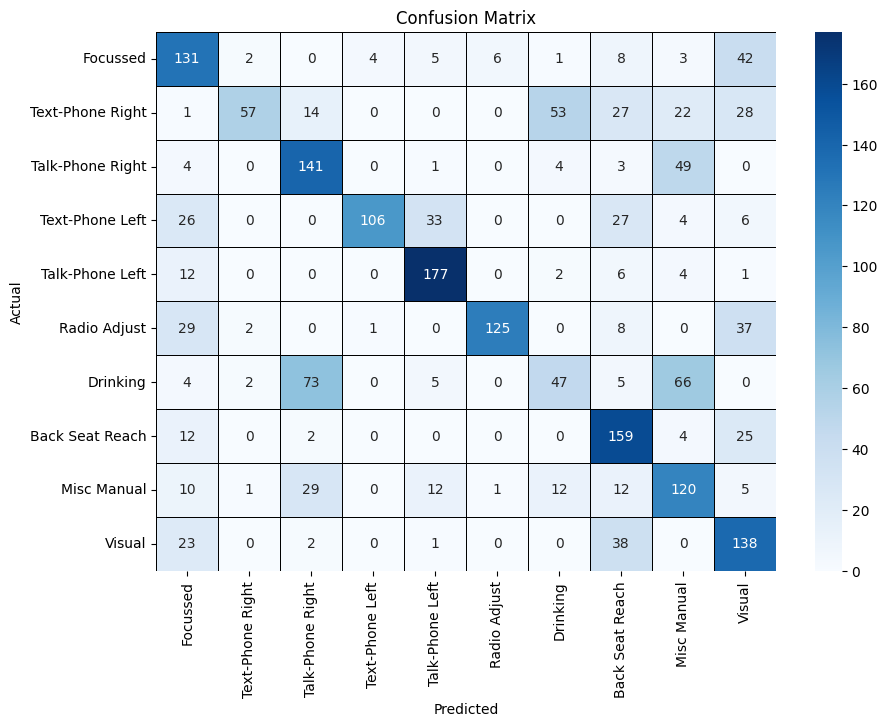

In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
ticks = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5, 9.5]
confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))

sns.heatmap(confusion, cmap="Blues", annot=True, fmt = ".5g", cbar=True, linewidths = 0.5,linecolor="black")
plt.xticks(ticks=ticks, labels=list(meta.values()), rotation=90)
plt.yticks(ticks=ticks, labels=list(meta.values()), rotation=-0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [29]:
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score, confusion_matrix
f1 = f1_score(y_test, y_pred, average="weighted")
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
print("f1:        " + str(f1))
print("Precision: " + str(precision))
print("recall:    " + str(recall))

f1:        0.5864317288527299
Precision: 0.6477189335183777
recall:    0.5945544554455445
